In [2]:
from matplotlib import pyplot
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from datetime import datetime
import time
import re
from ipaddress import ip_address
from urllib.parse import urlparse
import json
import isodate
from dateutil import parser
from dateutil import tz
from pyspark.sql.types import StructField, StructType, StringType
from pyspark.sql import Row
from pyspark.sql import functions as pyspark_function
from urllib.request import urlopen
import subprocess
import os.path
from os import path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import mktime
import time
from datetime import date, timedelta, datetime, tzinfo


In [3]:
import pyspark
import random
from pyspark.sql.functions import *
import pyspark.sql.functions as f
import pyspark.sql.functions as pyf
import numpy as np
import pandas 
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext


        
spark = SparkSession \
        .builder \
        .appName("Test Spark") \
        .config("spark.jars", "/opt/postgresql-42.4.0.jar") \
        .config("spark.num.executors"," 16")  \
        .config("spark.executor.cores", "8") \
        .config("spark.executor.memory", "20g") \
        .config("spark.scheduler.mode", "FAIR") \
        .config("spark.sql.autoBroadcastJoinThreshold", -1) \
        .master("spark://131.225.58.251:7077") \
        .getOrCreate() \



#spark.conf.set("spark.executor.memory", "20g")
#spark.conf.set("spark.executor.cores", "8")

22/07/20 19:44:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/20 19:44:04 WARN FairSchedulableBuilder: Fair Scheduler configuration file not found so jobs will be scheduled in FIFO order. To use fair scheduling, configure pools in fairscheduler.xml or set spark.scheduler.allocation.file to a file that contains the configuration.


In [5]:
df = spark.read \
     .format("jdbc") \
     .option("url", "jdbc:postgresql://fndca5b:5432/billing") \
     .option("dbtable", "(select *,  split_part(storageclass, '.', 1) as vo, date_trunc('day', datestamp) as date from storageinfo where datestamp between '2022-01-01 00:00:00' and '2022-06-30 23:59:59') as foo") \
     .option("user", "enstore_reader") \
     .option("driver", "org.postgresql.Driver") \
     .option("numPartitions", "16") \
     .option("partitionColumn", "datestamp") \
     .option("lowerBound", "2022-01-01 00:00:00") \
     .option("upperBound", "2022-06-30 23:59:59") \
     .option("fetchsize", 1000000) \
     .load()

df.printSchema()

root
 |-- queuedtime: long (nullable = true)
 |-- fullsize: long (nullable = true)
 |-- storageclass: string (nullable = true)
 |-- connectiontime: long (nullable = true)
 |-- action: string (nullable = true)
 |-- cellname: string (nullable = true)
 |-- datestamp: timestamp (nullable = true)
 |-- errorcode: integer (nullable = true)
 |-- errormessage: string (nullable = true)
 |-- pnfsid: string (nullable = true)
 |-- transaction: string (nullable = true)
 |-- vo: string (nullable = true)
 |-- date: timestamp (nullable = true)



In [6]:
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Column Name  Data type
0       queuedtime     bigint
1         fullsize     bigint
2     storageclass     string
3   connectiontime     bigint
4           action     string
5         cellname     string
6        datestamp  timestamp
7        errorcode        int
8     errormessage     string
9           pnfsid     string
10     transaction     string
11              vo     string
12            date  timestamp

In [7]:
import time
t0 = time.time()
print("Number of entries is    =====> ", df.count(), " Time to execute ", time.time()-t0)

Number of entries is    =====>  68915550  Time to execute  179.8162133693695


In [8]:
df.createOrReplaceTempView("billing")
df.cache()
print("Number of entries again =====> ", df.count(), " Time to execute ", time.time()-t0)

DataFrame[queuedtime: bigint, fullsize: bigint, storageclass: string, connectiontime: bigint, action: string, cellname: string, datestamp: timestamp, errorcode: int, errormessage: string, pnfsid: string, transaction: string, vo: string, date: timestamp]

Number of entries again =====>  68915550  Time to execute  857.6760790348053


In [12]:
# df_vo = spark.sql("select date, vo, sum(case when action = 'restore' then 1 else 0 END) as restores,sum(case when action = 'store' then 1 else 0 END)as stores, AVG(connectiontime + queuedtime)/1000 as avg_time_restore  FROM billing where action='restore' and errorcode = 0  group by vo, date order by vo, date asc;")
# df_vo.show(1000)
# df_vo.count()

In [14]:
# df_vo2 = spark.sql("select date, vo,  sum(case when action = 'restore' then (connectiontime + queuedtime)/1000 else 0 END) as avg_time_restore, sum(case when action = 'store' then (connectiontime + queuedtime)/1000 else 0 END)as avg_time_store  FROM billing where errorcode = 0  group by date, vo order by vo, date asc;")
# df_vo2.show(8605)
# df_vo2.count()

In [15]:
# d5=df_vo2.toPandas()
# d5['Date'] = pd.to_datetime(d5['date']).dt.date
# print(d5.Date)


In [16]:
# d6 = d5.groupby(['vo', 'Date']).mean()
# print(d6)

In [17]:
# for vo, group in d6.groupby('vo'):
#     group.plot.bar( title=vo, figsize=(24,12))

In [18]:
# d6.boxplot( by='vo',column='avg_time_restore', grid = False, color='blue',figsize=(48,24))
# plt.xlabel("vo")

In [9]:
df_vo = spark.sql("select date, vo,  avg(case when action = 'restore' then (connectiontime + queuedtime)/1000 else 0 END) as avg_time_restore, avg(case when action = 'store' then (connectiontime + queuedtime)/1000 else 0 END)as avg_time_store  FROM billing where errorcode = 0  group by date, vo order by vo, date asc;")
df_vo.show(612)
df_vo.count()

+-------------------+-------+--------------------+------------------+
|               date|     vo|    avg_time_restore|    avg_time_store|
+-------------------+-------+--------------------+------------------+
|2022-02-21 00:00:00|   ADMX|                 0.0|17425.729499999998|
|2022-02-22 00:00:00|   ADMX|                 0.0|           4313.82|
|2022-03-16 00:00:00|   ADMX|                 0.0|     168003.362375|
|2022-04-06 00:00:00|   ADMX|                 0.0|          1381.483|
|2022-04-10 00:00:00|   ADMX|                 0.0| 8736.698229166668|
|2022-04-11 00:00:00|   ADMX|                 0.0|           325.774|
|2022-04-12 00:00:00|   ADMX|                 0.0|453.01899582463426|
|2022-04-13 00:00:00|   ADMX|                 0.0|1438.9787591424968|
|2022-04-21 00:00:00|   ADMX|                 0.0| 17492.33398318919|
|2022-04-22 00:00:00|   ADMX|                 0.0| 26352.77271063624|
|2022-04-23 00:00:00|   ADMX|                 0.0| 82851.52524001744|
|2022-04-24 00:00:00

3010

In [10]:
df_vo1 = spark.sql("select date, vo,  avg(case when action = 'restore' then (connectiontime + queuedtime)/1000 else 0 END) as avg_time_restore FROM billing where errorcode = 0  group by date, vo order by vo, date asc;")
df_vo1.show(612)
df_vo1.count()

+-------------------+-------+--------------------+
|               date|     vo|    avg_time_restore|
+-------------------+-------+--------------------+
|2022-02-21 00:00:00|   ADMX|                 0.0|
|2022-02-22 00:00:00|   ADMX|                 0.0|
|2022-03-16 00:00:00|   ADMX|                 0.0|
|2022-04-06 00:00:00|   ADMX|                 0.0|
|2022-04-10 00:00:00|   ADMX|                 0.0|
|2022-04-11 00:00:00|   ADMX|                 0.0|
|2022-04-12 00:00:00|   ADMX|                 0.0|
|2022-04-13 00:00:00|   ADMX|                 0.0|
|2022-04-21 00:00:00|   ADMX|                 0.0|
|2022-04-22 00:00:00|   ADMX|                 0.0|
|2022-04-23 00:00:00|   ADMX|                 0.0|
|2022-04-24 00:00:00|   ADMX|                 0.0|
|2022-04-25 00:00:00|   ADMX|                 0.0|
|2022-04-26 00:00:00|   ADMX|                 0.0|
|2022-04-27 00:00:00|   ADMX|                 0.0|
|2022-05-09 00:00:00|   ADMX|                 0.0|
|2022-05-10 00:00:00|   ADMX|  

3010

+-------------------+--------+--------------------+
|               date|      vo|    avg_time_restore|
+-------------------+--------+--------------------+
|2022-03-16 00:00:00|    ADMX|                 0.0|
|2022-04-06 00:00:00|    ADMX|                 0.0|
|2022-04-10 00:00:00|    ADMX|                 0.0|
|2022-04-11 00:00:00|    ADMX|                 0.0|
|2022-04-12 00:00:00|    ADMX|                 0.0|
|2022-04-13 00:00:00|    ADMX|                 0.0|
|2022-04-21 00:00:00|    ADMX|                 0.0|
|2022-04-22 00:00:00|    ADMX|                 0.0|
|2022-04-23 00:00:00|    ADMX|                 0.0|
|2022-04-24 00:00:00|    ADMX|                 0.0|
|2022-04-25 00:00:00|    ADMX|                 0.0|
|2022-04-26 00:00:00|    ADMX|                 0.0|
|2022-04-27 00:00:00|    ADMX|                 0.0|
|2022-05-09 00:00:00|    ADMX|                 0.0|
|2022-05-10 00:00:00|    ADMX|                 0.0|
|2022-05-11 00:00:00|    ADMX|                 0.0|
|2022-05-12 

2029

           date         vo  avg_time_restore
0    2022-03-16       ADMX          0.000000
1    2022-04-06       ADMX          0.000000
2    2022-04-10       ADMX          0.000000
3    2022-04-11       ADMX          0.000000
4    2022-04-12       ADMX          0.000000
5    2022-04-13       ADMX          0.000000
6    2022-04-21       ADMX          0.000000
7    2022-04-22       ADMX          0.000000
8    2022-04-23       ADMX          0.000000
9    2022-04-24       ADMX          0.000000
10   2022-04-25       ADMX          0.000000
11   2022-04-26       ADMX          0.000000
12   2022-04-27       ADMX          0.000000
13   2022-05-09       ADMX          0.000000
14   2022-05-10       ADMX          0.000000
15   2022-05-11       ADMX          0.000000
16   2022-05-12       ADMX          0.000000
17   2022-05-13       ADMX          0.000000
18   2022-05-14       ADMX          0.000000
19   2022-05-15       ADMX          0.000000
20   2022-05-16       ADMX          0.000000
21   2022-

<AxesSubplot:title={'center':'ADMX'}, xlabel='date'>

<AxesSubplot:title={'center':'GM2'}, xlabel='date'>

<AxesSubplot:title={'center':'Simons'}, xlabel='date'>

<AxesSubplot:title={'center':'accelai'}, xlabel='date'>

<AxesSubplot:title={'center':'annie'}, xlabel='date'>

<AxesSubplot:title={'center':'backups'}, xlabel='date'>

<AxesSubplot:title={'center':'damic'}, xlabel='date'>

<AxesSubplot:title={'center':'darkside'}, xlabel='date'>

<AxesSubplot:title={'center':'des'}, xlabel='date'>

<AxesSubplot:title={'center':'dune'}, xlabel='date'>

<AxesSubplot:title={'center':'e1039'}, xlabel='date'>

<AxesSubplot:title={'center':'e906'}, xlabel='date'>

<AxesSubplot:title={'center':'fermigrid'}, xlabel='date'>

<AxesSubplot:title={'center':'icarus'}, xlabel='date'>

<AxesSubplot:title={'center':'lariat'}, xlabel='date'>

<AxesSubplot:title={'center':'lqcd'}, xlabel='date'>

<AxesSubplot:title={'center':'minerva'}, xlabel='date'>

<AxesSubplot:title={'center':'mu2e'}, xlabel='date'>

<AxesSubplot:title={'center':'netflow'}, xlabel='date'>

<AxesSubplot:title={'center':'next'}, xlabel='date'>

/usr/local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<AxesSubplot:title={'center':'none'}, xlabel='date'>

<AxesSubplot:title={'center':'nova'}, xlabel='date'>

<AxesSubplot:title={'center':'numix'}, xlabel='date'>

<AxesSubplot:title={'center':'sbnd'}, xlabel='date'>

<AxesSubplot:title={'center':'scope'}, xlabel='date'>

<AxesSubplot:title={'center':'snoplus'}, xlabel='date'>

<AxesSubplot:title={'center':'test'}, xlabel='date'>

<AxesSubplot:title={'center':'test2'}, xlabel='date'>

<AxesSubplot:title={'center':'uboone'}, xlabel='date'>

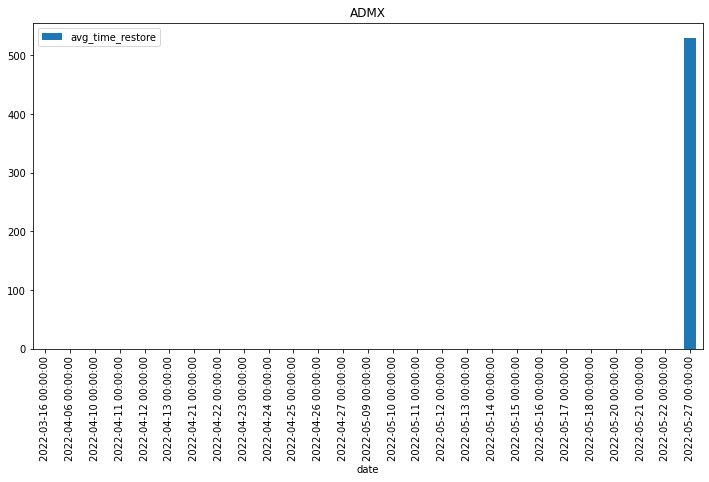

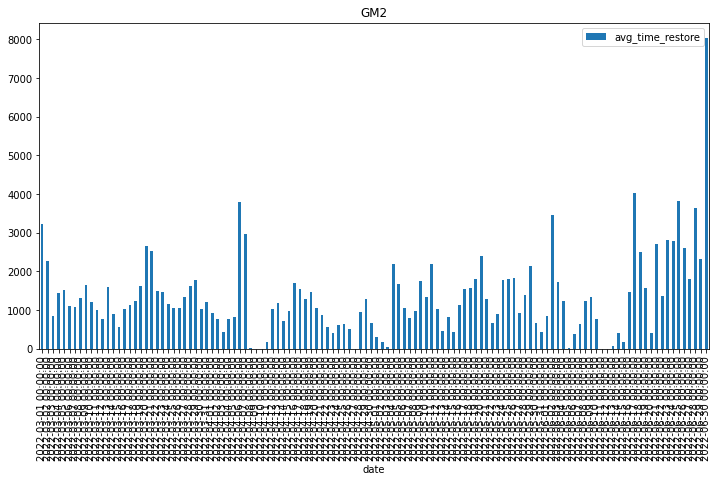

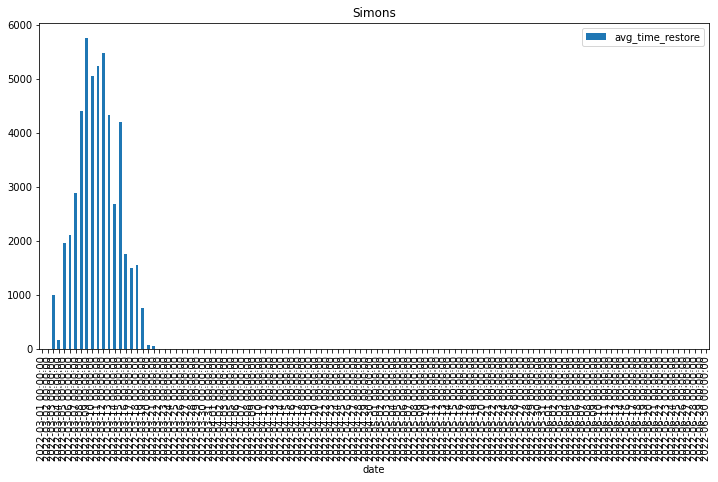

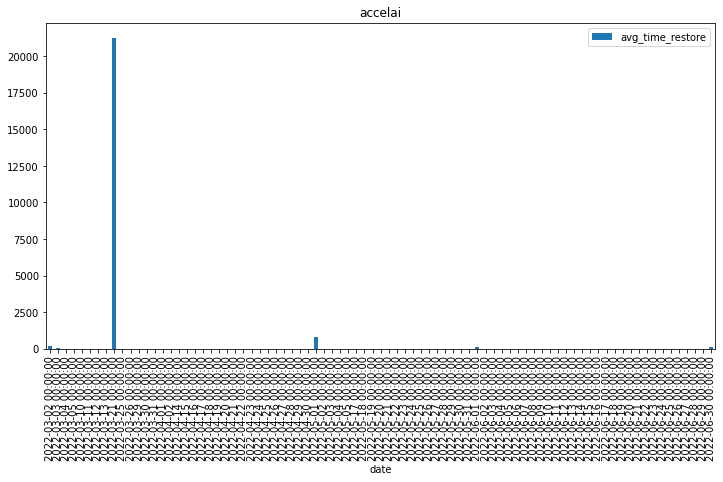

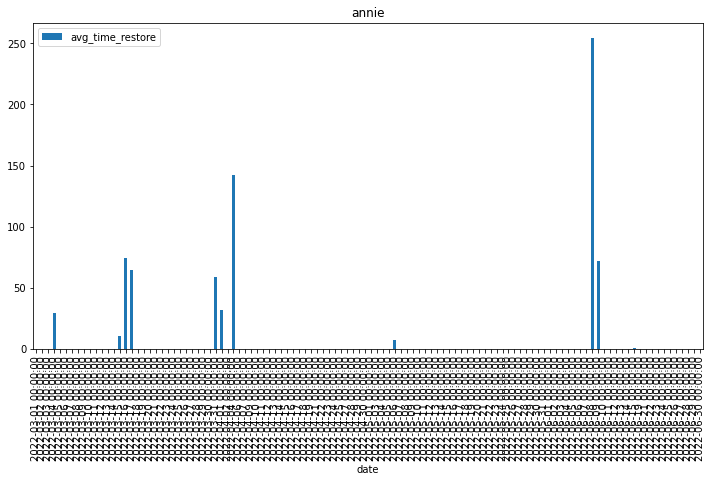

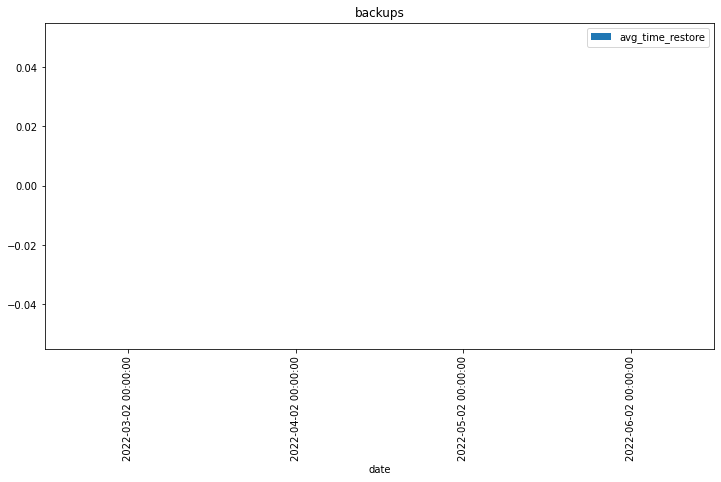

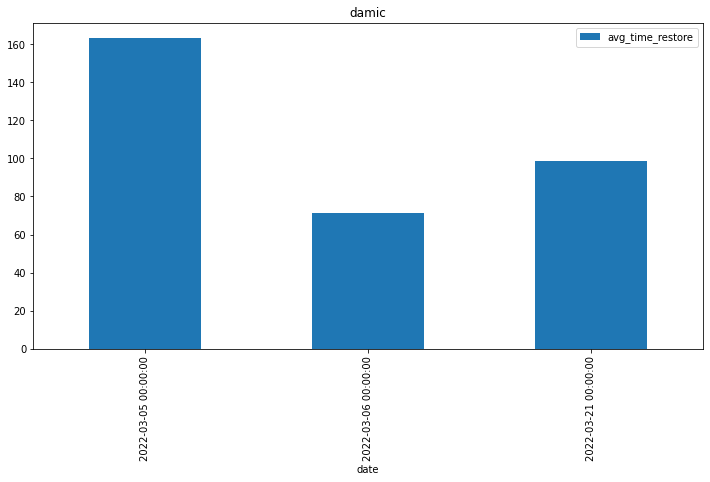

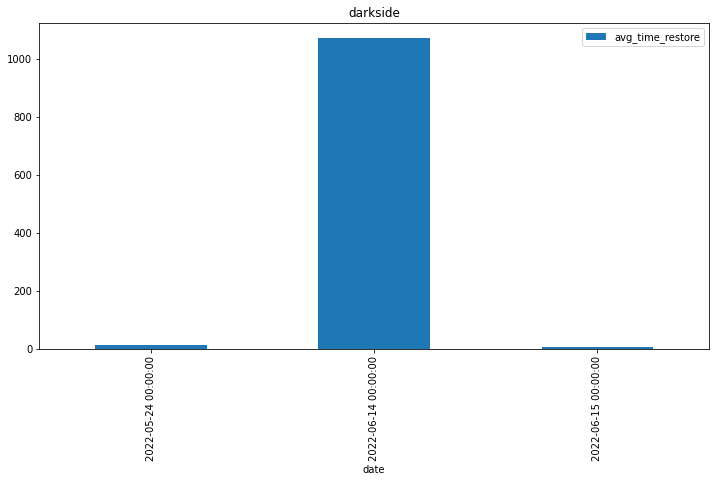

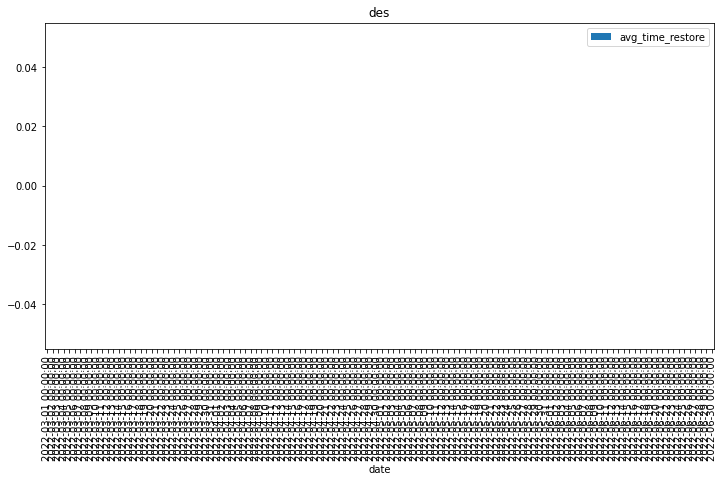

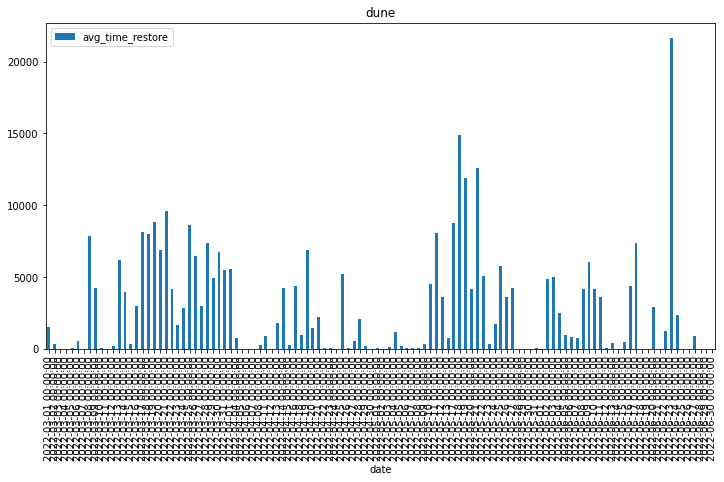

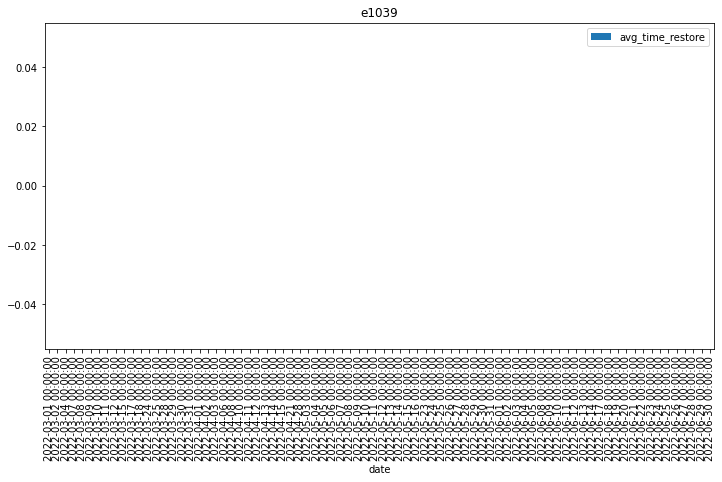

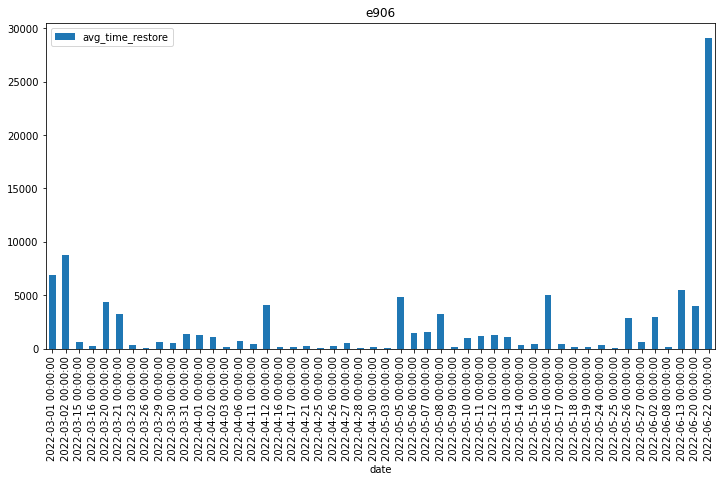

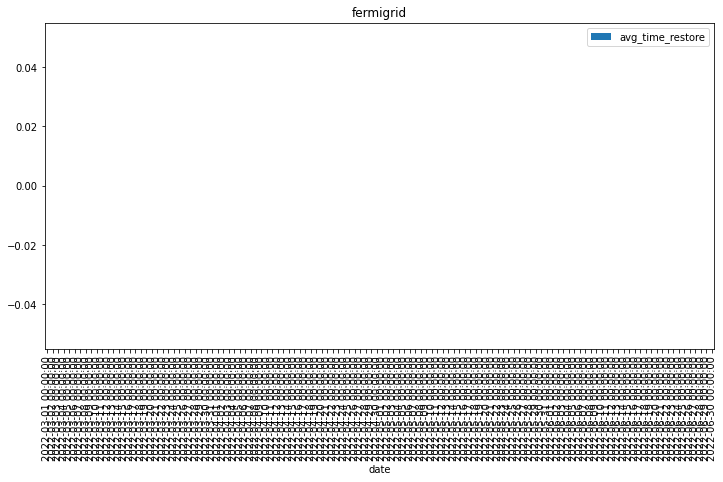

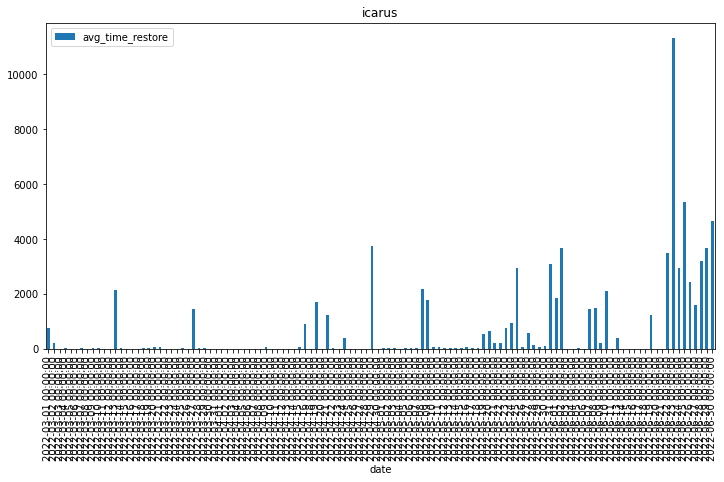

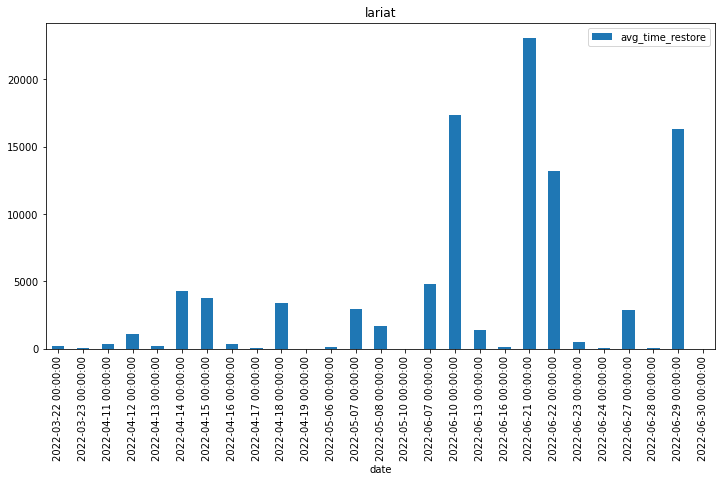

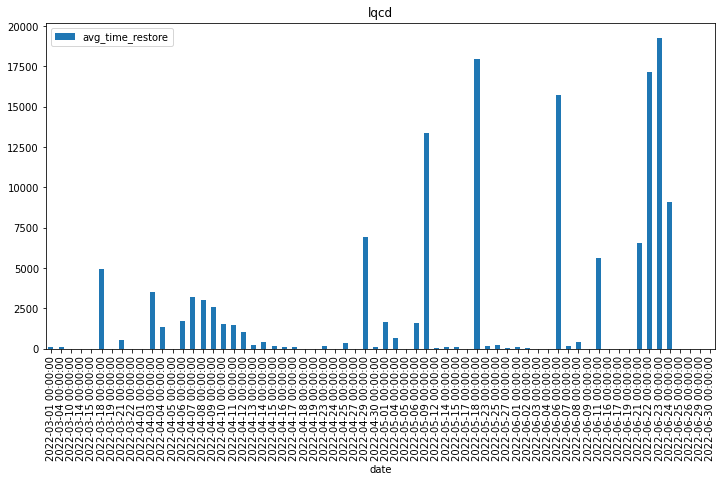

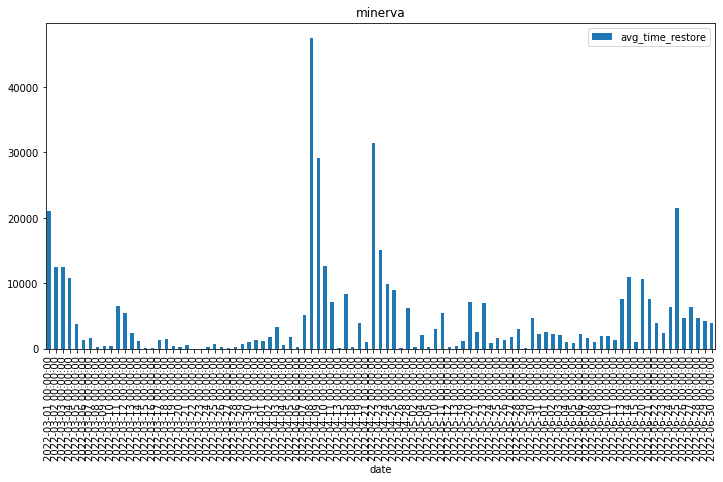

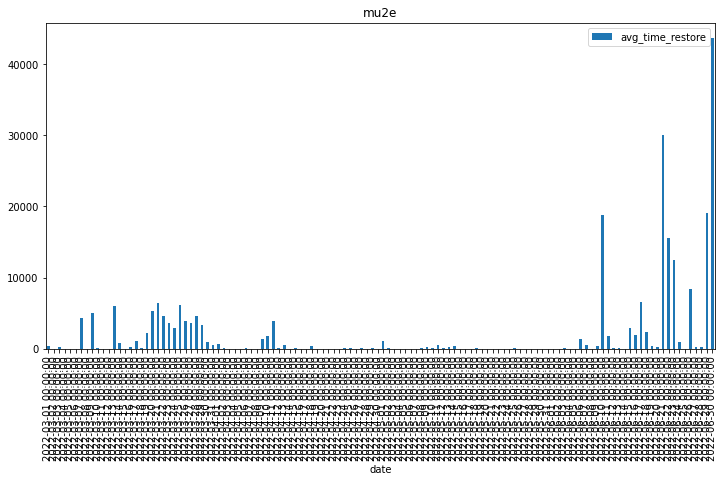

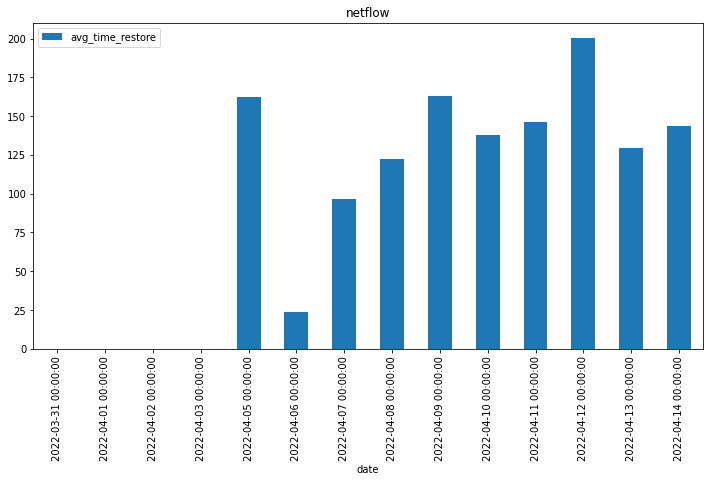

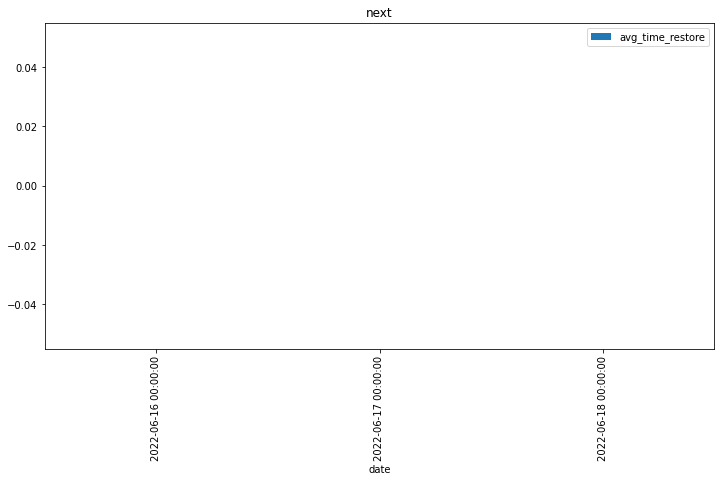

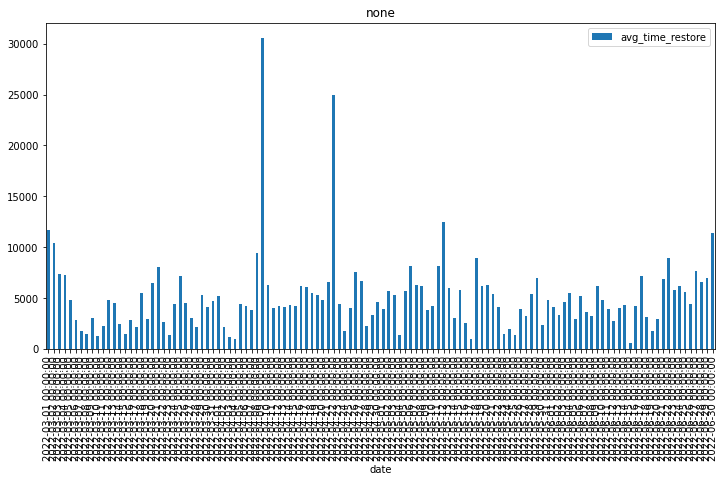

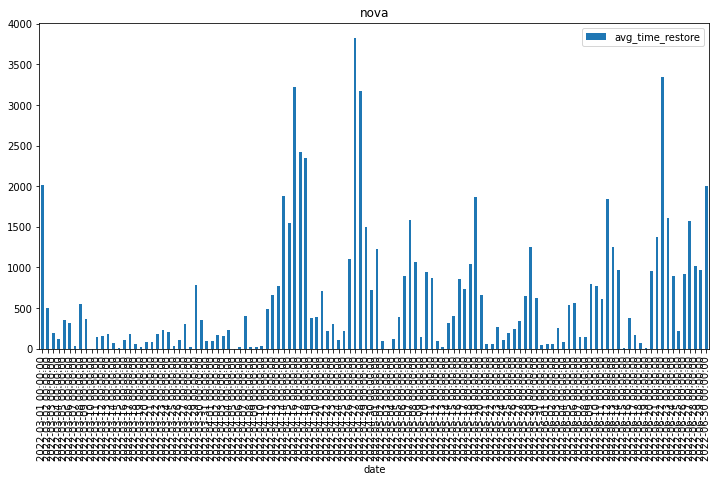

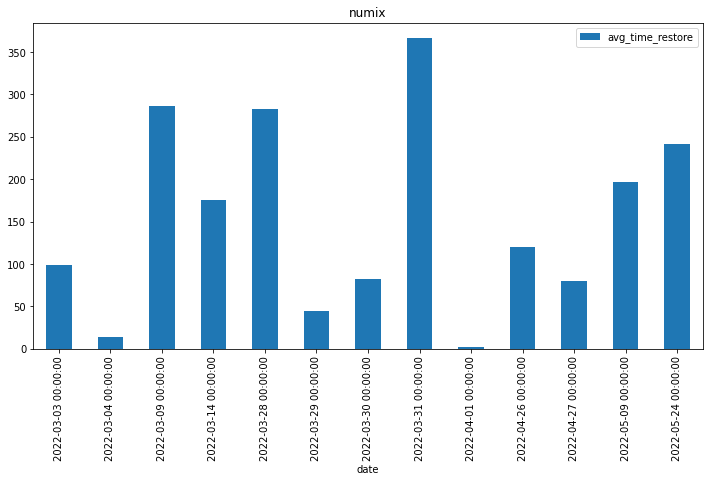

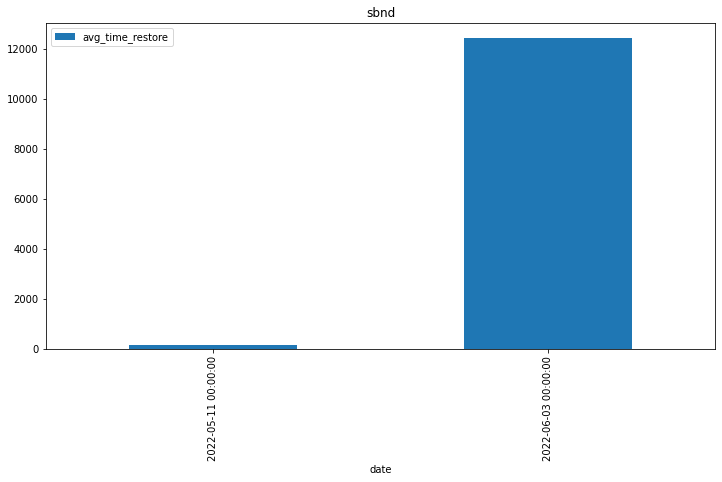

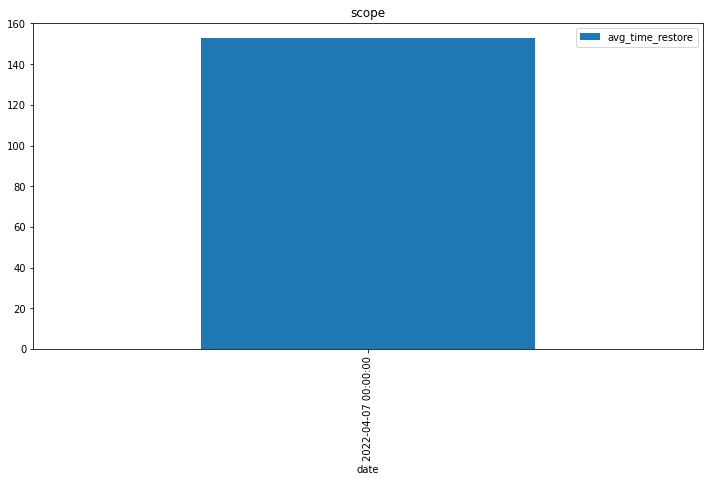

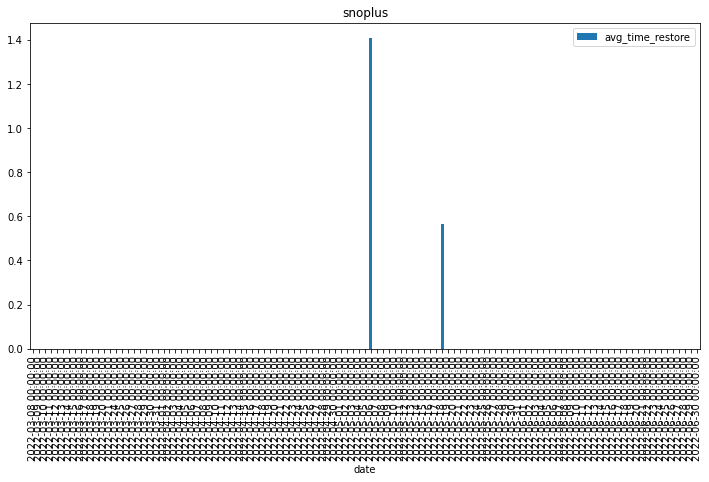

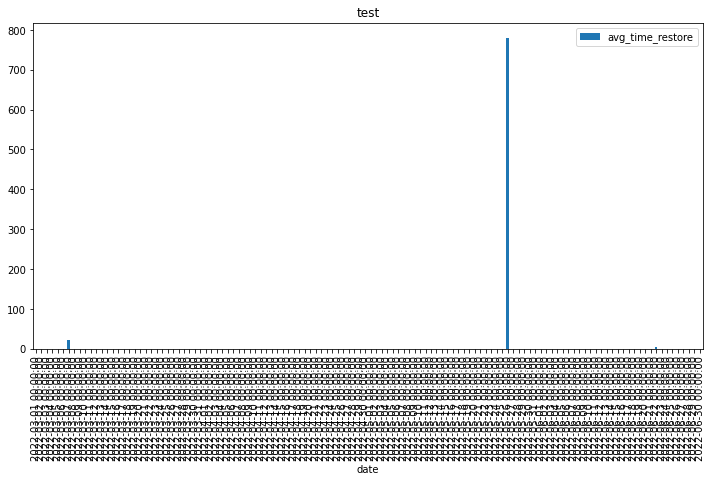

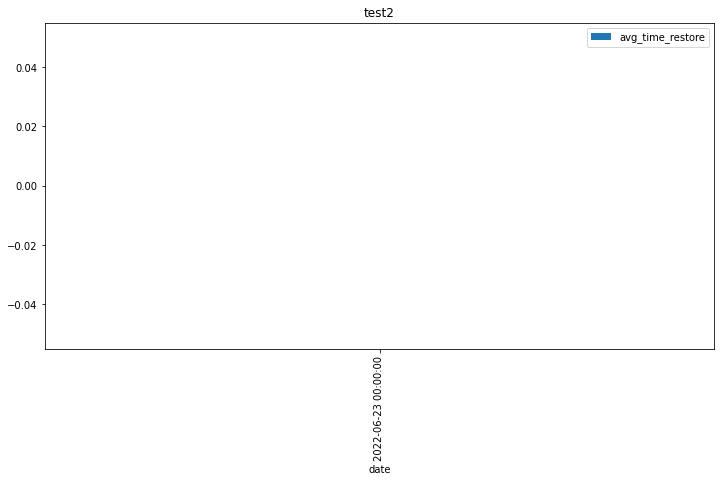

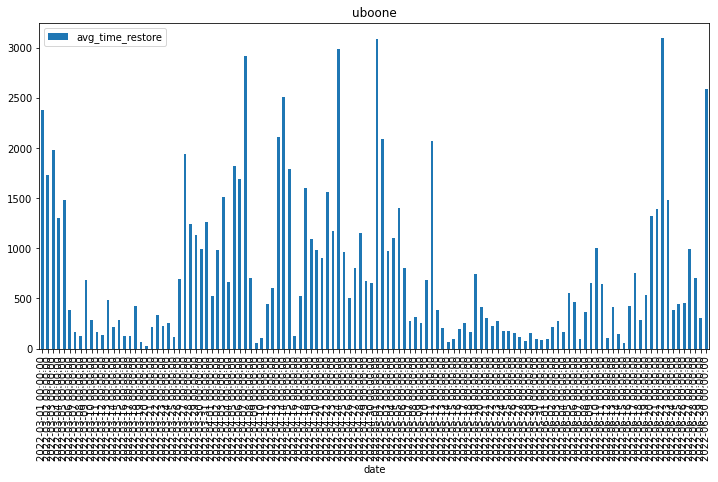

In [16]:
df_vo2 = spark.sql("select date, vo,  avg(case when action = 'restore' then (connectiontime + queuedtime)/1000 else 0 END) as avg_time_restore FROM billing where errorcode = 0 and datestamp between '2022-03-01 00:00:00' and '2022-06-30 23:59:59'  group by date, vo order by vo, date asc;")
df_vo2.show(612)
df_vo2.count()
d2=df_vo2.toPandas()
print(d2)
for vo, group in d2.groupby('vo'):
    group.plot.bar( x= 'date', title=vo, figsize=(48,6))

<AxesSubplot:title={'center':'ADMX'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'GM2'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'Simons'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'accelai'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'annie'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'backups'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'damic'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'darkside'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'des'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'dune'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'e1039'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'e906'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'fermigrid'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'icarus'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'lariat'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'lqcd'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'minerva'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'mu2e'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'netflow'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'next'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

/usr/local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<AxesSubplot:title={'center':'none'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'nova'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'numix'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'sbnd'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'scope'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'snoplus'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'test'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'test2'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

<AxesSubplot:title={'center':'uboone'}, xlabel='date'>

Text(0, 0.5, 'avg_time_to_restore')

Text(0.5, 0, 'vo')

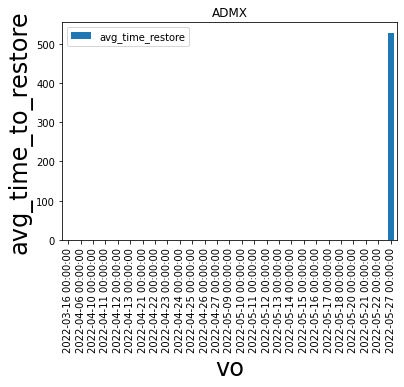

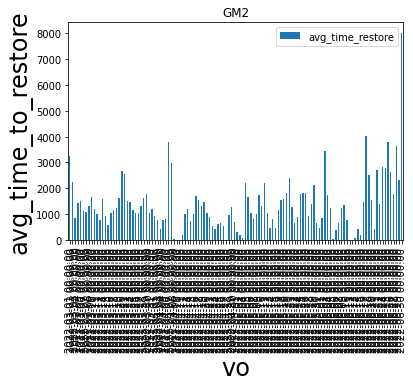

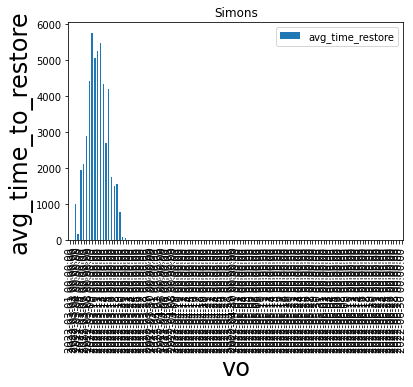

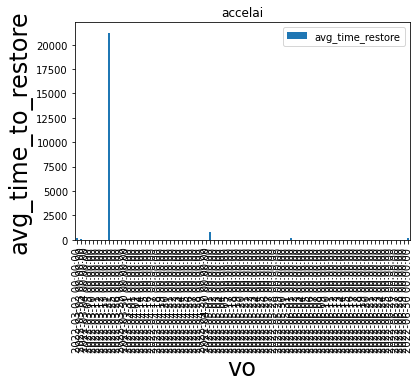

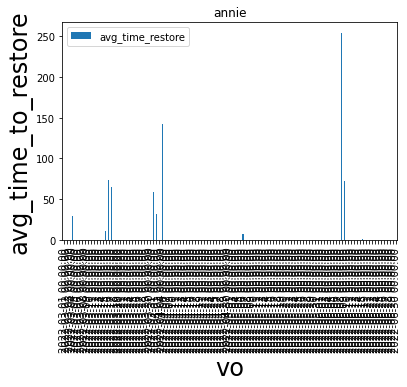

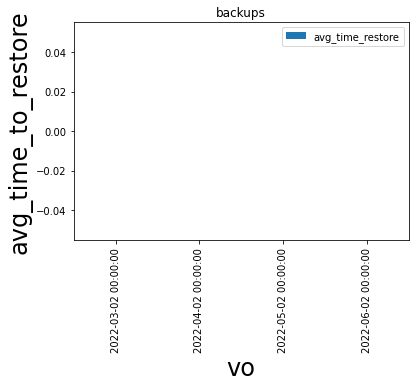

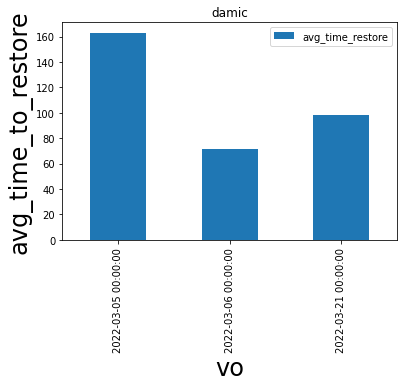

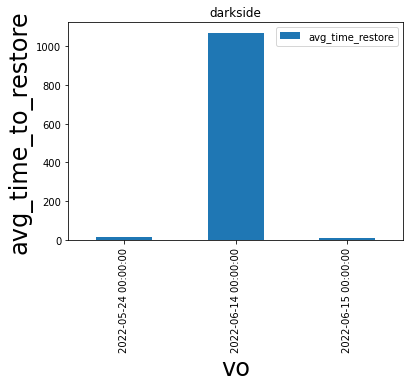

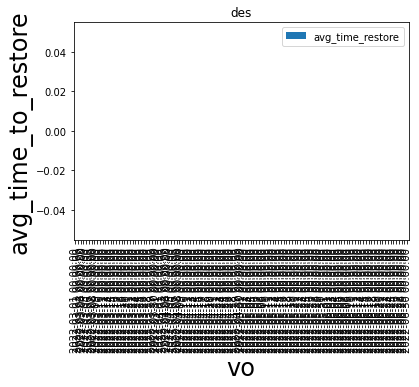

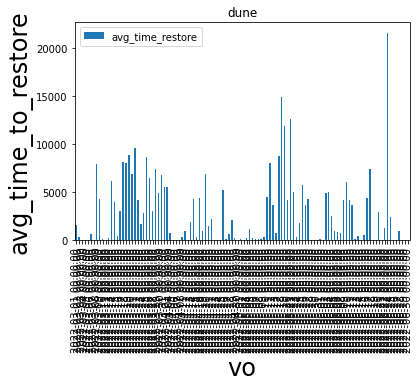

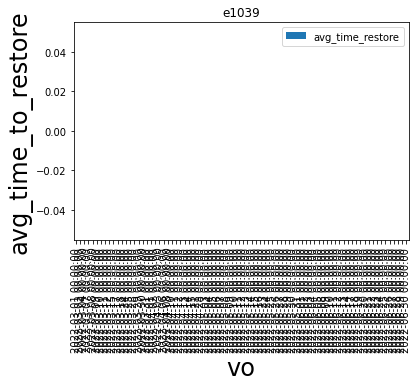

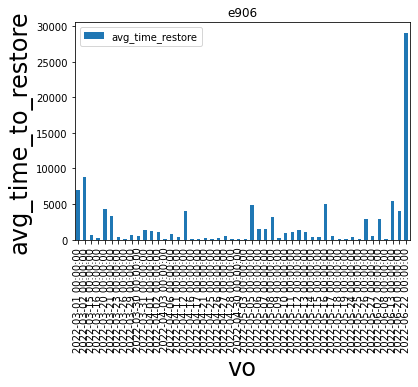

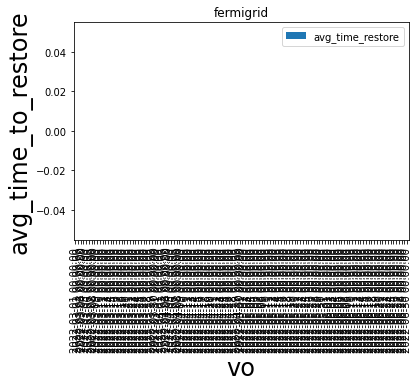

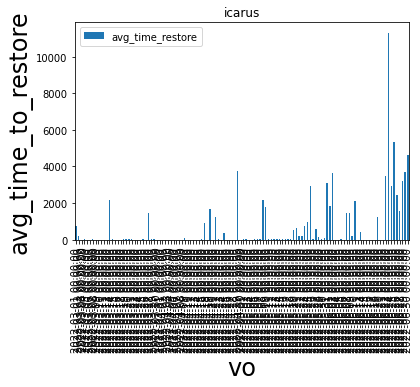

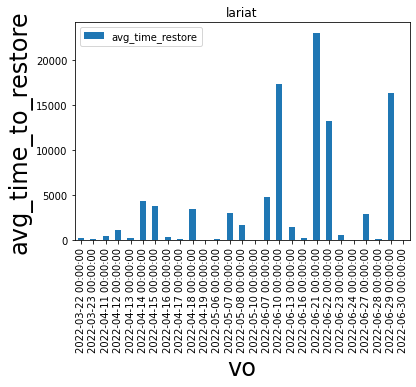

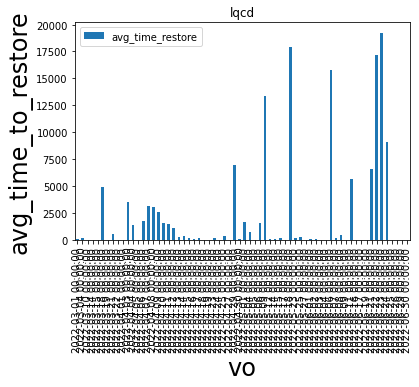

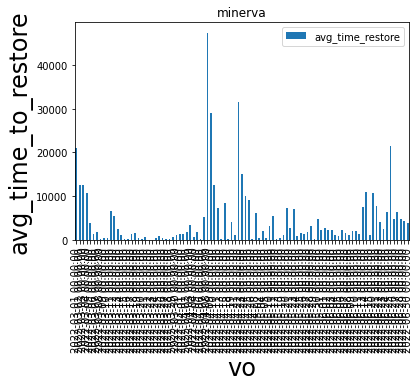

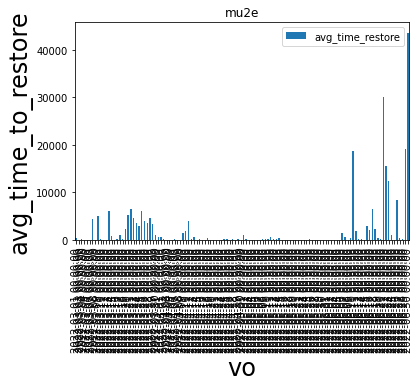

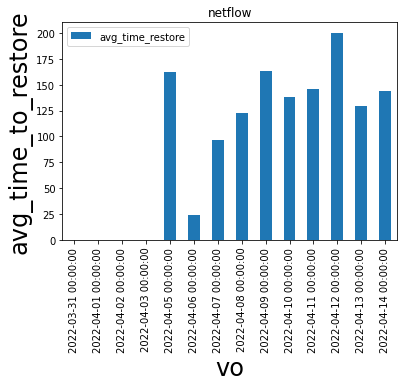

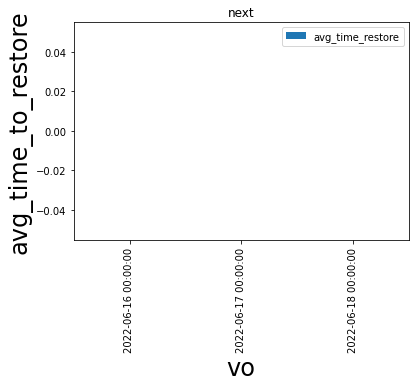

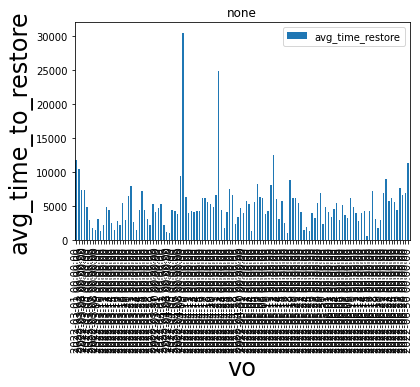

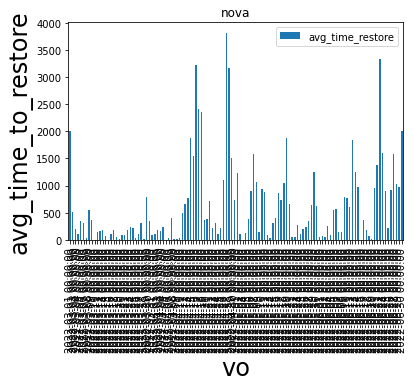

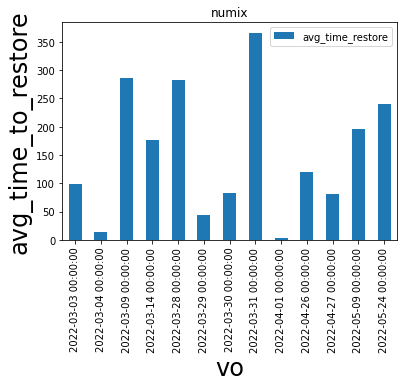

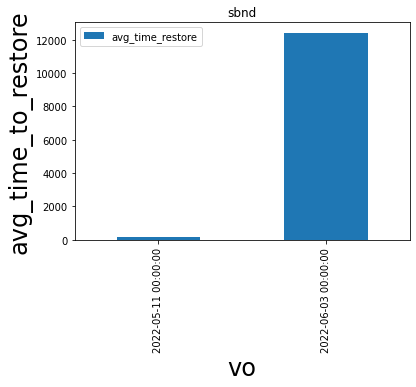

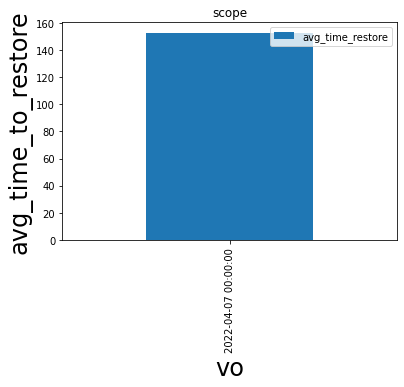

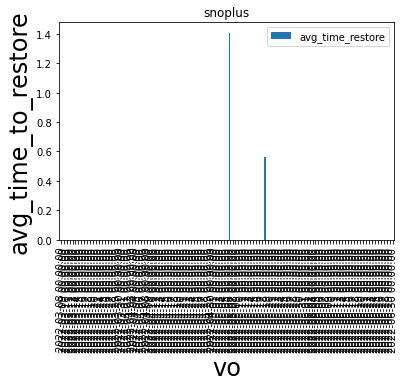

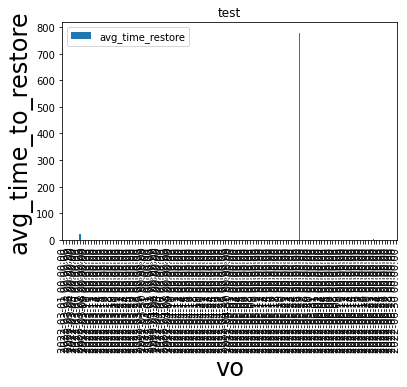

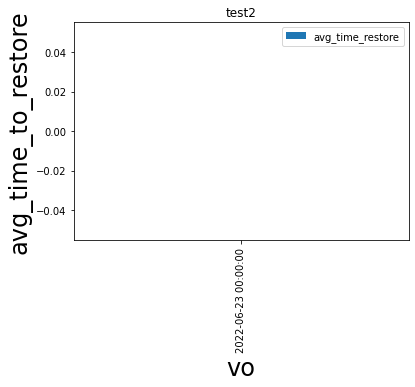

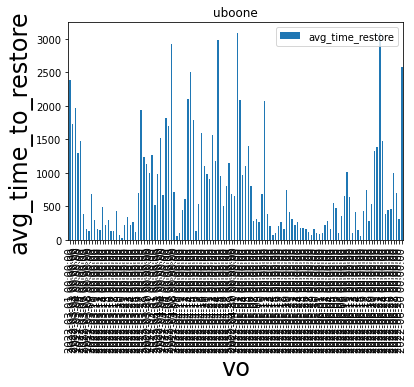

In [24]:
for vo, group in d2.groupby('vo'):
    group.plot.bar( x= 'date', title=vo)
    plt.ylabel("avg_time_to_restore" ,fontsize=24)
    plt.xlabel("vo" ,fontsize=24)

In [11]:
d=df_vo.toPandas()
print(d)

           date         vo  avg_time_restore  avg_time_store
0    2022-02-21       ADMX          0.000000    1.742573e+04
1    2022-02-22       ADMX          0.000000    4.313820e+03
2    2022-03-16       ADMX          0.000000    1.680034e+05
3    2022-04-06       ADMX          0.000000    1.381483e+03
4    2022-04-10       ADMX          0.000000    8.736698e+03
5    2022-04-11       ADMX          0.000000    3.257740e+02
6    2022-04-12       ADMX          0.000000    4.530190e+02
7    2022-04-13       ADMX          0.000000    1.438979e+03
8    2022-04-21       ADMX          0.000000    1.749233e+04
9    2022-04-22       ADMX          0.000000    2.635277e+04
10   2022-04-23       ADMX          0.000000    8.285153e+04
11   2022-04-24       ADMX          0.000000    1.053831e+05
12   2022-04-25       ADMX          0.000000    7.871304e+04
13   2022-04-26       ADMX          0.000000    4.349957e+04
14   2022-04-27       ADMX          0.000000    8.558186e+03
15   2022-05-09       AD

In [12]:
d1=df_vo1.toPandas()
print(d1)

           date         vo  avg_time_restore
0    2022-02-21       ADMX          0.000000
1    2022-02-22       ADMX          0.000000
2    2022-03-16       ADMX          0.000000
3    2022-04-06       ADMX          0.000000
4    2022-04-10       ADMX          0.000000
5    2022-04-11       ADMX          0.000000
6    2022-04-12       ADMX          0.000000
7    2022-04-13       ADMX          0.000000
8    2022-04-21       ADMX          0.000000
9    2022-04-22       ADMX          0.000000
10   2022-04-23       ADMX          0.000000
11   2022-04-24       ADMX          0.000000
12   2022-04-25       ADMX          0.000000
13   2022-04-26       ADMX          0.000000
14   2022-04-27       ADMX          0.000000
15   2022-05-09       ADMX          0.000000
16   2022-05-10       ADMX          0.000000
17   2022-05-11       ADMX          0.000000
18   2022-05-12       ADMX          0.000000
19   2022-05-13       ADMX          0.000000
20   2022-05-14       ADMX          0.000000
21   2022-

In [22]:
#d1.groupby('vo').mean()

<AxesSubplot:title={'center':'GM2'}, xlabel='date'>

<AxesSubplot:title={'center':'Simons'}, xlabel='date'>

<AxesSubplot:title={'center':'accelai'}, xlabel='date'>

<AxesSubplot:title={'center':'annie'}, xlabel='date'>

<AxesSubplot:title={'center':'backups'}, xlabel='date'>

<AxesSubplot:title={'center':'darkside'}, xlabel='date'>

<AxesSubplot:title={'center':'des'}, xlabel='date'>

<AxesSubplot:title={'center':'dune'}, xlabel='date'>

<AxesSubplot:title={'center':'e1039'}, xlabel='date'>

<AxesSubplot:title={'center':'e906'}, xlabel='date'>

<AxesSubplot:title={'center':'fermigrid'}, xlabel='date'>

<AxesSubplot:title={'center':'icarus'}, xlabel='date'>

<AxesSubplot:title={'center':'lariat'}, xlabel='date'>

<AxesSubplot:title={'center':'lqcd'}, xlabel='date'>

<AxesSubplot:title={'center':'minerva'}, xlabel='date'>

<AxesSubplot:title={'center':'mu2e'}, xlabel='date'>

<AxesSubplot:title={'center':'next'}, xlabel='date'>

<AxesSubplot:title={'center':'none'}, xlabel='date'>

<AxesSubplot:title={'center':'nova'}, xlabel='date'>

<AxesSubplot:title={'center':'sbnd'}, xlabel='date'>

/usr/local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<AxesSubplot:title={'center':'snoplus'}, xlabel='date'>

<AxesSubplot:title={'center':'test'}, xlabel='date'>

<AxesSubplot:title={'center':'test2'}, xlabel='date'>

<AxesSubplot:title={'center':'uboone'}, xlabel='date'>

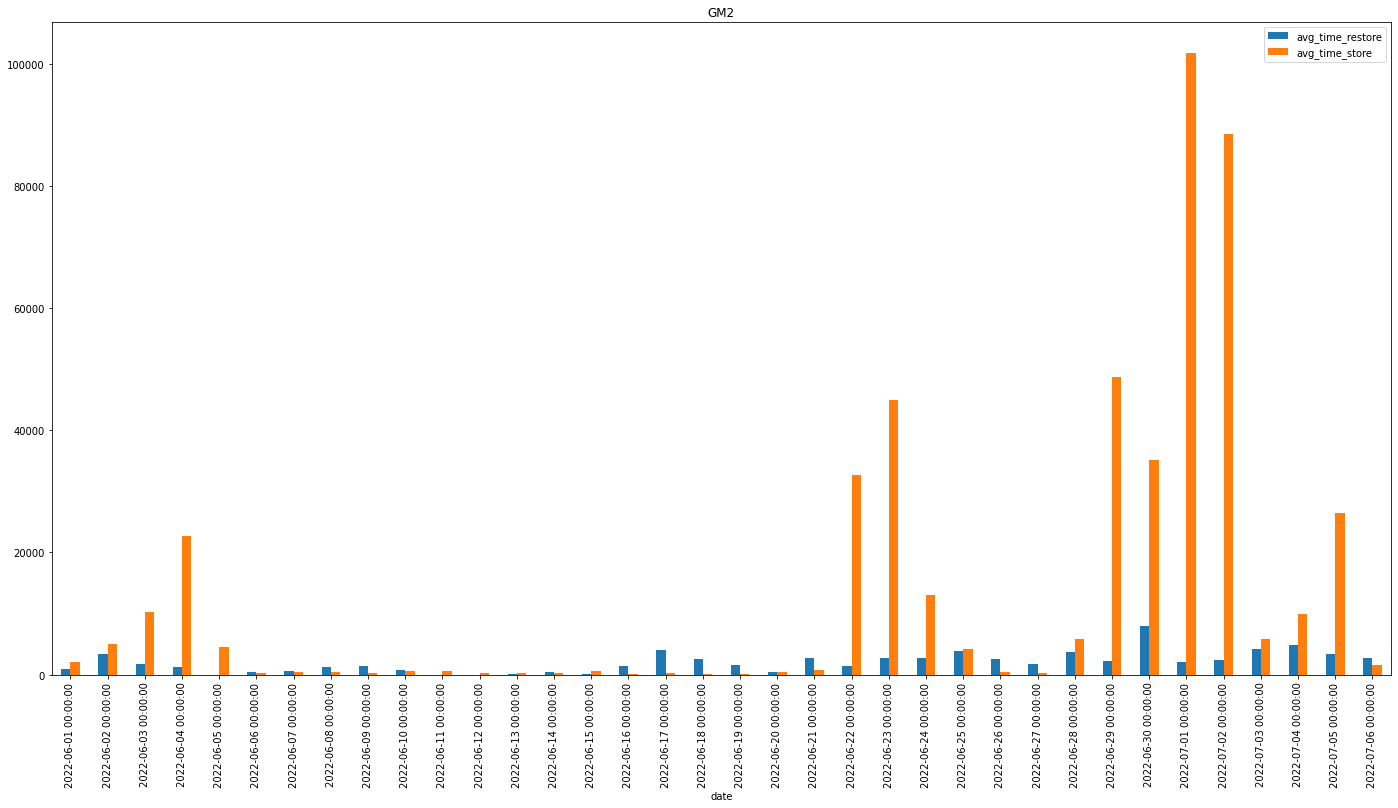

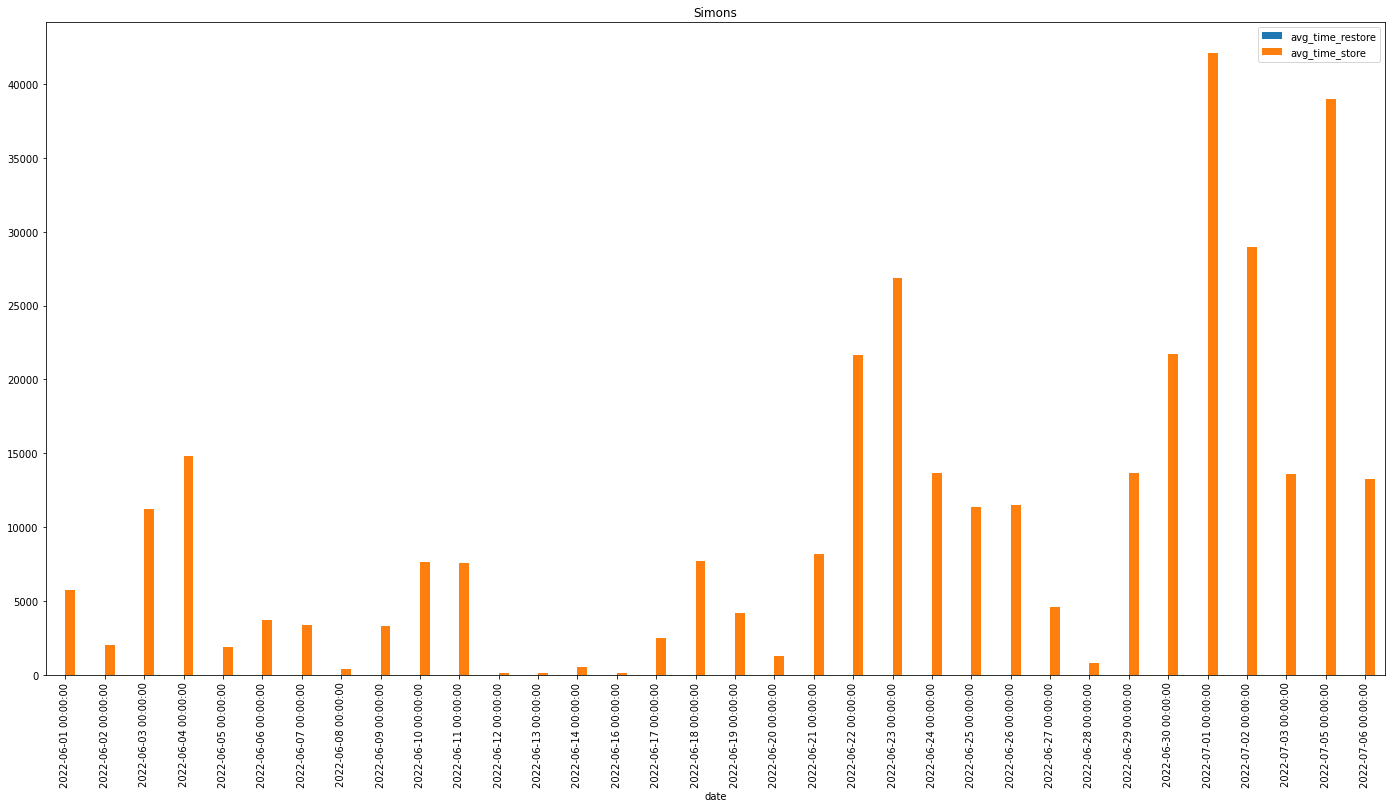

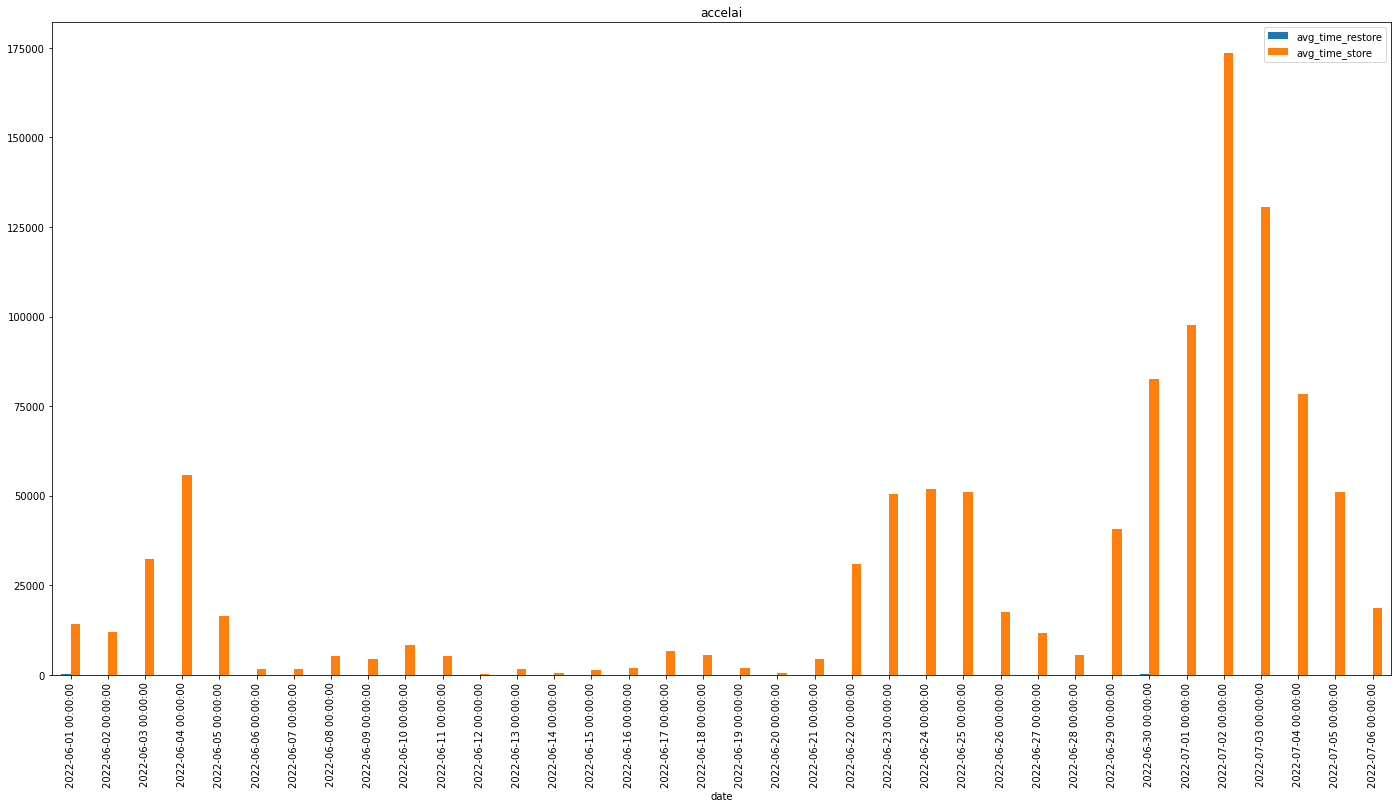

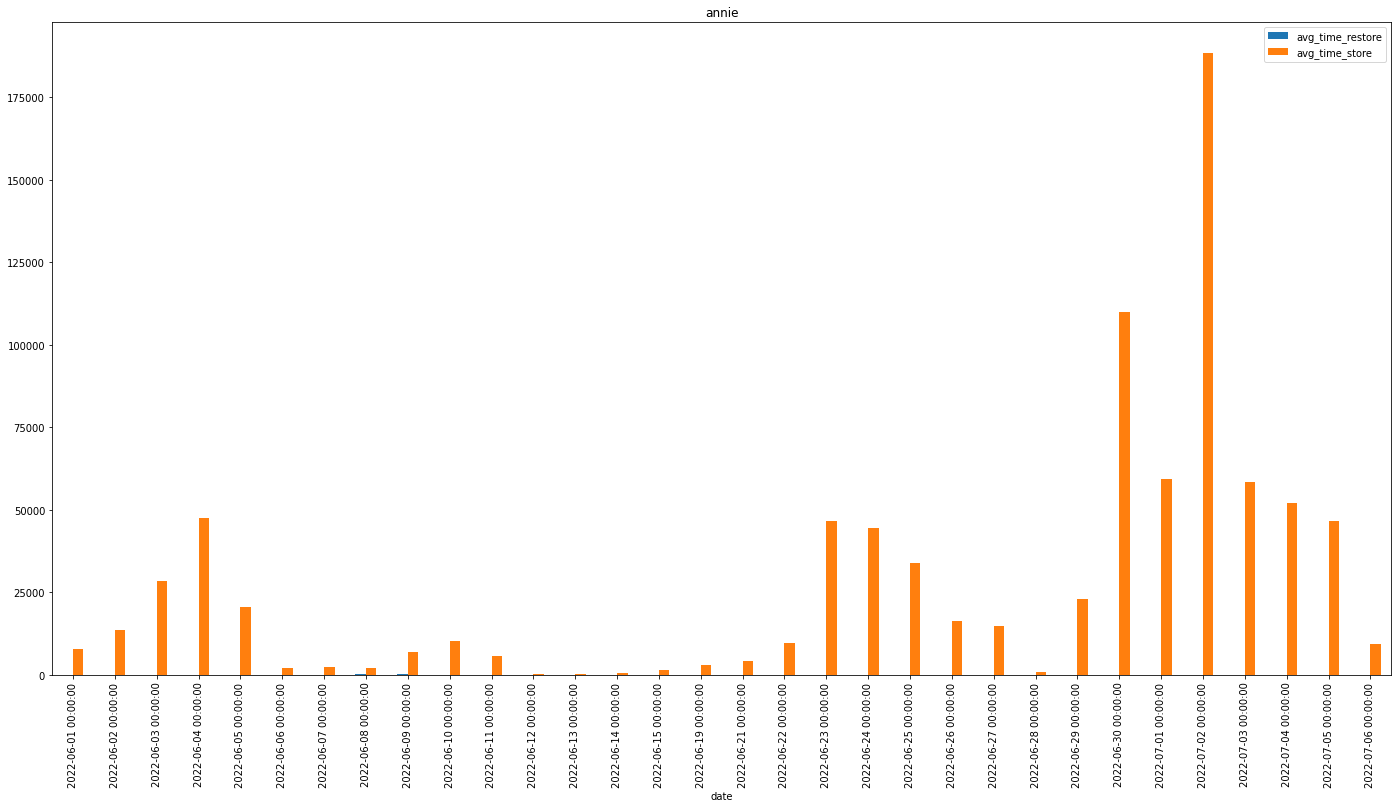

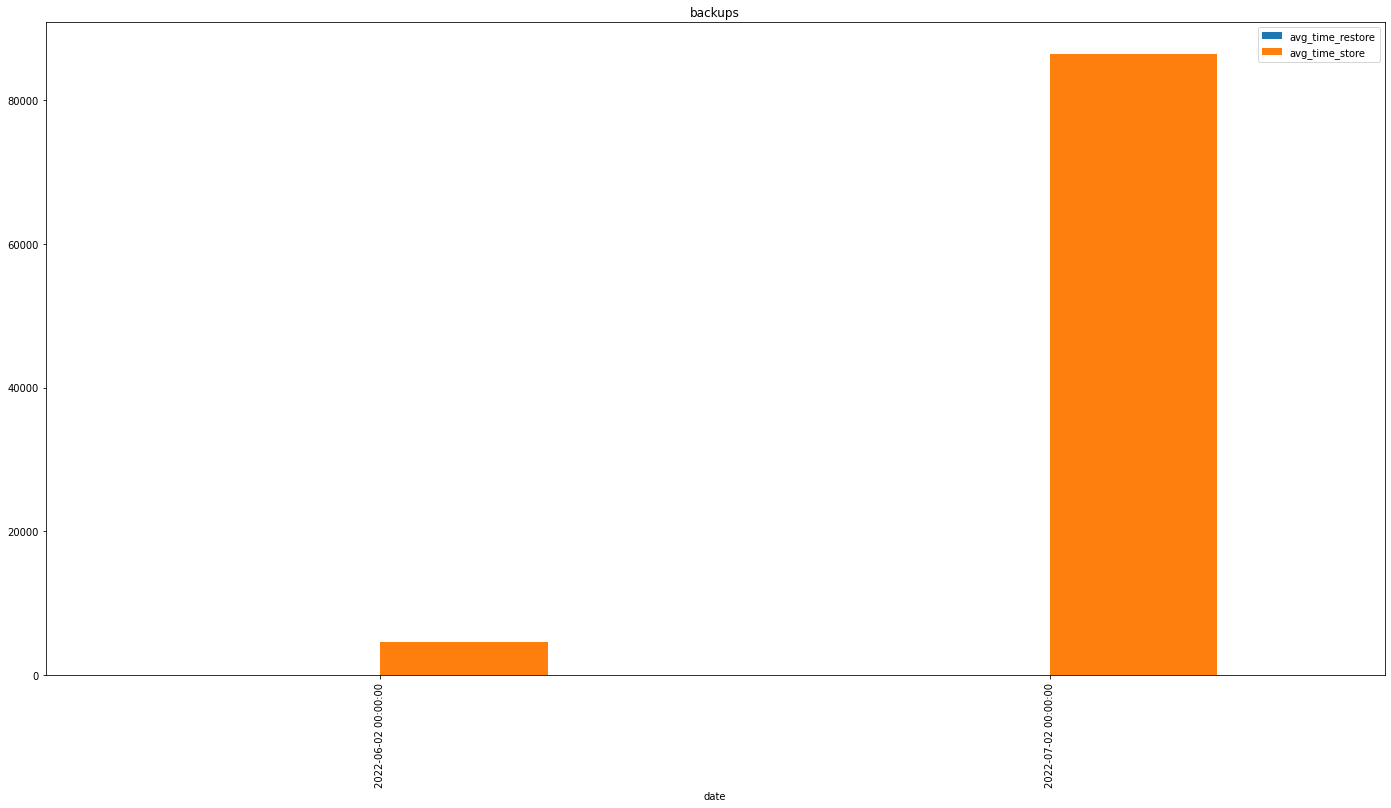

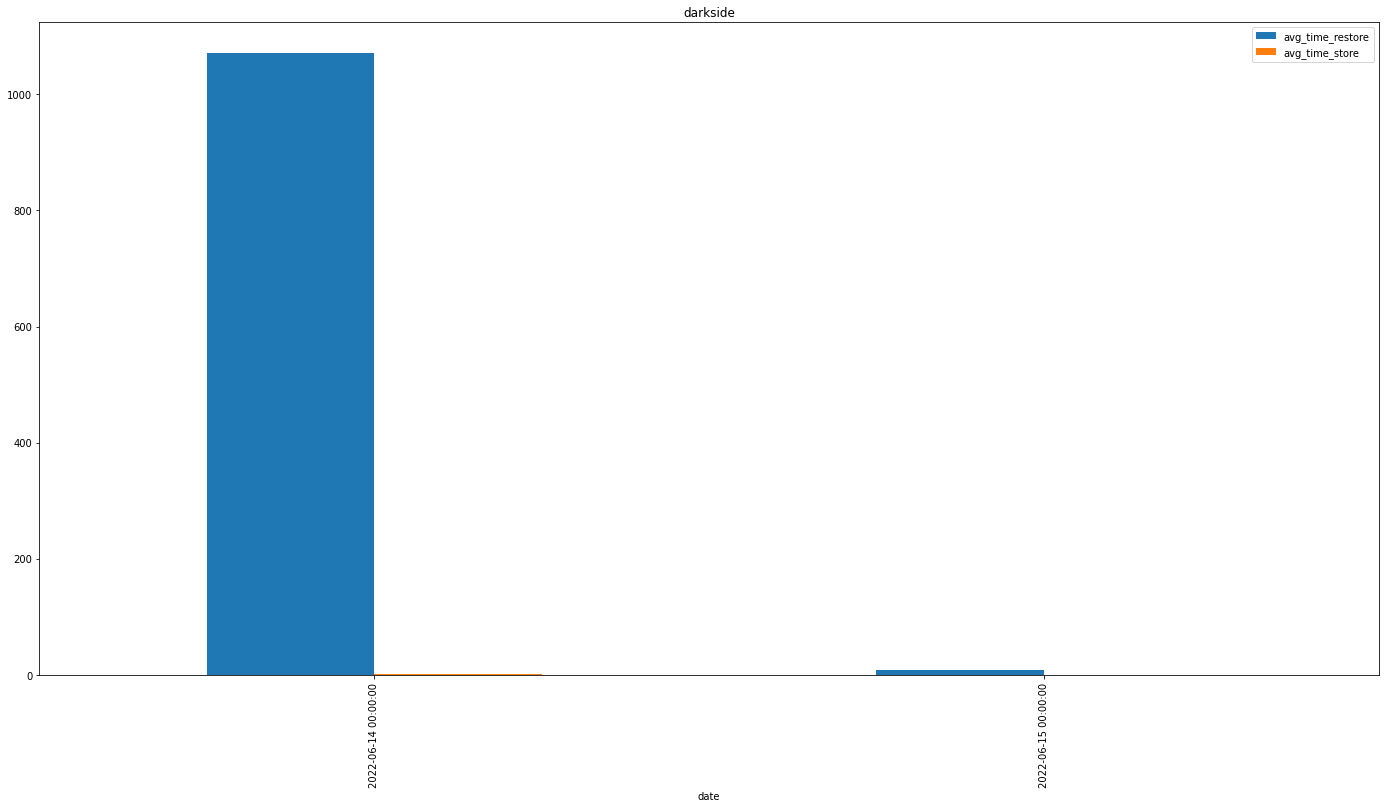

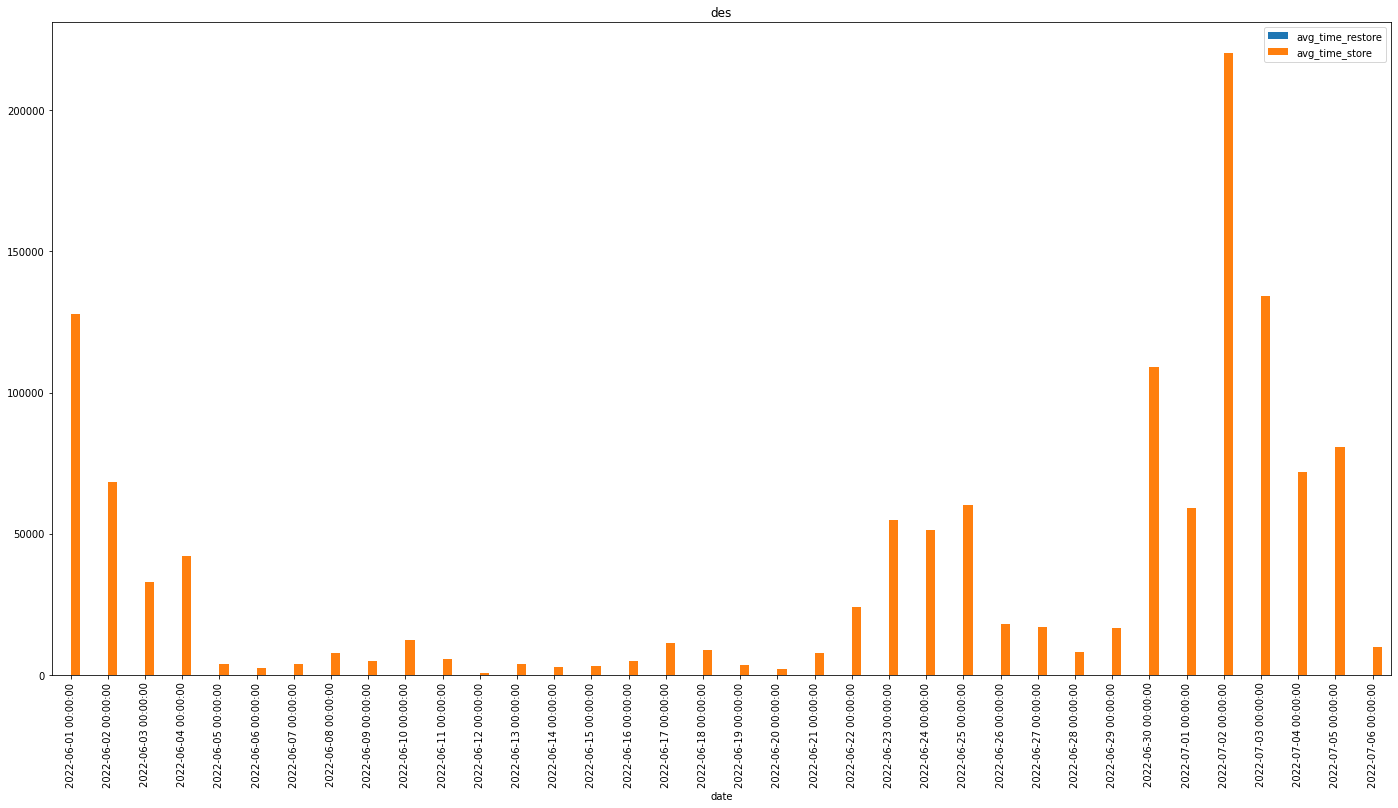

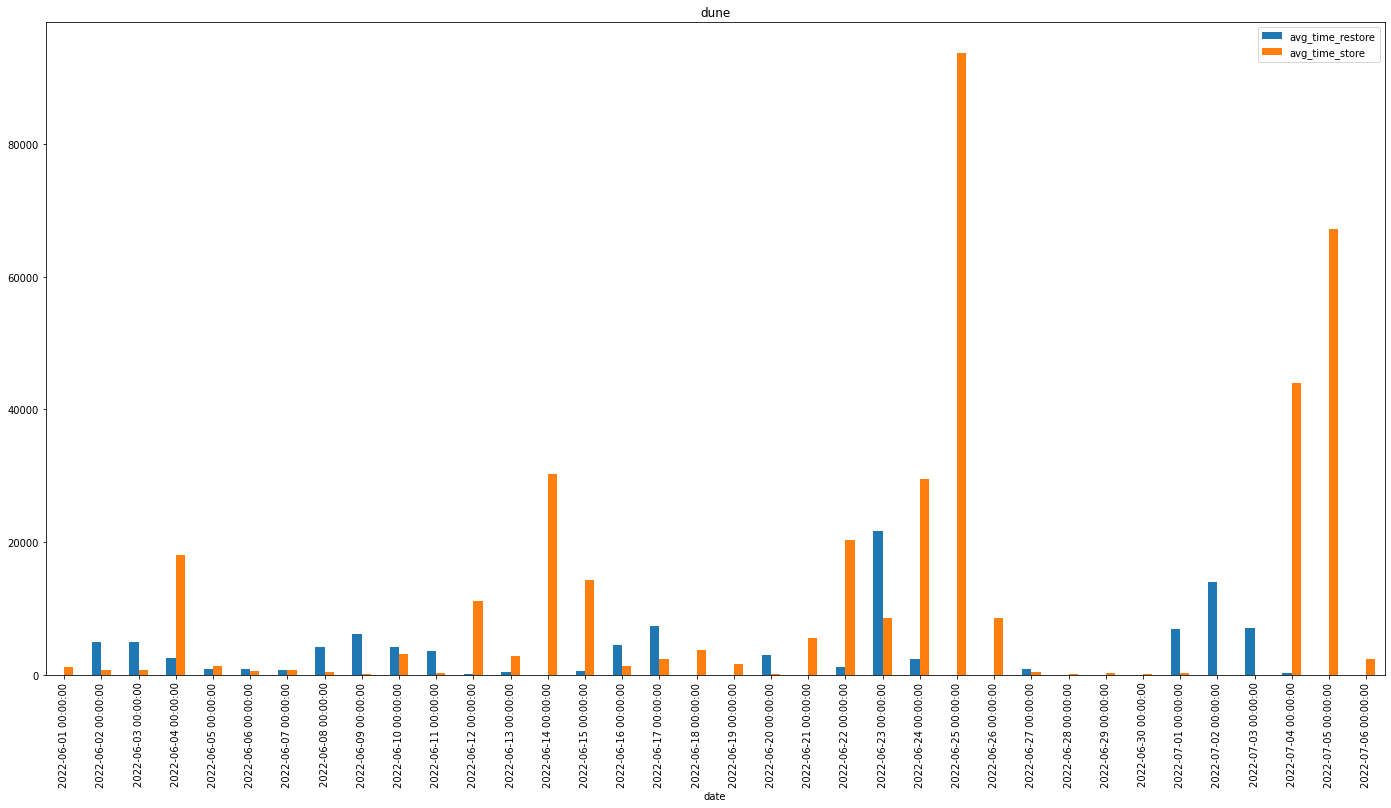

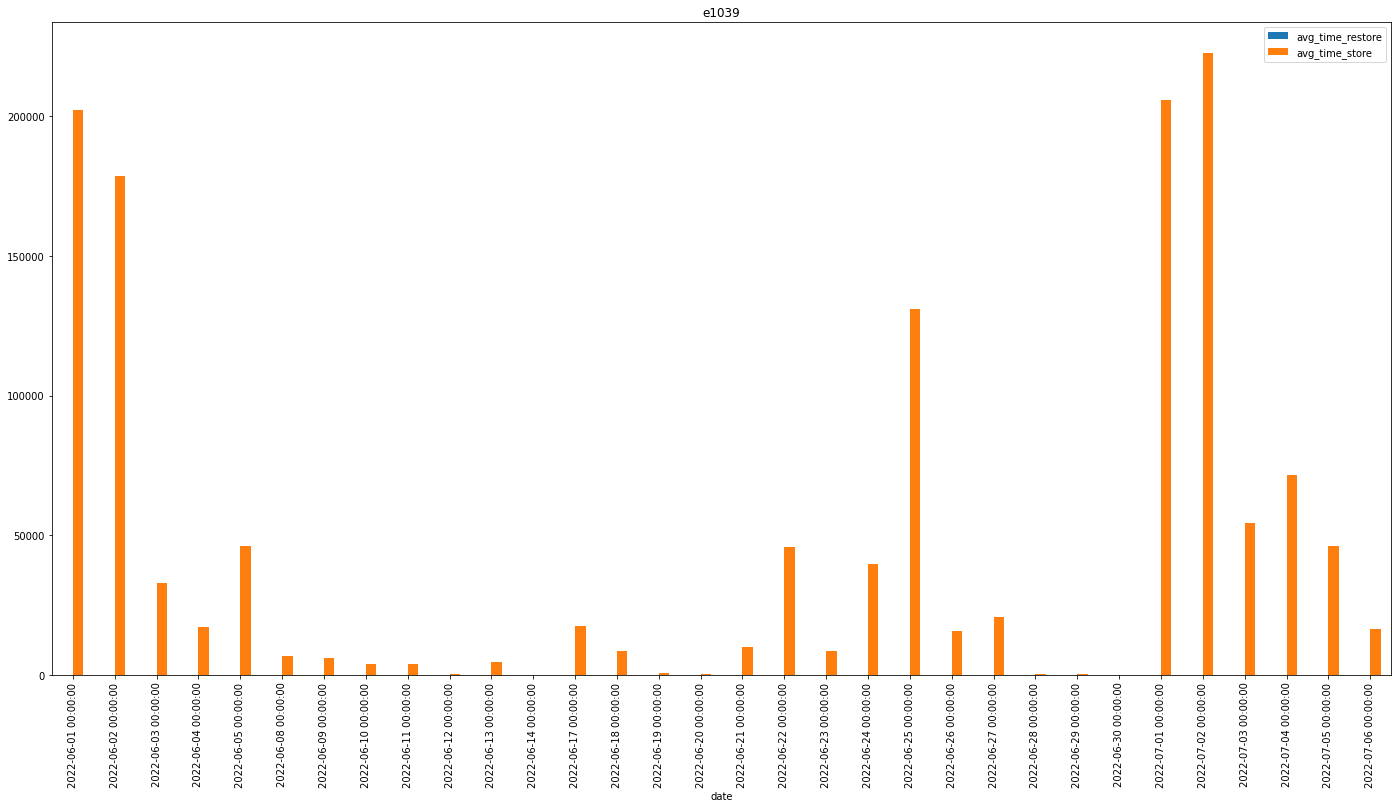

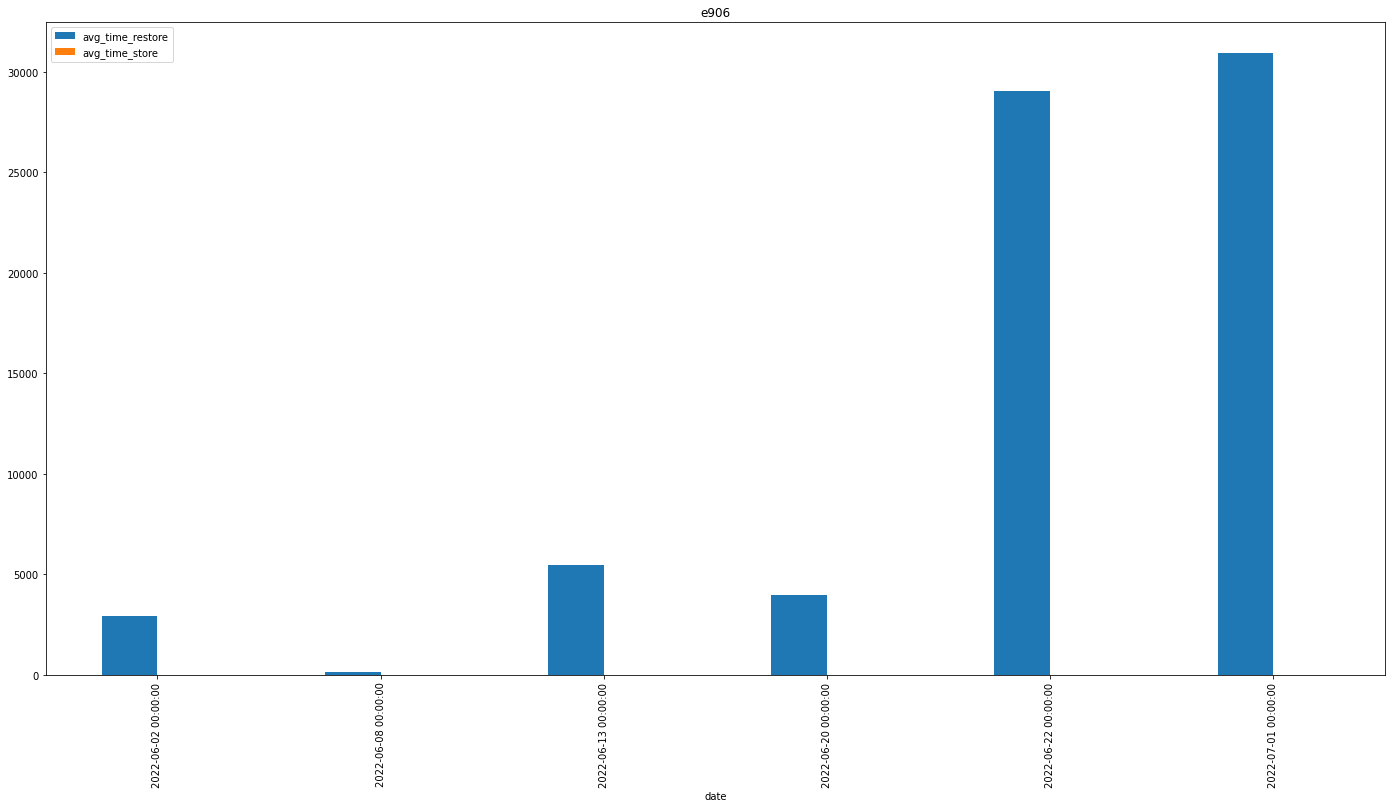

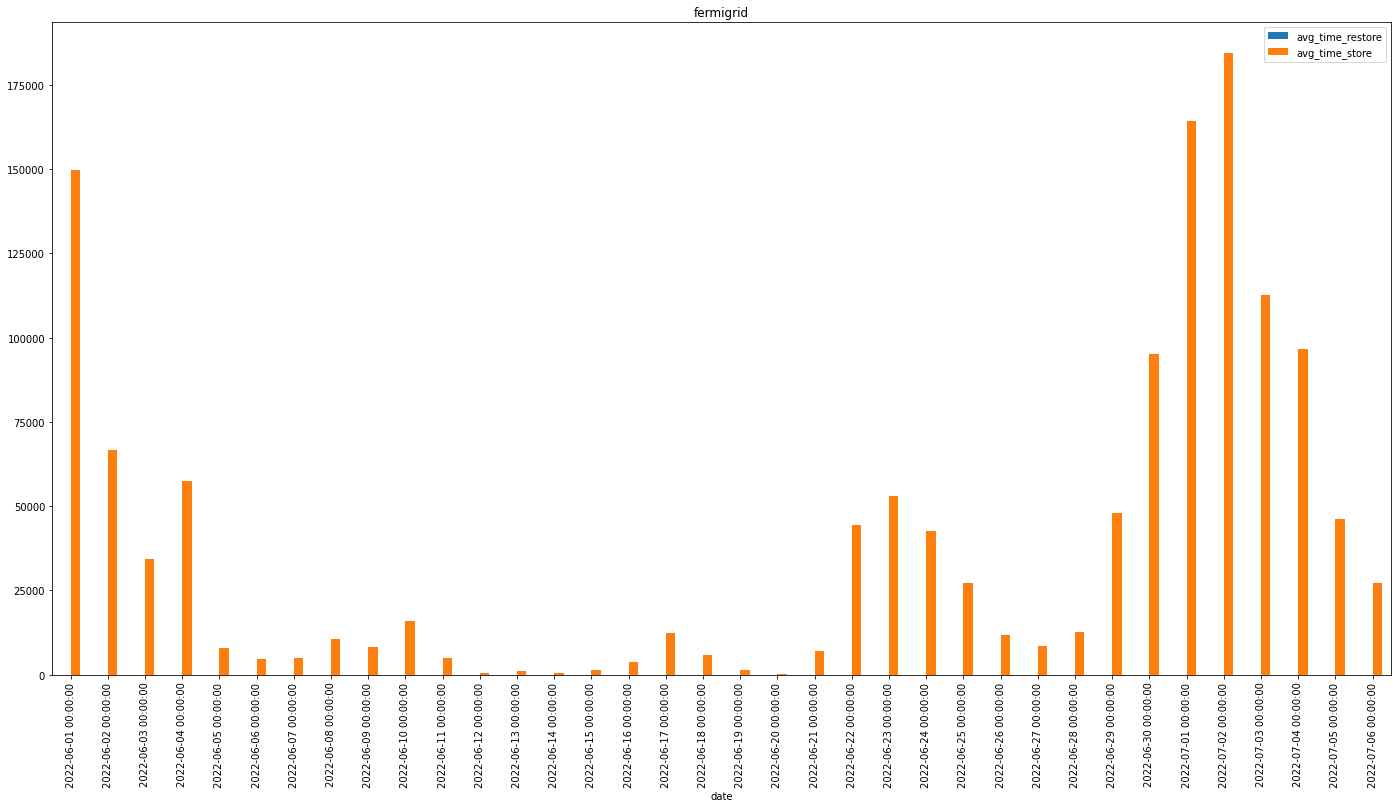

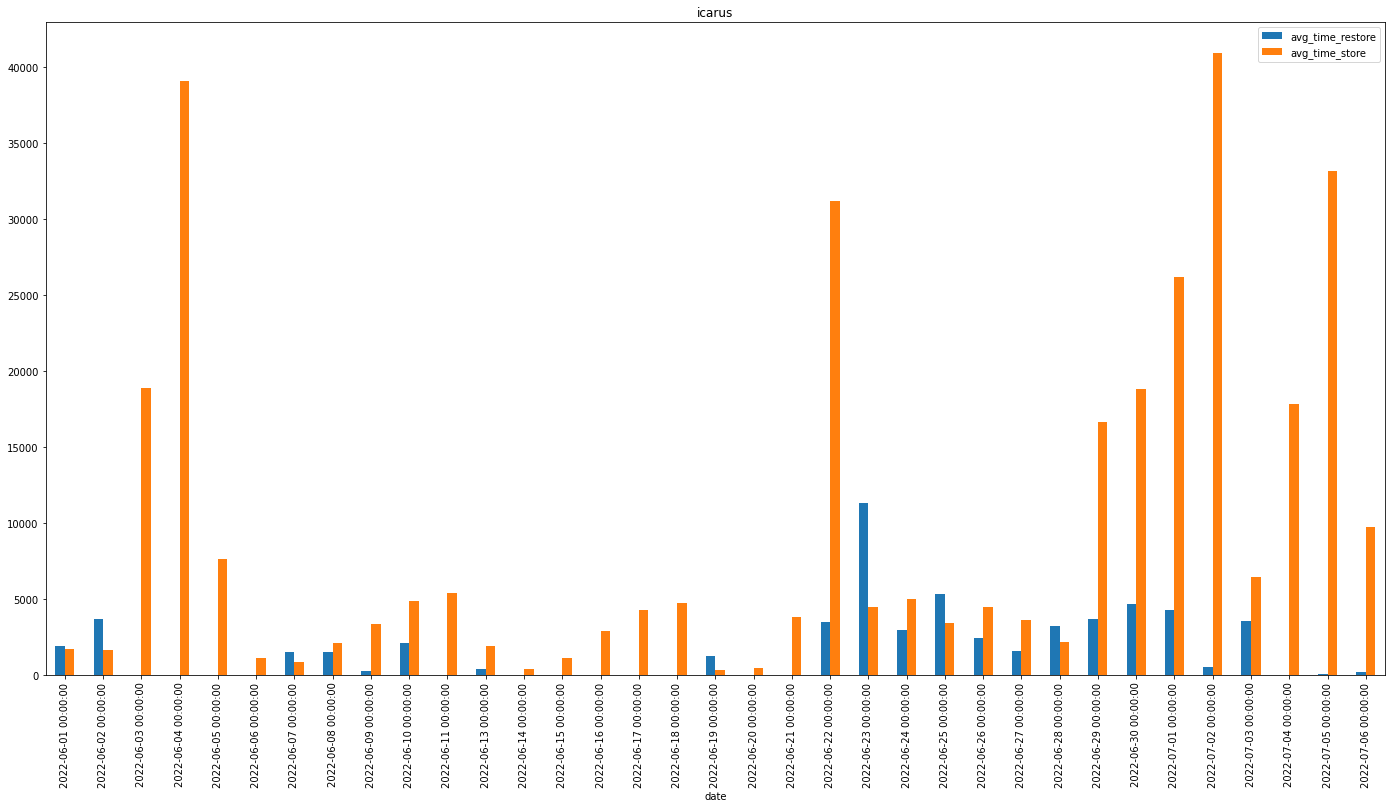

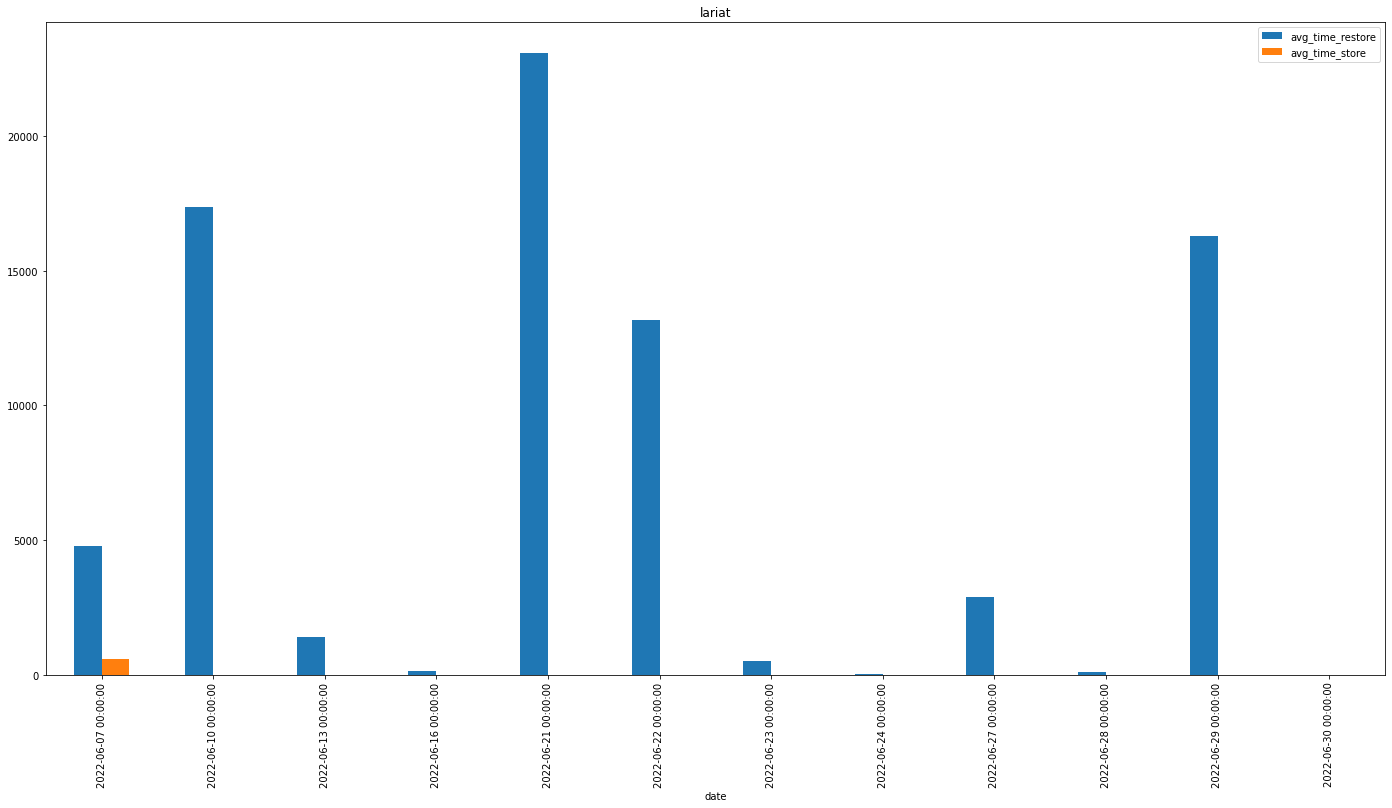

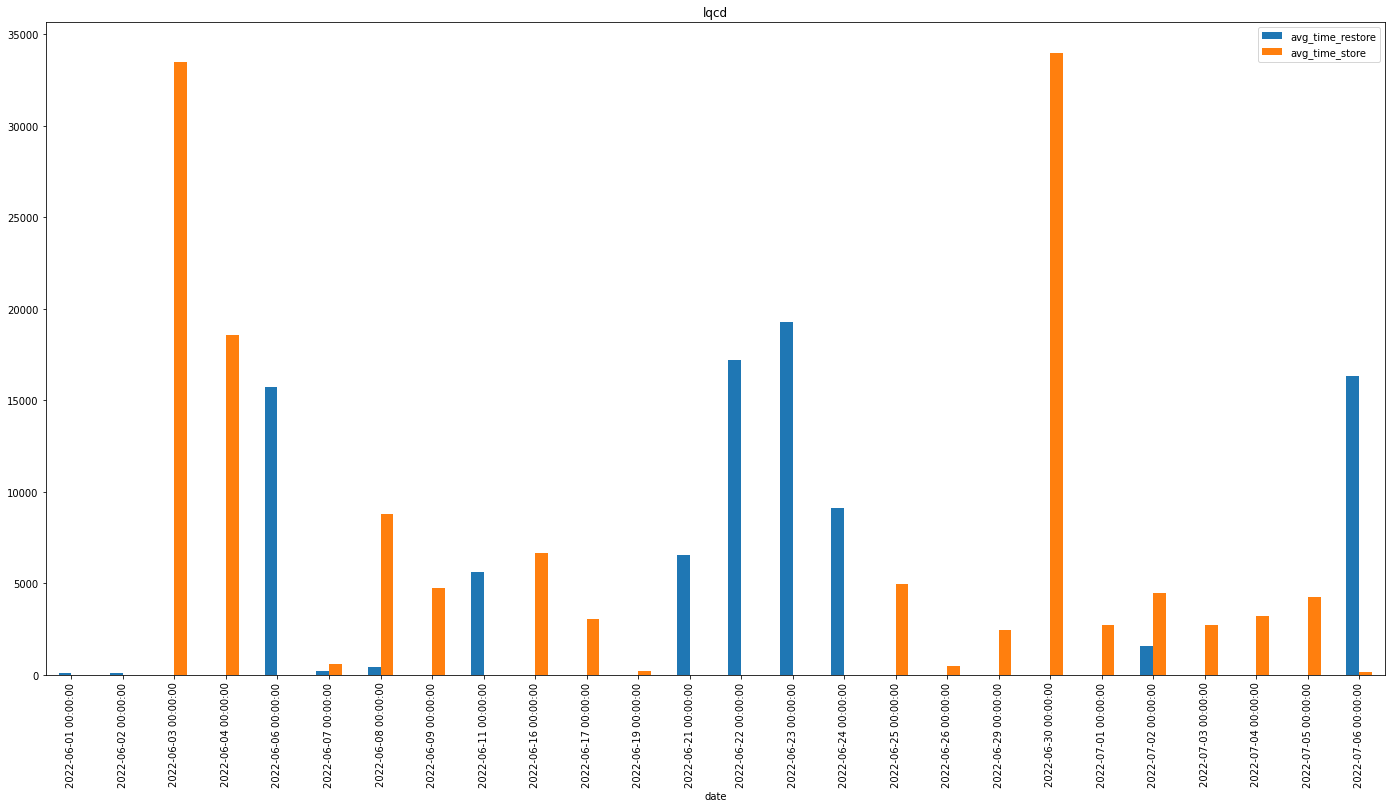

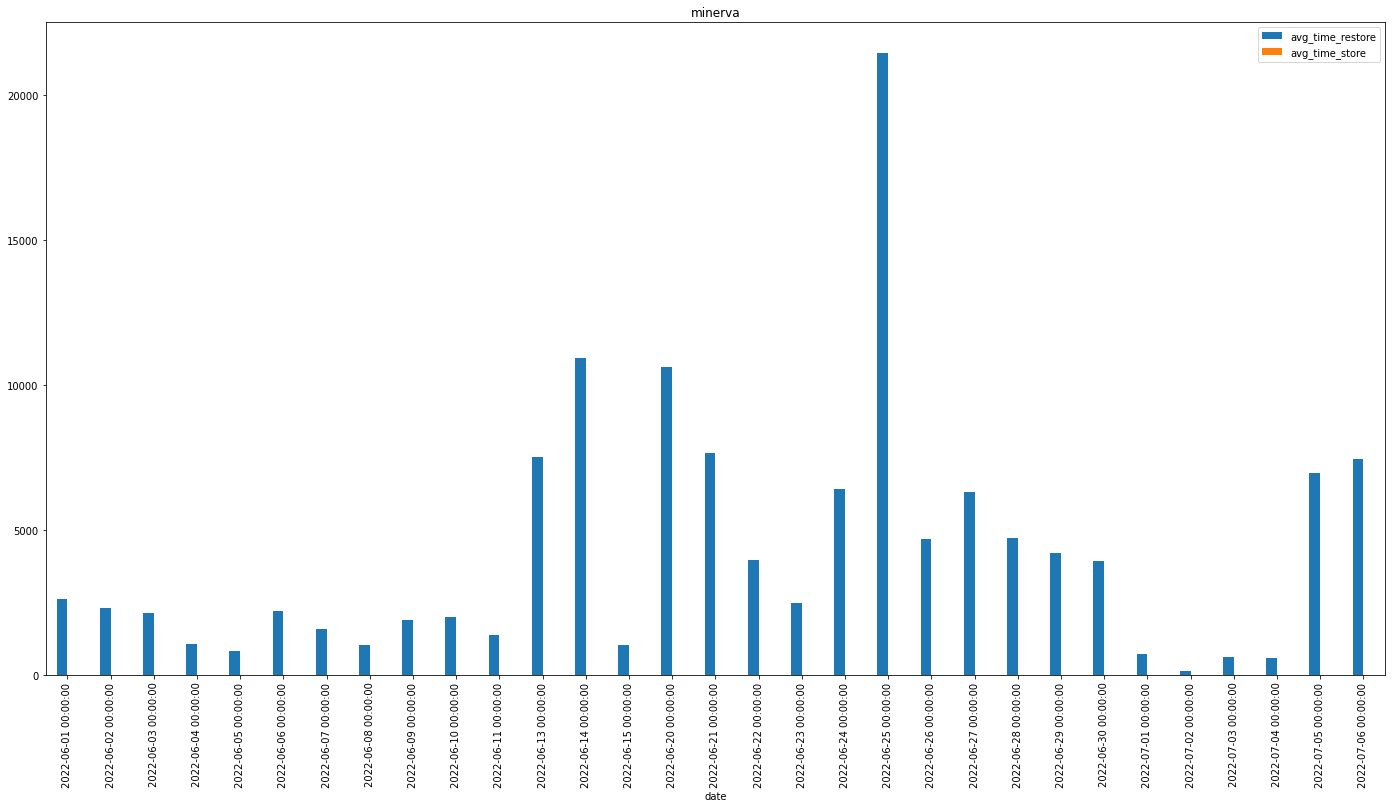

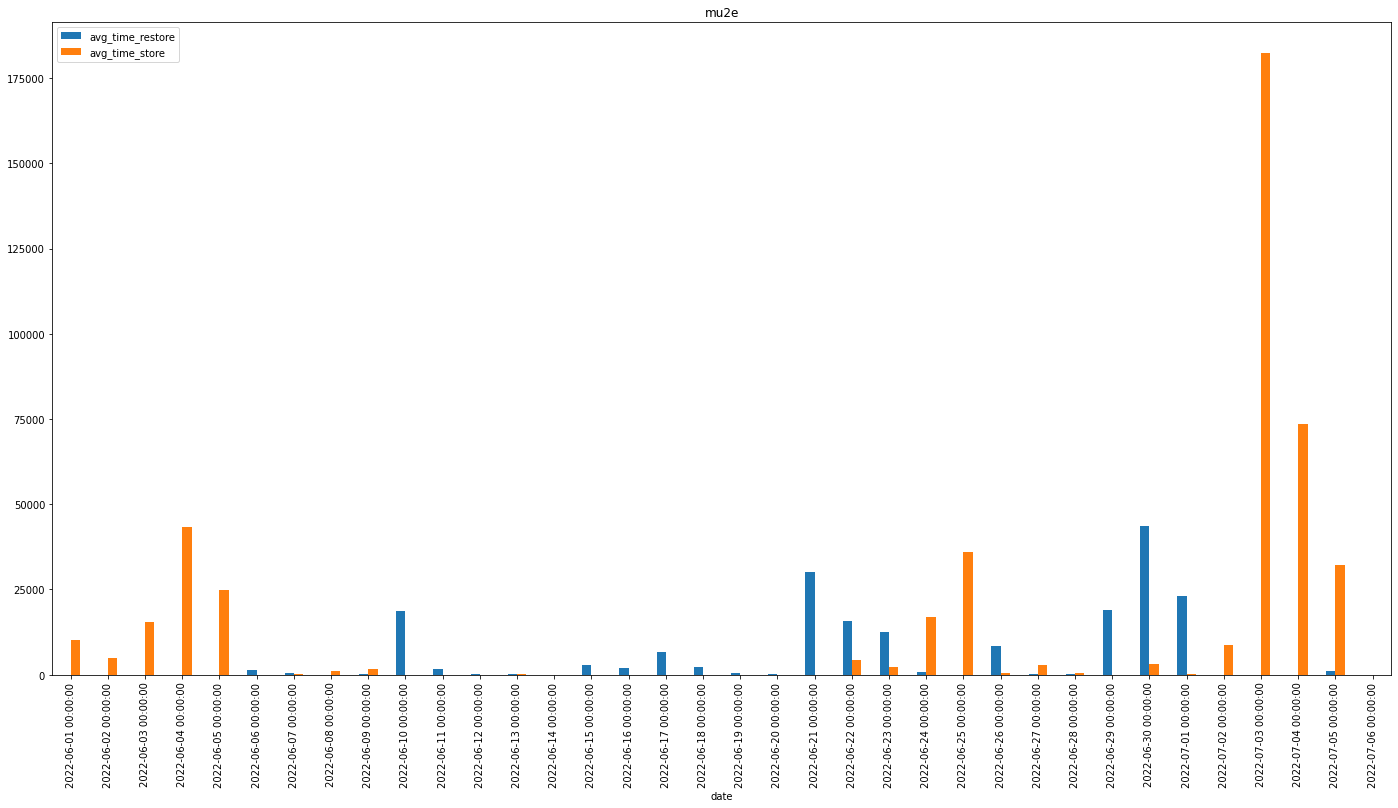

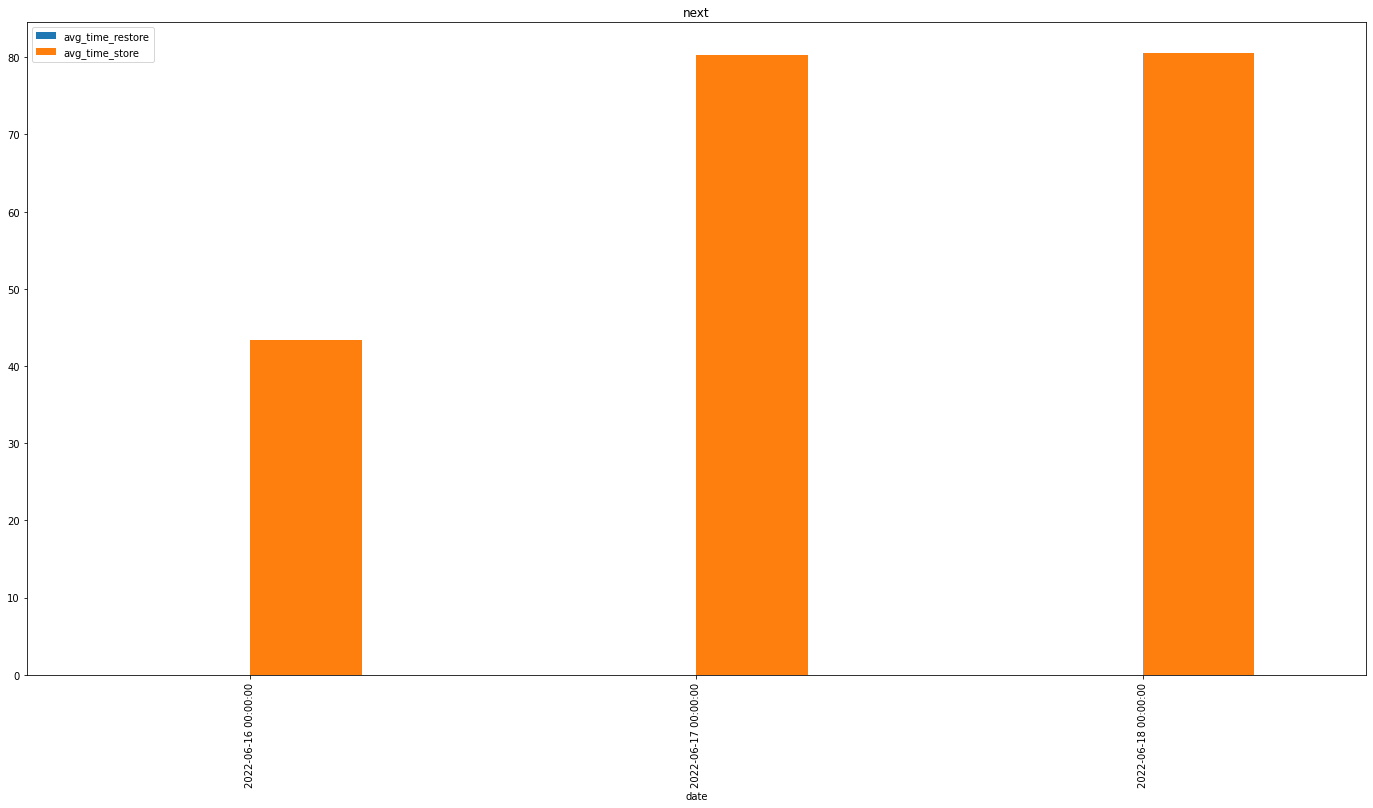

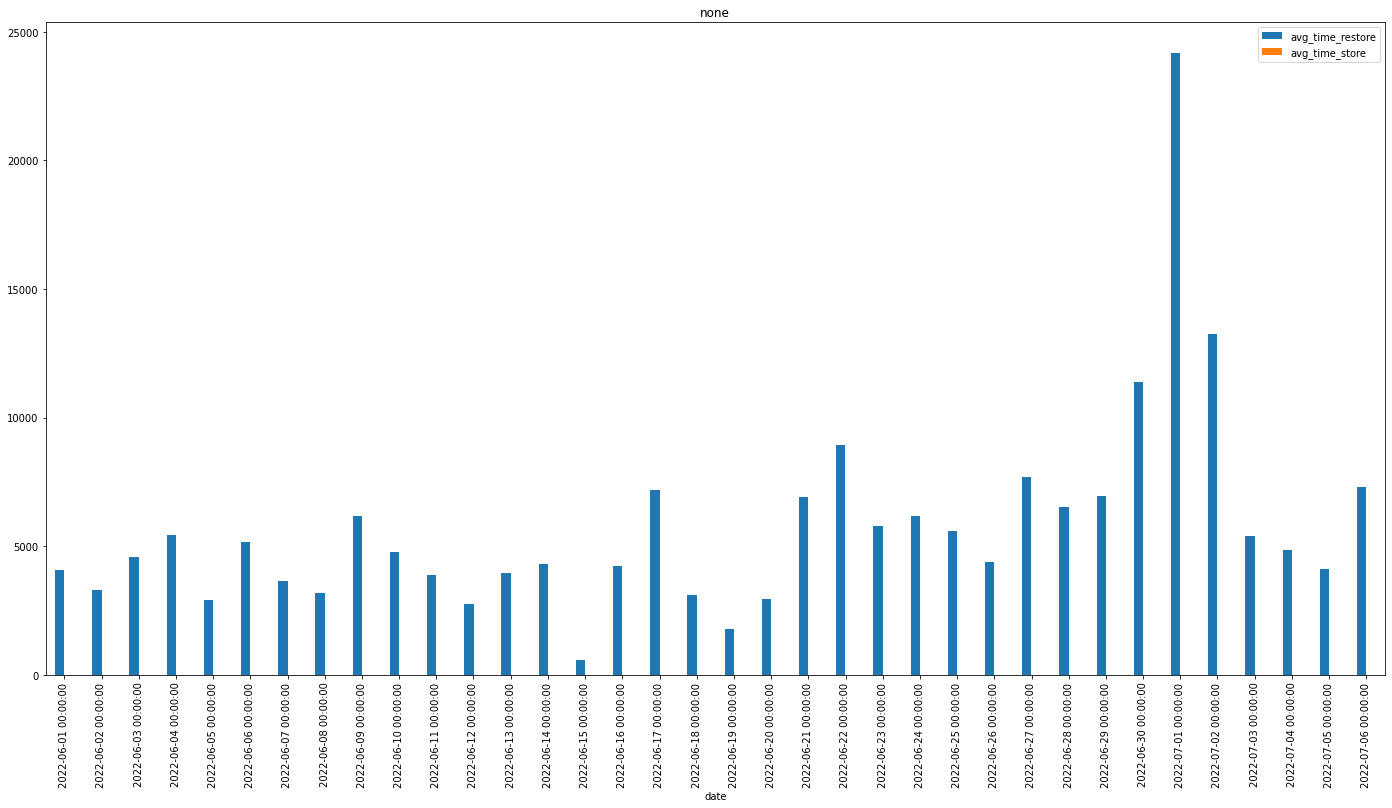

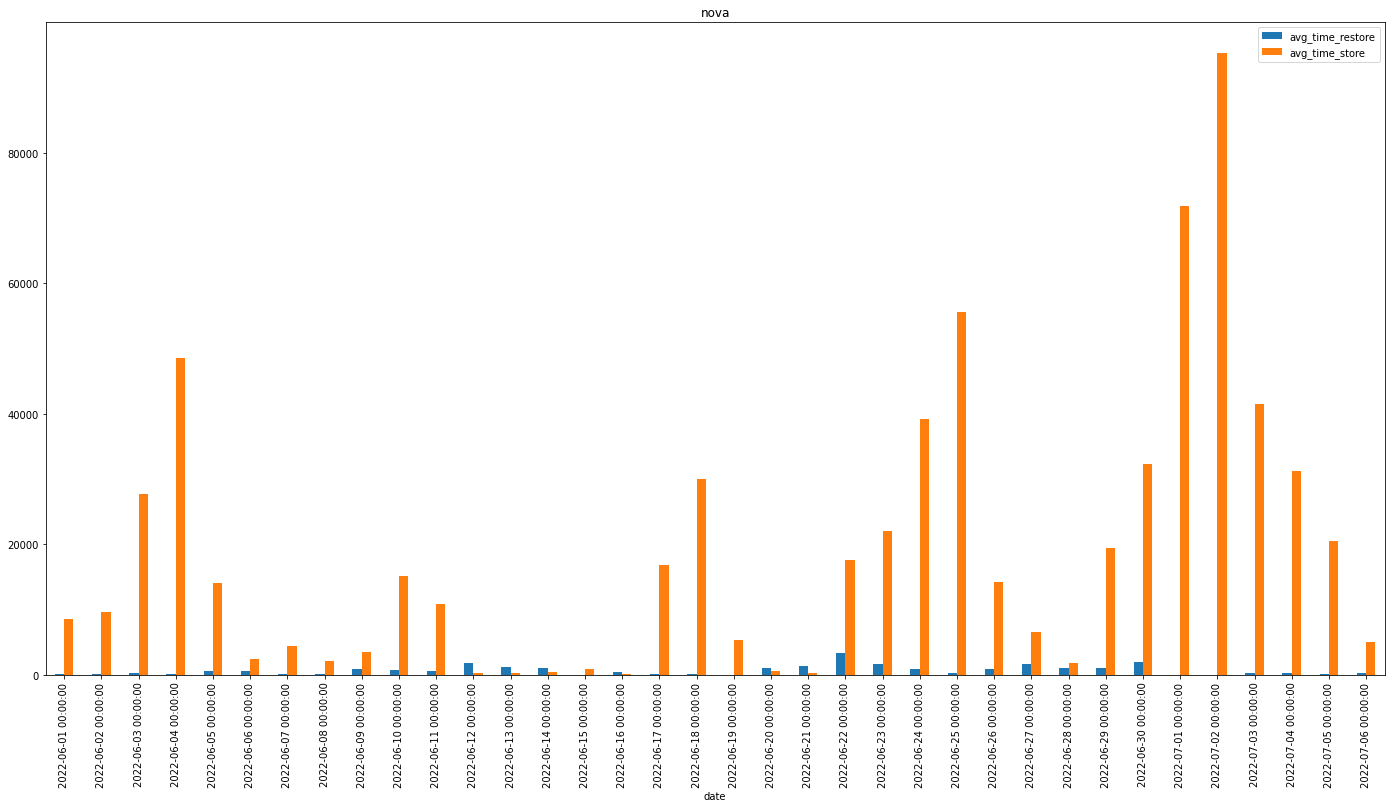

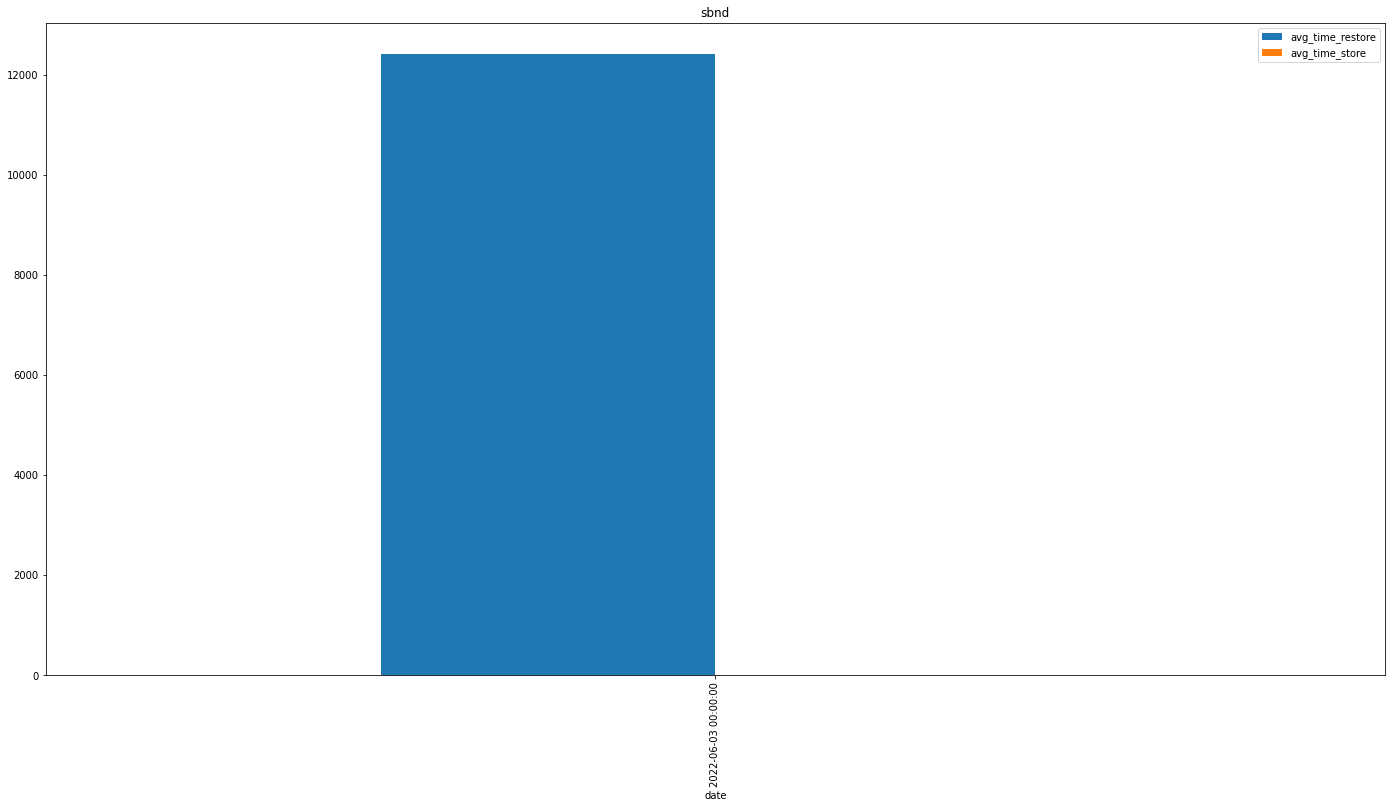

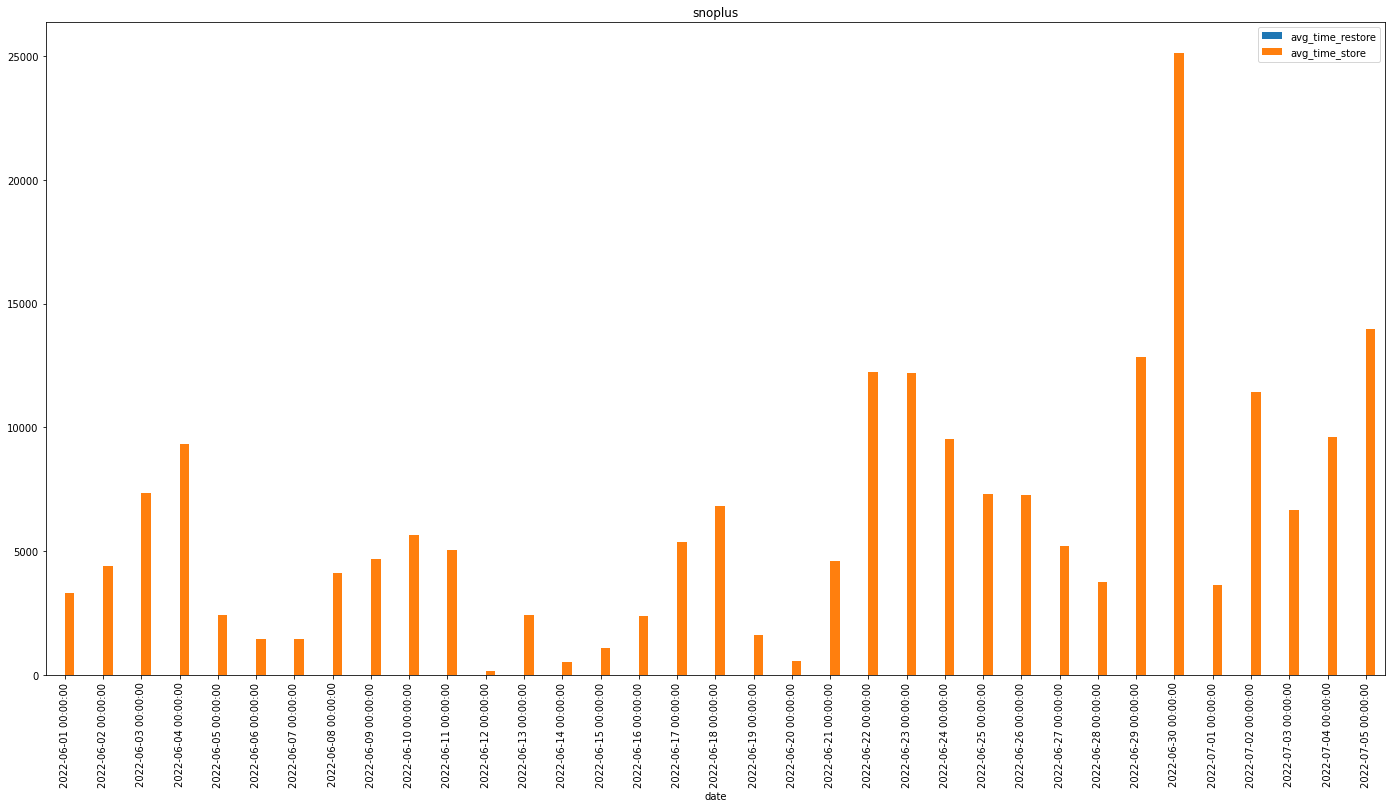

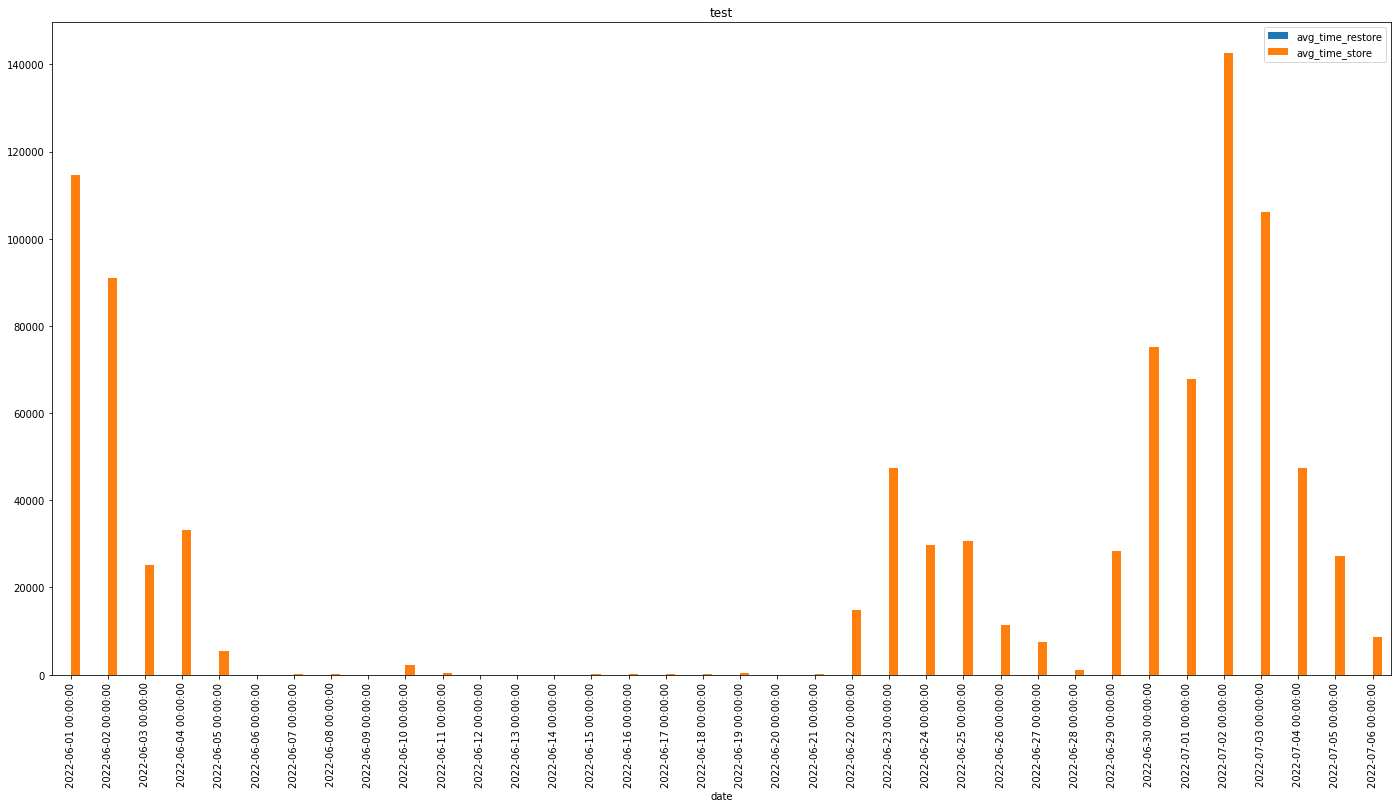

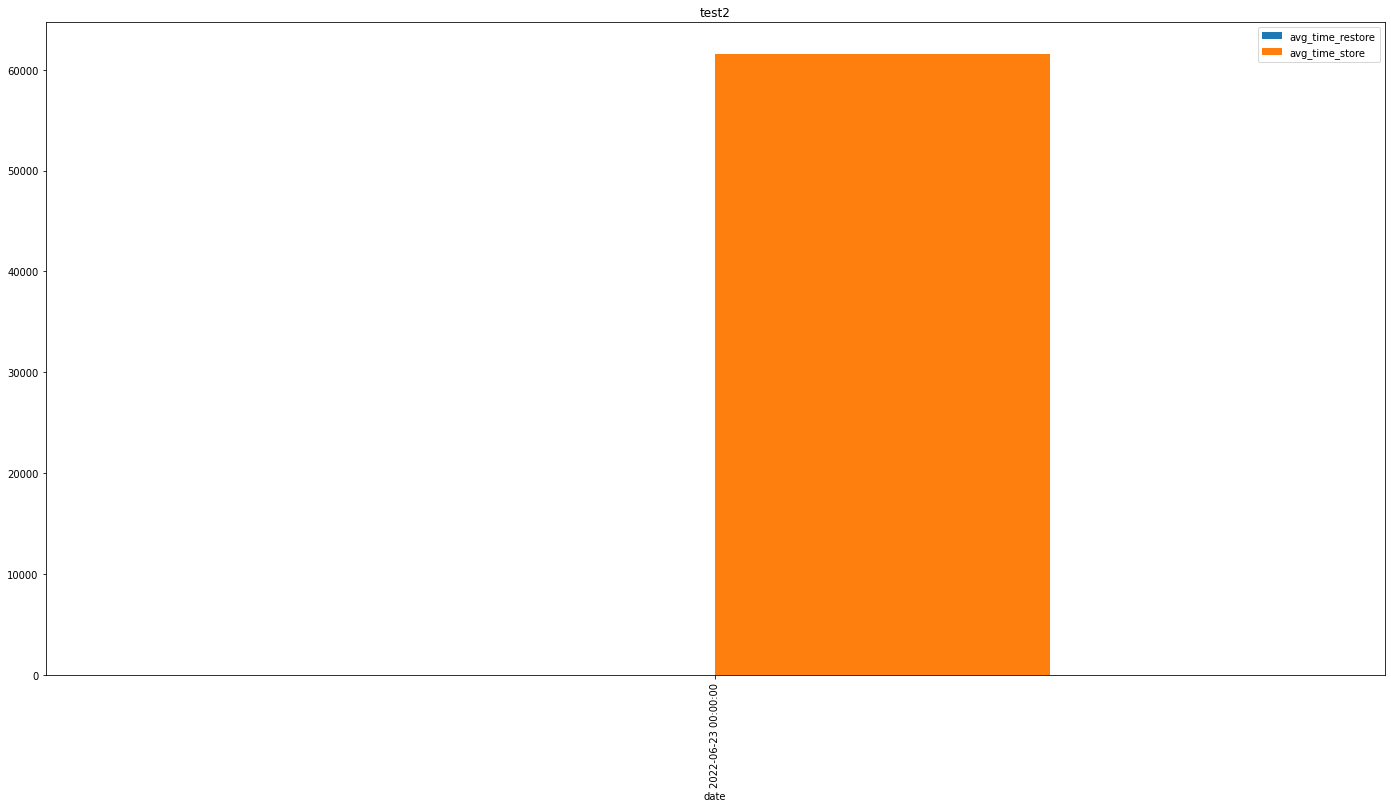

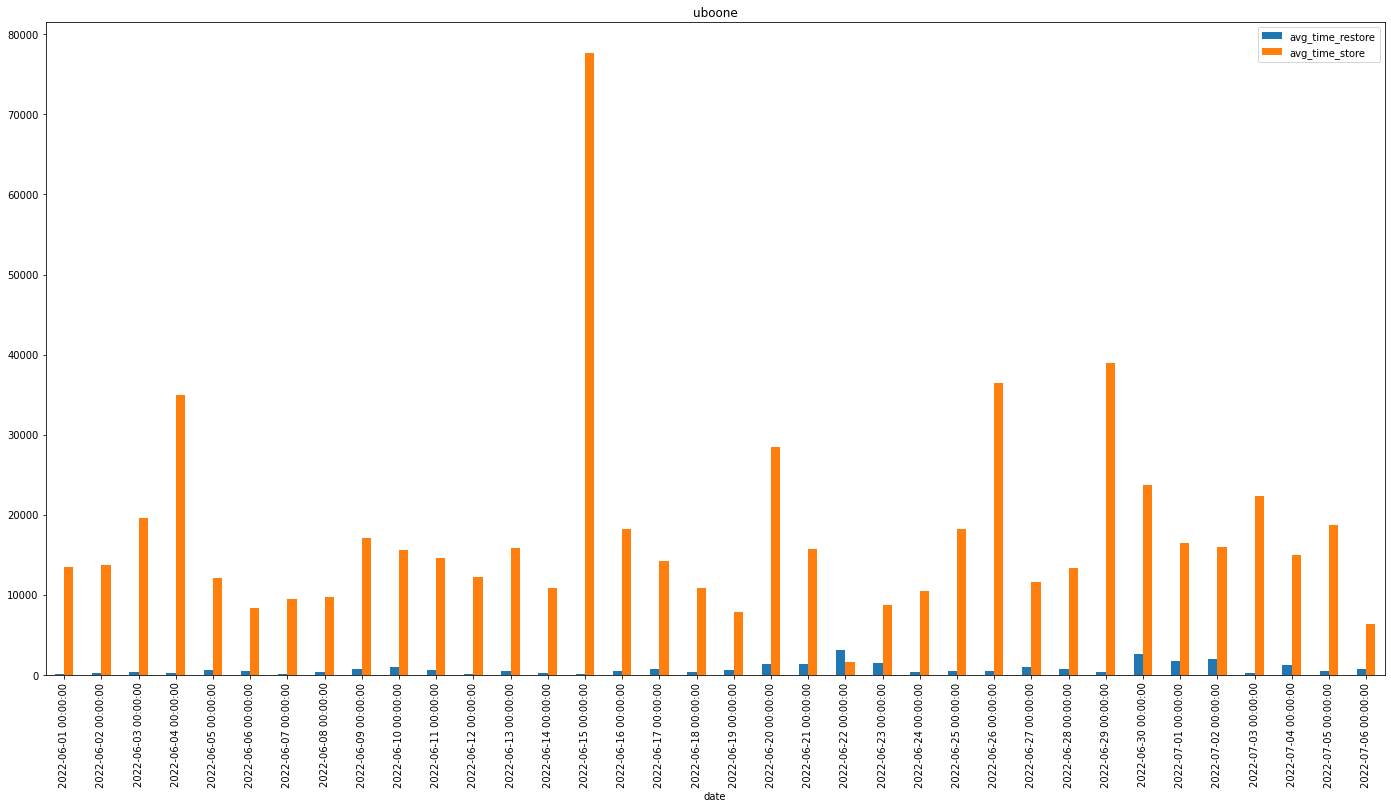

In [51]:
for vo, group in d.groupby('vo'):
    group.plot.bar( x= 'date', title=vo, figsize=(24,12))
    plt.savefig(f'Average_time_restores_store_vs_time_for{vo}.png', bbox_inches='tight')

<AxesSubplot:title={'center':'ADMX'}, xlabel='date'>

<AxesSubplot:title={'center':'GM2'}, xlabel='date'>

<AxesSubplot:title={'center':'Simons'}, xlabel='date'>

<AxesSubplot:title={'center':'accelai'}, xlabel='date'>

<AxesSubplot:title={'center':'annie'}, xlabel='date'>

<AxesSubplot:title={'center':'backups'}, xlabel='date'>

<AxesSubplot:title={'center':'d0'}, xlabel='date'>

<AxesSubplot:title={'center':'damic'}, xlabel='date'>

<AxesSubplot:title={'center':'darkside'}, xlabel='date'>

<AxesSubplot:title={'center':'des'}, xlabel='date'>

<AxesSubplot:title={'center':'dune'}, xlabel='date'>

<AxesSubplot:title={'center':'e1039'}, xlabel='date'>

<AxesSubplot:title={'center':'e906'}, xlabel='date'>

<AxesSubplot:title={'center':'fermigrid'}, xlabel='date'>

<AxesSubplot:title={'center':'icarus'}, xlabel='date'>

<AxesSubplot:title={'center':'lariat'}, xlabel='date'>

<AxesSubplot:title={'center':'lqcd'}, xlabel='date'>

<AxesSubplot:title={'center':'minerva'}, xlabel='date'>

<AxesSubplot:title={'center':'minos'}, xlabel='date'>

<AxesSubplot:title={'center':'mu2e'}, xlabel='date'>

/usr/local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<AxesSubplot:title={'center':'netflow'}, xlabel='date'>

<AxesSubplot:title={'center':'next'}, xlabel='date'>

<AxesSubplot:title={'center':'none'}, xlabel='date'>

<AxesSubplot:title={'center':'nova'}, xlabel='date'>

<AxesSubplot:title={'center':'numix'}, xlabel='date'>

<AxesSubplot:title={'center':'sbnd'}, xlabel='date'>

<AxesSubplot:title={'center':'scope'}, xlabel='date'>

<AxesSubplot:title={'center':'snoplus'}, xlabel='date'>

<AxesSubplot:title={'center':'test'}, xlabel='date'>

<AxesSubplot:title={'center':'test2'}, xlabel='date'>

<AxesSubplot:title={'center':'uboone'}, xlabel='date'>

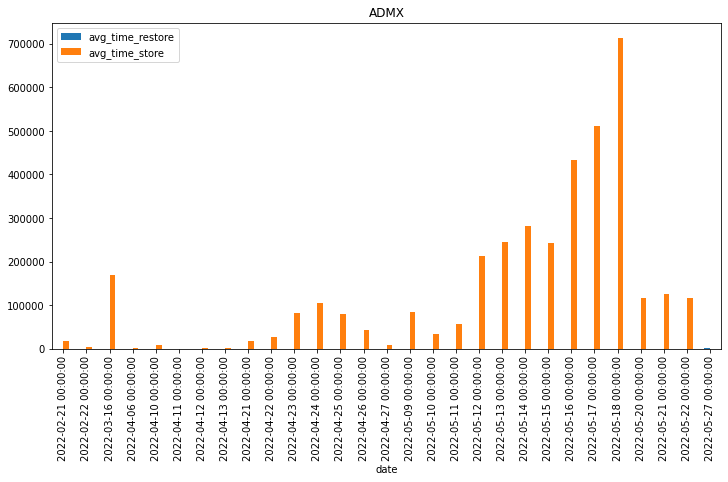

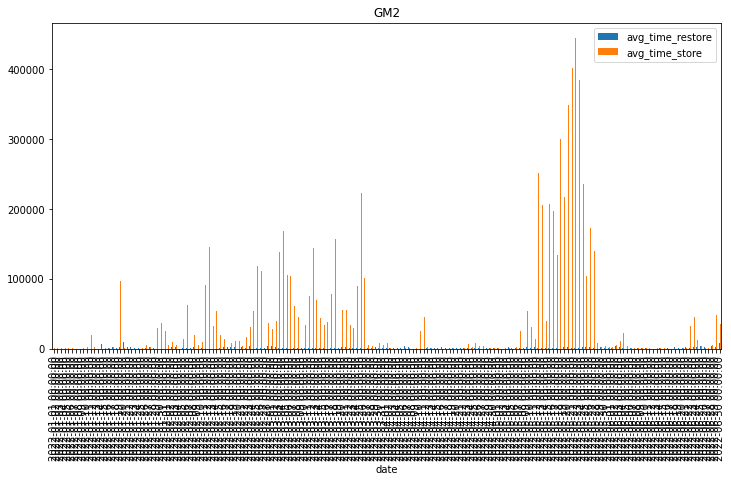

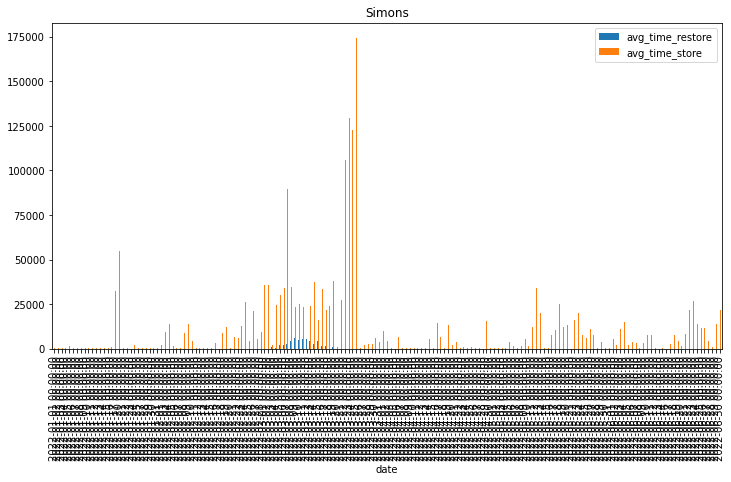

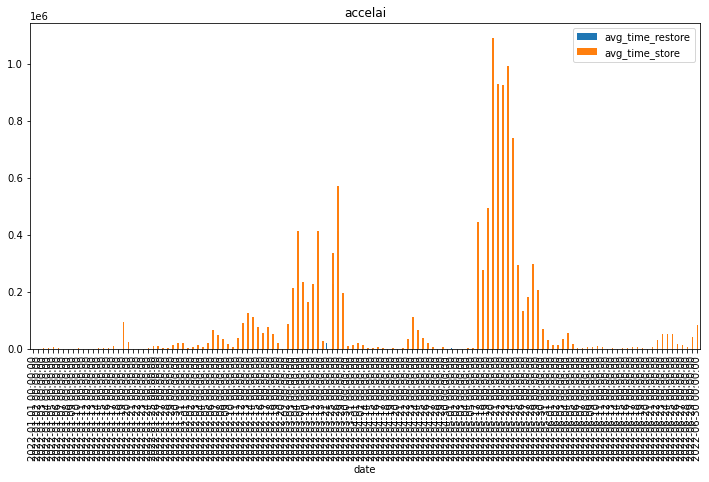

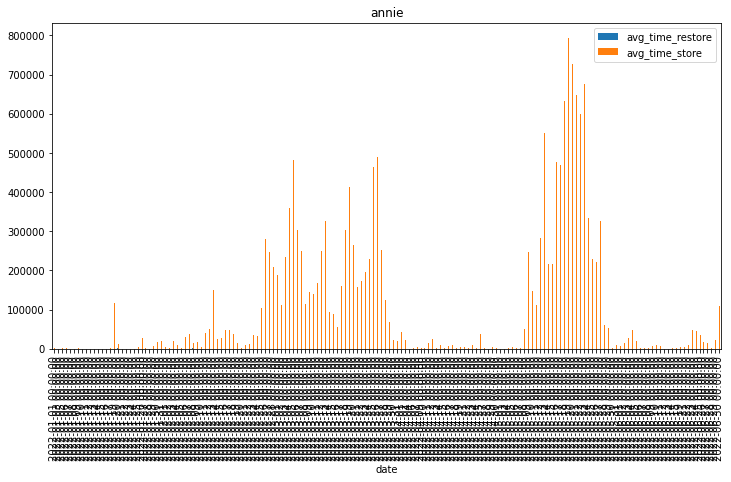

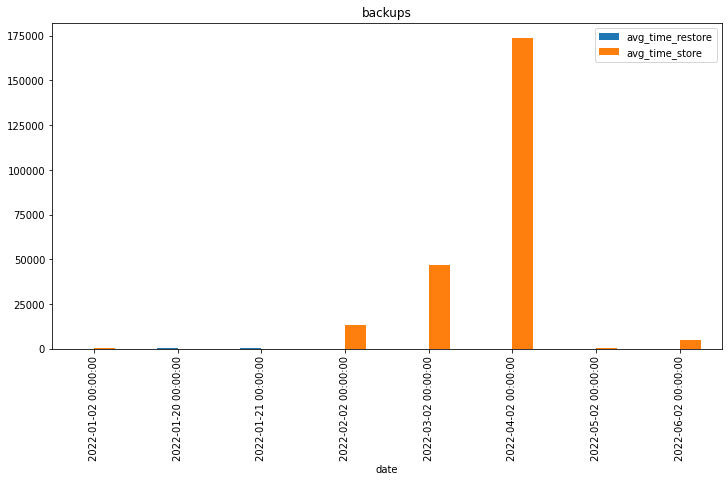

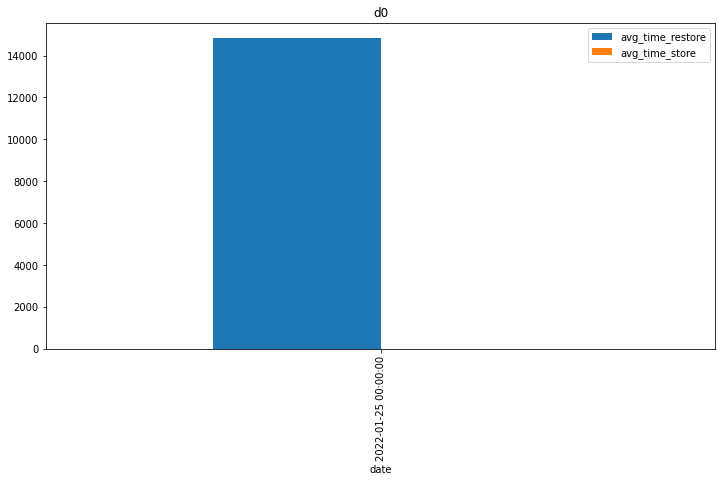

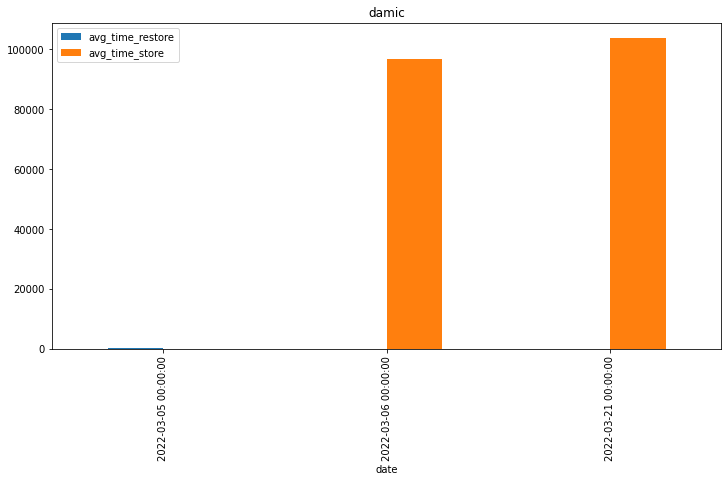

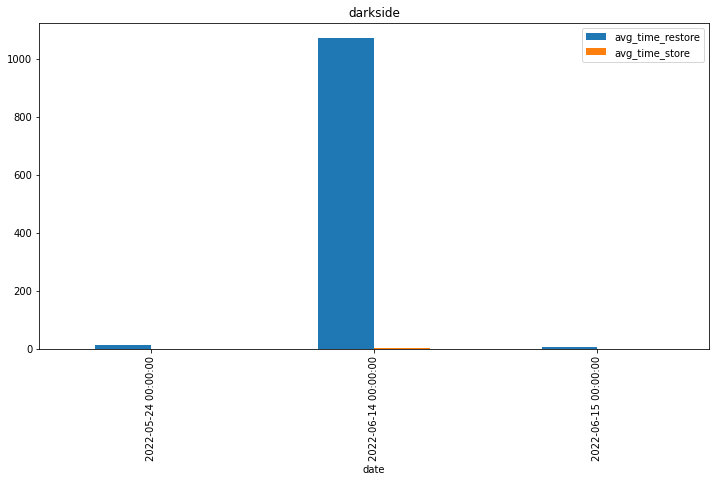

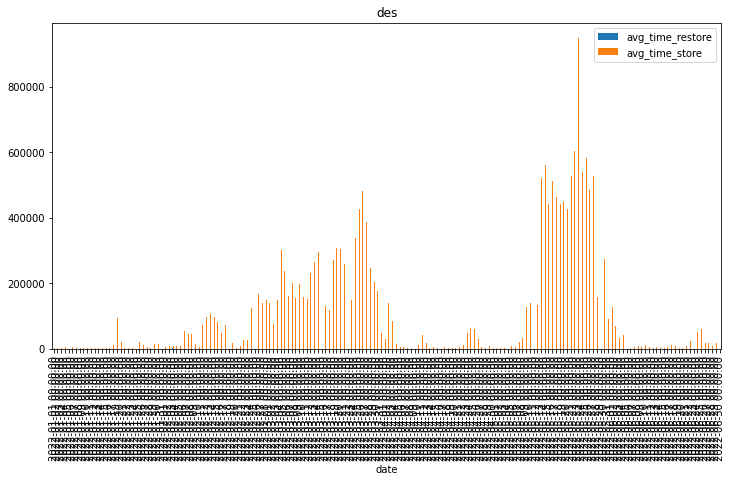

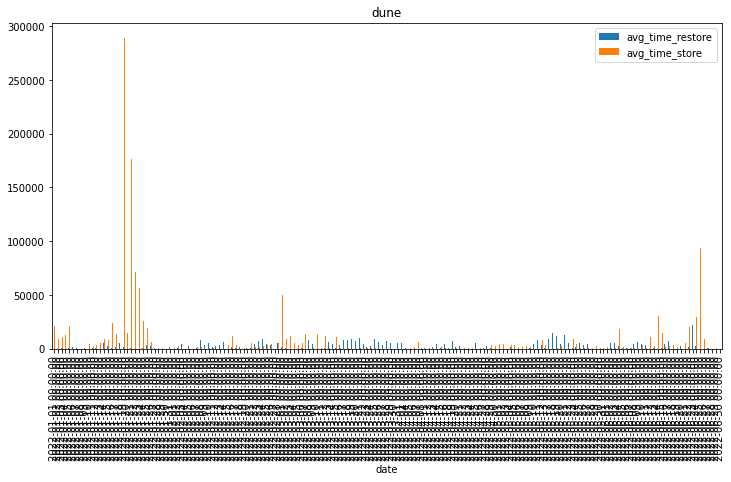

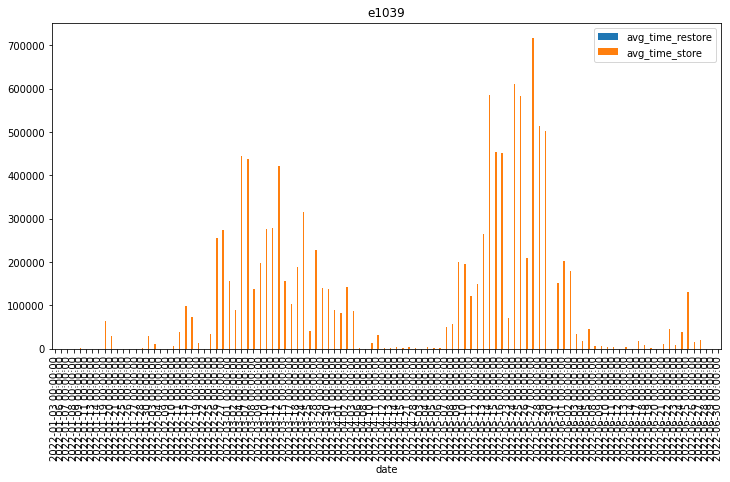

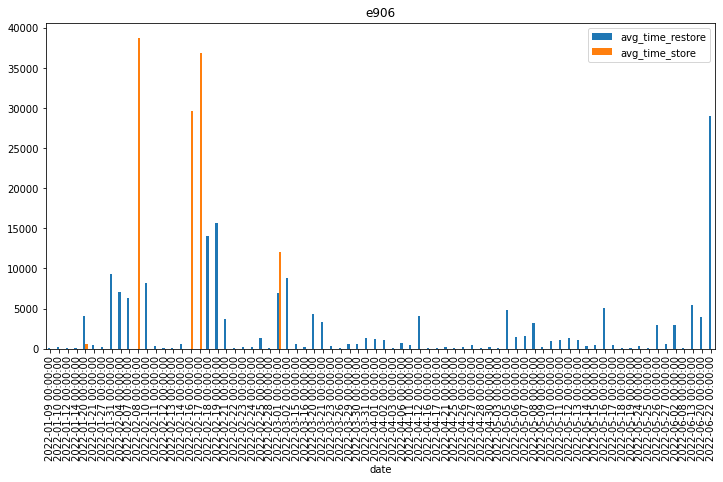

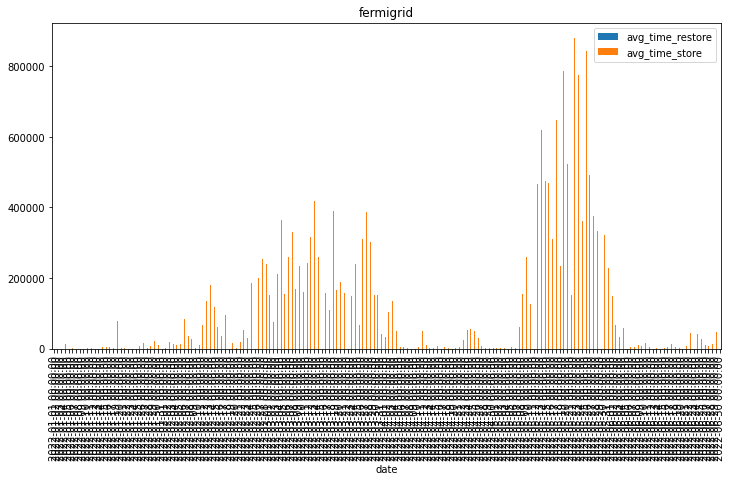

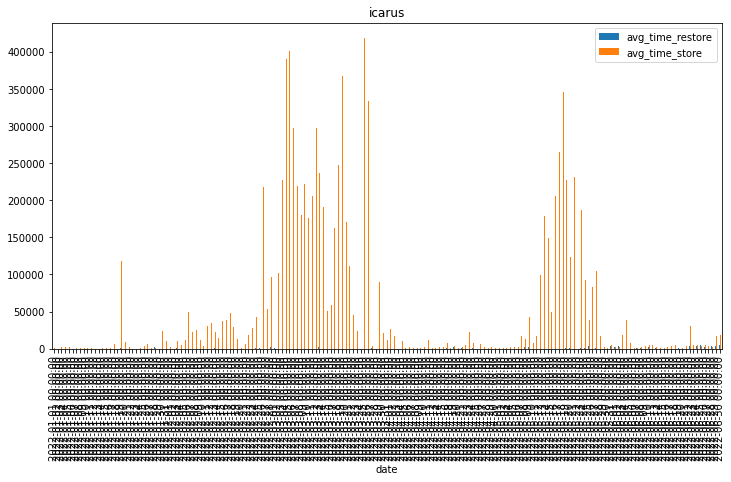

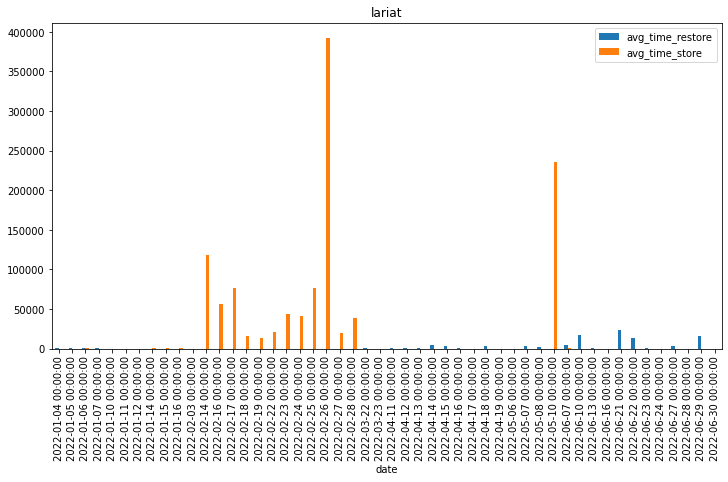

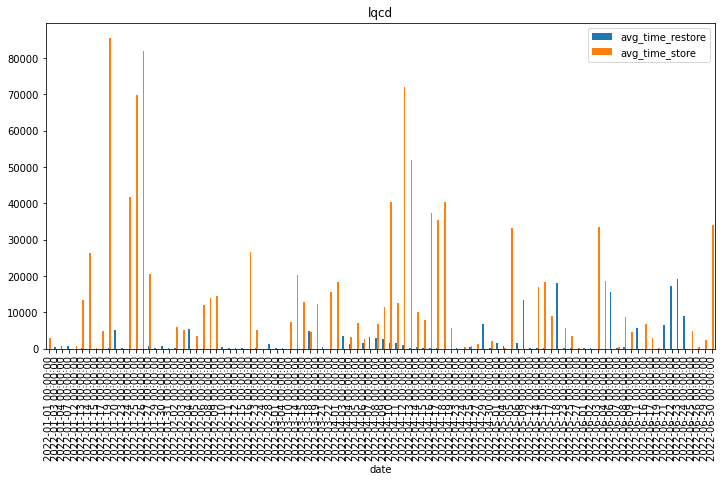

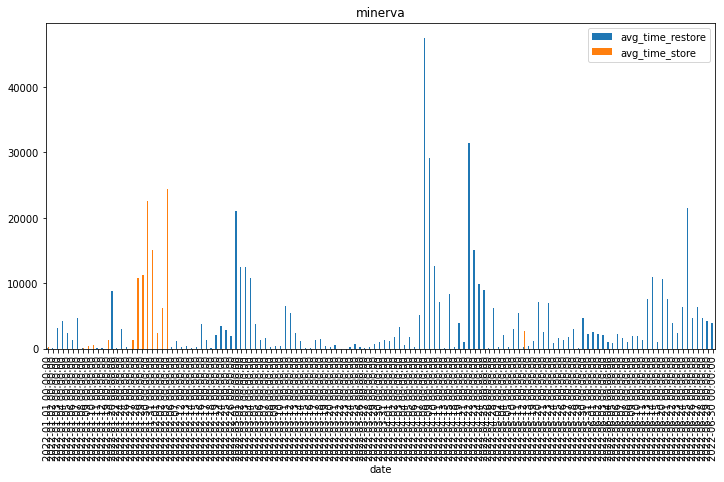

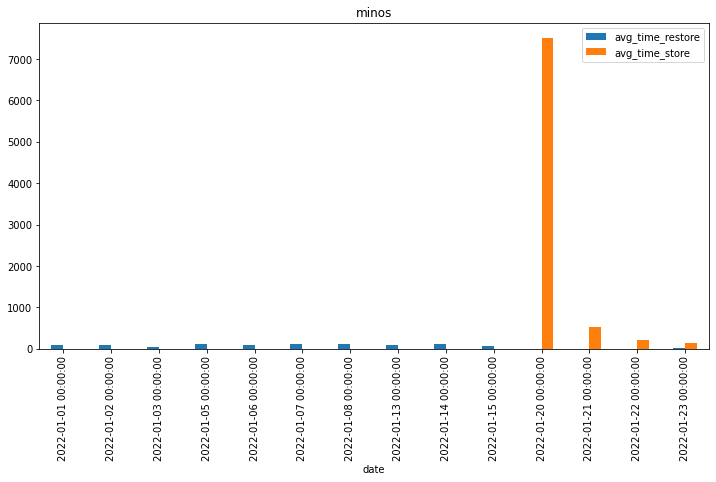

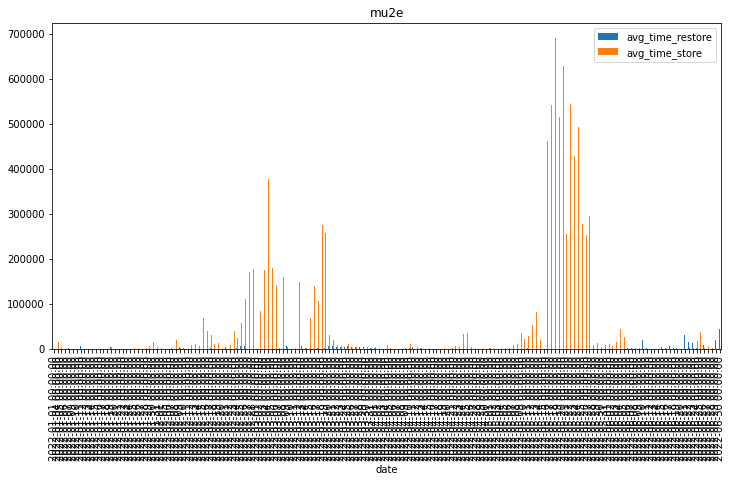

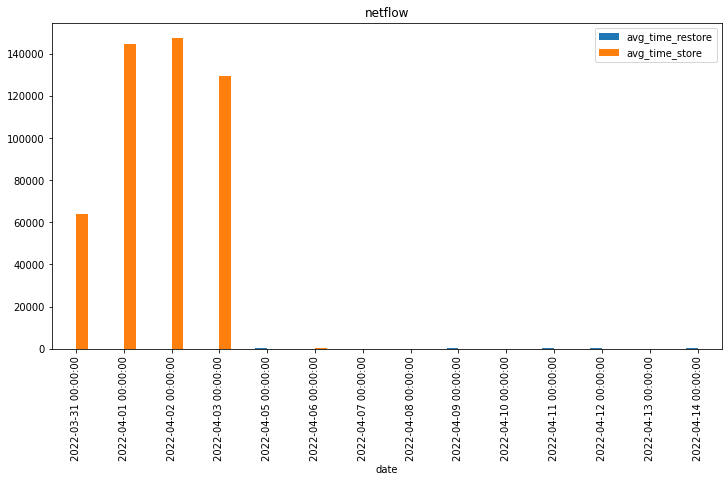

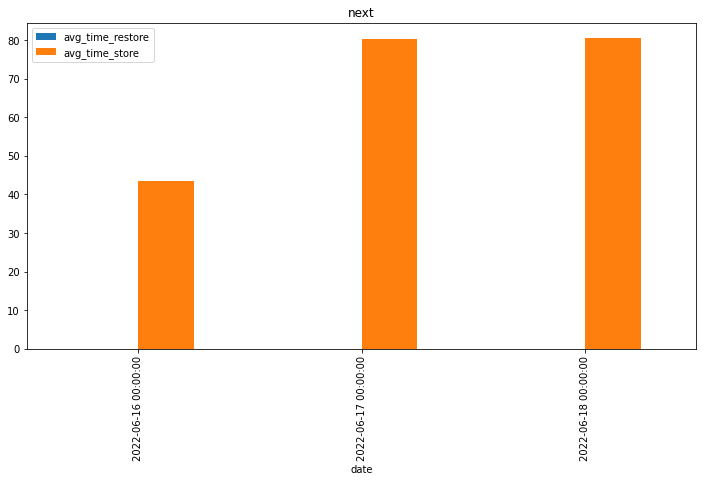

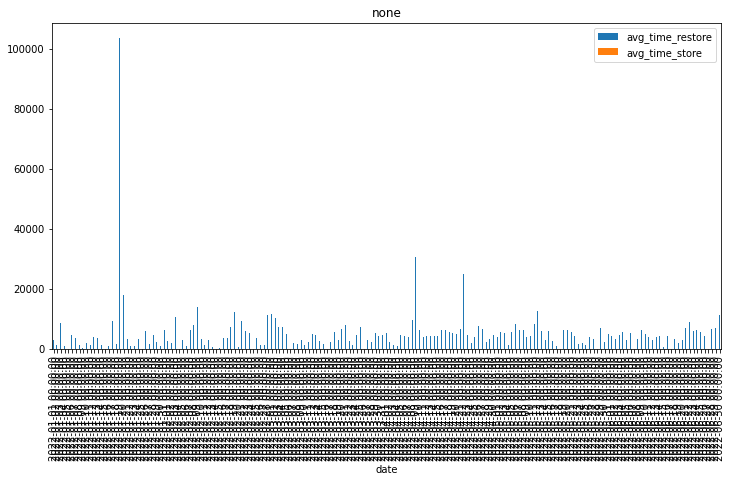

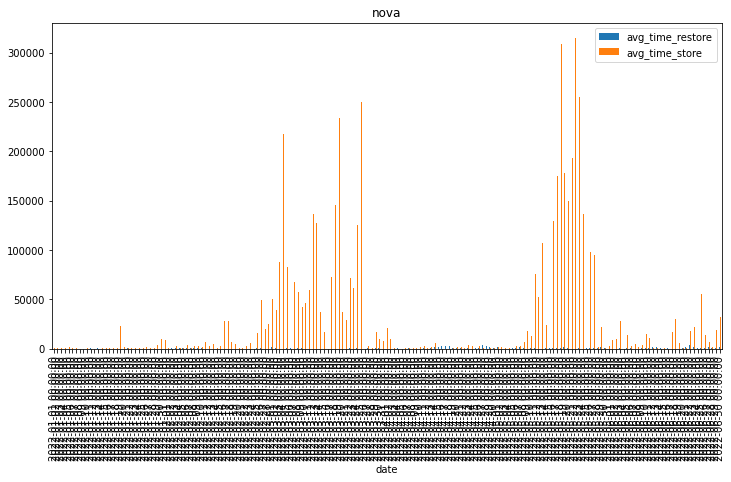

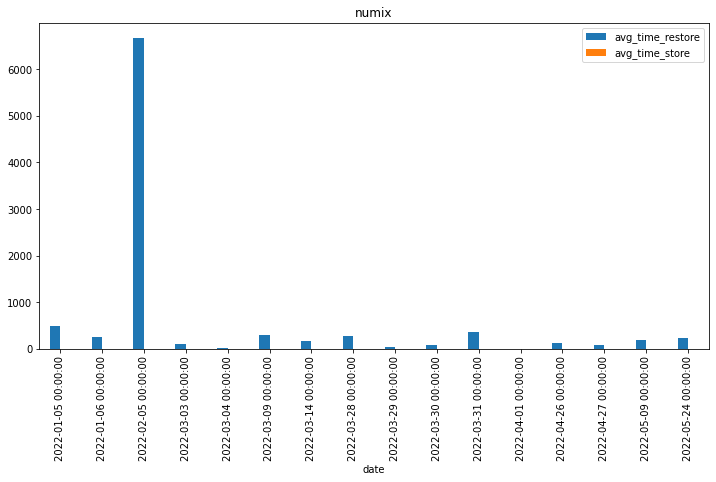

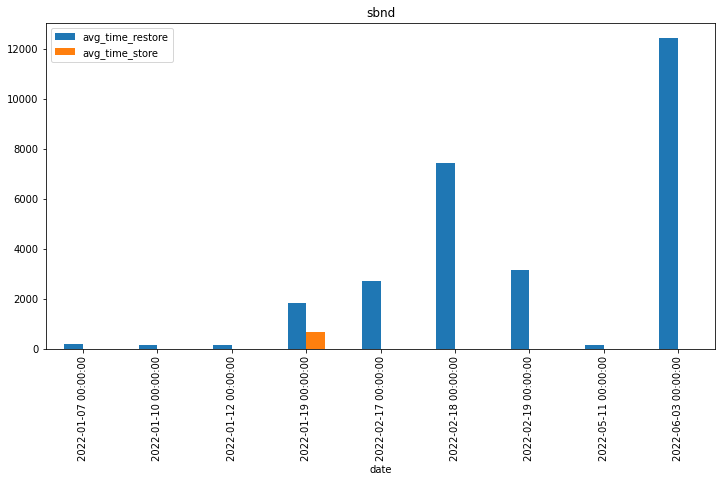

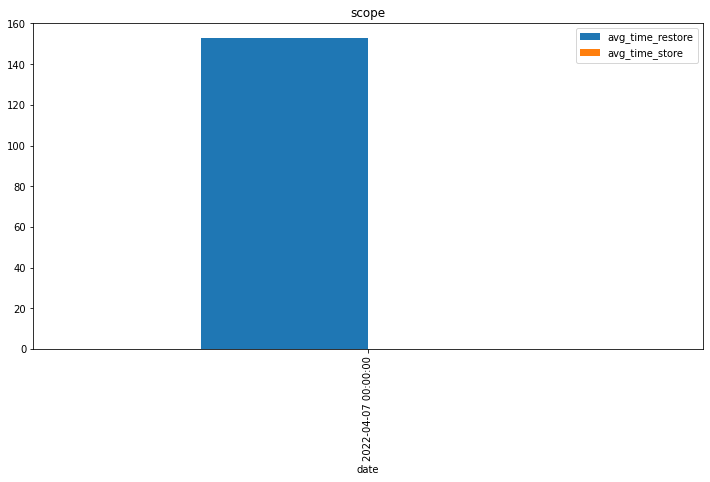

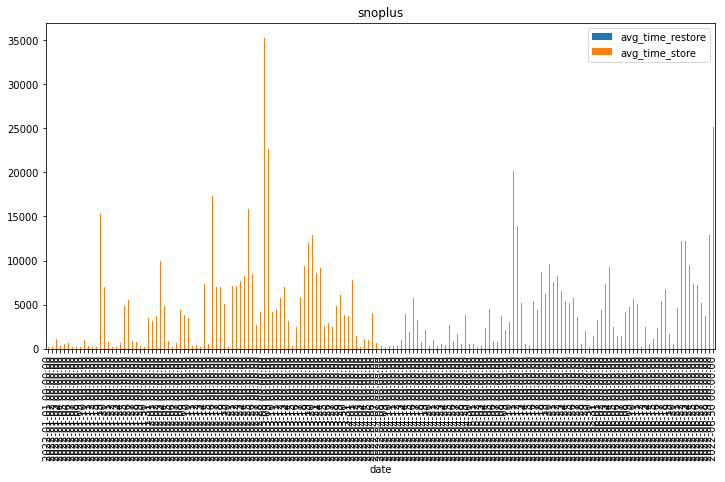

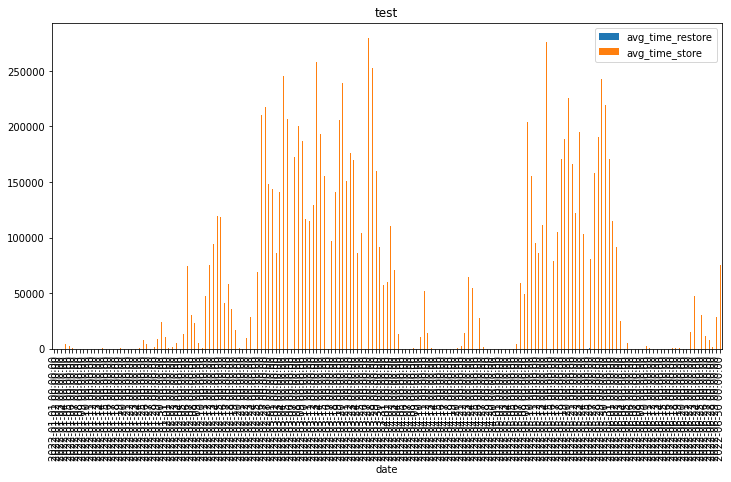

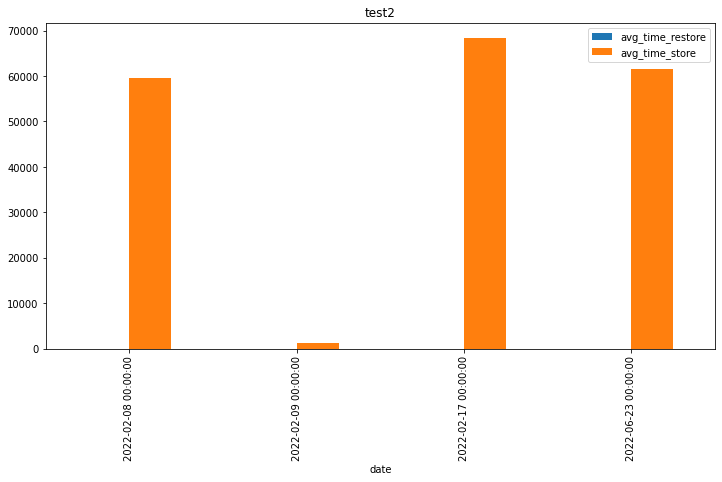

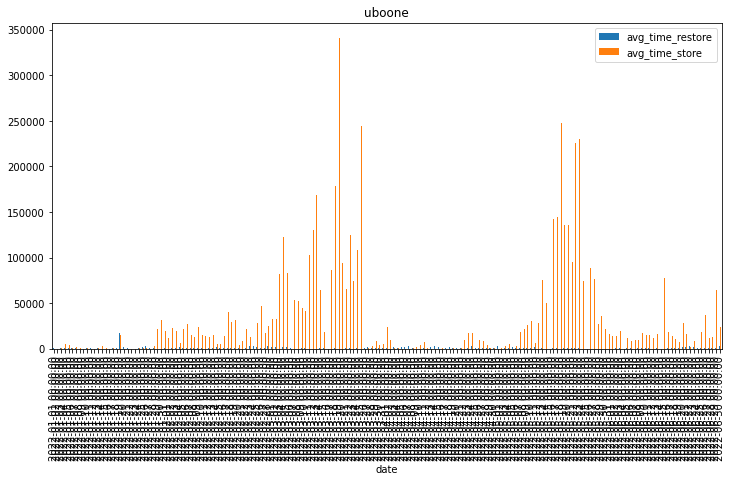

In [13]:
for vo, group in d.groupby('vo'):
    group.plot.bar( x= 'date', title=vo, figsize=(12,6))
    plt.savefig(f'Average_time_restores_store_vs_time_6_months_for{vo}.png', bbox_inches='tight')
    ylabel("avg_time" ,fontsize=24)
    xlabel("vo" ,fontsize=24)

<AxesSubplot:title={'center':'ADMX'}, xlabel='date'>

<AxesSubplot:title={'center':'GM2'}, xlabel='date'>

<AxesSubplot:title={'center':'Simons'}, xlabel='date'>

<AxesSubplot:title={'center':'accelai'}, xlabel='date'>

<AxesSubplot:title={'center':'annie'}, xlabel='date'>

<AxesSubplot:title={'center':'backups'}, xlabel='date'>

<AxesSubplot:title={'center':'d0'}, xlabel='date'>

<AxesSubplot:title={'center':'damic'}, xlabel='date'>

<AxesSubplot:title={'center':'darkside'}, xlabel='date'>

<AxesSubplot:title={'center':'des'}, xlabel='date'>

<AxesSubplot:title={'center':'dune'}, xlabel='date'>

<AxesSubplot:title={'center':'e1039'}, xlabel='date'>

<AxesSubplot:title={'center':'e906'}, xlabel='date'>

<AxesSubplot:title={'center':'fermigrid'}, xlabel='date'>

<AxesSubplot:title={'center':'icarus'}, xlabel='date'>

<AxesSubplot:title={'center':'lariat'}, xlabel='date'>

<AxesSubplot:title={'center':'lqcd'}, xlabel='date'>

<AxesSubplot:title={'center':'minerva'}, xlabel='date'>

<AxesSubplot:title={'center':'minos'}, xlabel='date'>

<AxesSubplot:title={'center':'mu2e'}, xlabel='date'>

/usr/local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<AxesSubplot:title={'center':'netflow'}, xlabel='date'>

<AxesSubplot:title={'center':'next'}, xlabel='date'>

<AxesSubplot:title={'center':'none'}, xlabel='date'>

<AxesSubplot:title={'center':'nova'}, xlabel='date'>

<AxesSubplot:title={'center':'numix'}, xlabel='date'>

<AxesSubplot:title={'center':'sbnd'}, xlabel='date'>

<AxesSubplot:title={'center':'scope'}, xlabel='date'>

<AxesSubplot:title={'center':'snoplus'}, xlabel='date'>

<AxesSubplot:title={'center':'test'}, xlabel='date'>

<AxesSubplot:title={'center':'test2'}, xlabel='date'>

<AxesSubplot:title={'center':'uboone'}, xlabel='date'>

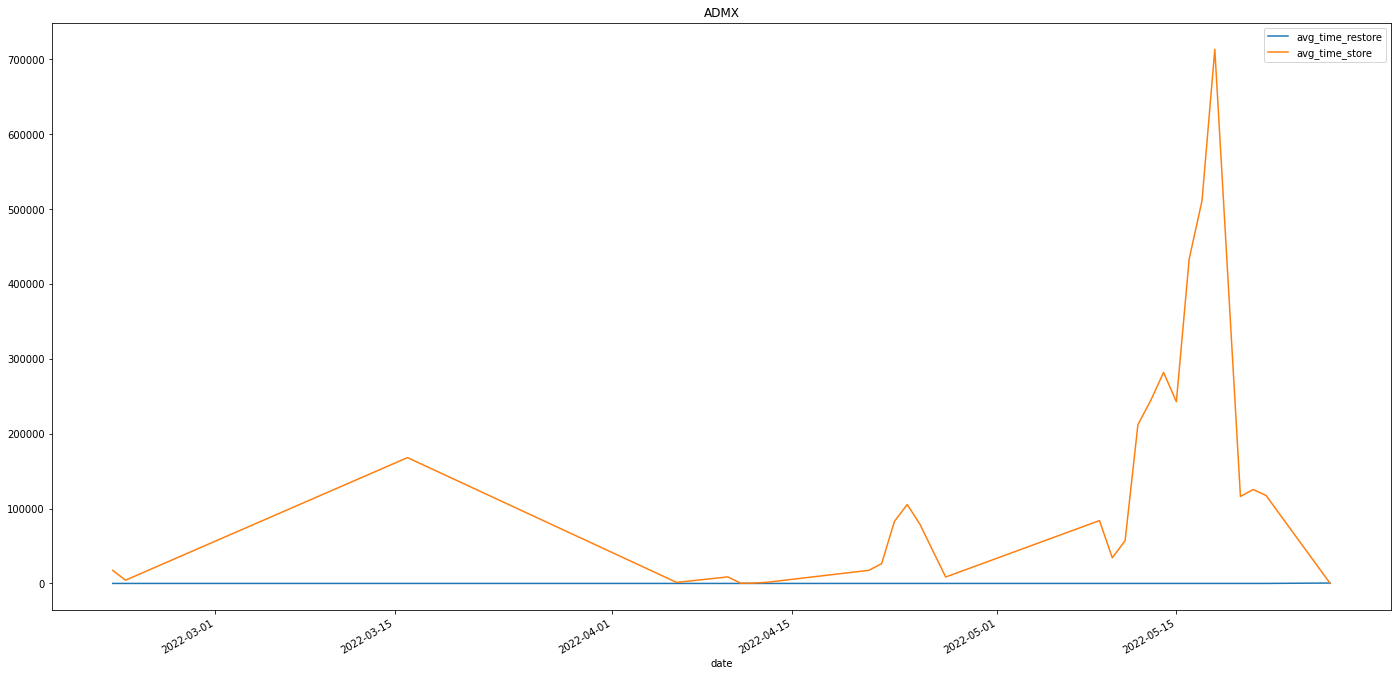

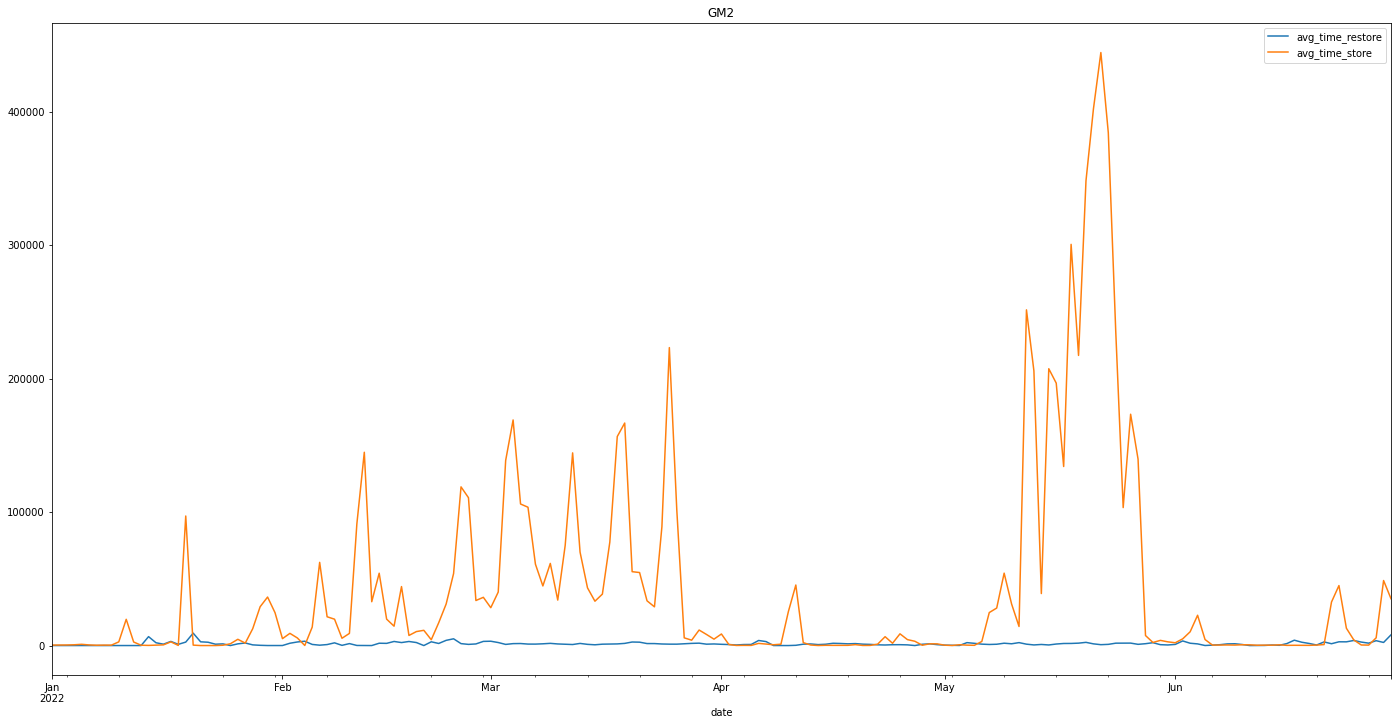

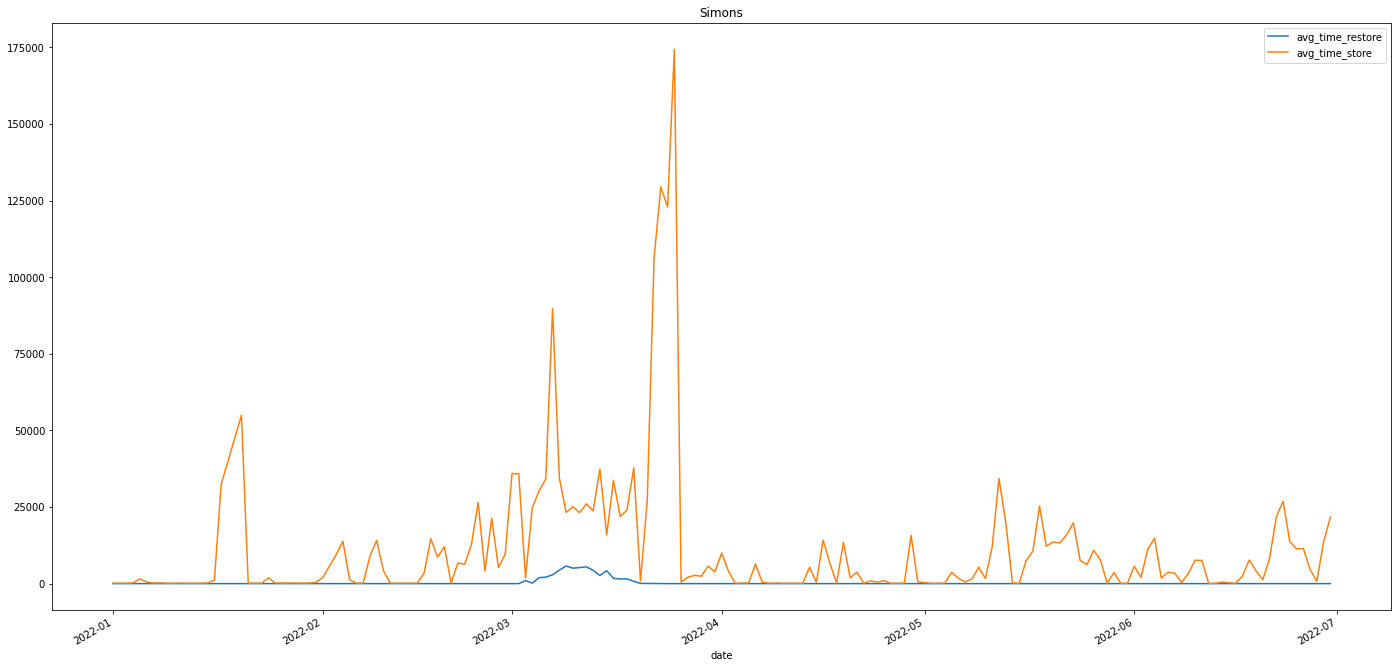

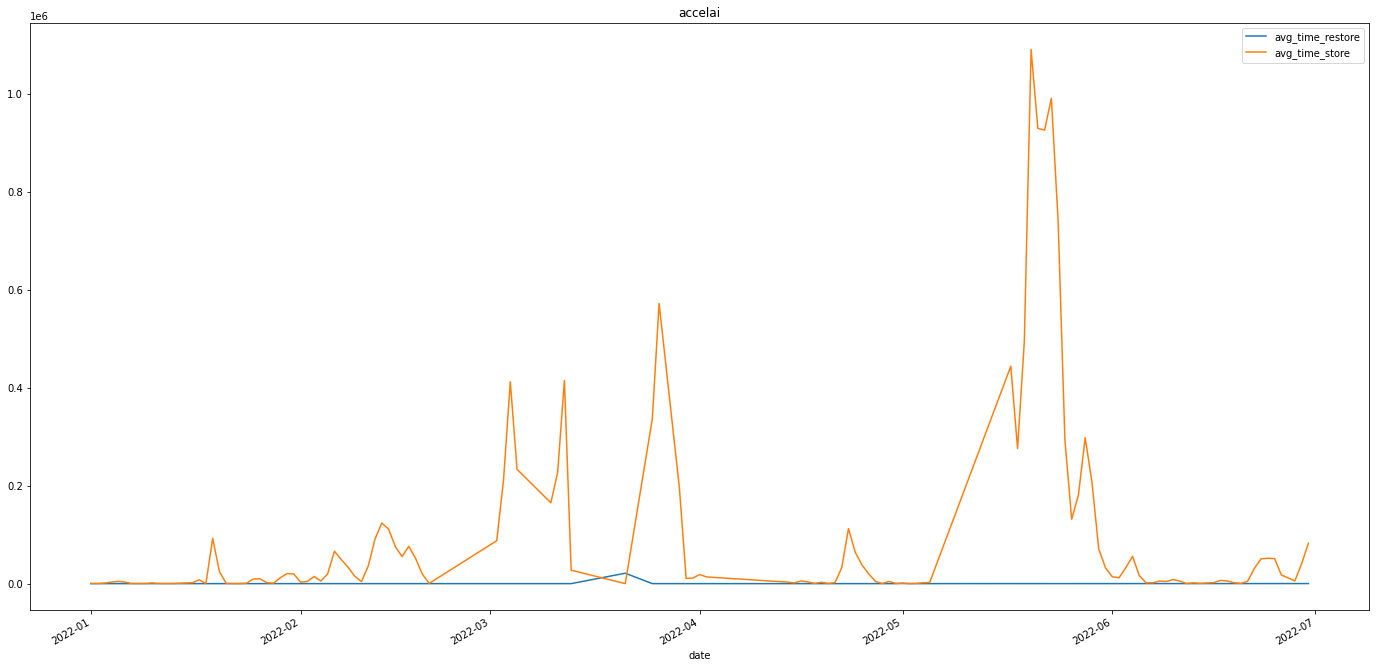

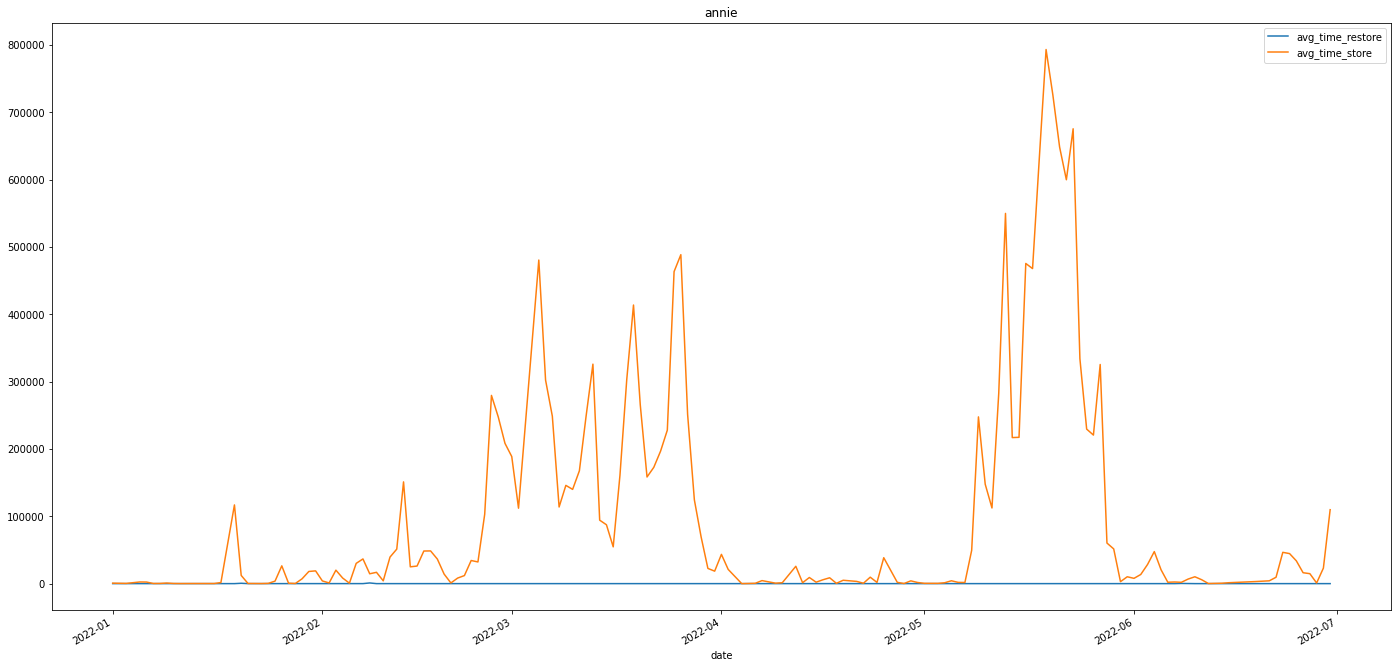

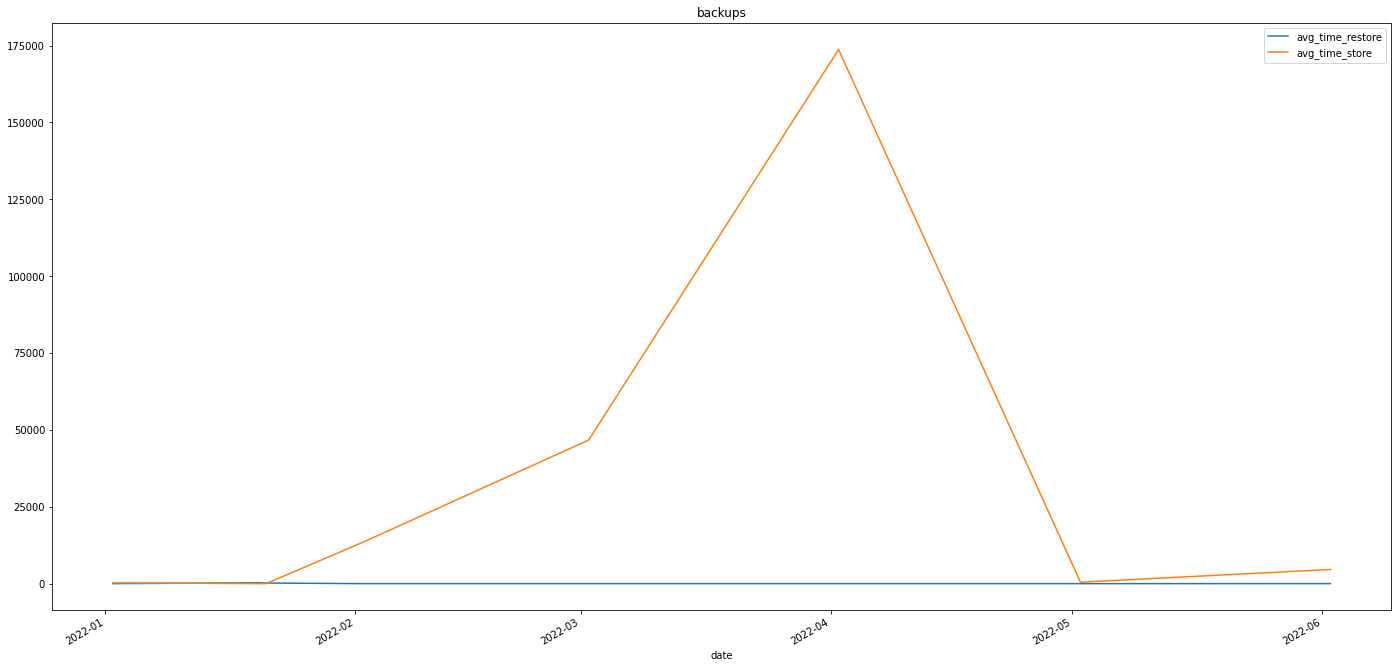

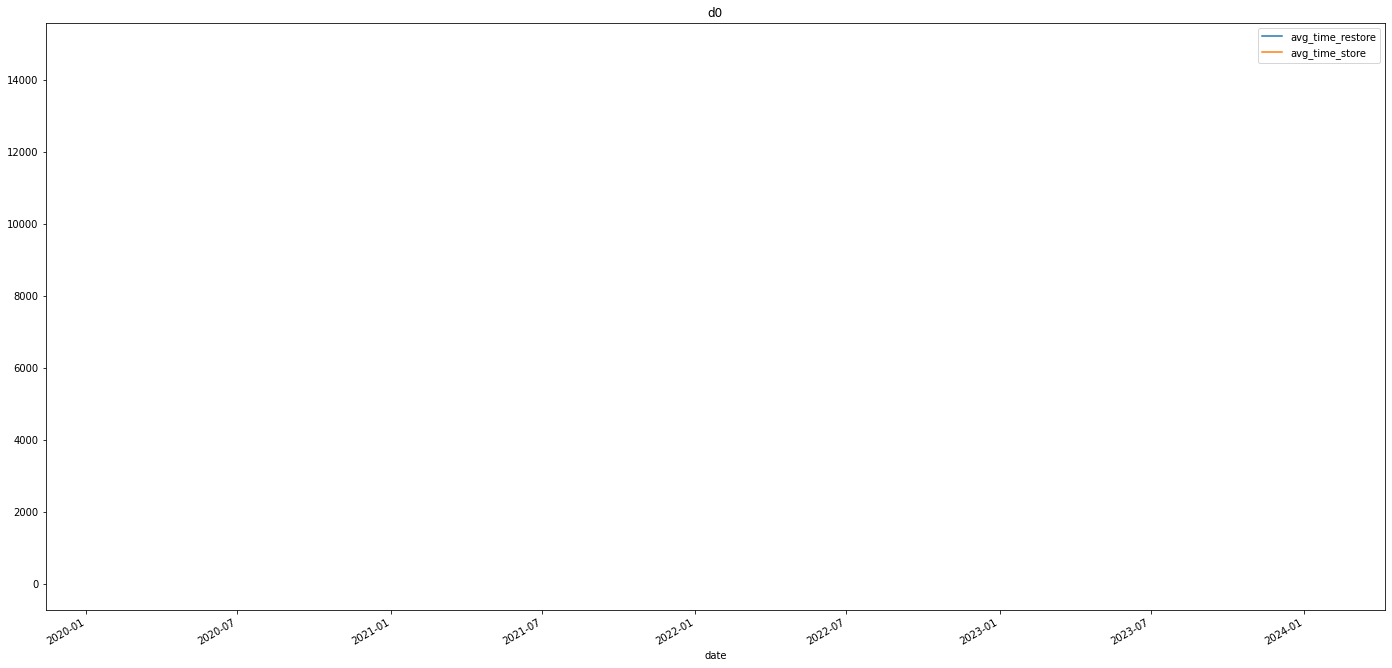

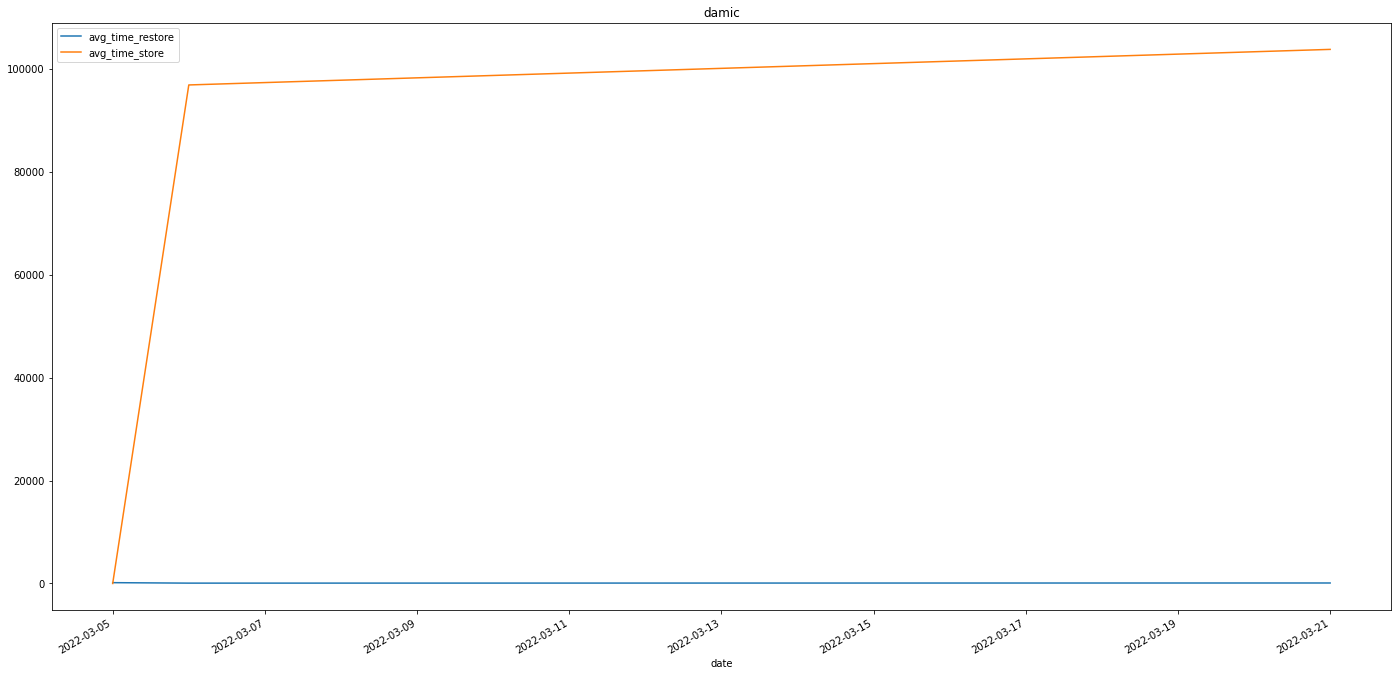

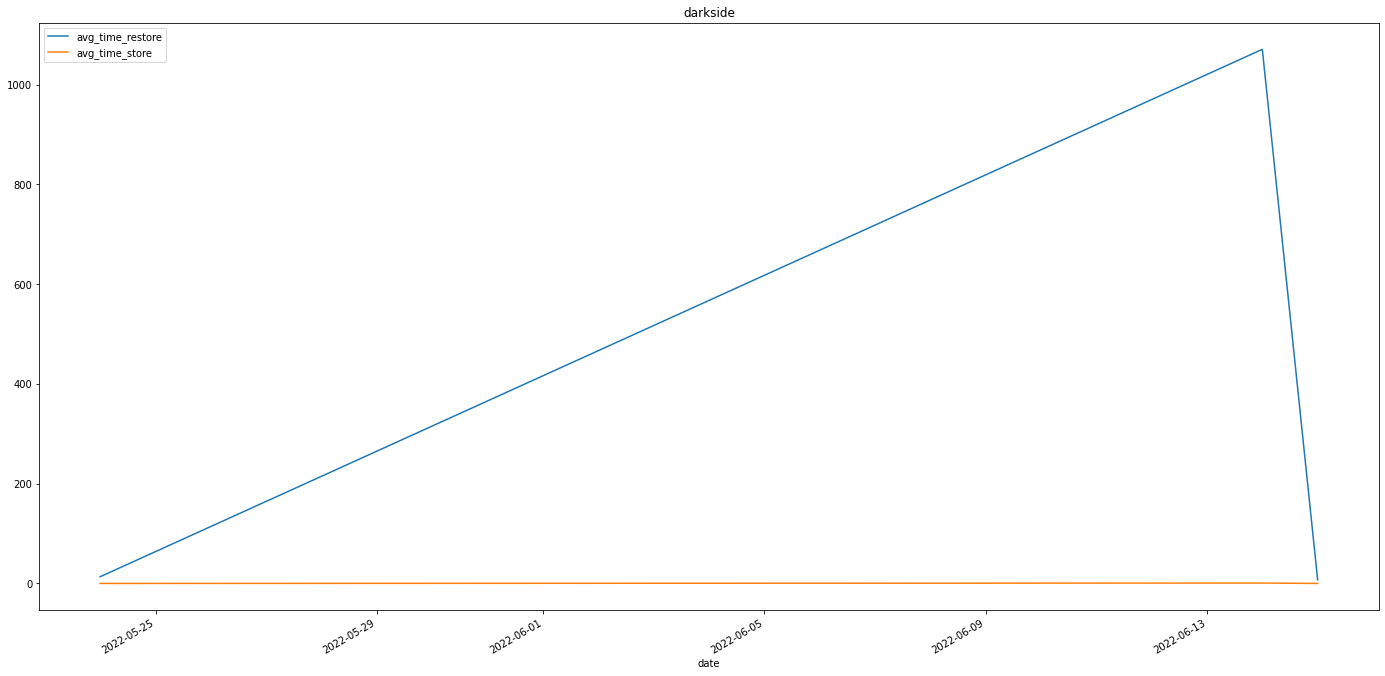

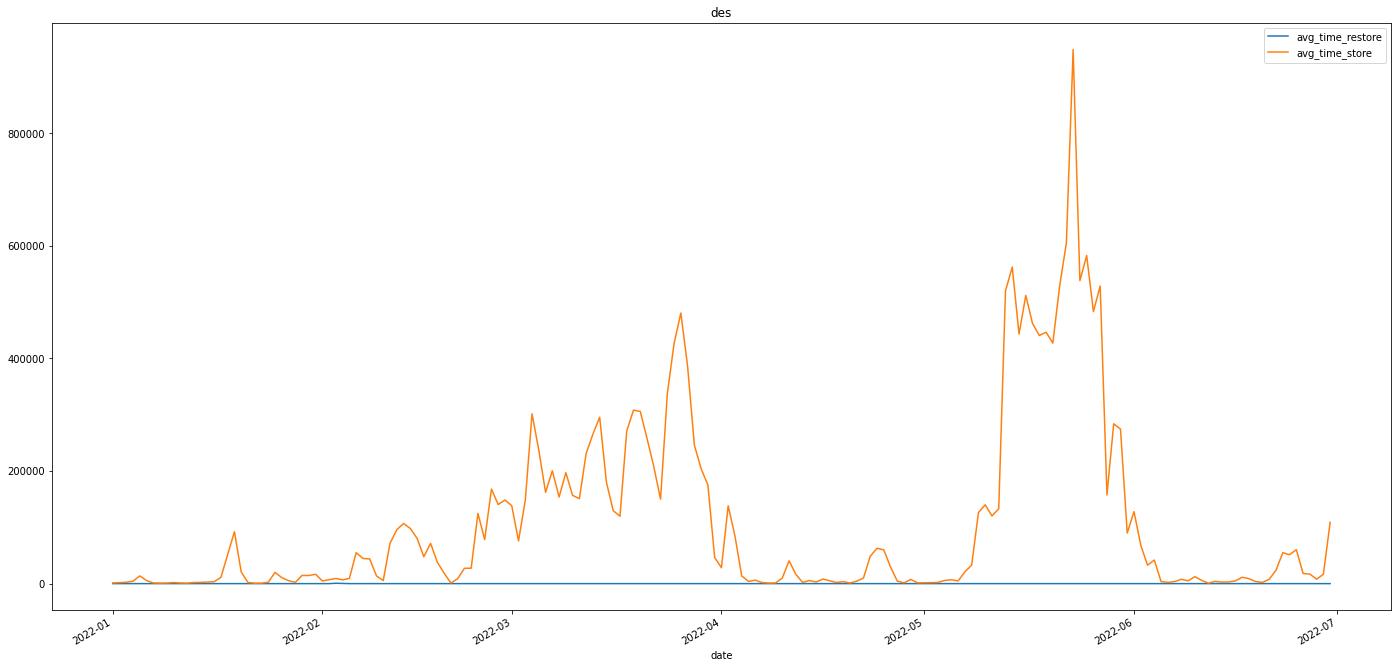

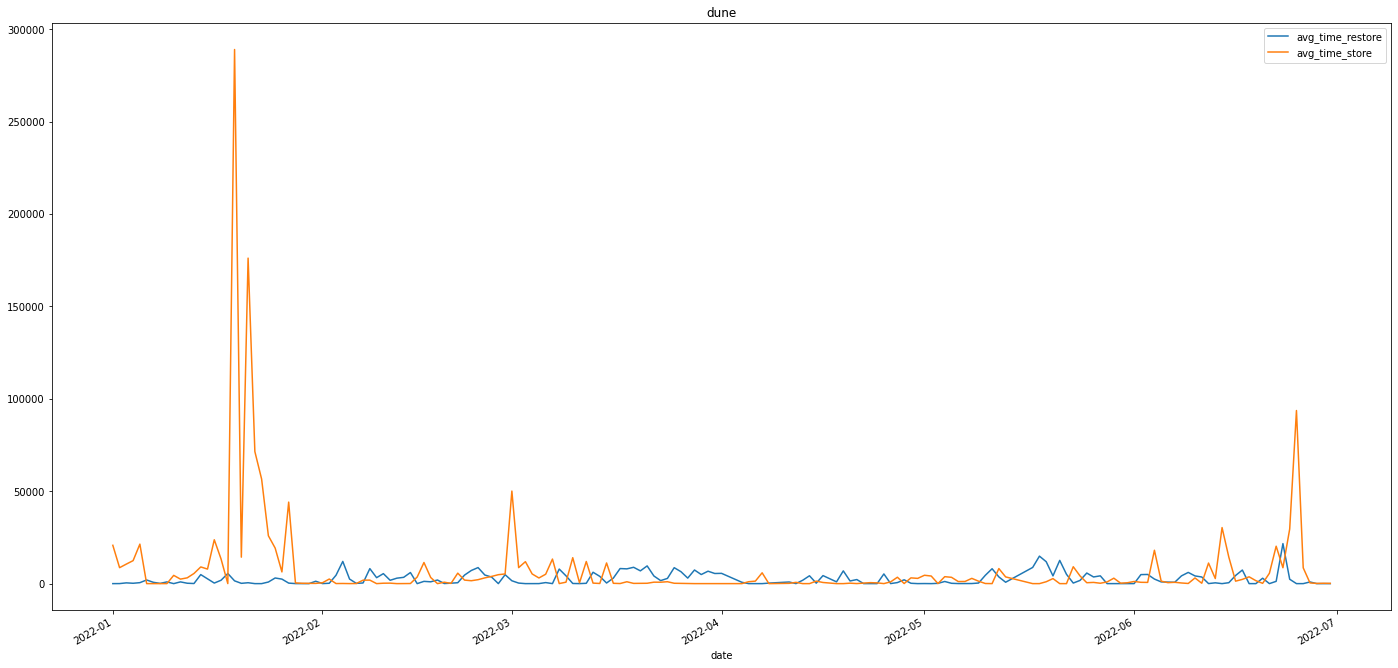

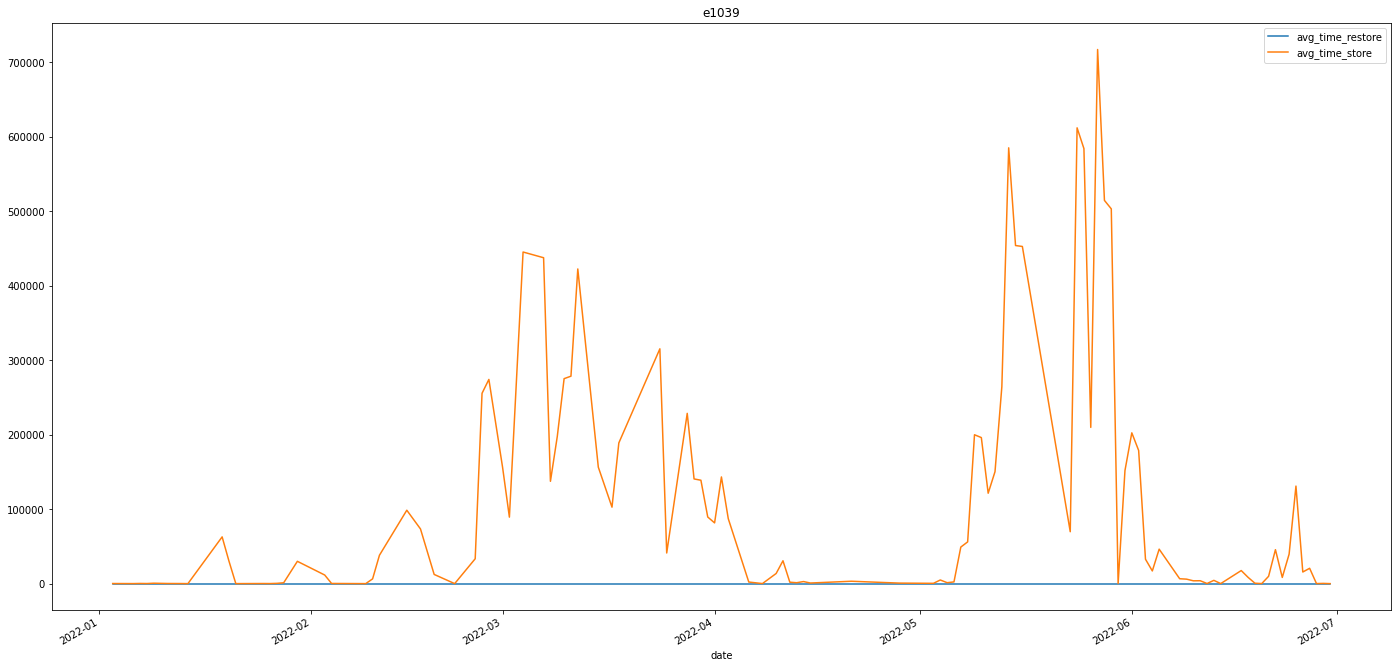

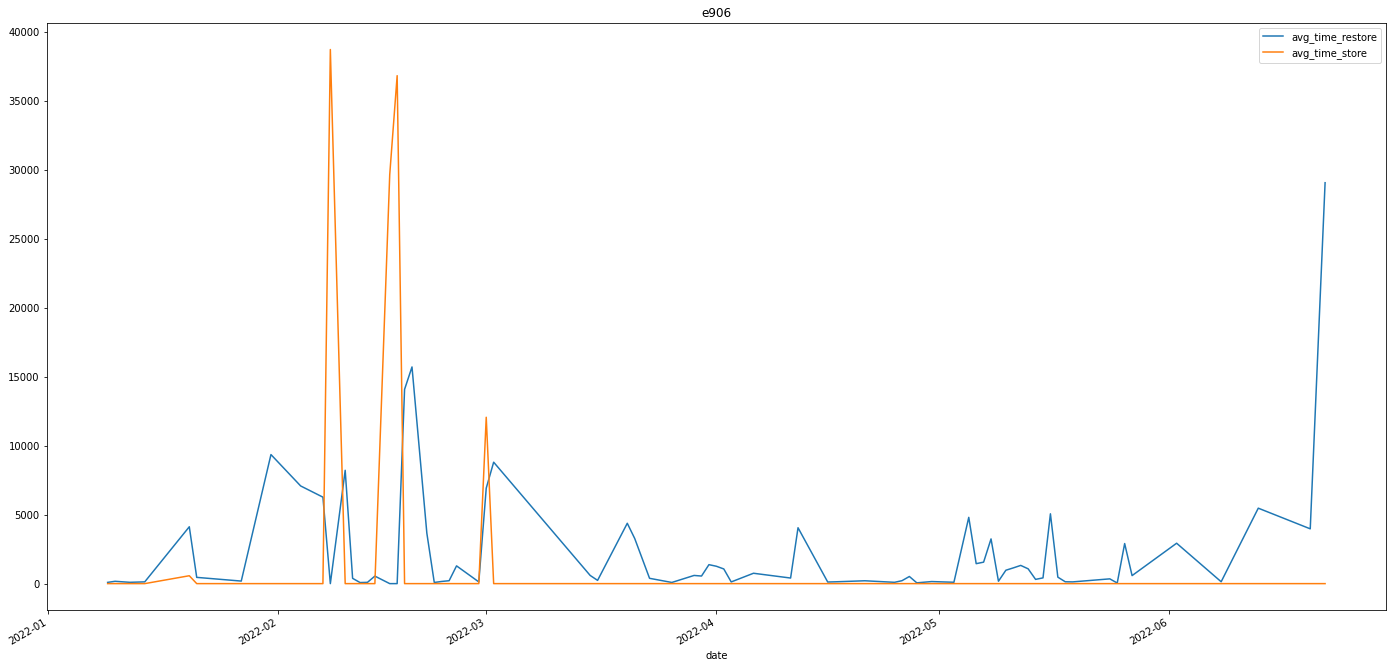

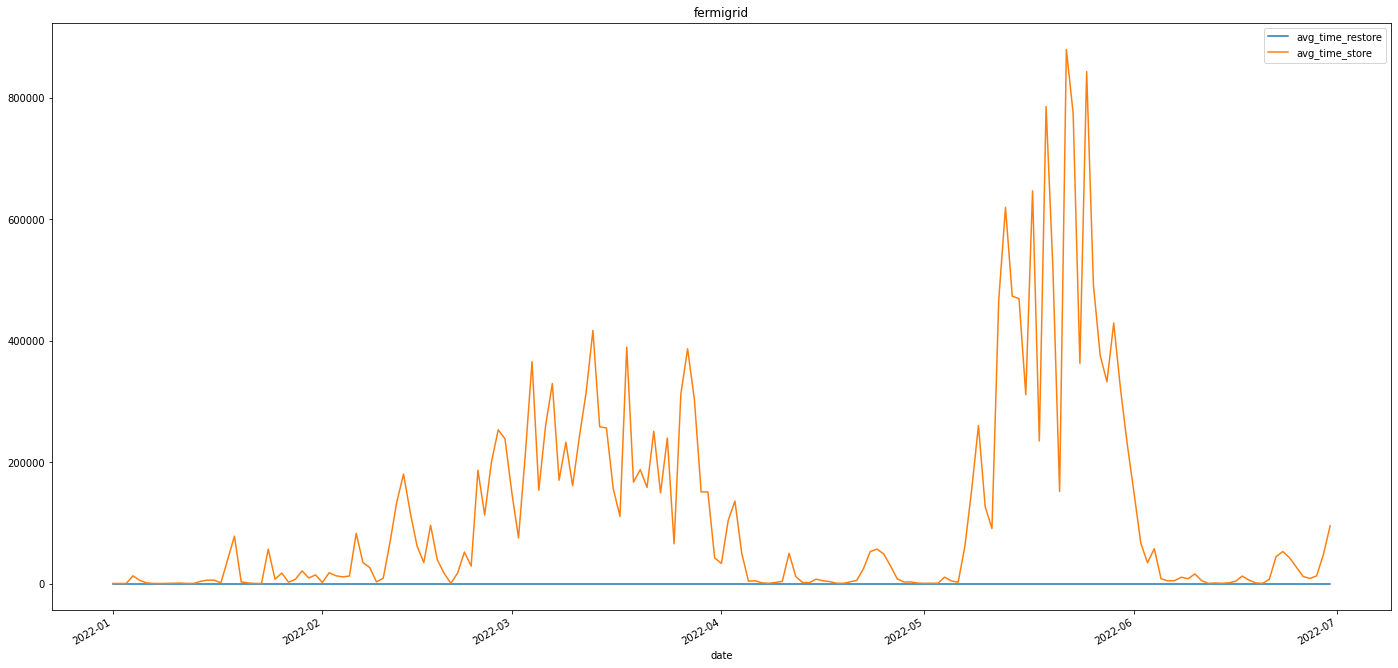

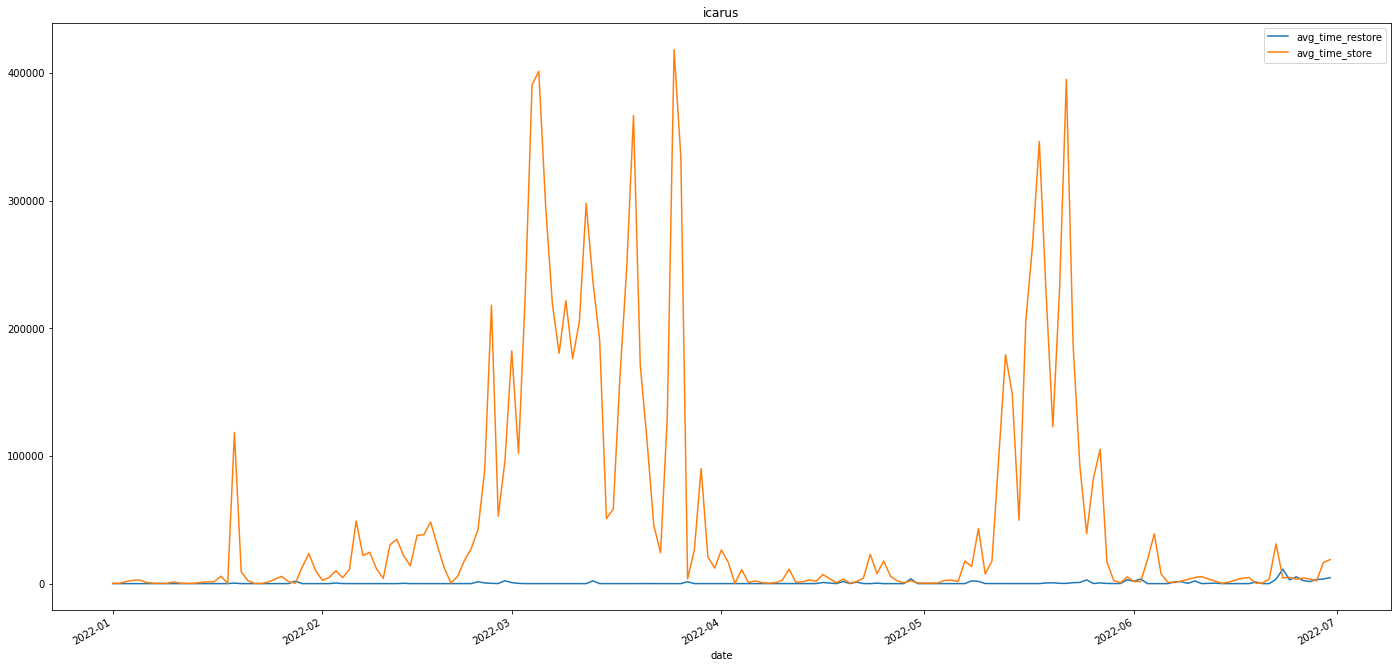

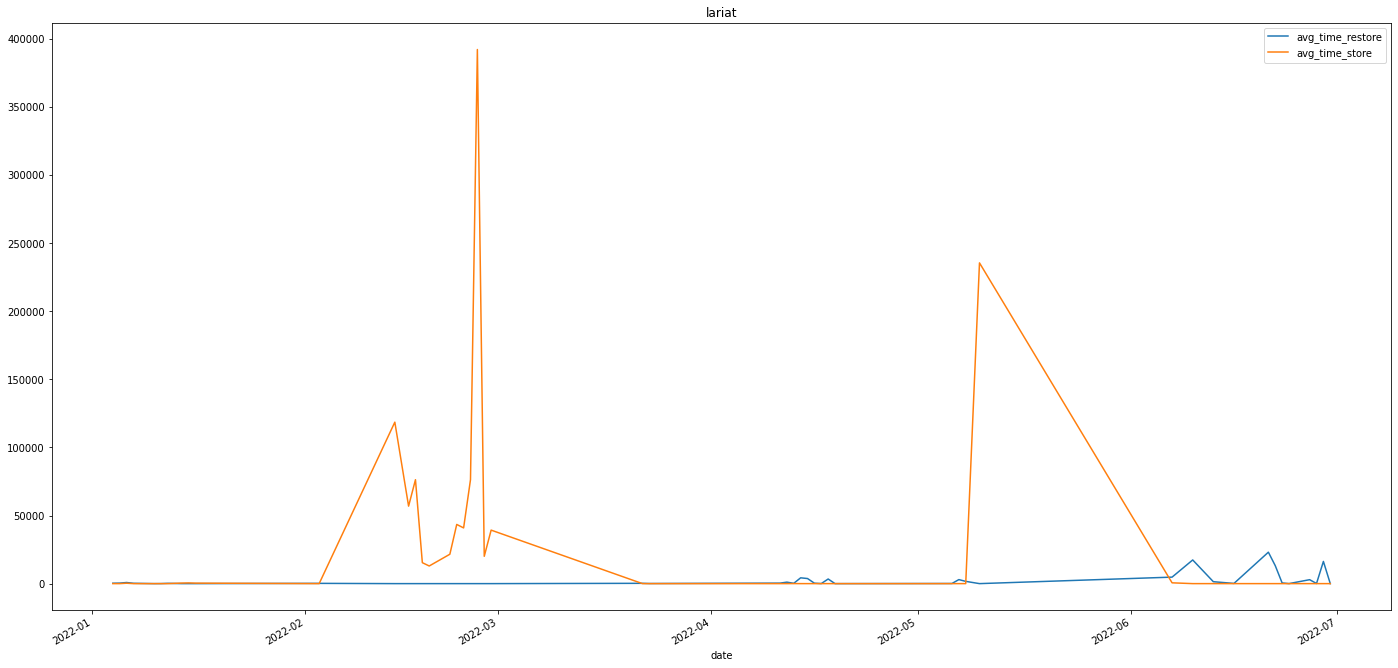

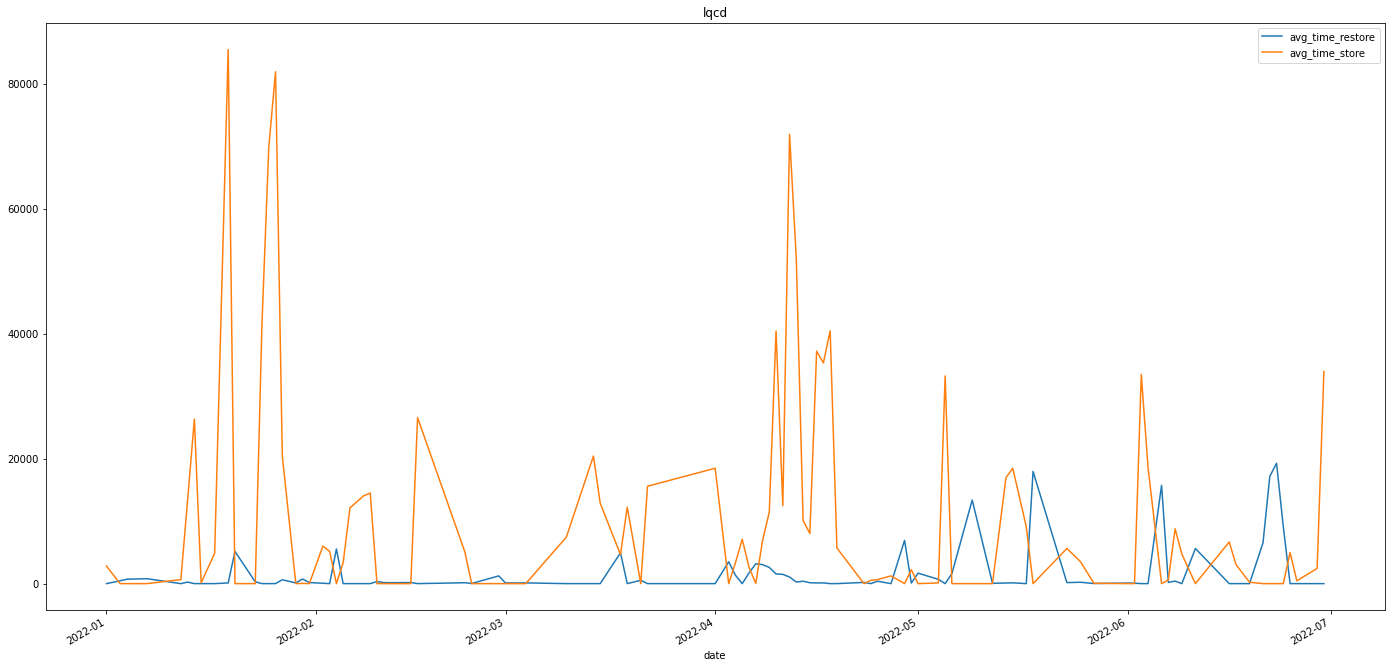

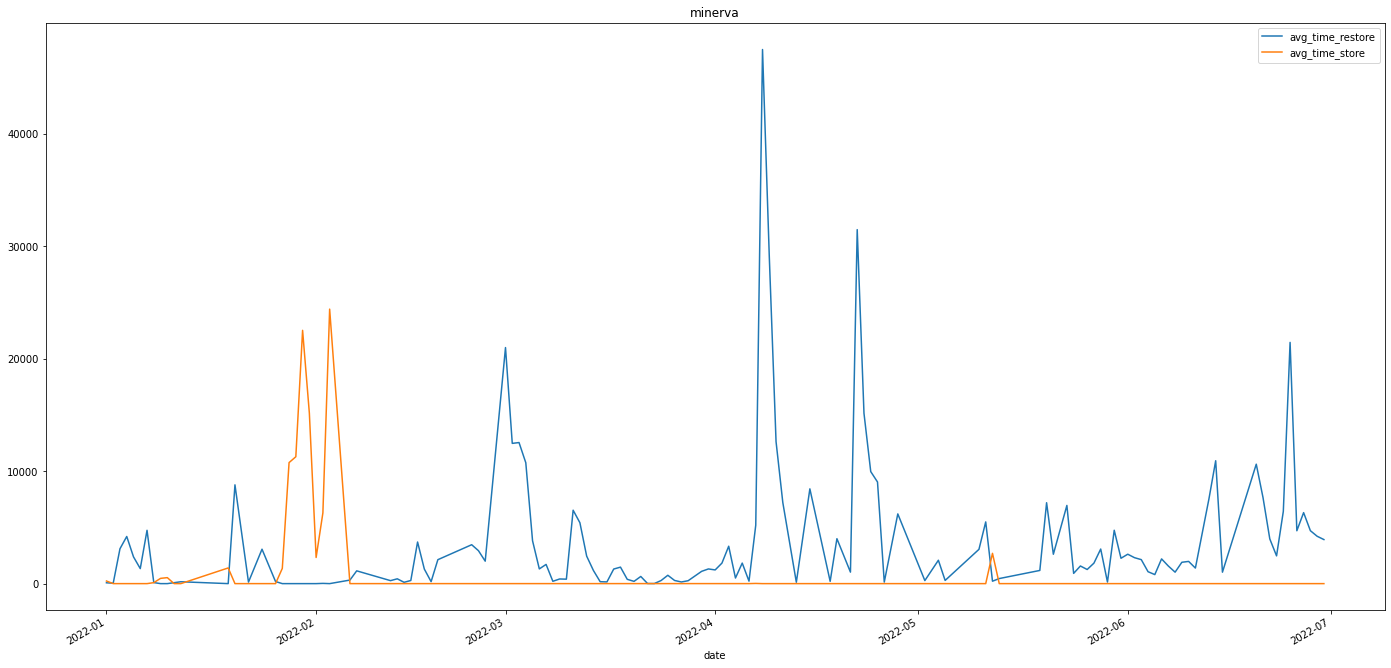

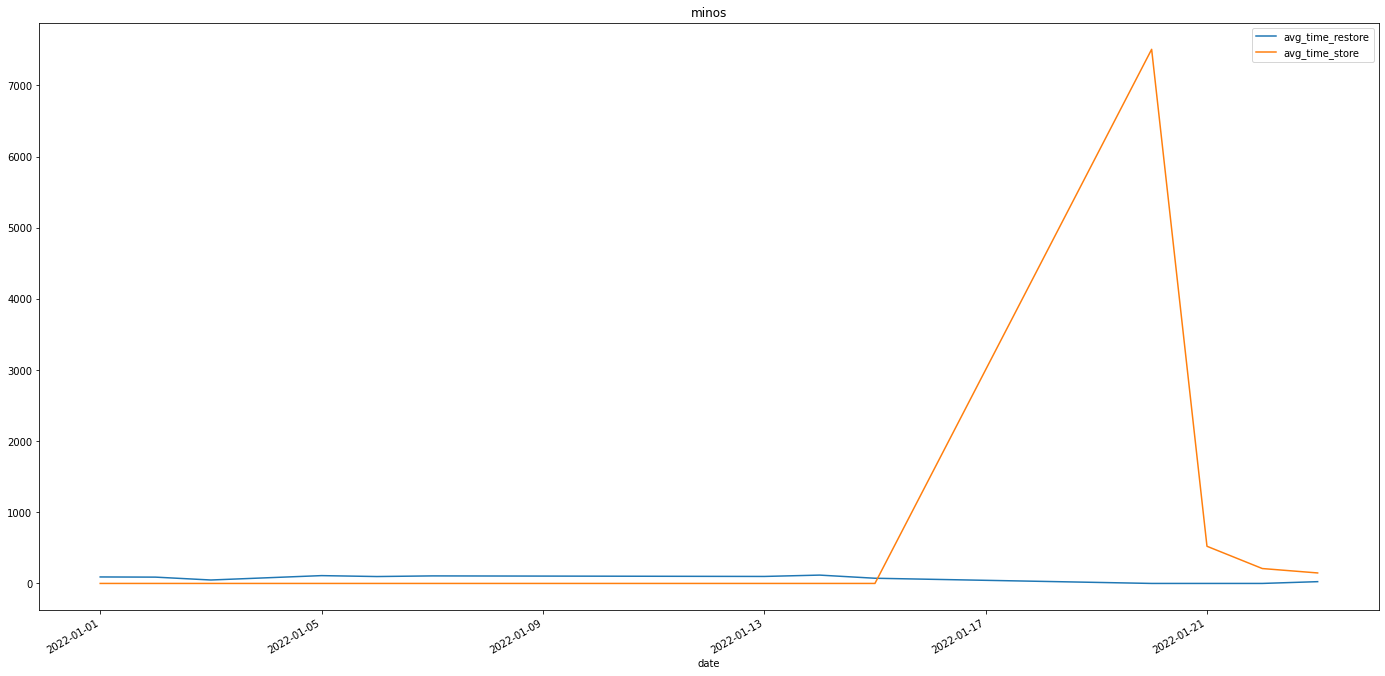

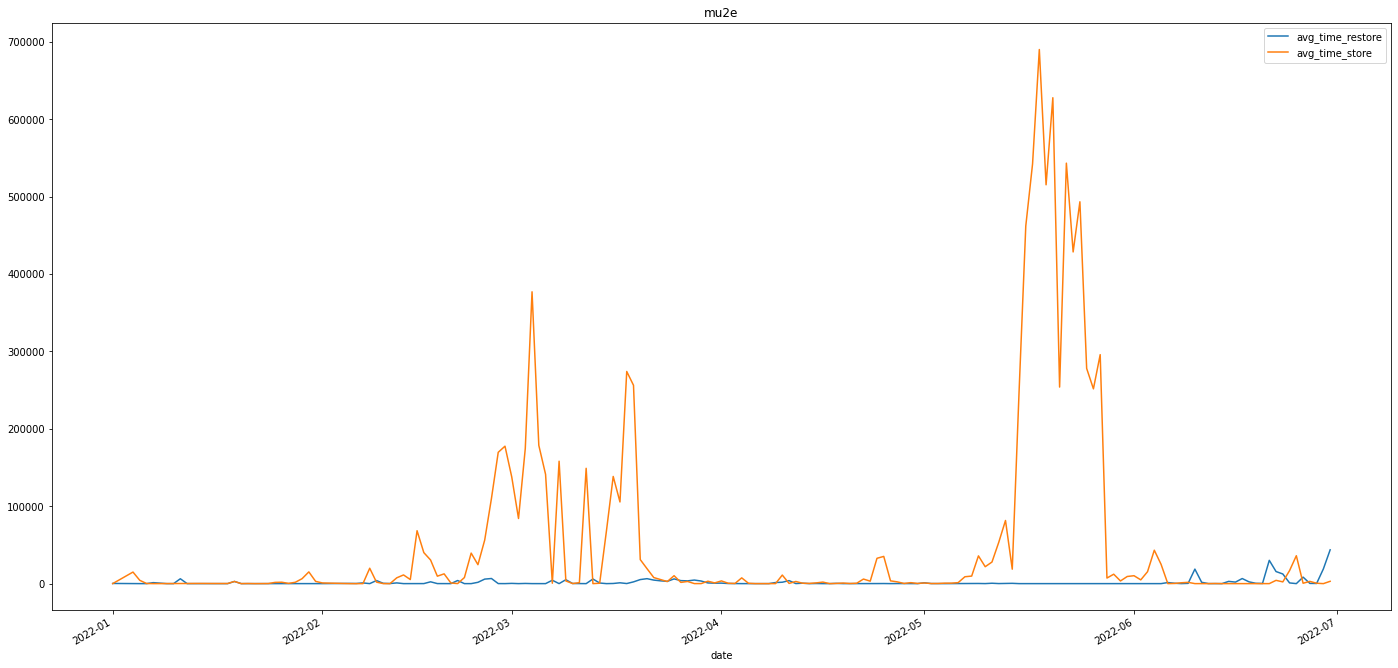

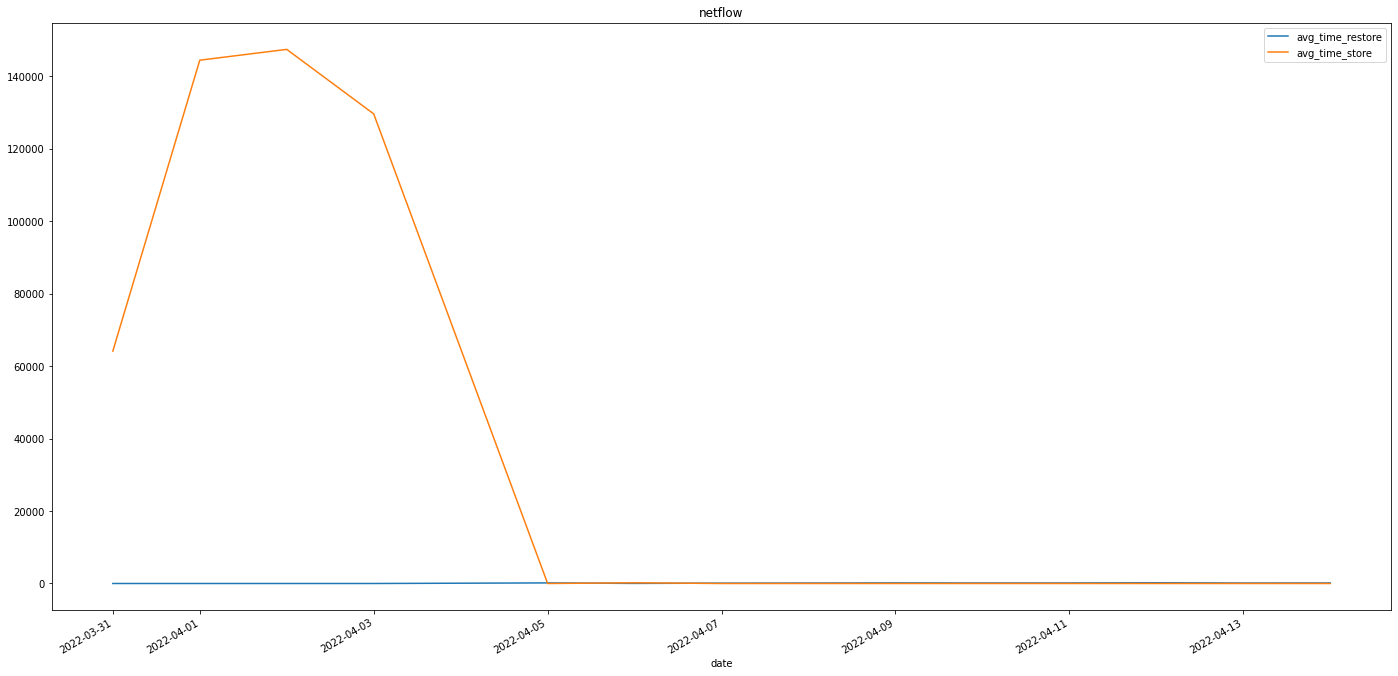

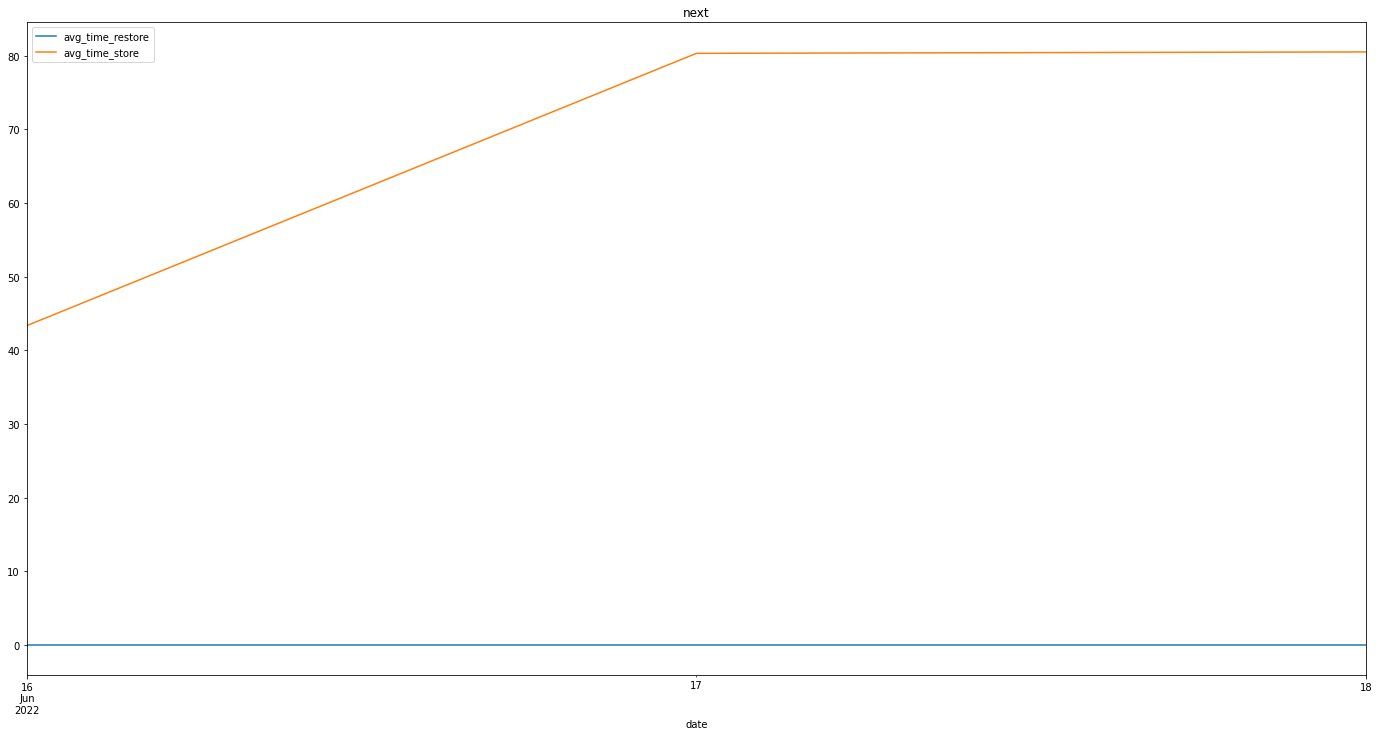

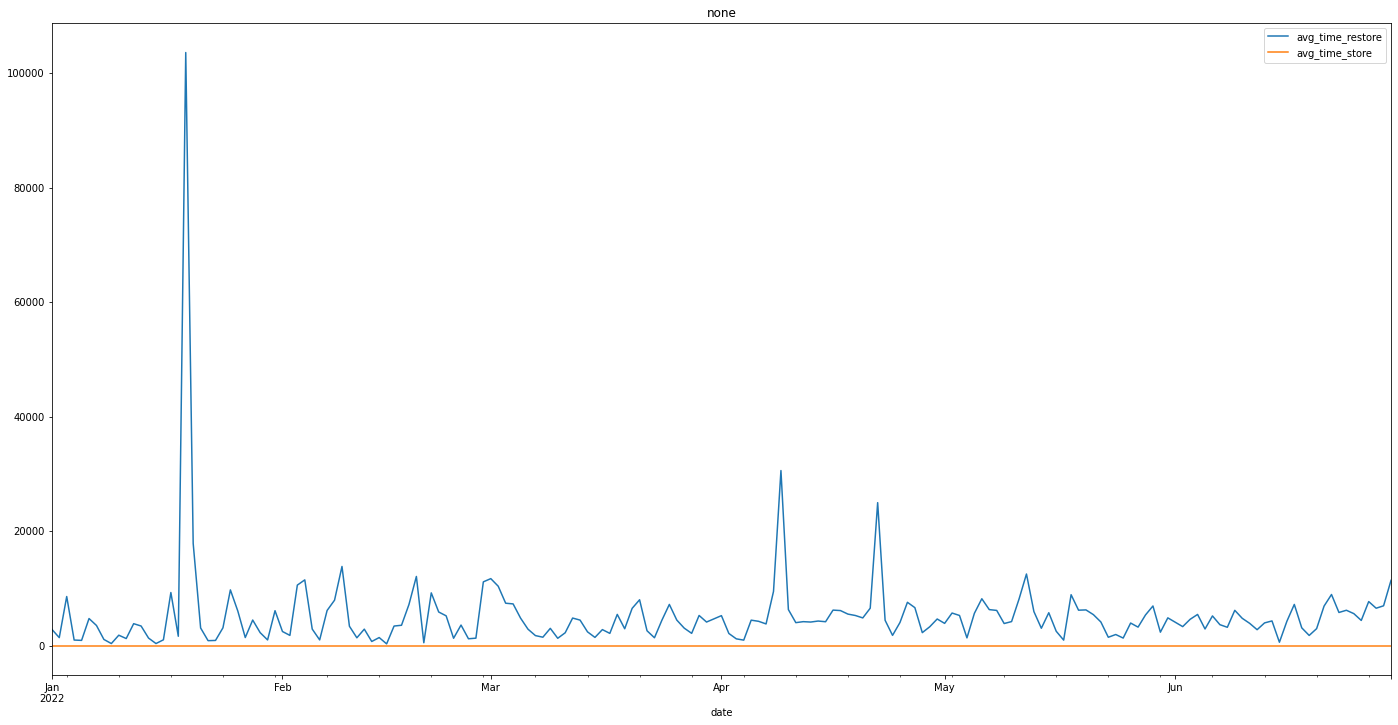

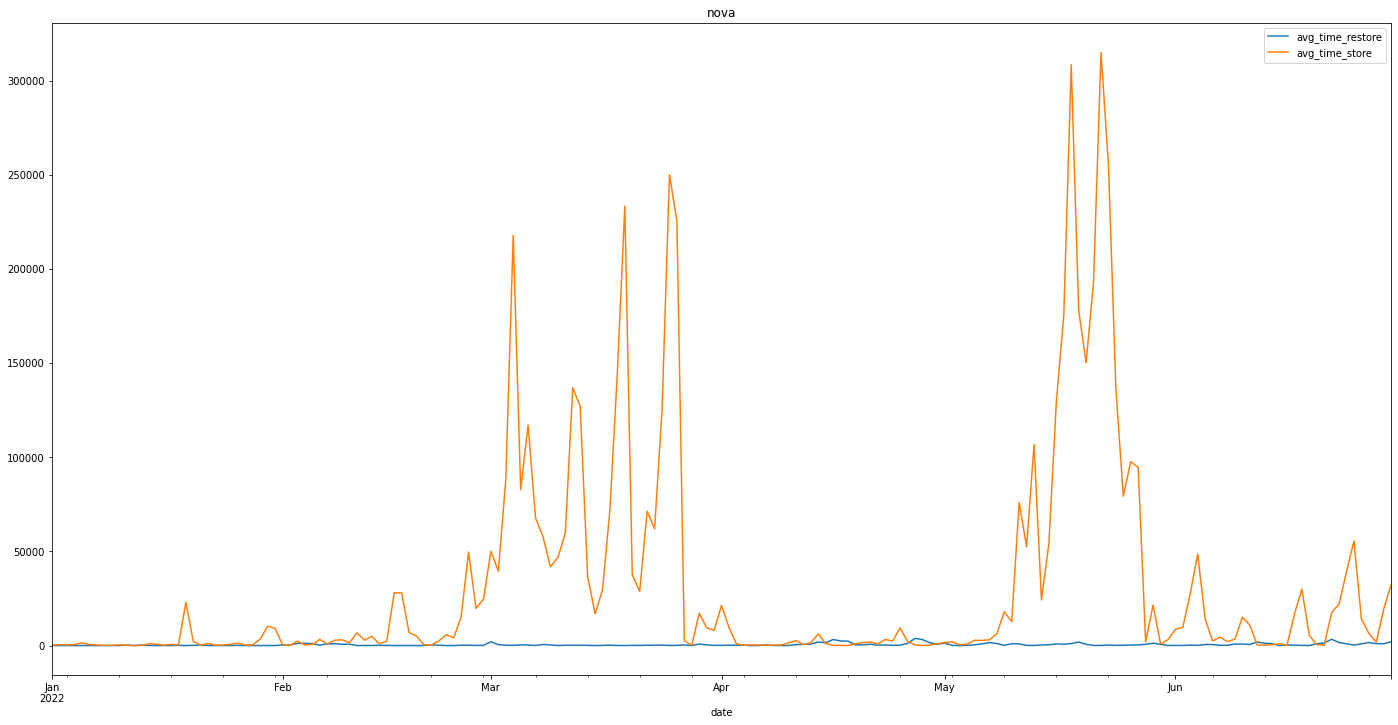

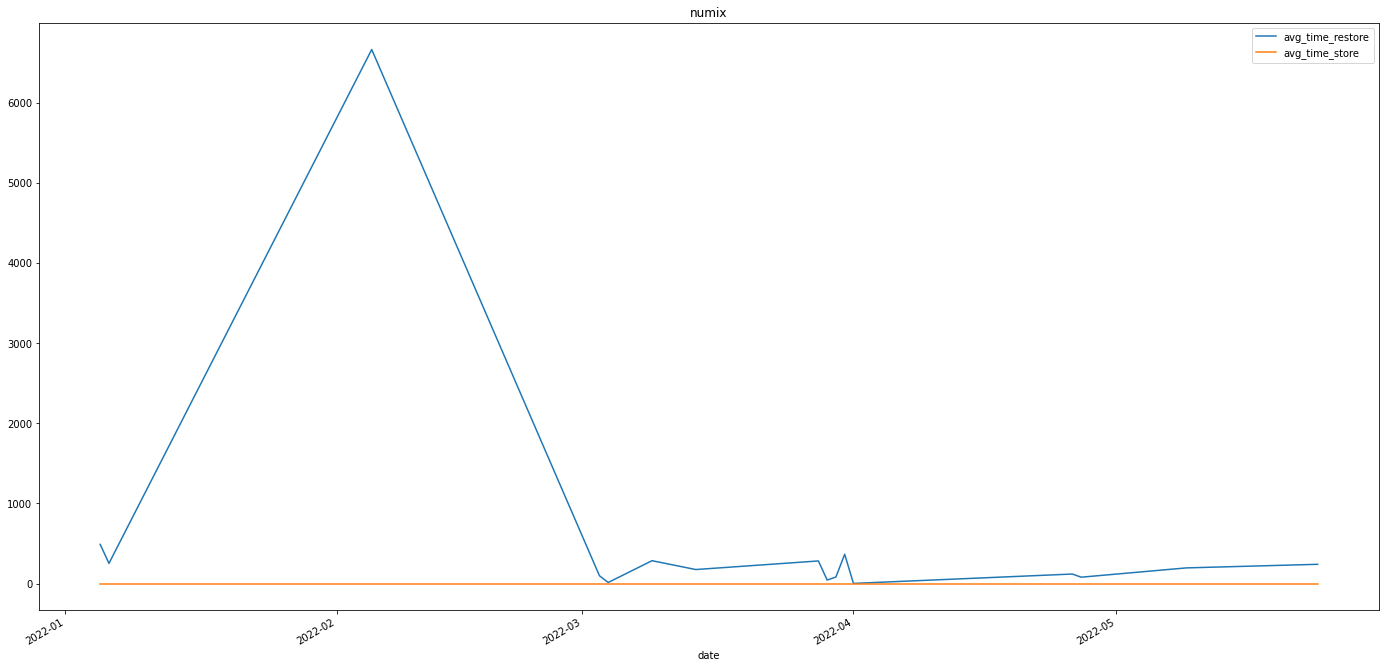

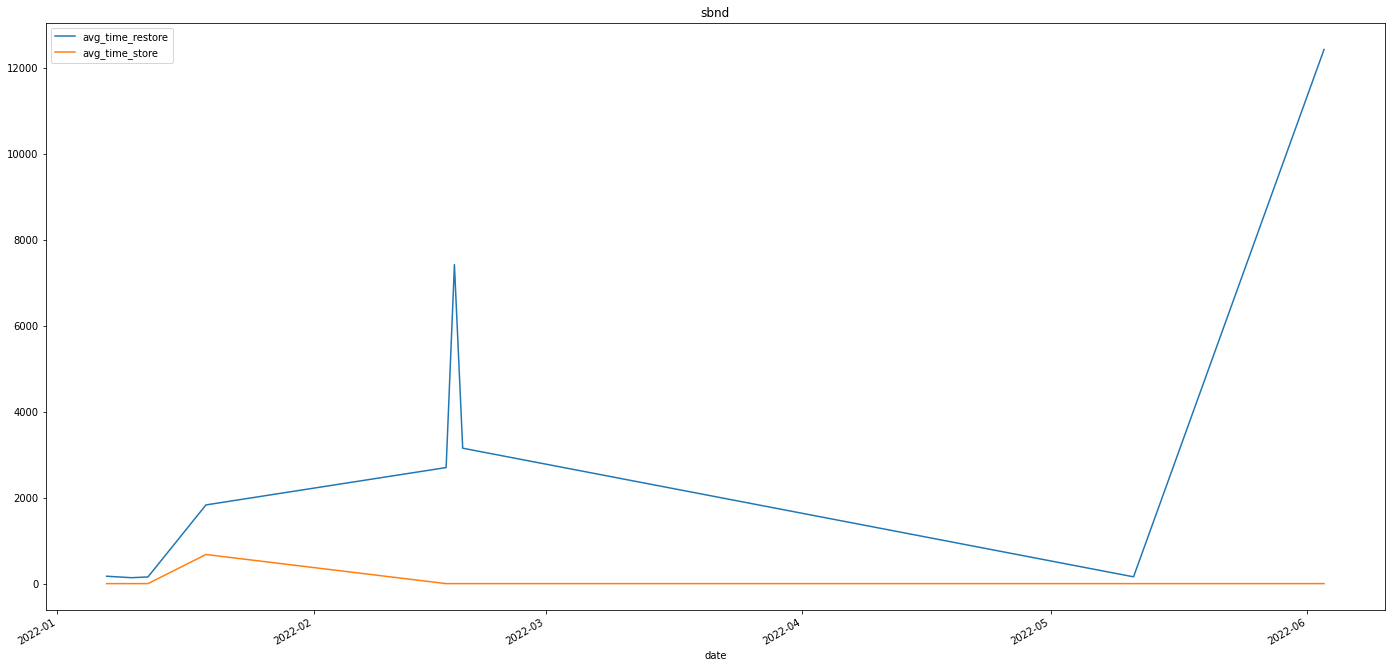

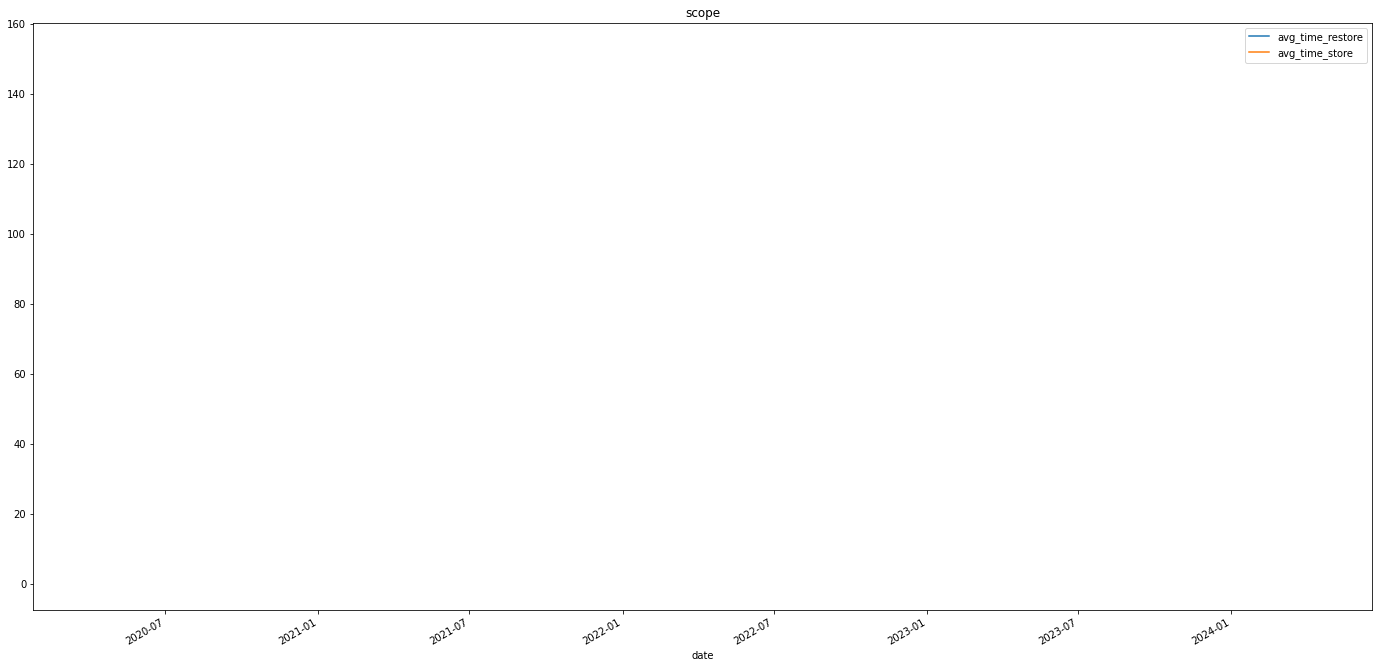

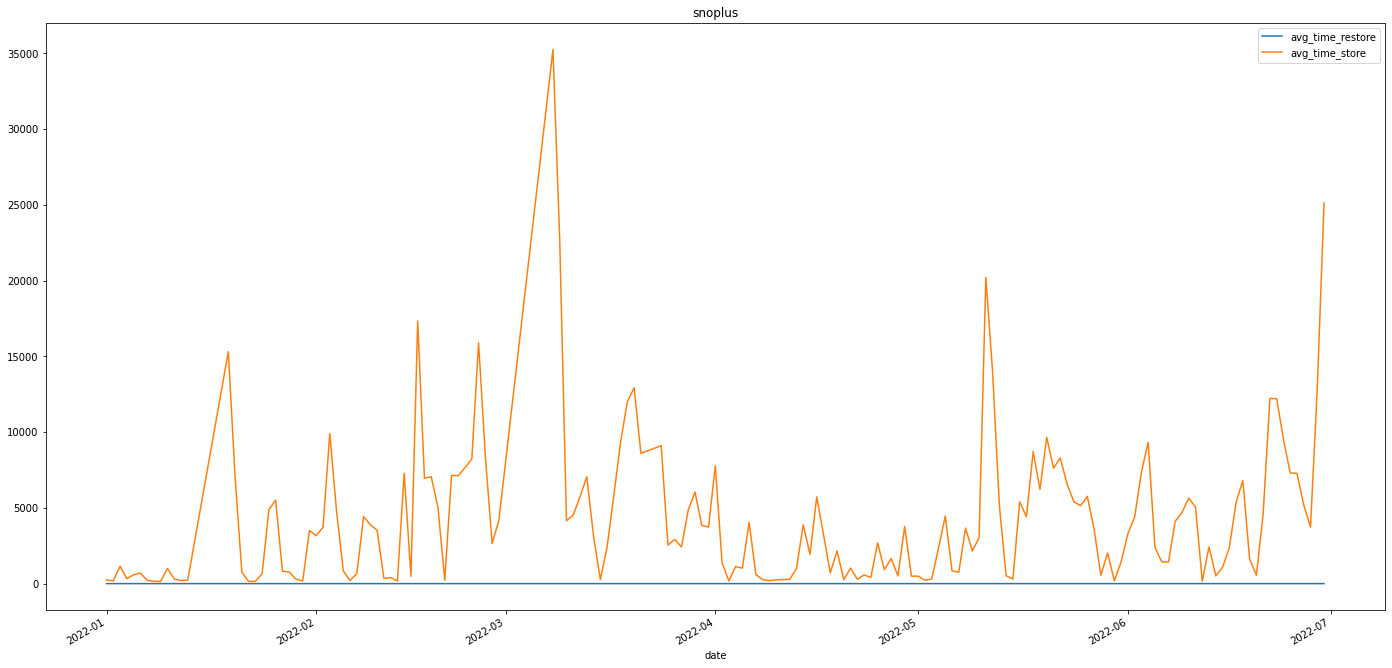

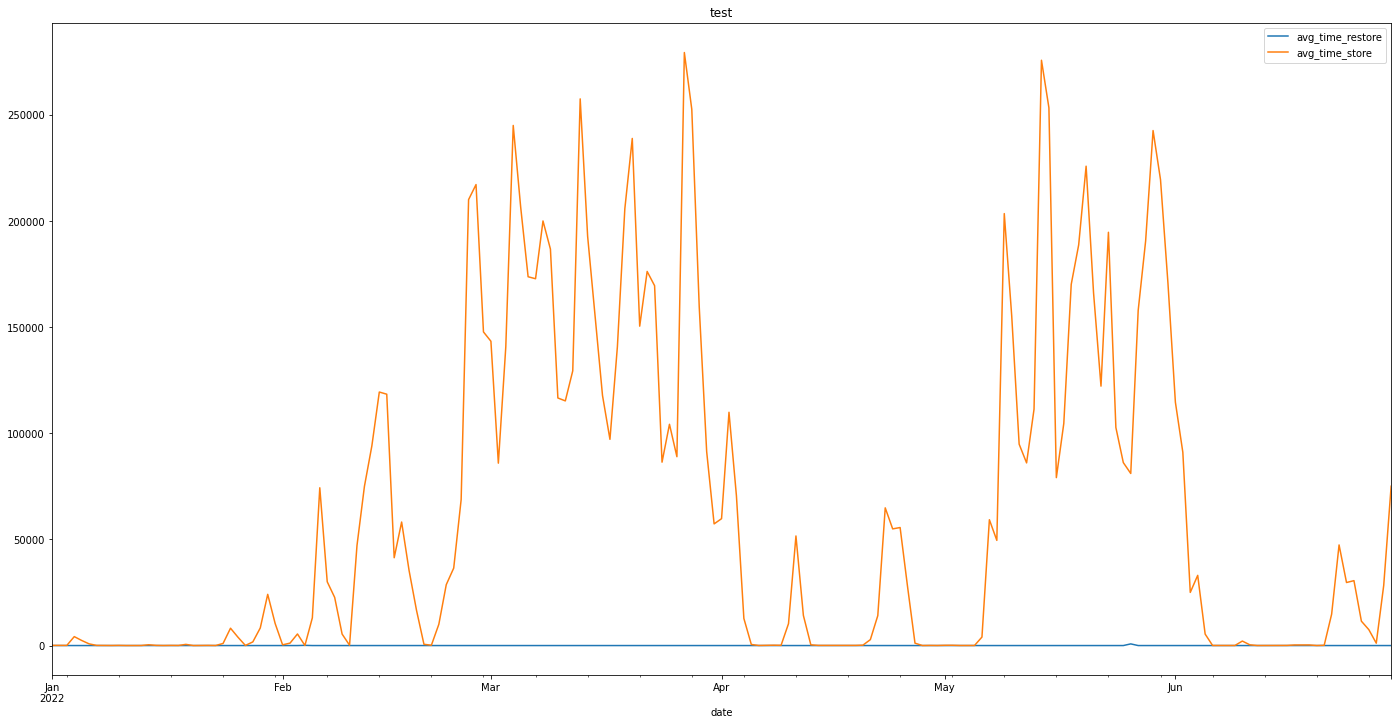

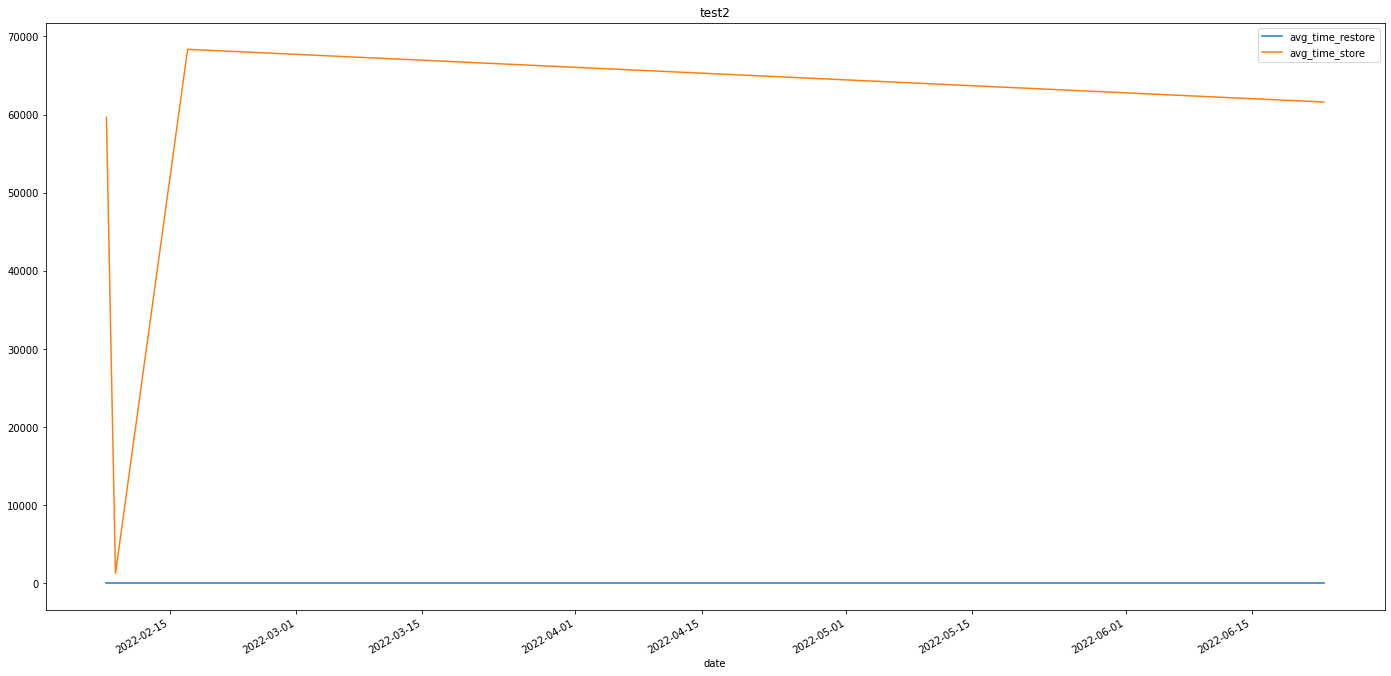

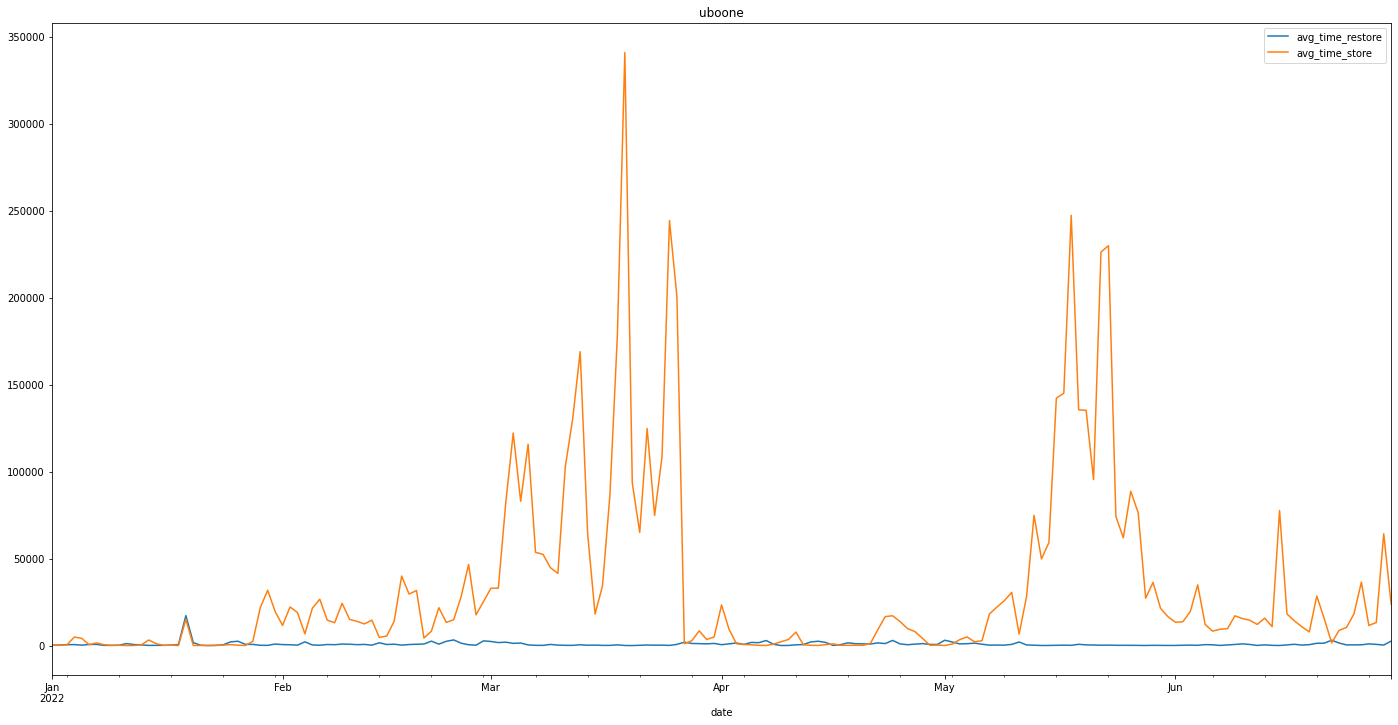

In [14]:
for vo, group in d.groupby('vo'):
    group.plot( x= 'date', title=vo, figsize=(24,12))

<AxesSubplot:title={'center':'ADMX'}, xlabel='date'>

<AxesSubplot:title={'center':'GM2'}, xlabel='date'>

<AxesSubplot:title={'center':'Simons'}, xlabel='date'>

<AxesSubplot:title={'center':'accelai'}, xlabel='date'>

<AxesSubplot:title={'center':'annie'}, xlabel='date'>

<AxesSubplot:title={'center':'backups'}, xlabel='date'>

<AxesSubplot:title={'center':'d0'}, xlabel='date'>

<AxesSubplot:title={'center':'damic'}, xlabel='date'>

<AxesSubplot:title={'center':'darkside'}, xlabel='date'>

<AxesSubplot:title={'center':'des'}, xlabel='date'>

<AxesSubplot:title={'center':'dune'}, xlabel='date'>

<AxesSubplot:title={'center':'e1039'}, xlabel='date'>

<AxesSubplot:title={'center':'e906'}, xlabel='date'>

<AxesSubplot:title={'center':'fermigrid'}, xlabel='date'>

<AxesSubplot:title={'center':'icarus'}, xlabel='date'>

<AxesSubplot:title={'center':'lariat'}, xlabel='date'>

<AxesSubplot:title={'center':'lqcd'}, xlabel='date'>

<AxesSubplot:title={'center':'minerva'}, xlabel='date'>

<AxesSubplot:title={'center':'minos'}, xlabel='date'>

<AxesSubplot:title={'center':'mu2e'}, xlabel='date'>

/usr/local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<AxesSubplot:title={'center':'netflow'}, xlabel='date'>

<AxesSubplot:title={'center':'next'}, xlabel='date'>

<AxesSubplot:title={'center':'none'}, xlabel='date'>

<AxesSubplot:title={'center':'nova'}, xlabel='date'>

<AxesSubplot:title={'center':'numix'}, xlabel='date'>

<AxesSubplot:title={'center':'sbnd'}, xlabel='date'>

<AxesSubplot:title={'center':'scope'}, xlabel='date'>

<AxesSubplot:title={'center':'snoplus'}, xlabel='date'>

<AxesSubplot:title={'center':'test'}, xlabel='date'>

<AxesSubplot:title={'center':'test2'}, xlabel='date'>

<AxesSubplot:title={'center':'uboone'}, xlabel='date'>

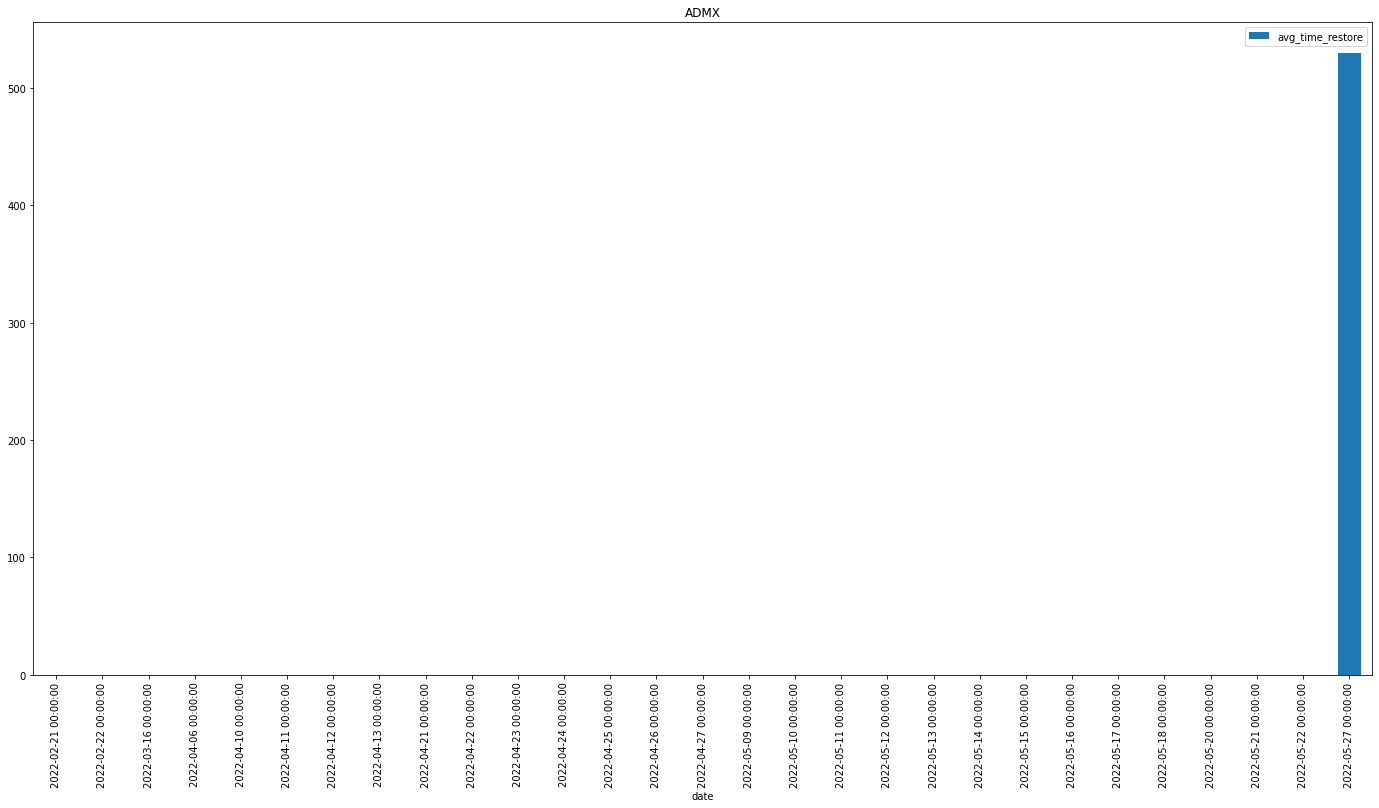

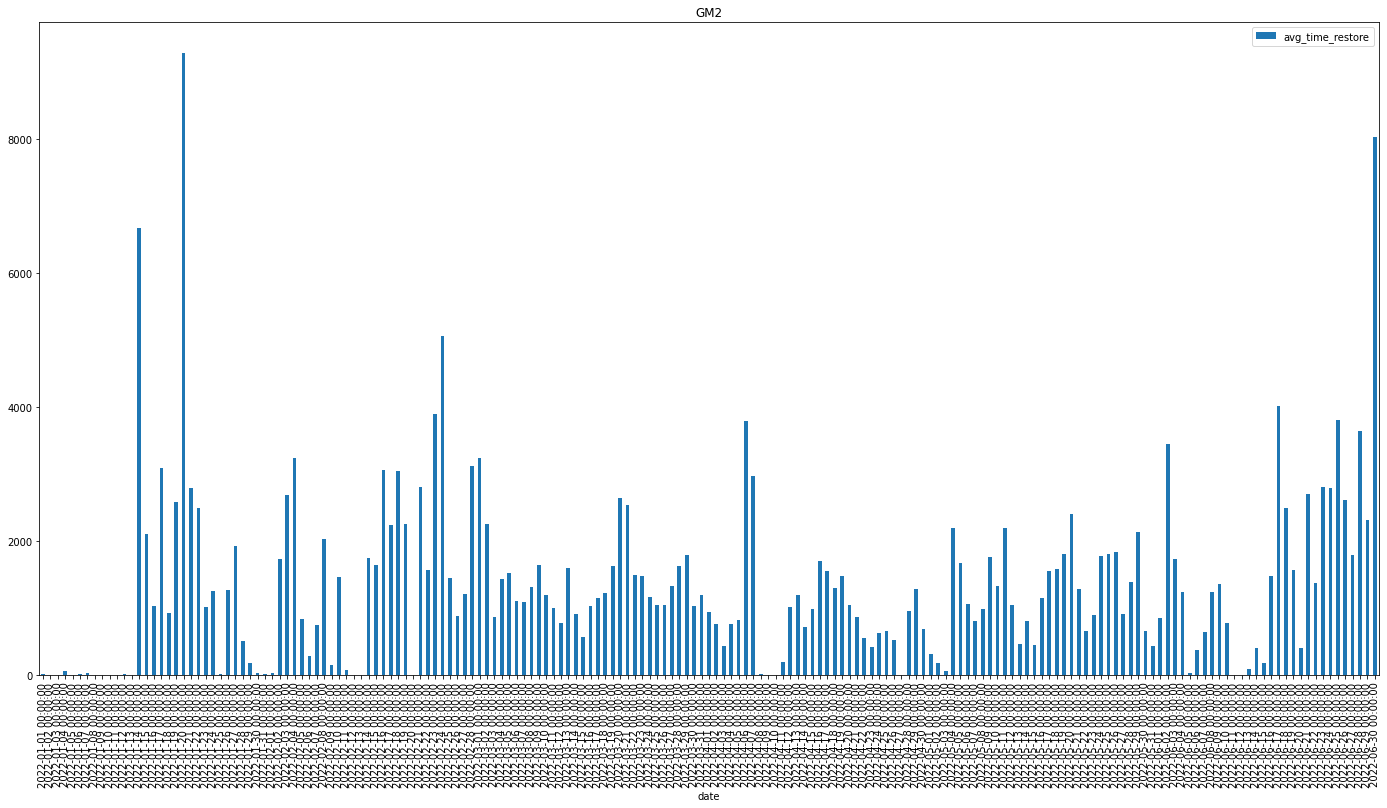

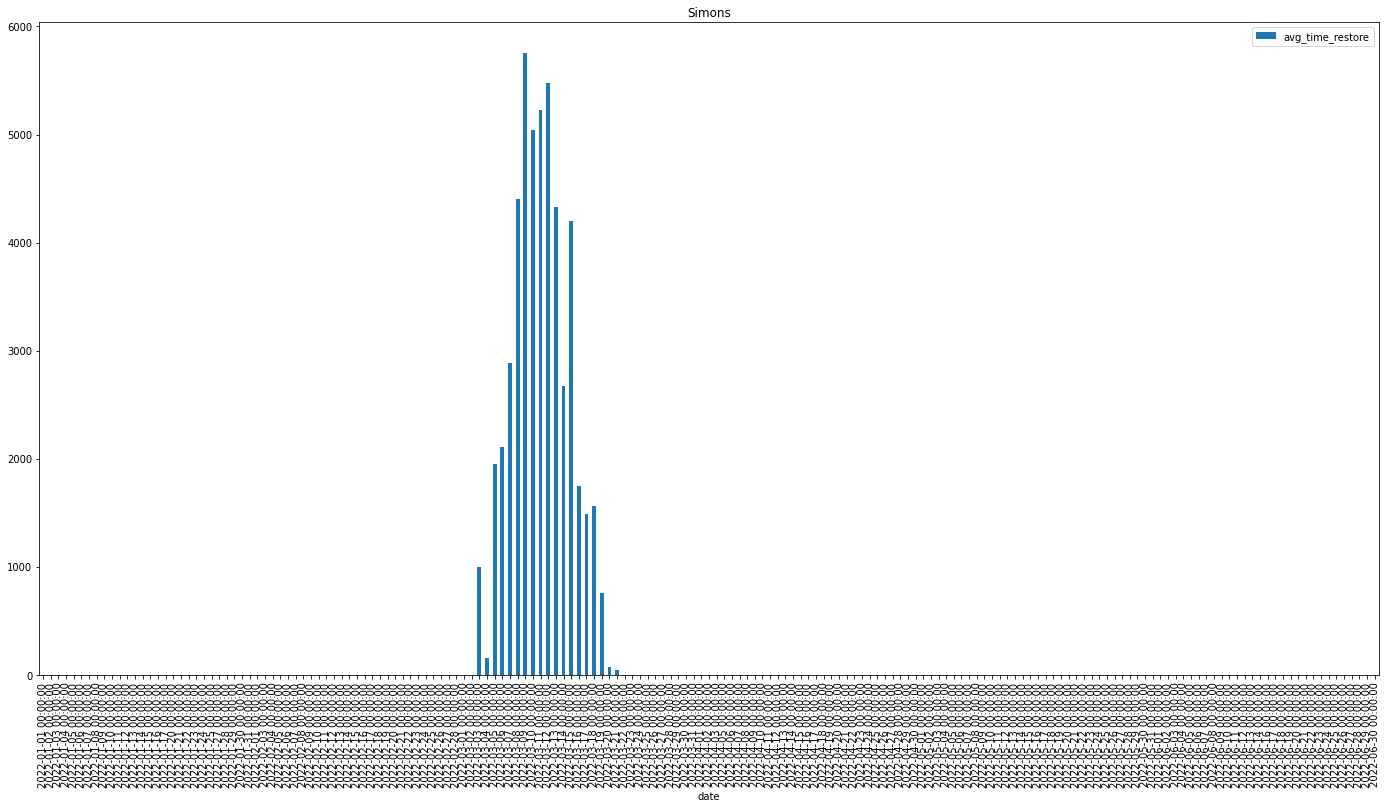

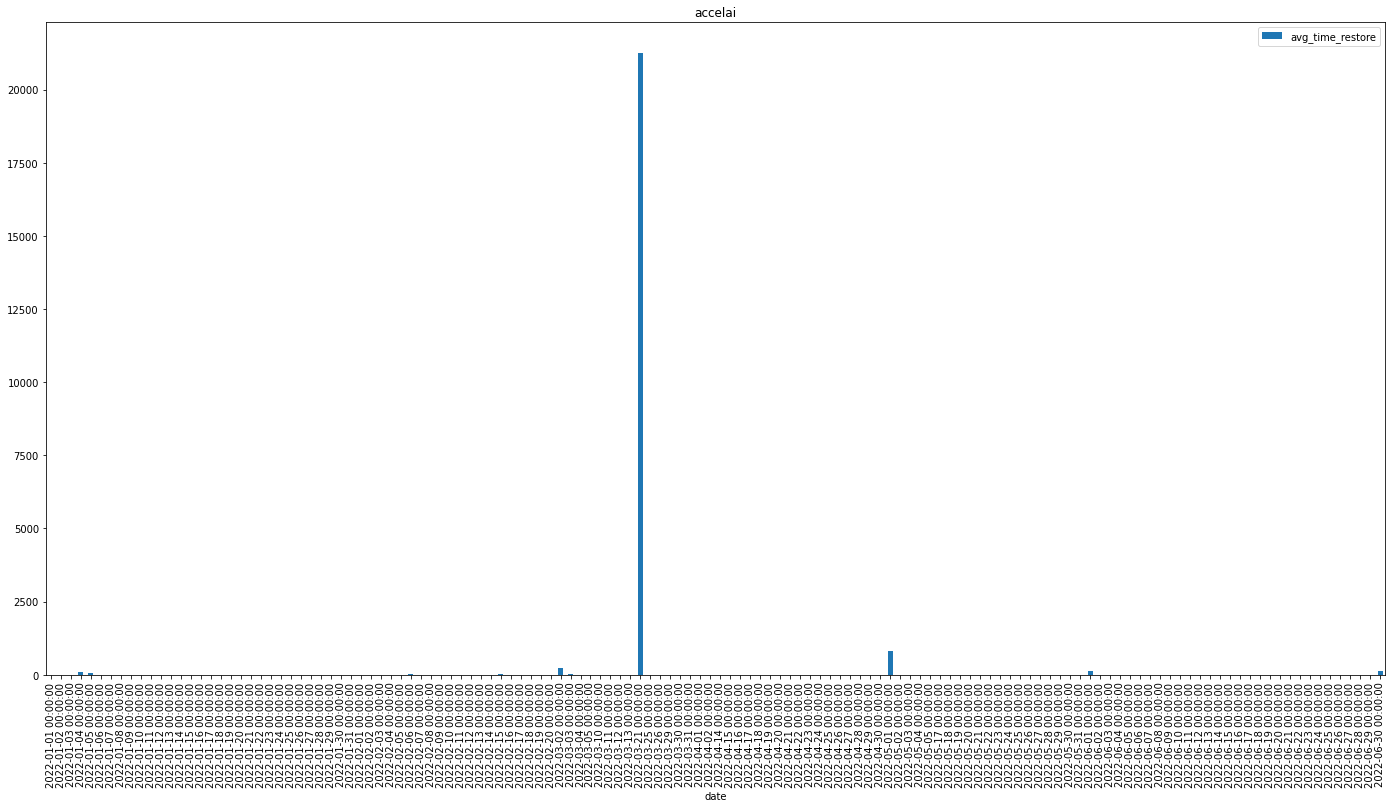

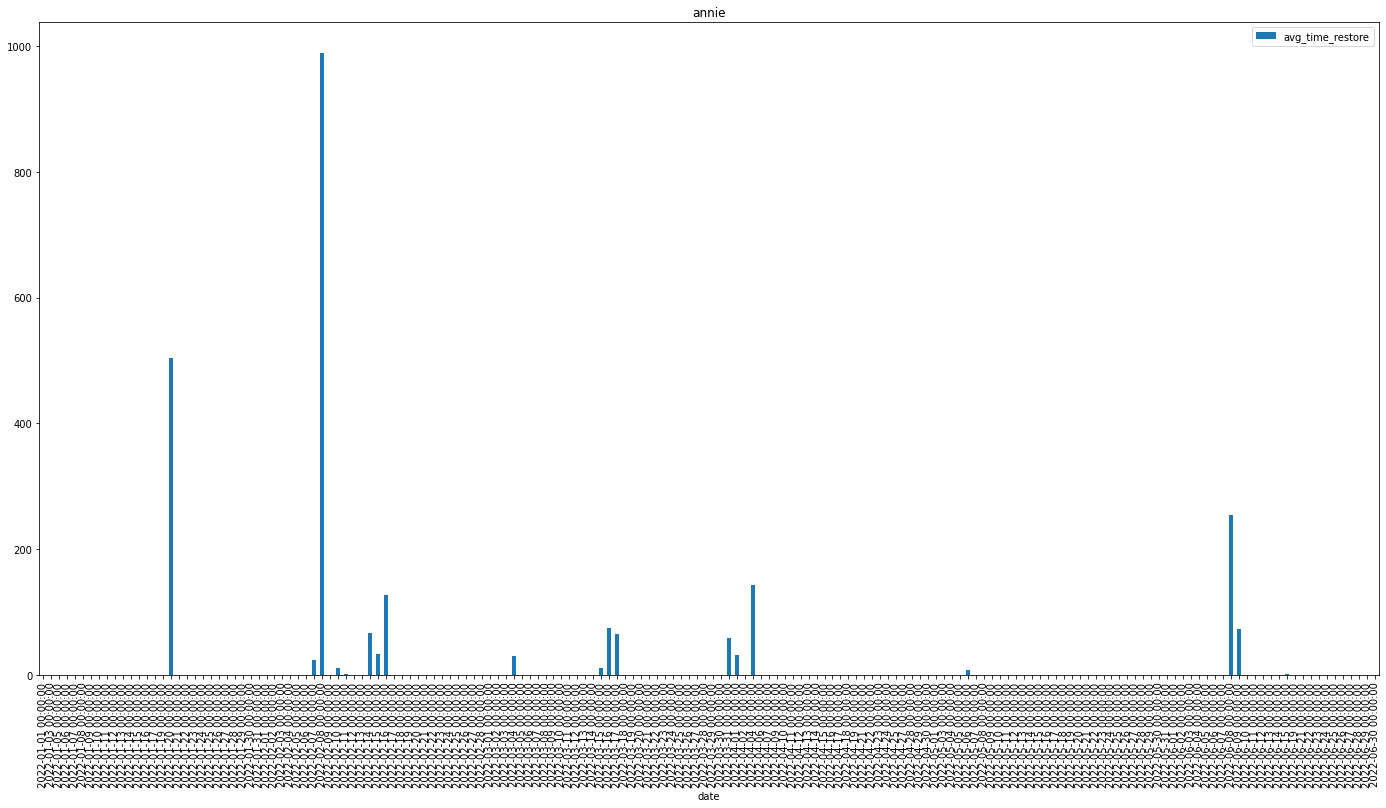

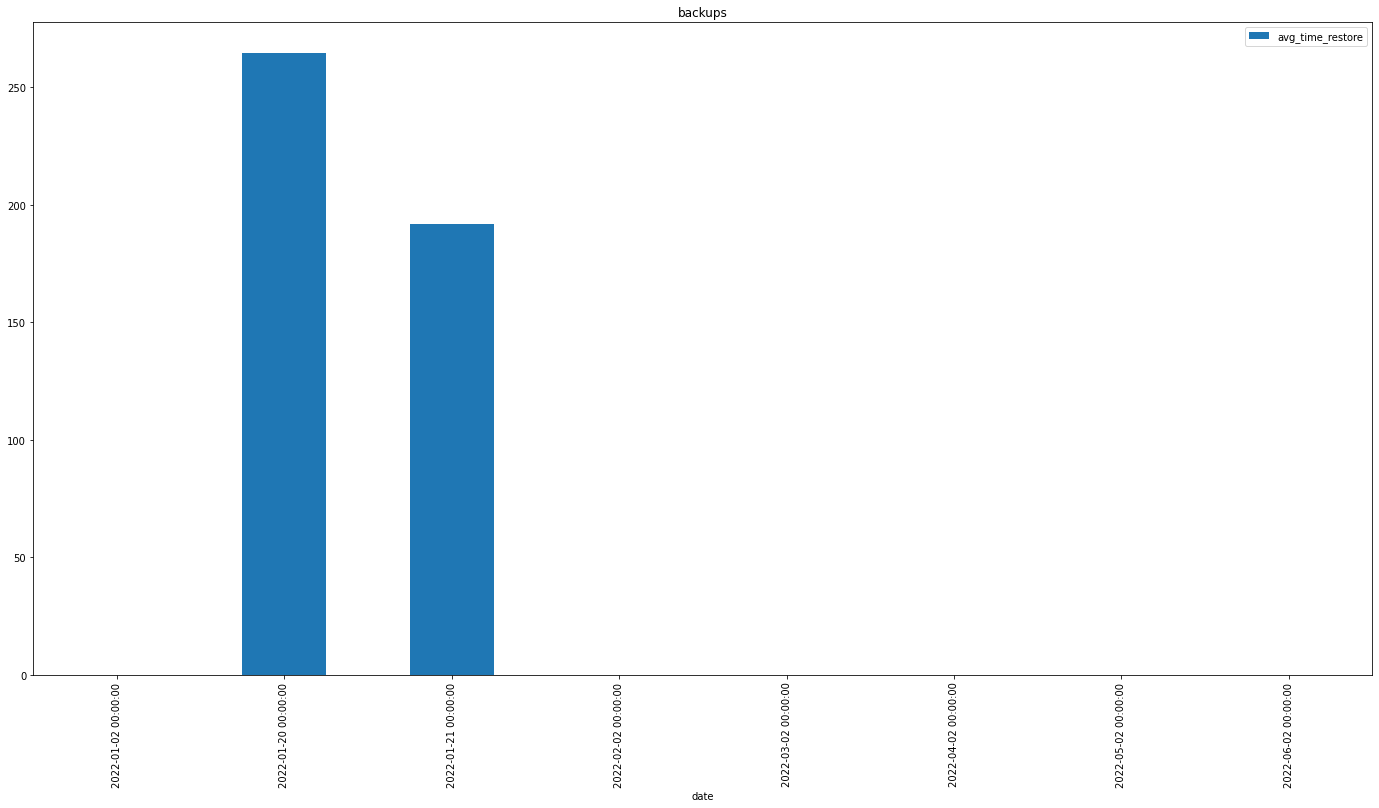

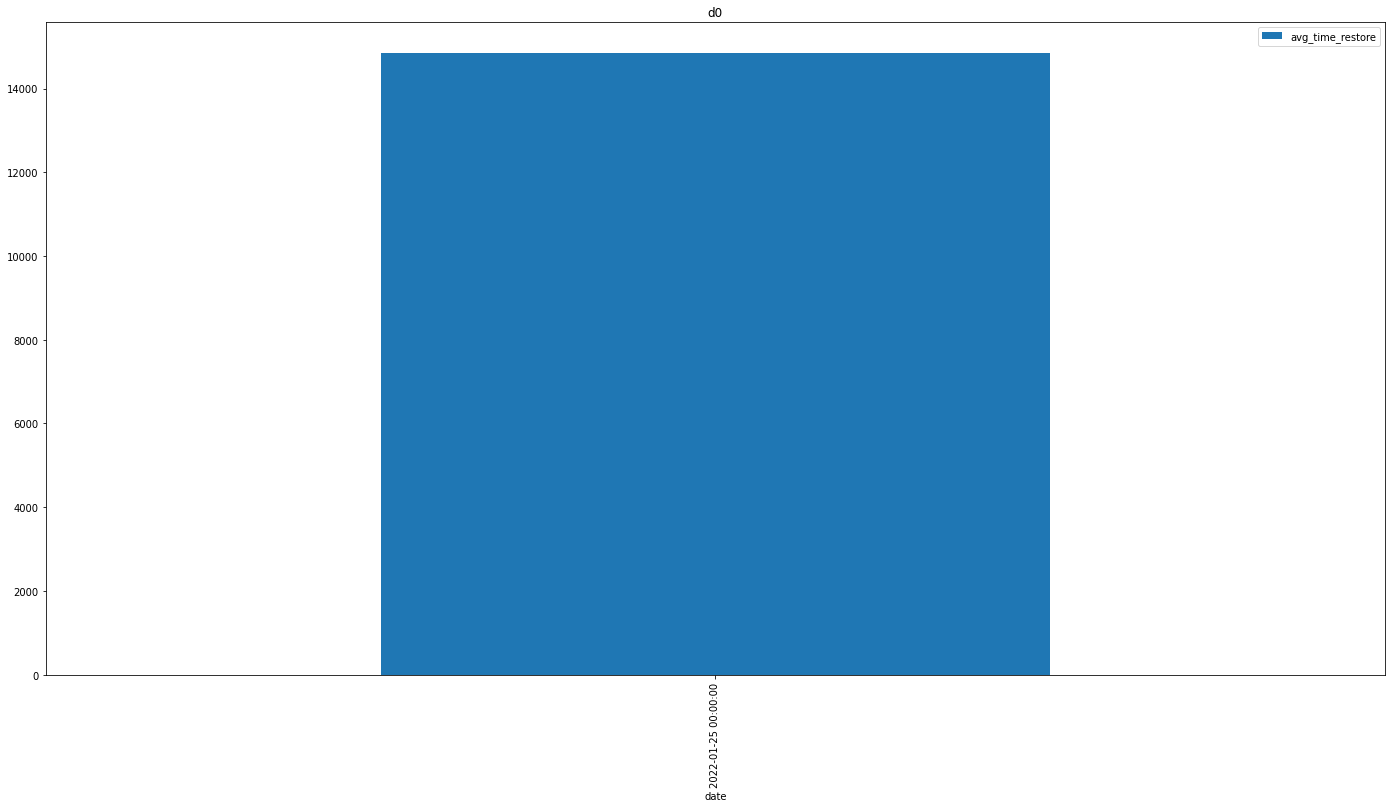

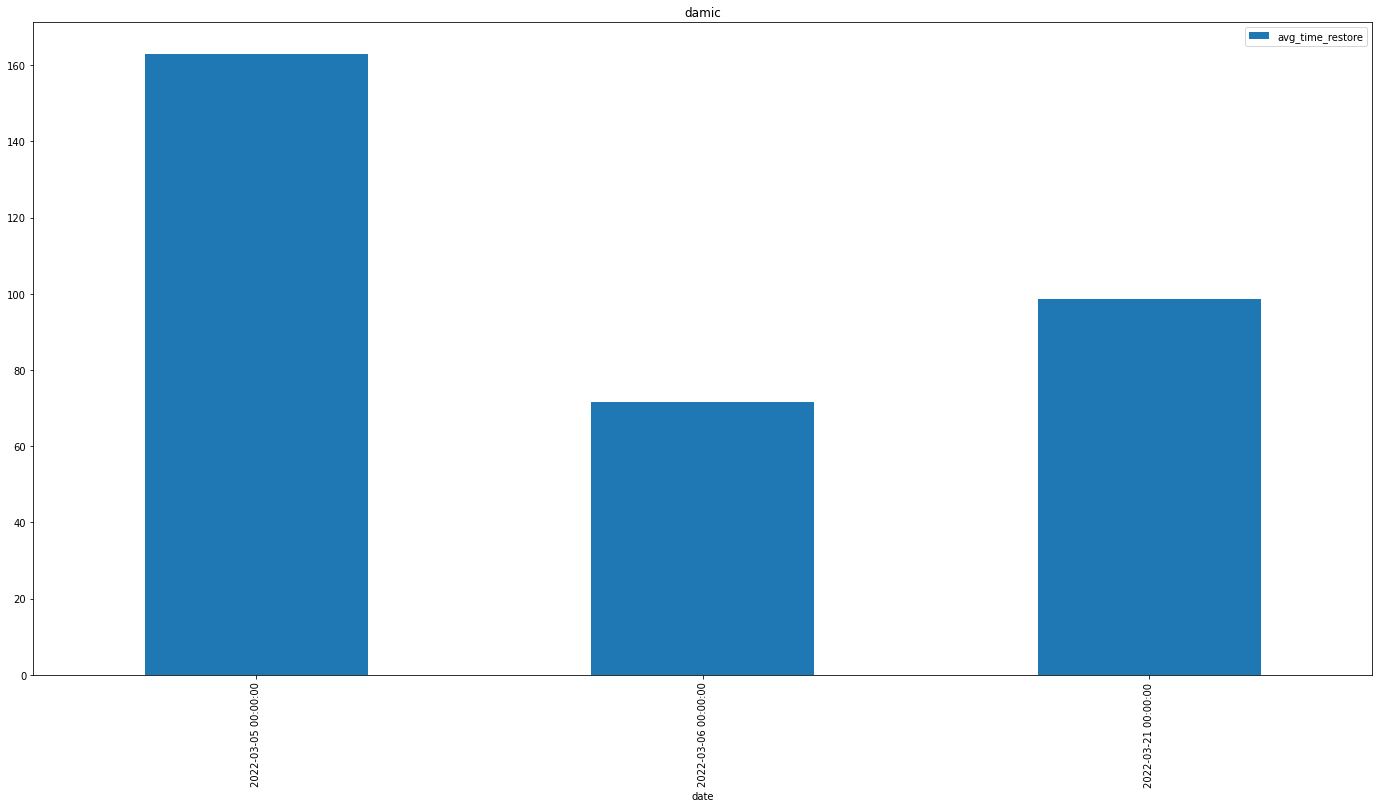

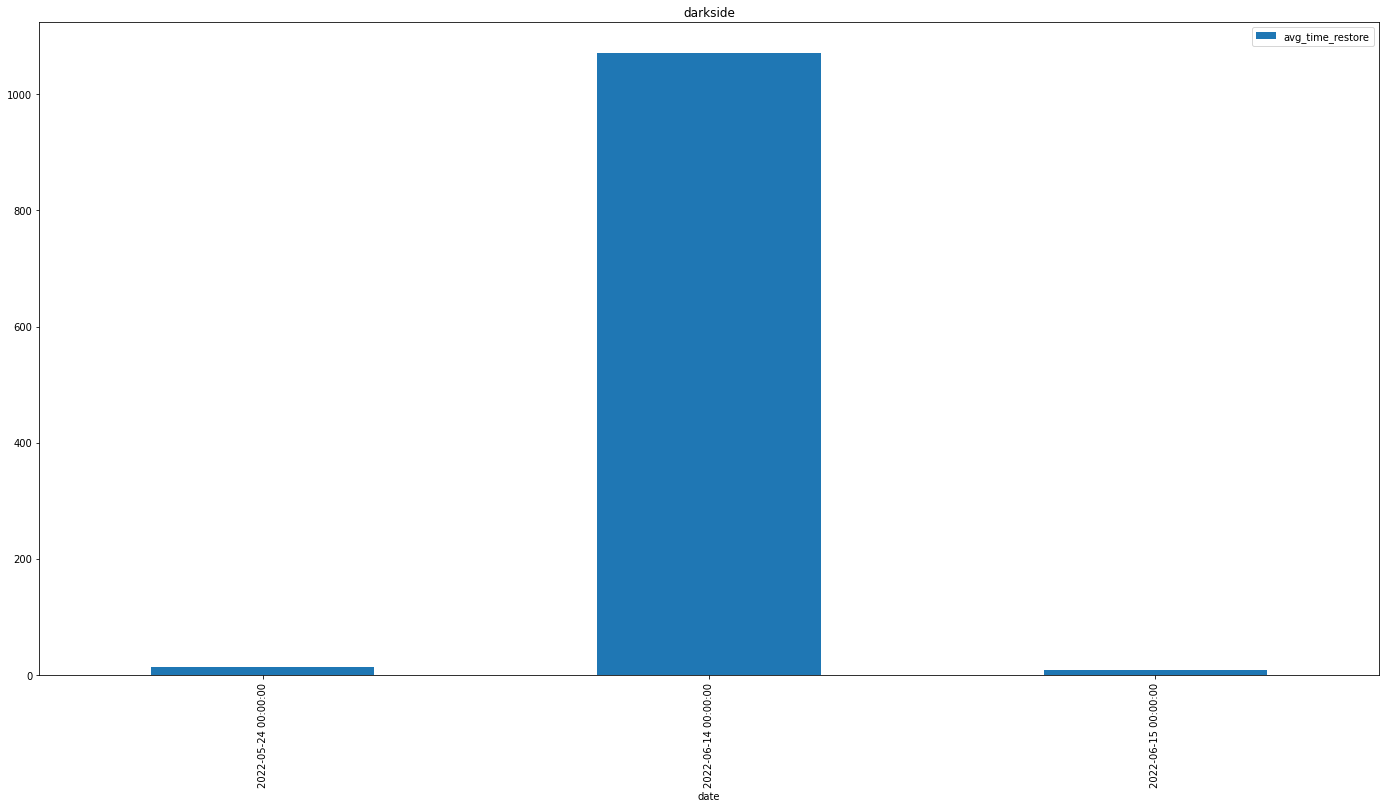

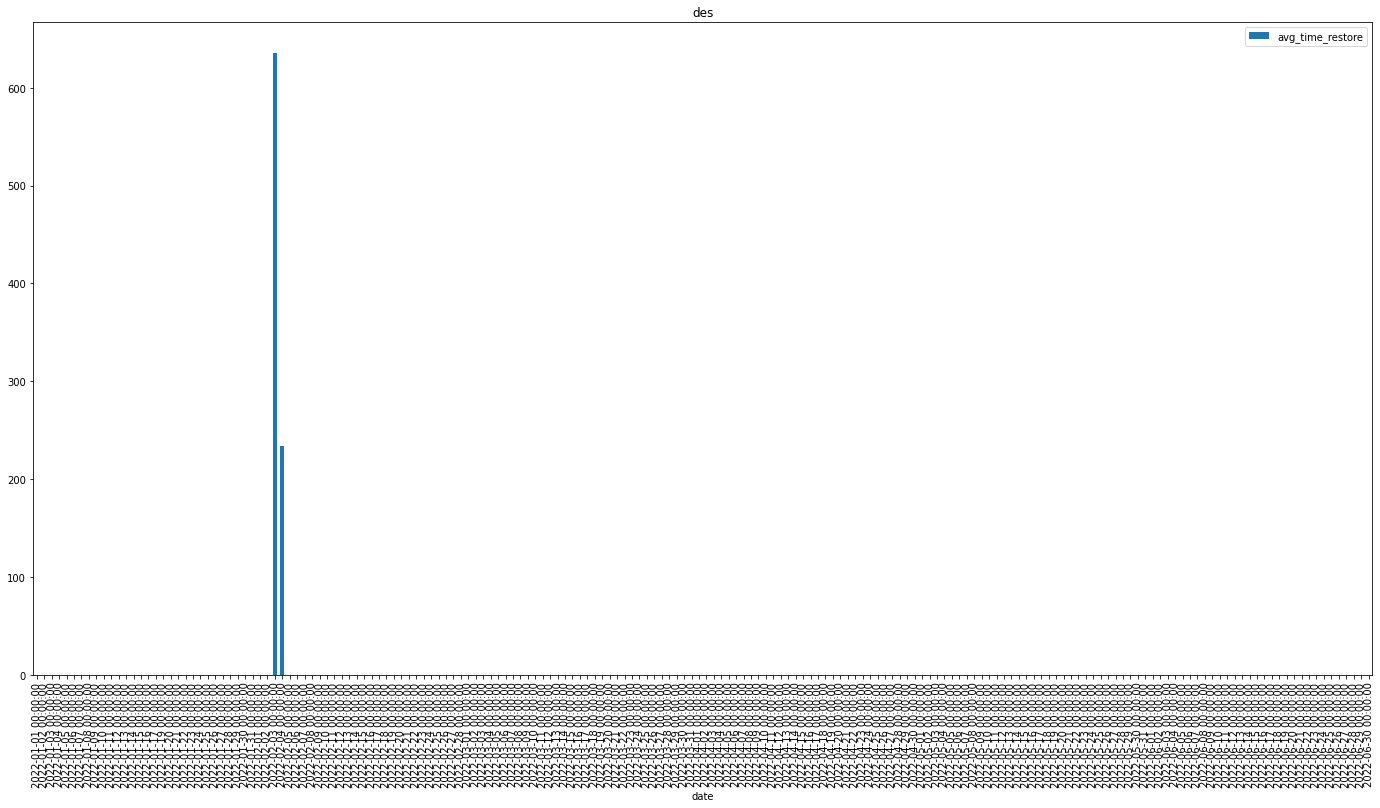

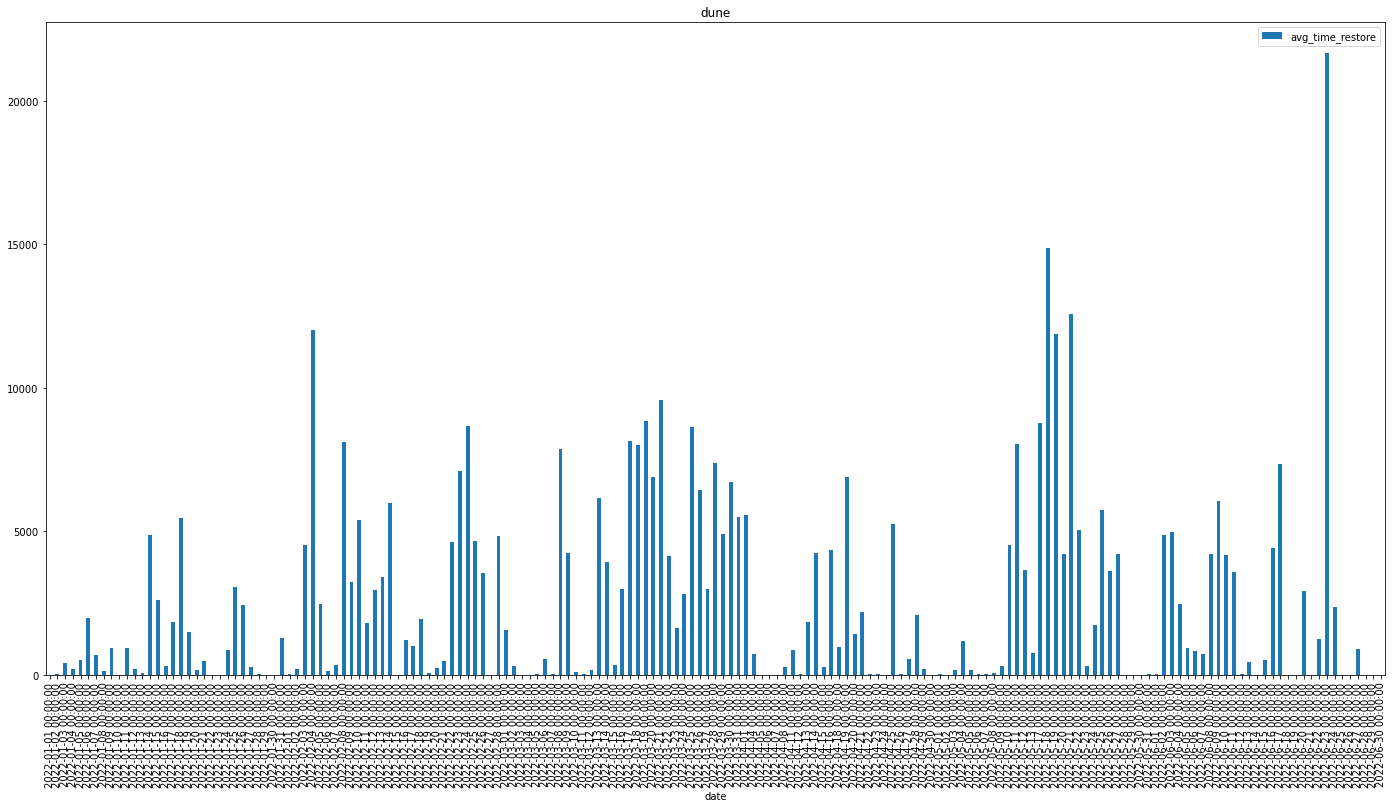

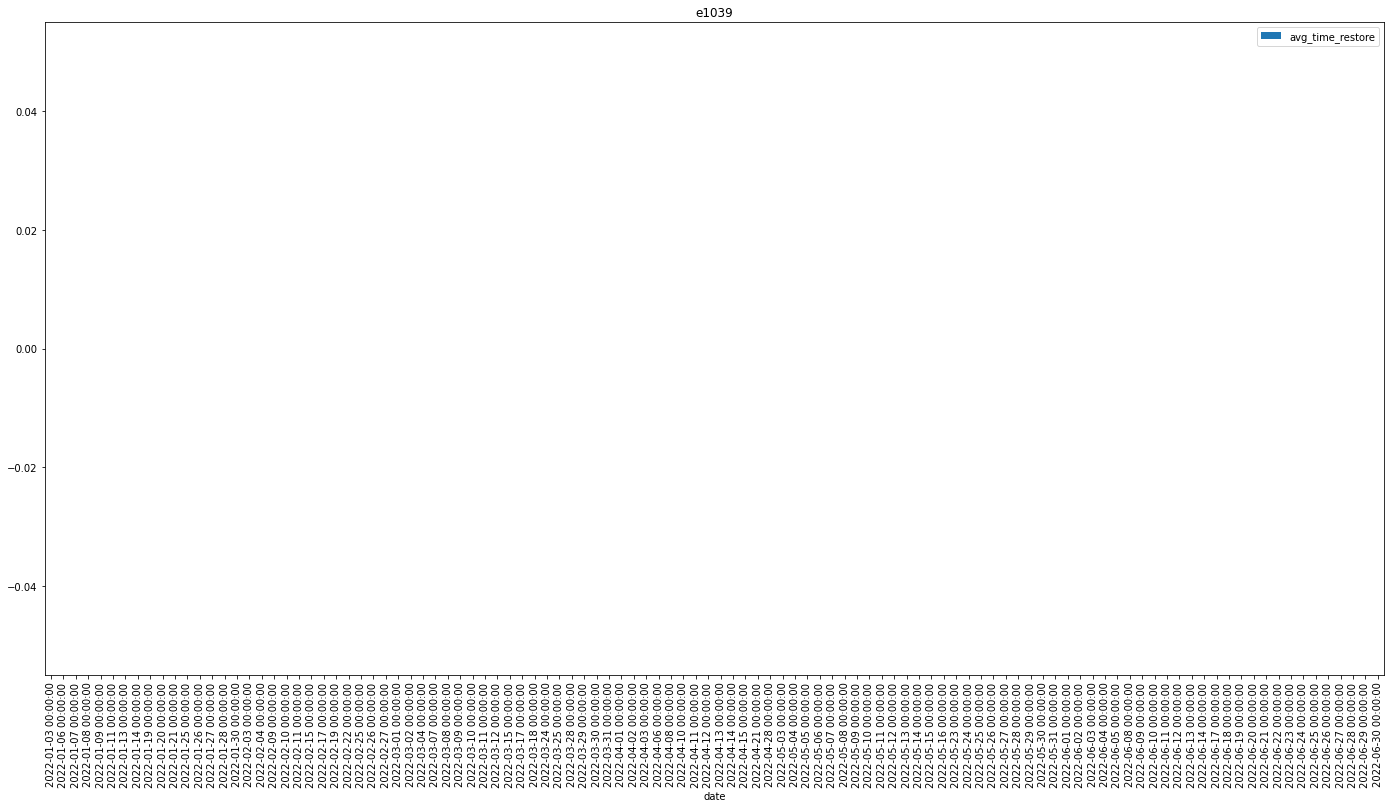

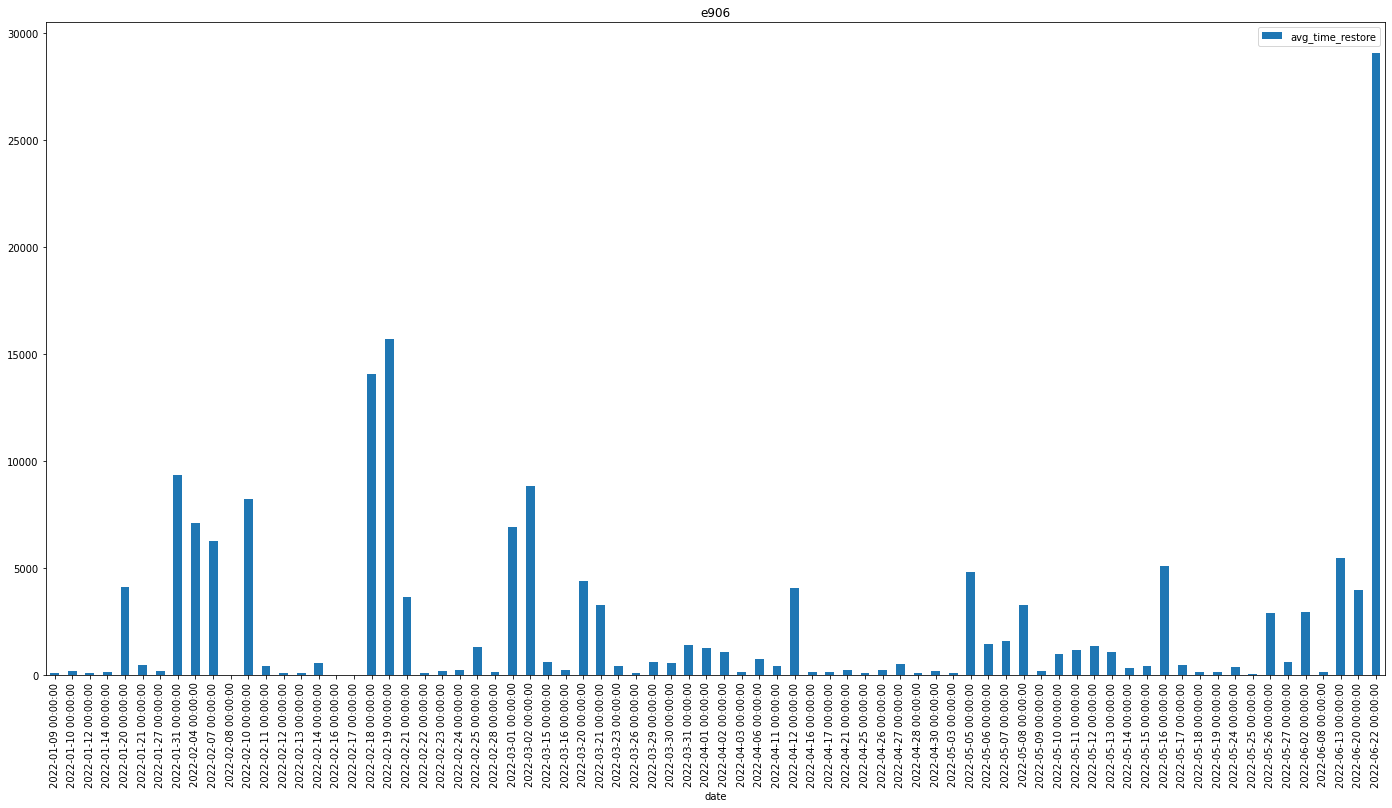

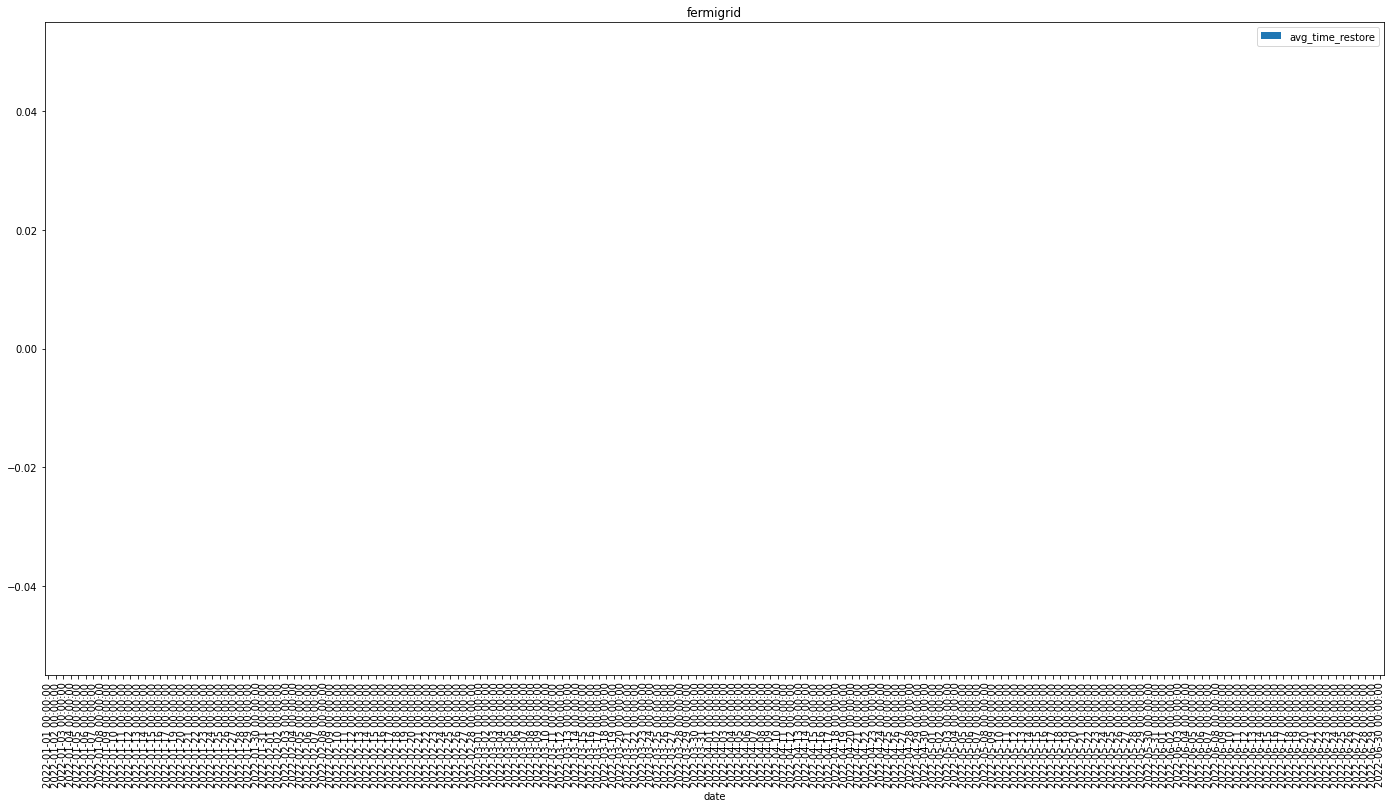

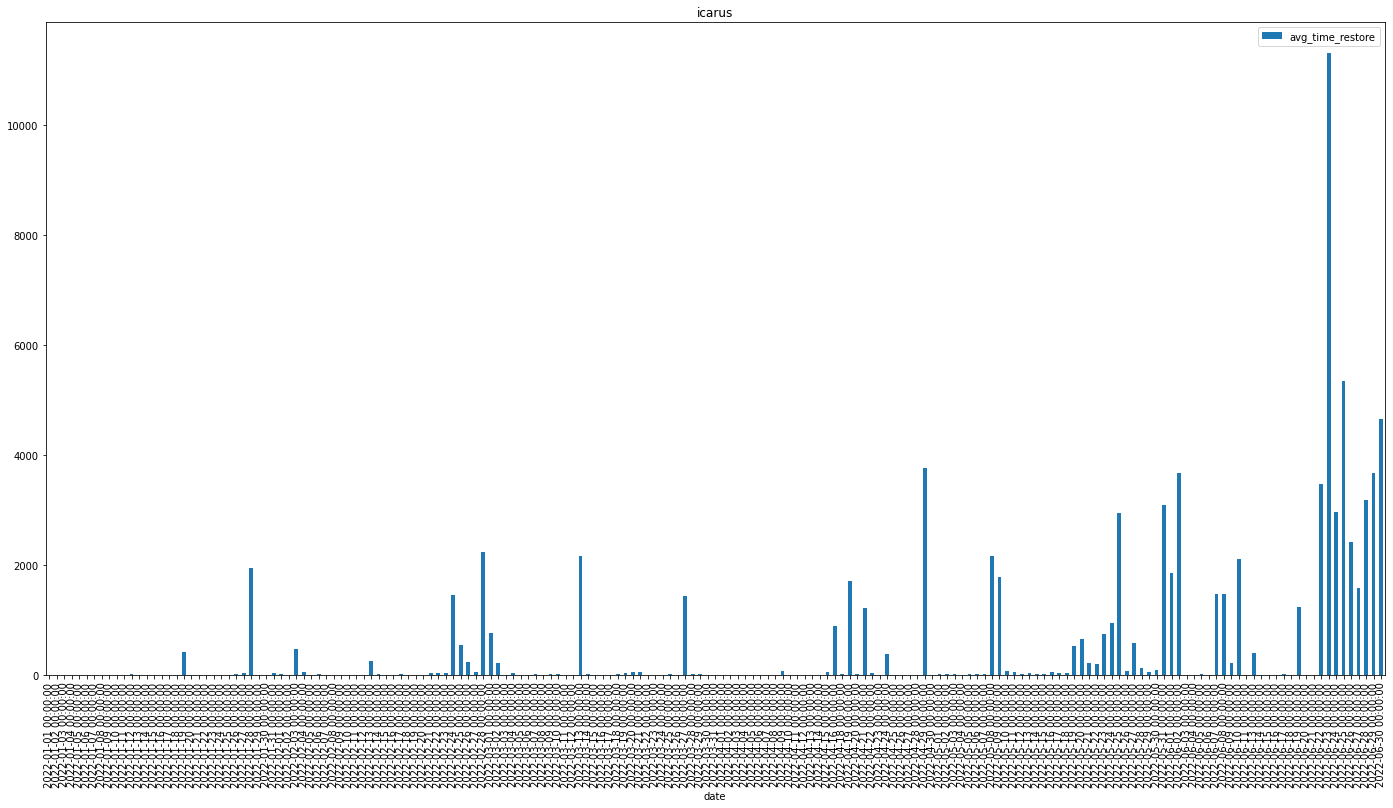

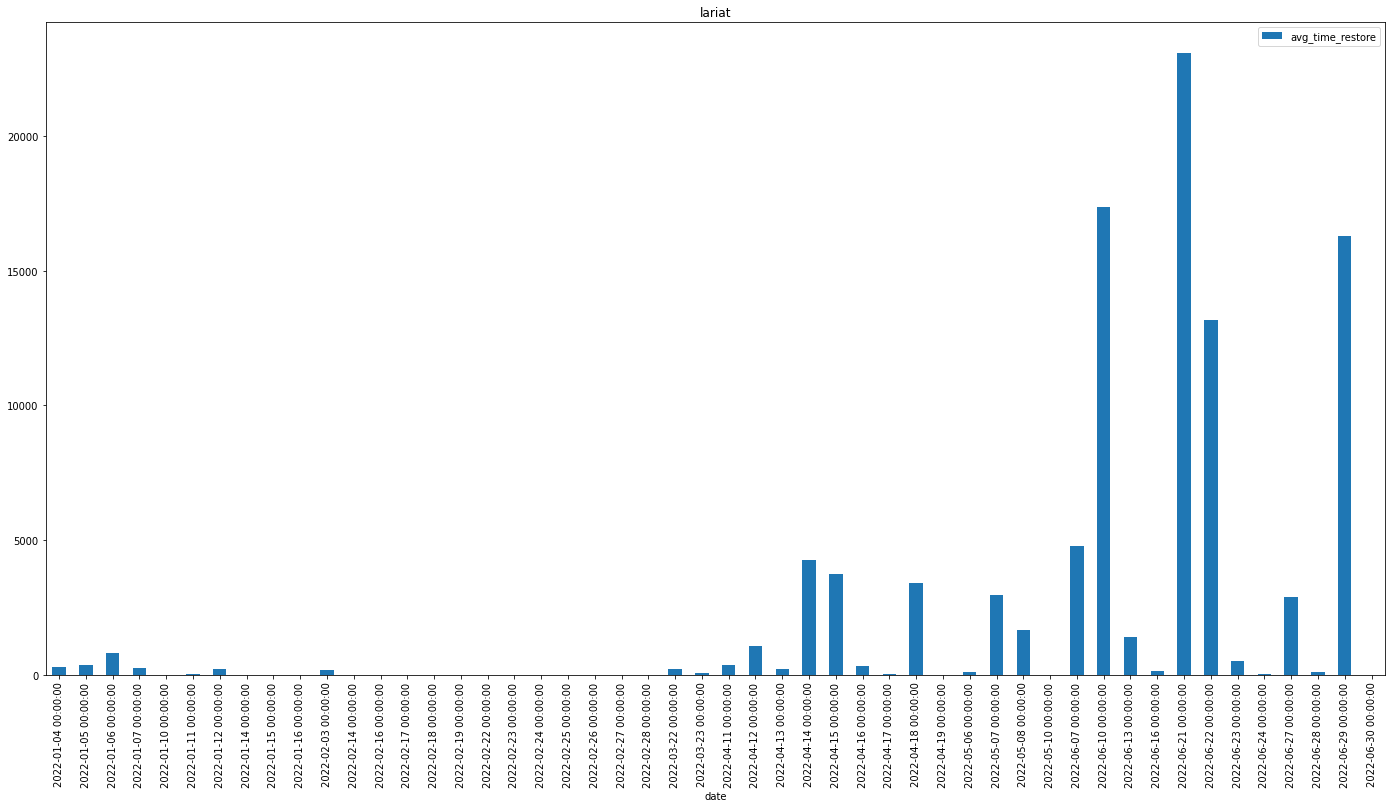

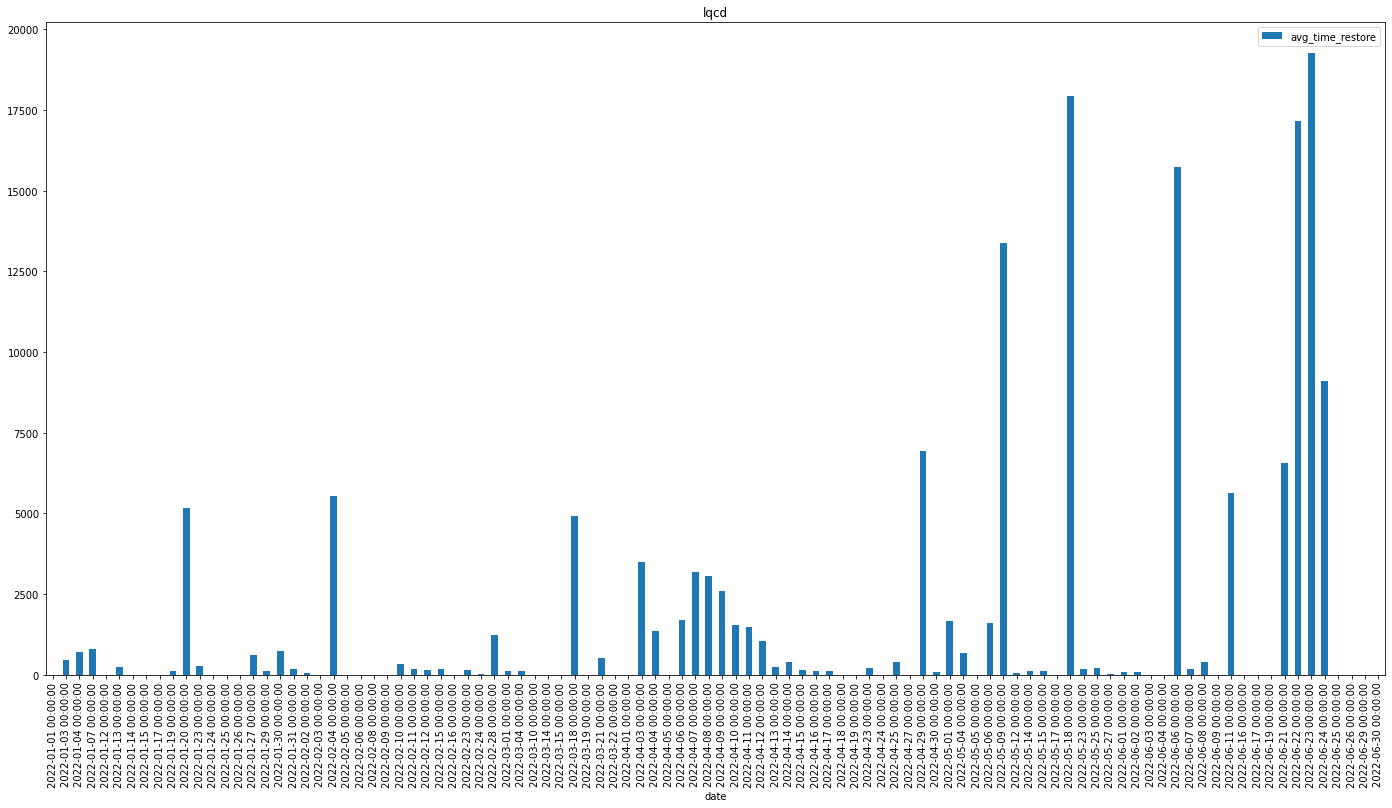

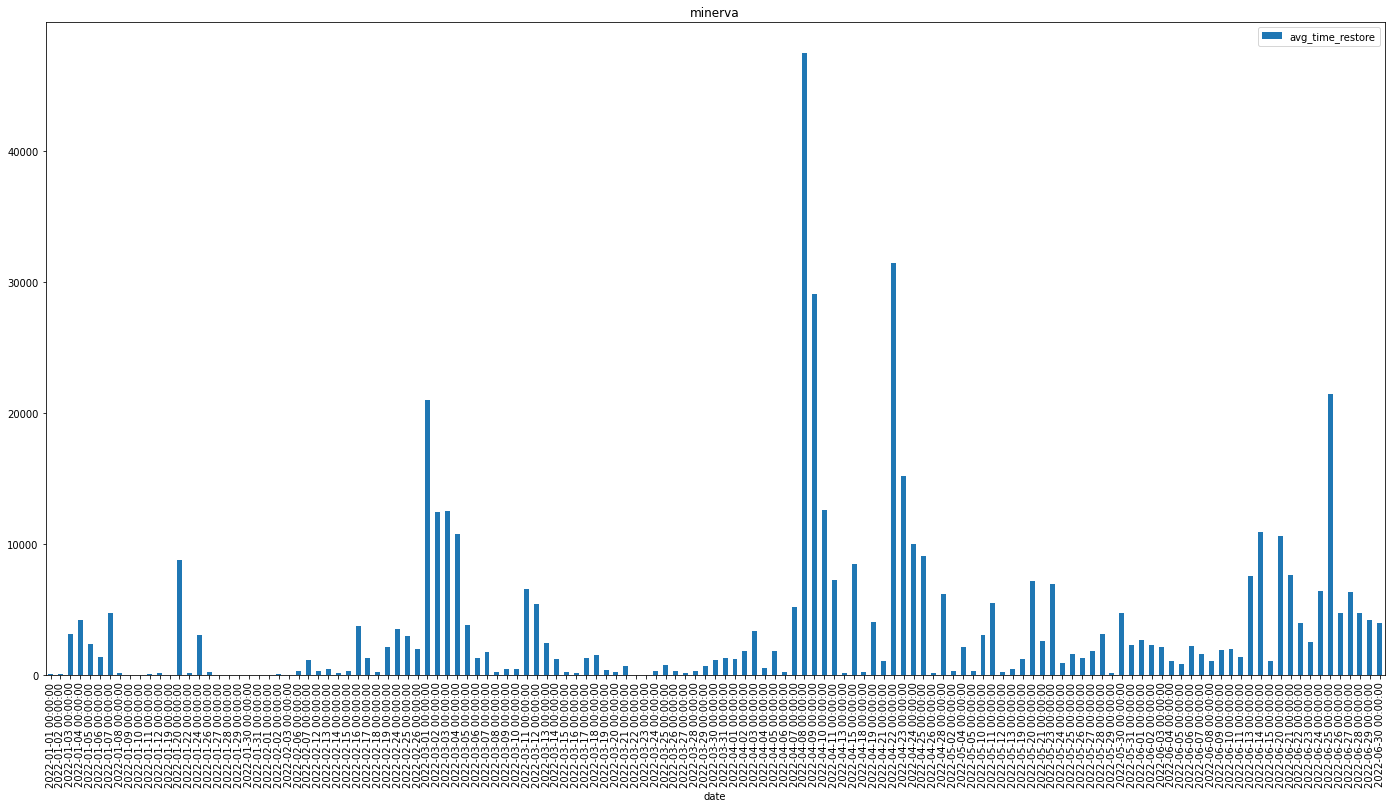

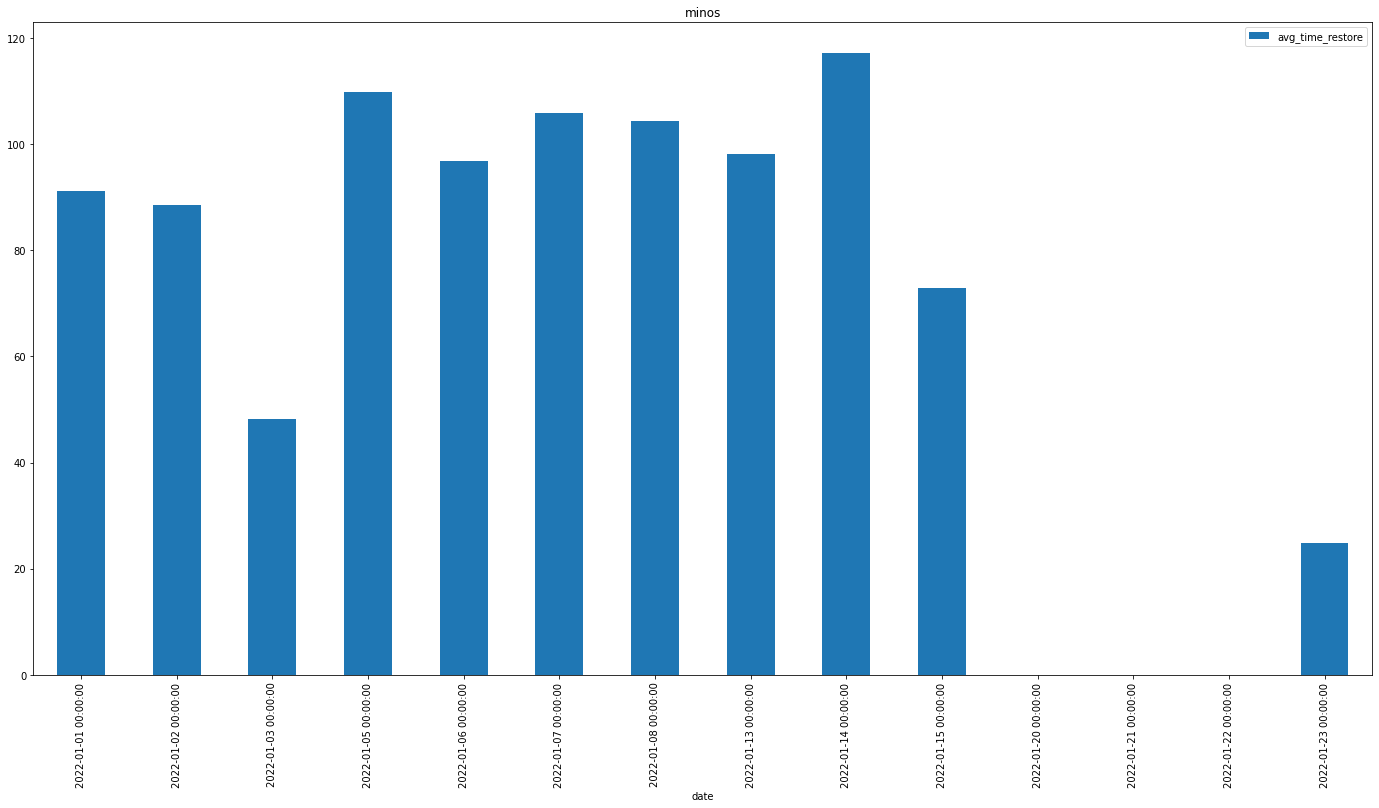

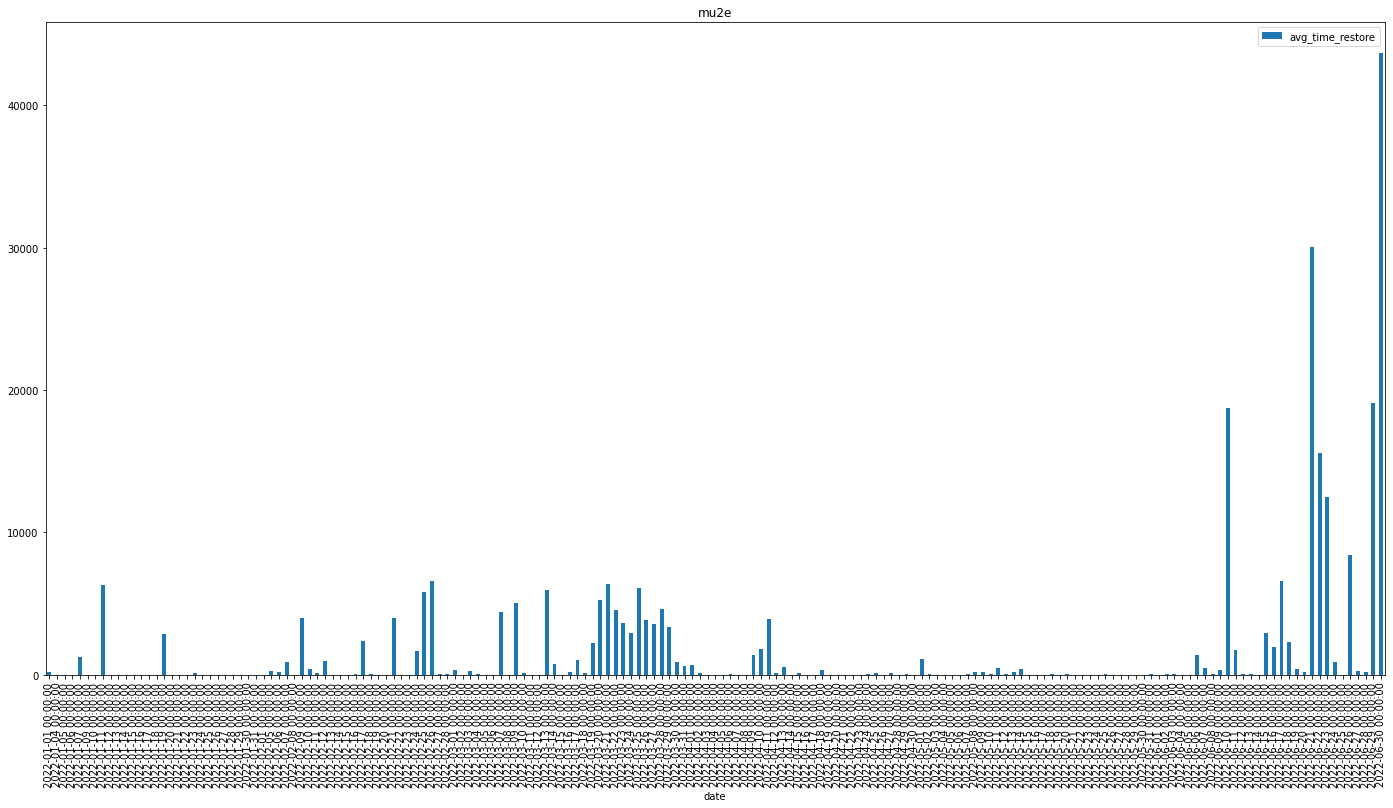

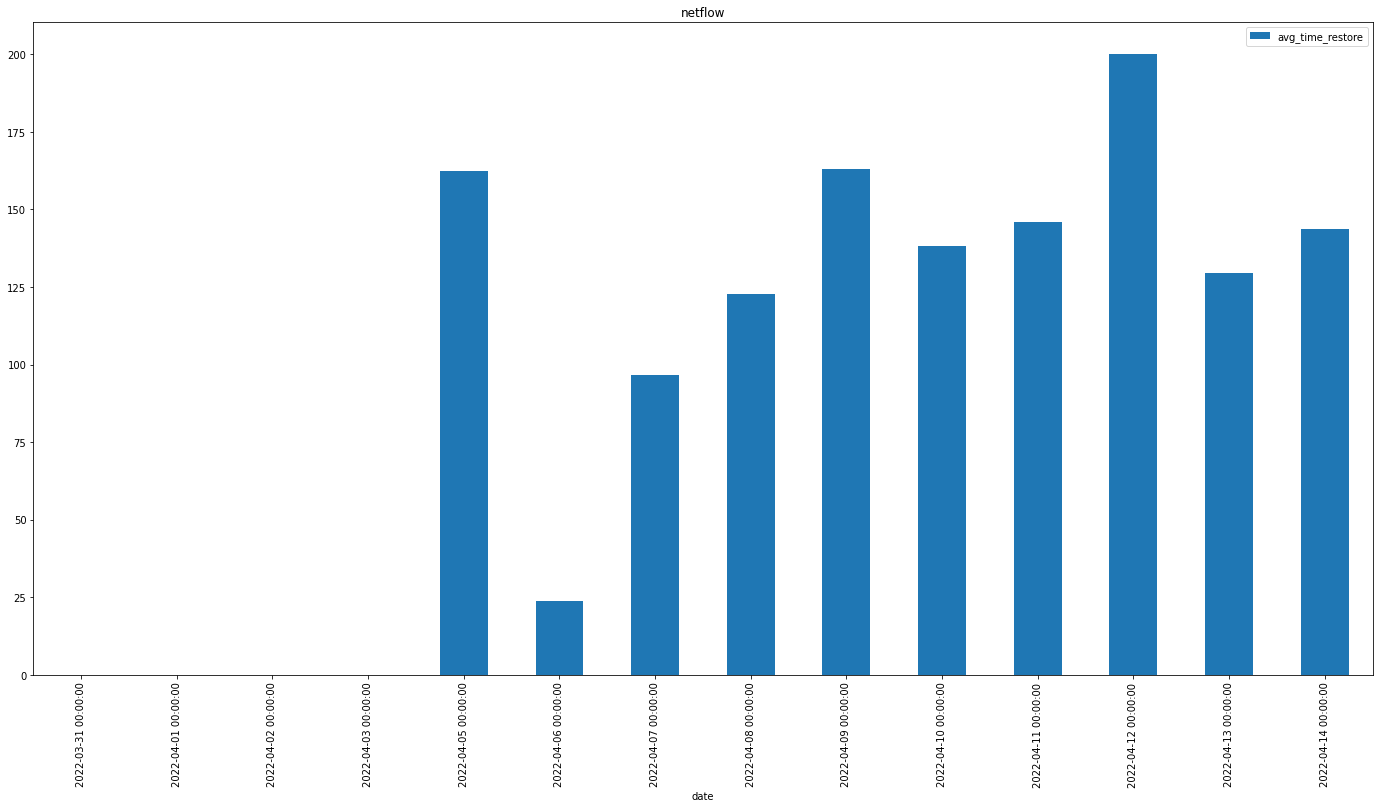

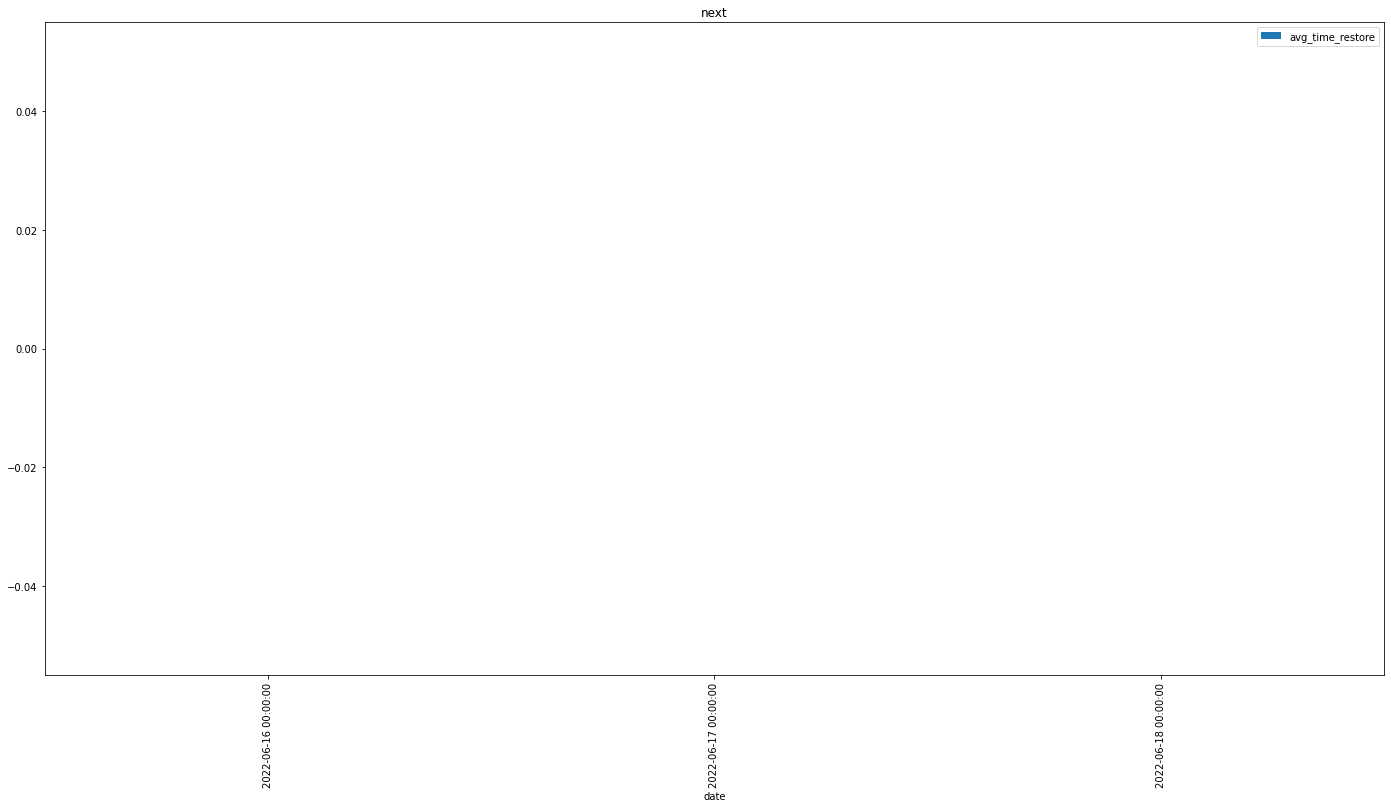

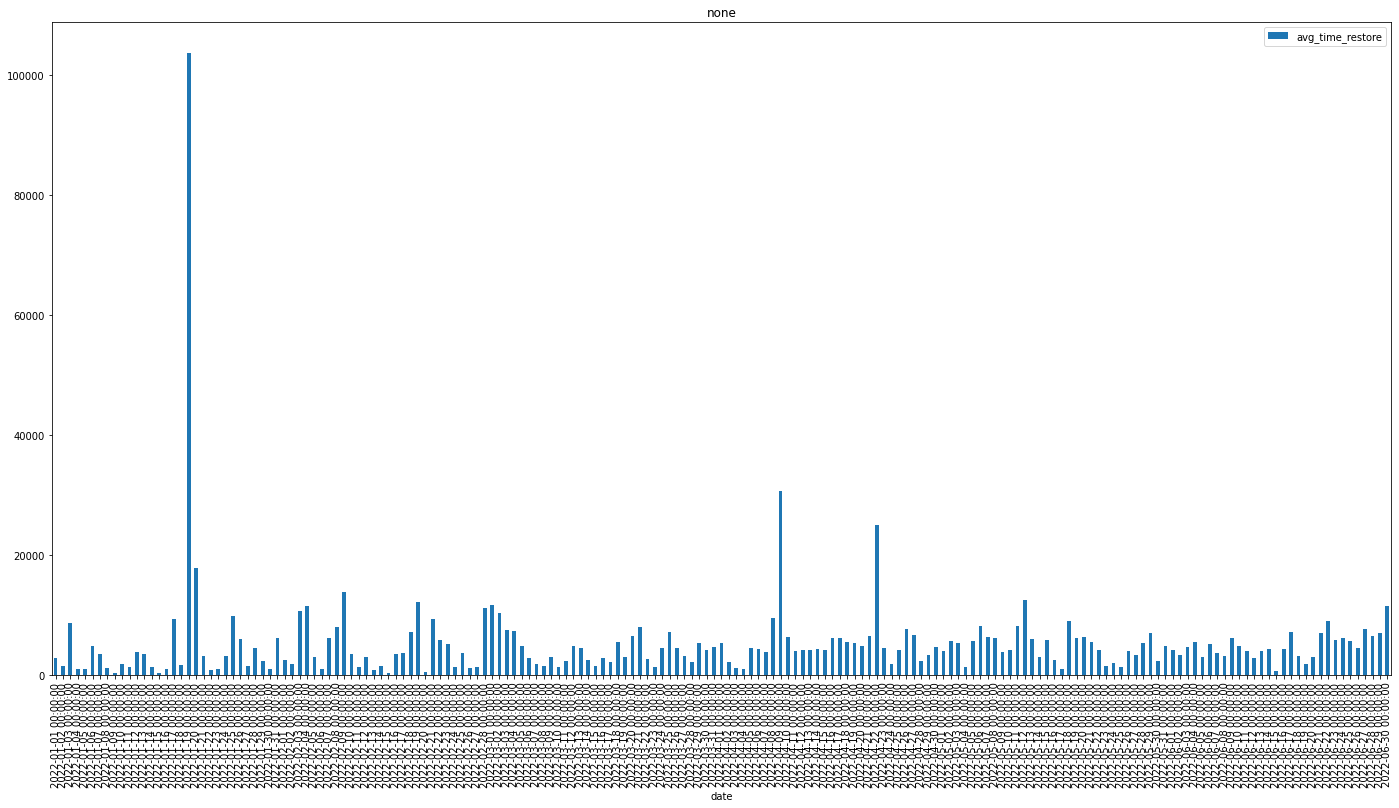

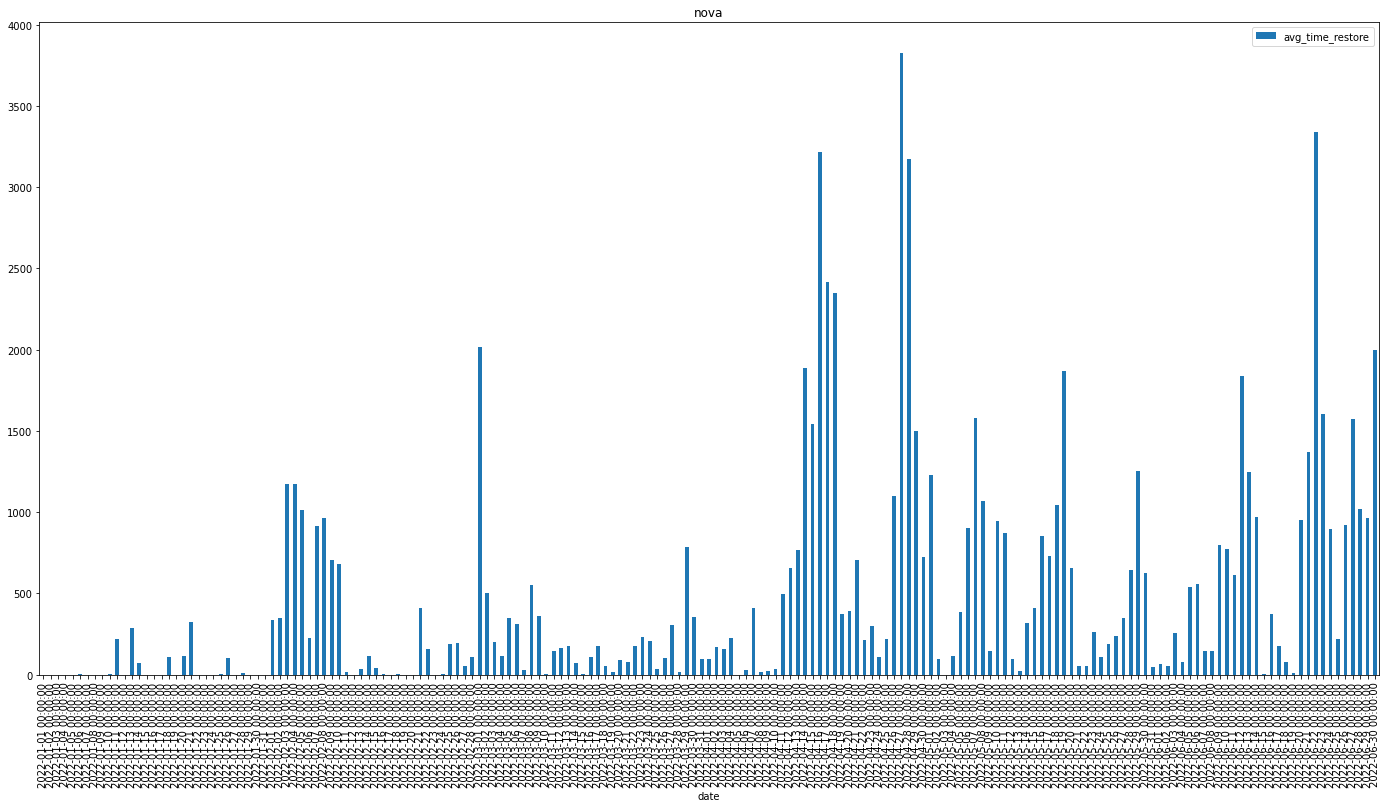

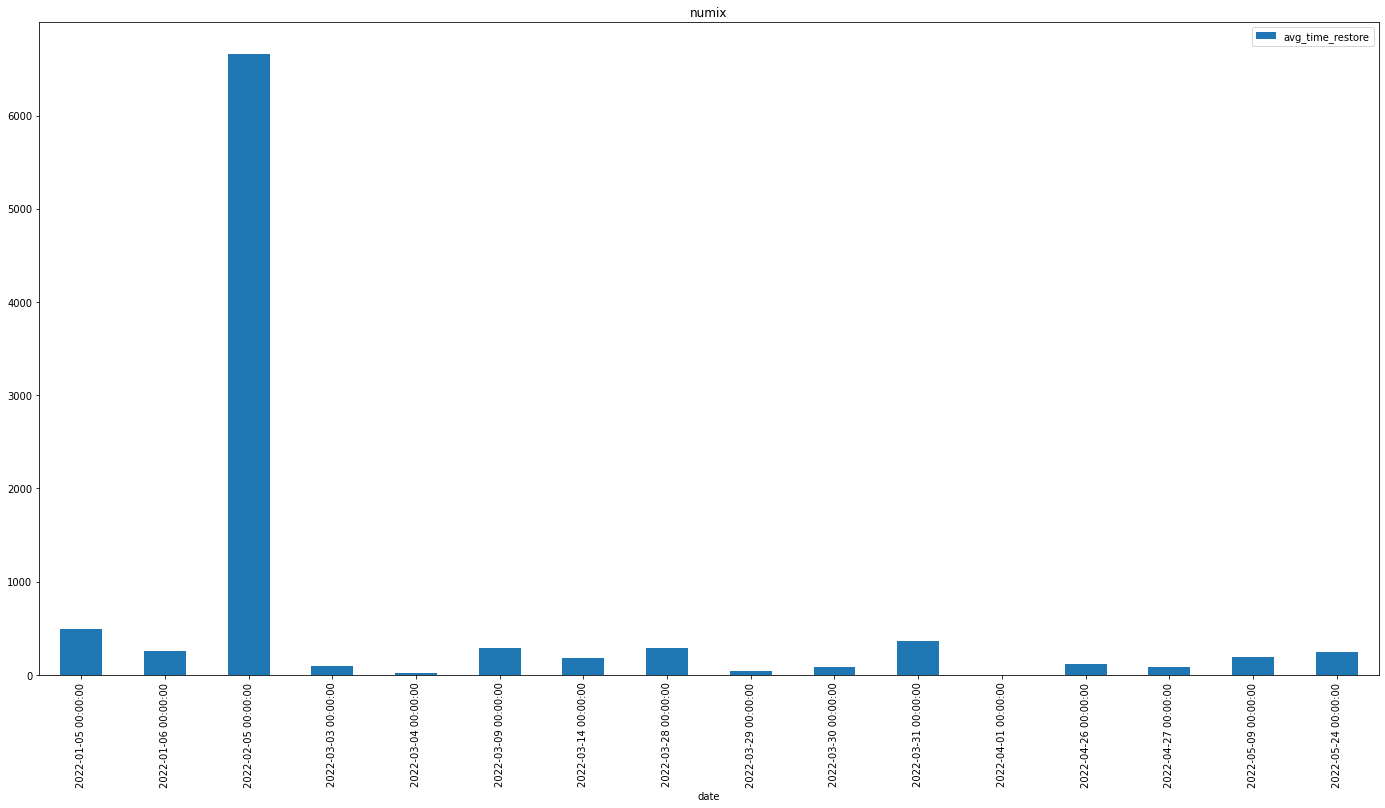

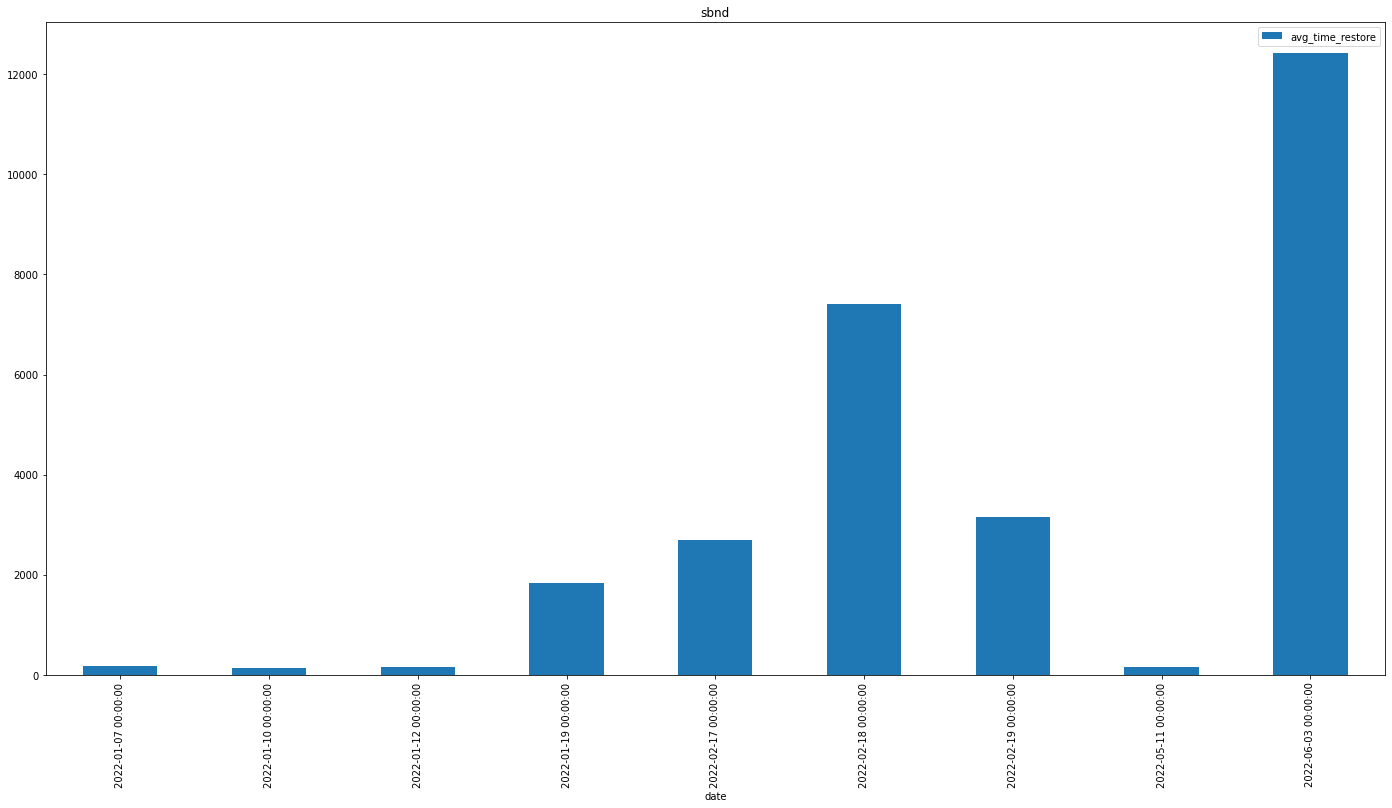

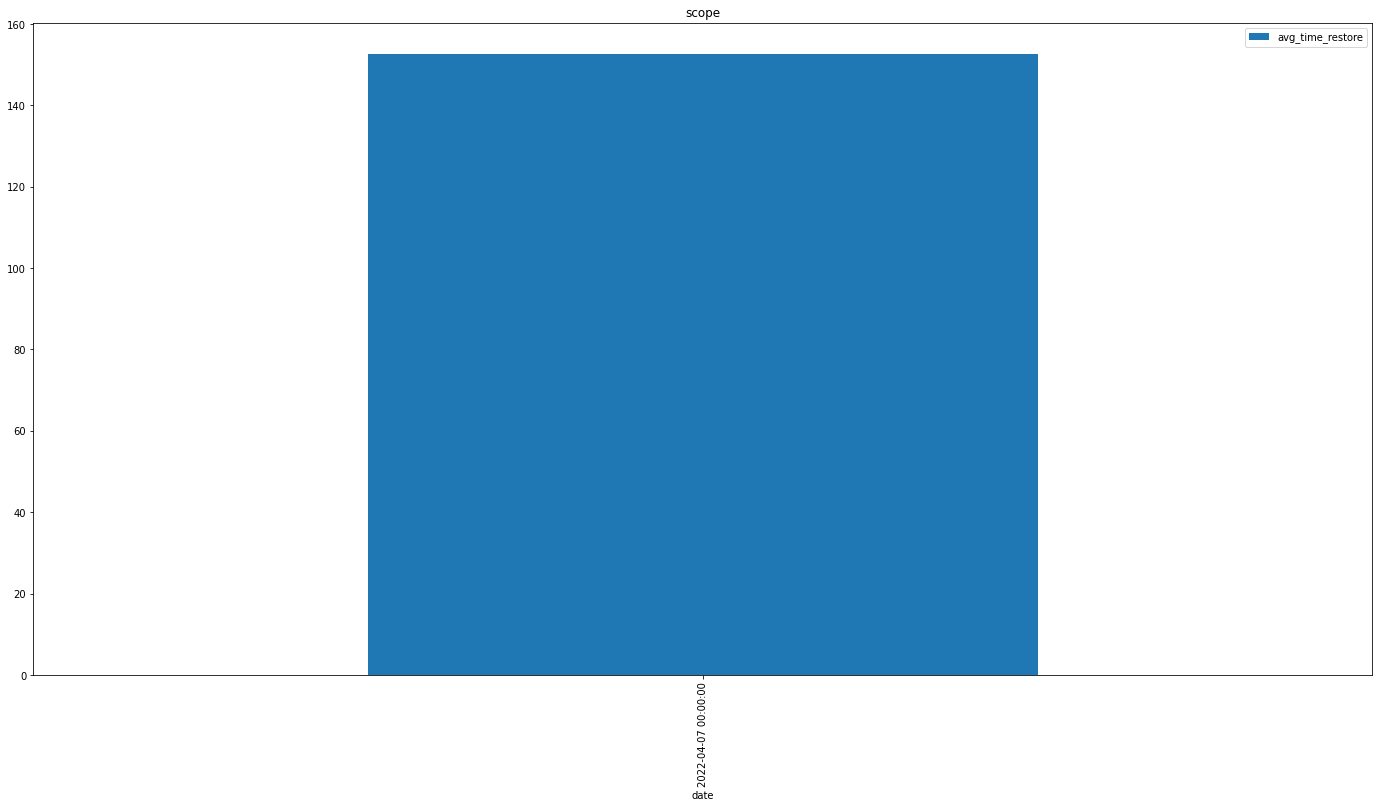

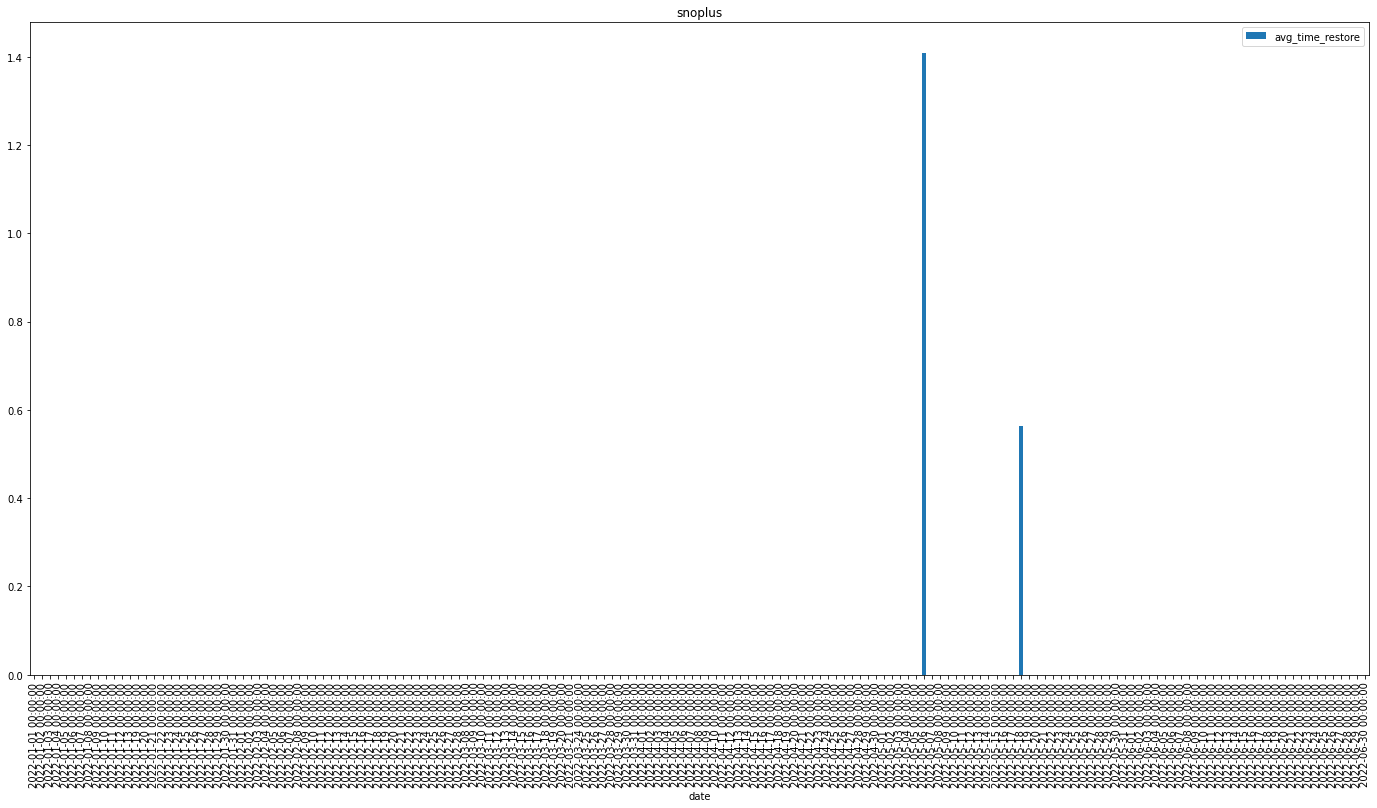

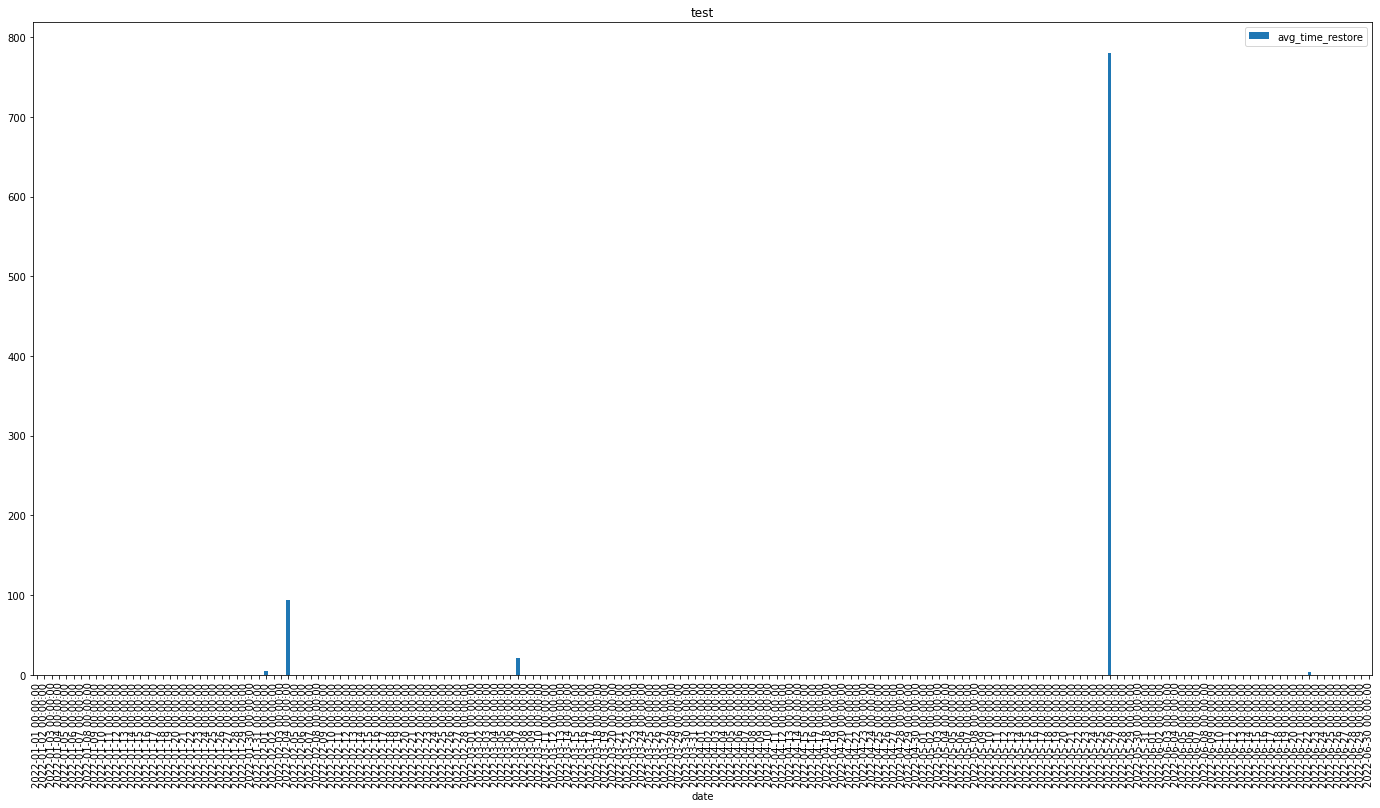

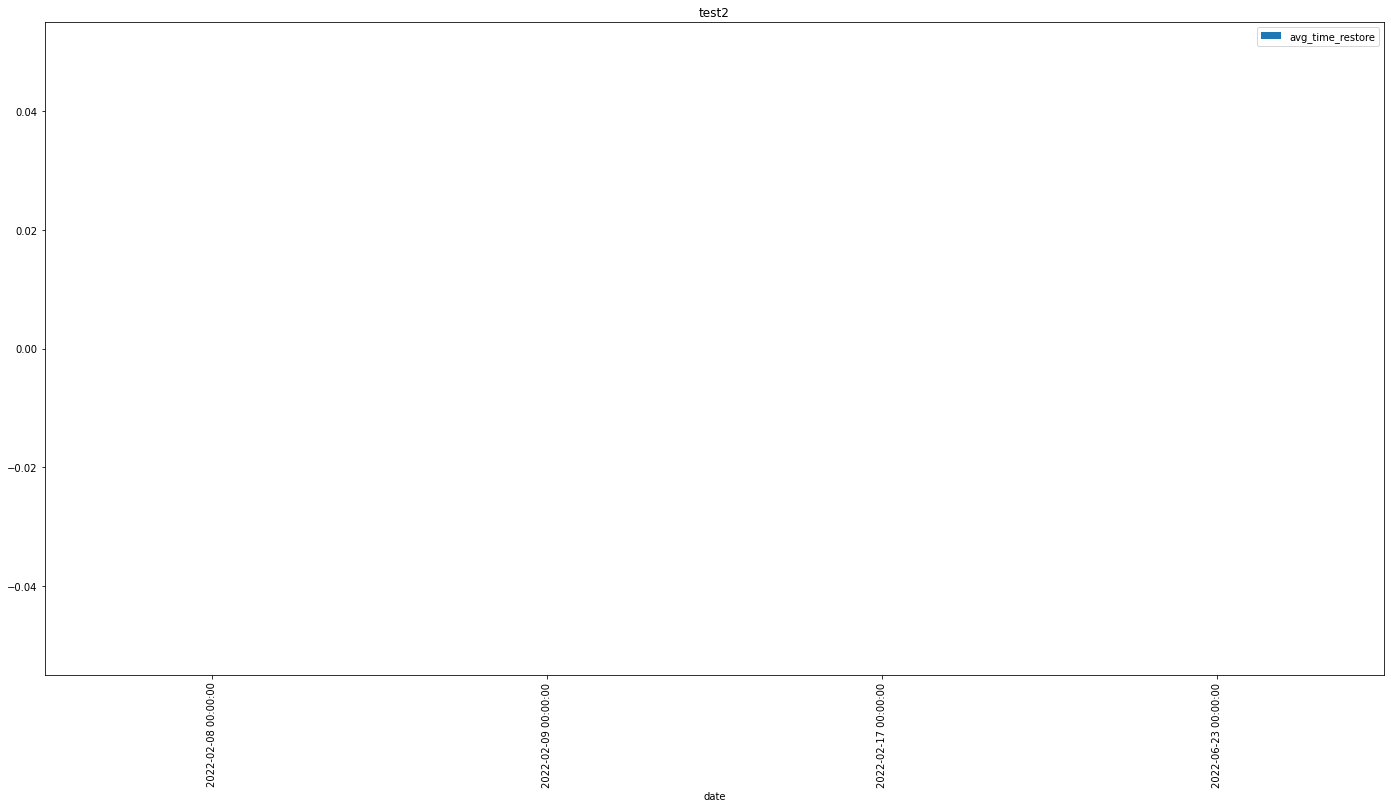

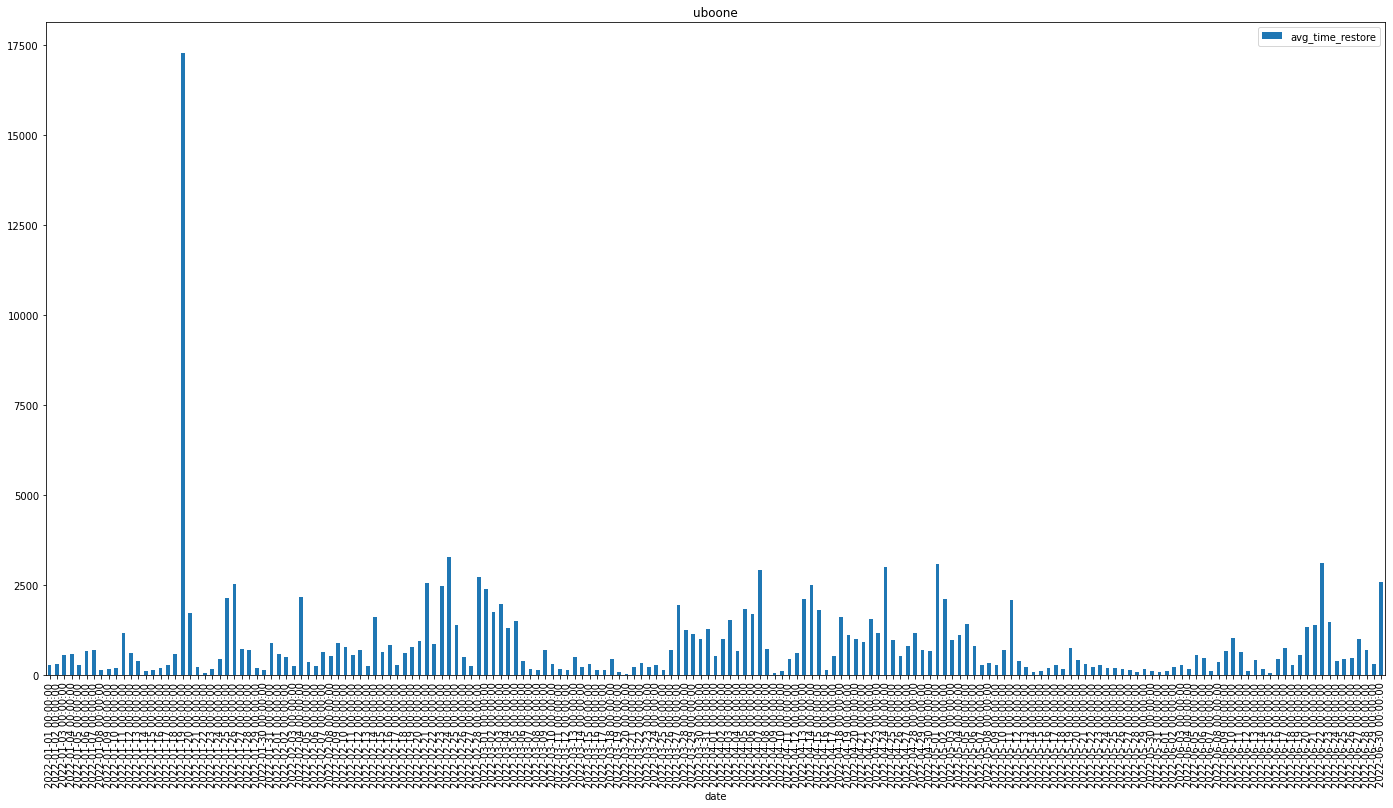

In [14]:
for vo, group in d1.groupby('vo'):
    group.plot.bar( x= 'date', title=vo, figsize=(12,6))
    plt.savefig(f'Average_time_restores_vs_time_for{vo}.png', bbox_inches='tight')

<AxesSubplot:title={'center':'avg_time_restore'}, xlabel='vo'>

Text(0.5, 0, 'vo')

/tmp/ipykernel_232526/4257835096.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('boxplot_Average_time_restores.png' ,fontsize=24)


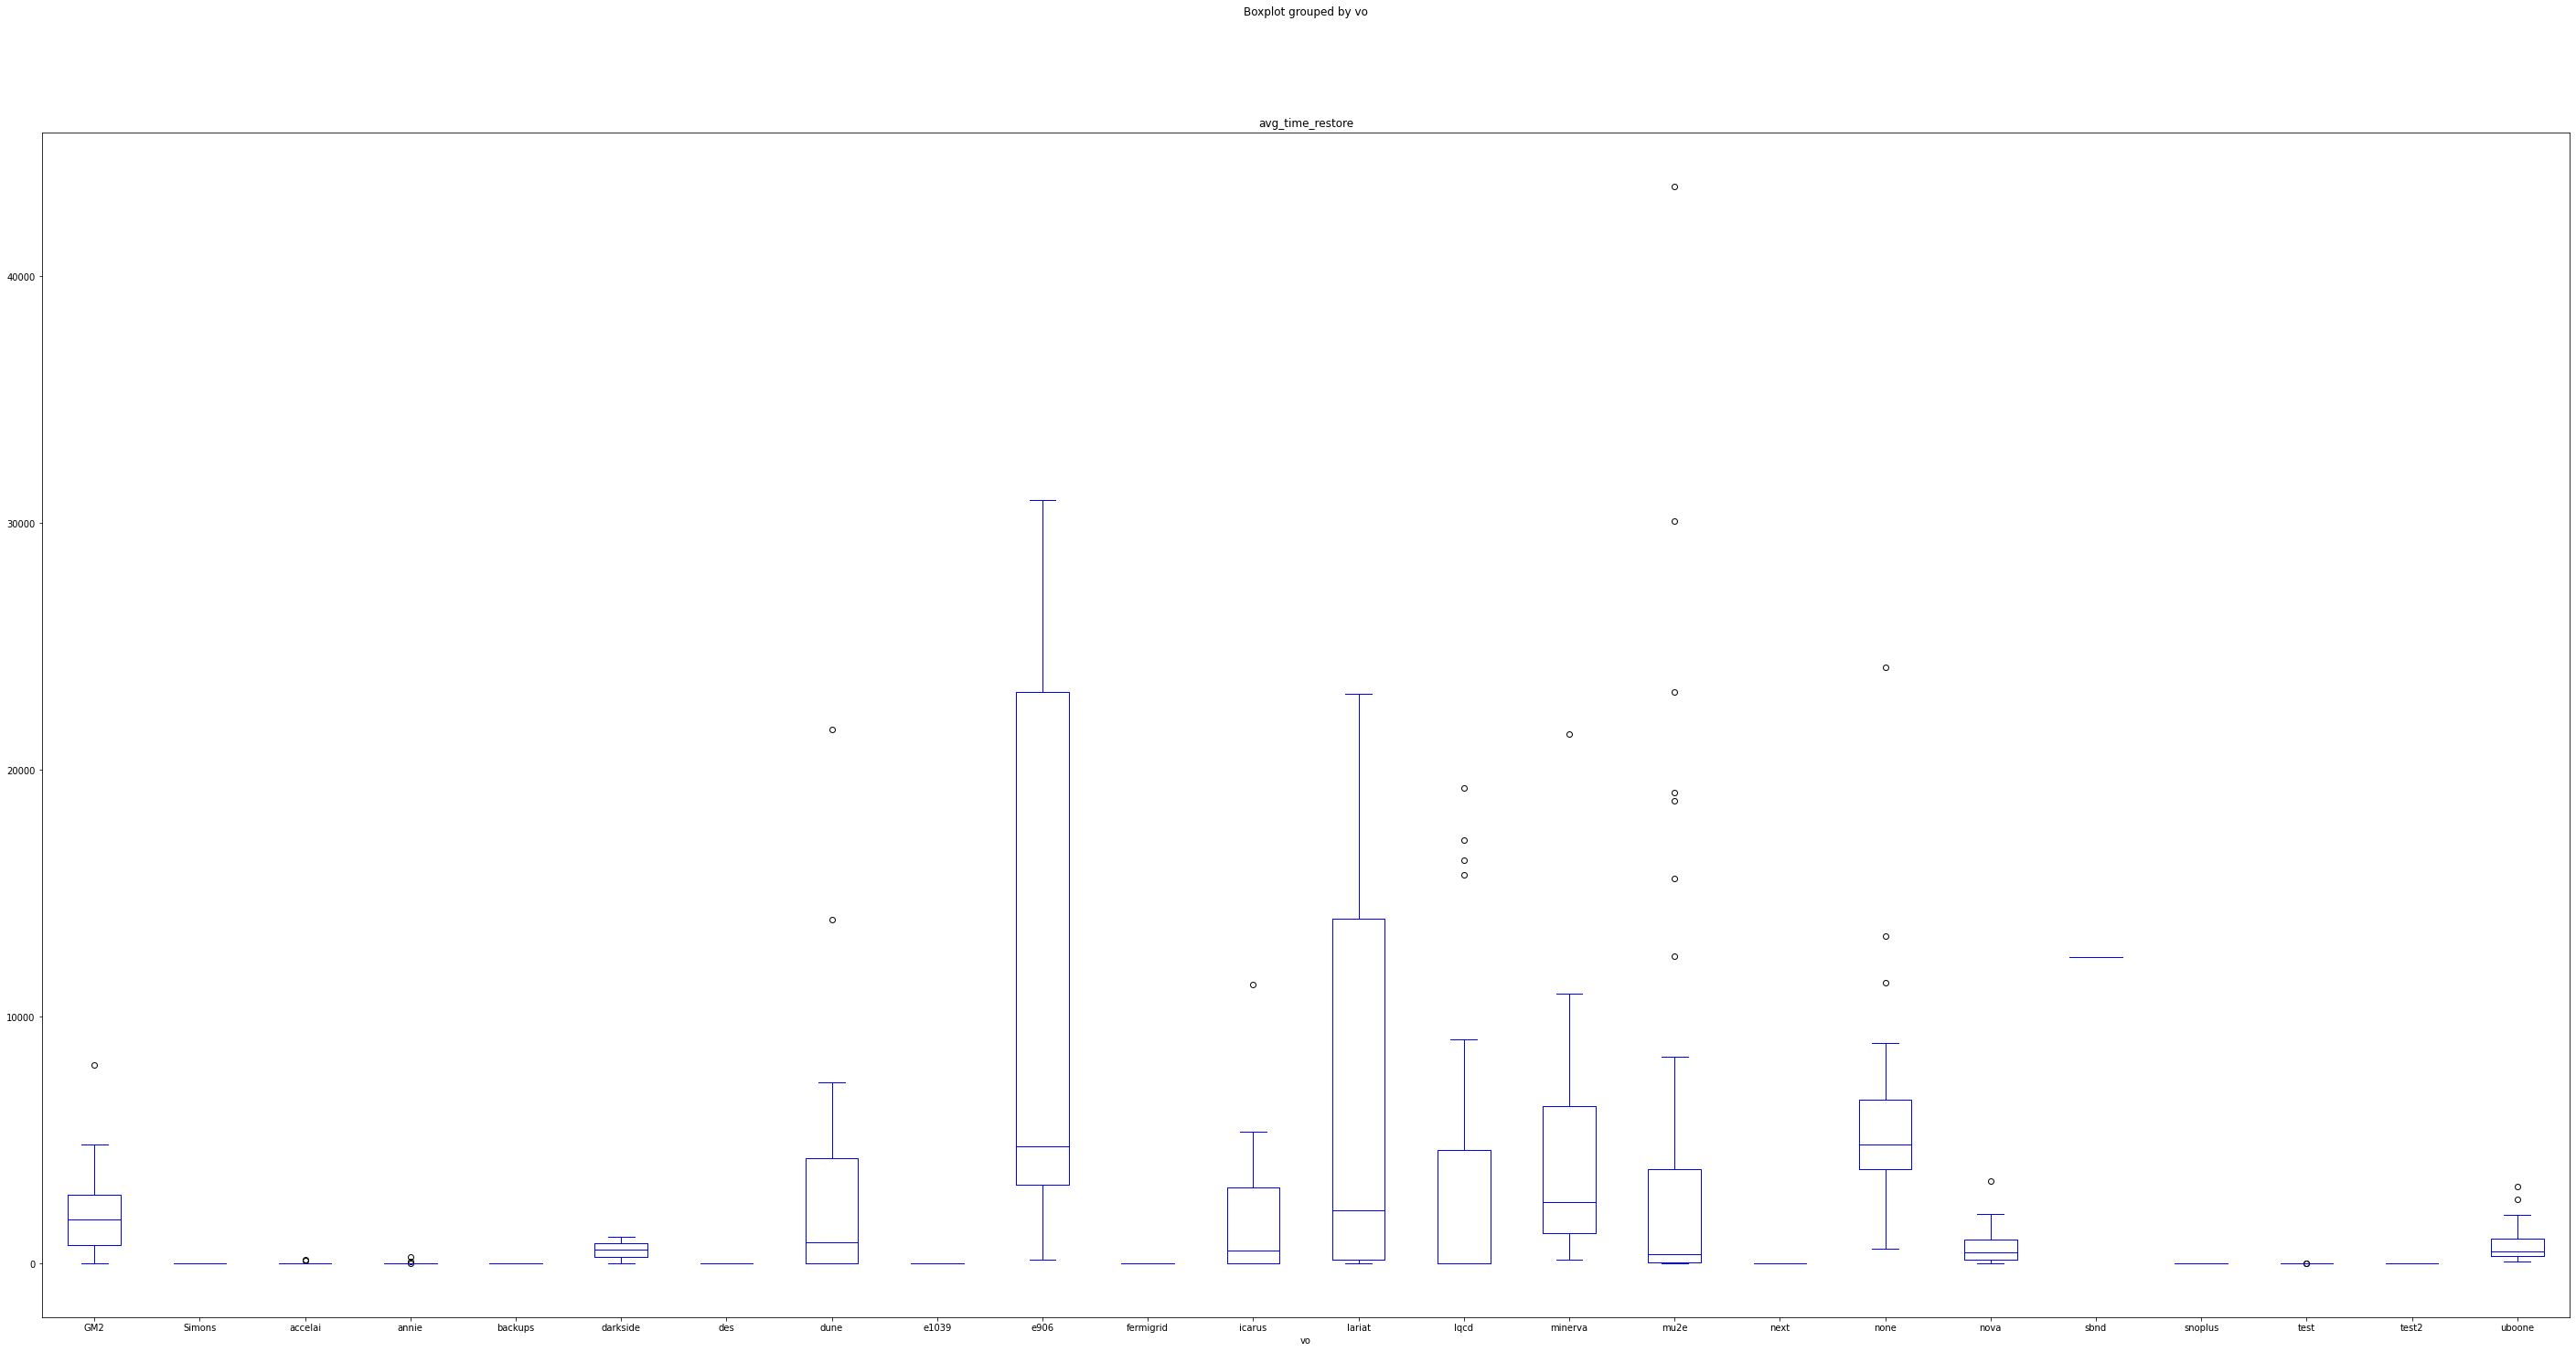

In [55]:
d.boxplot( by='vo',column='avg_time_restore', grid = False, color='blue',figsize=(48,24))
plt.xlabel("vo")
plt.savefig('boxplot_Average_time_restores.png' ,fontsize=24)

<AxesSubplot:title={'center':'avg_time_restore'}, xlabel='vo'>

Text(0.5, 0, 'vo')

/tmp/ipykernel_252575/232936703.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('boxplot_Average_time_restores_6_months.png' ,fontsize=24)


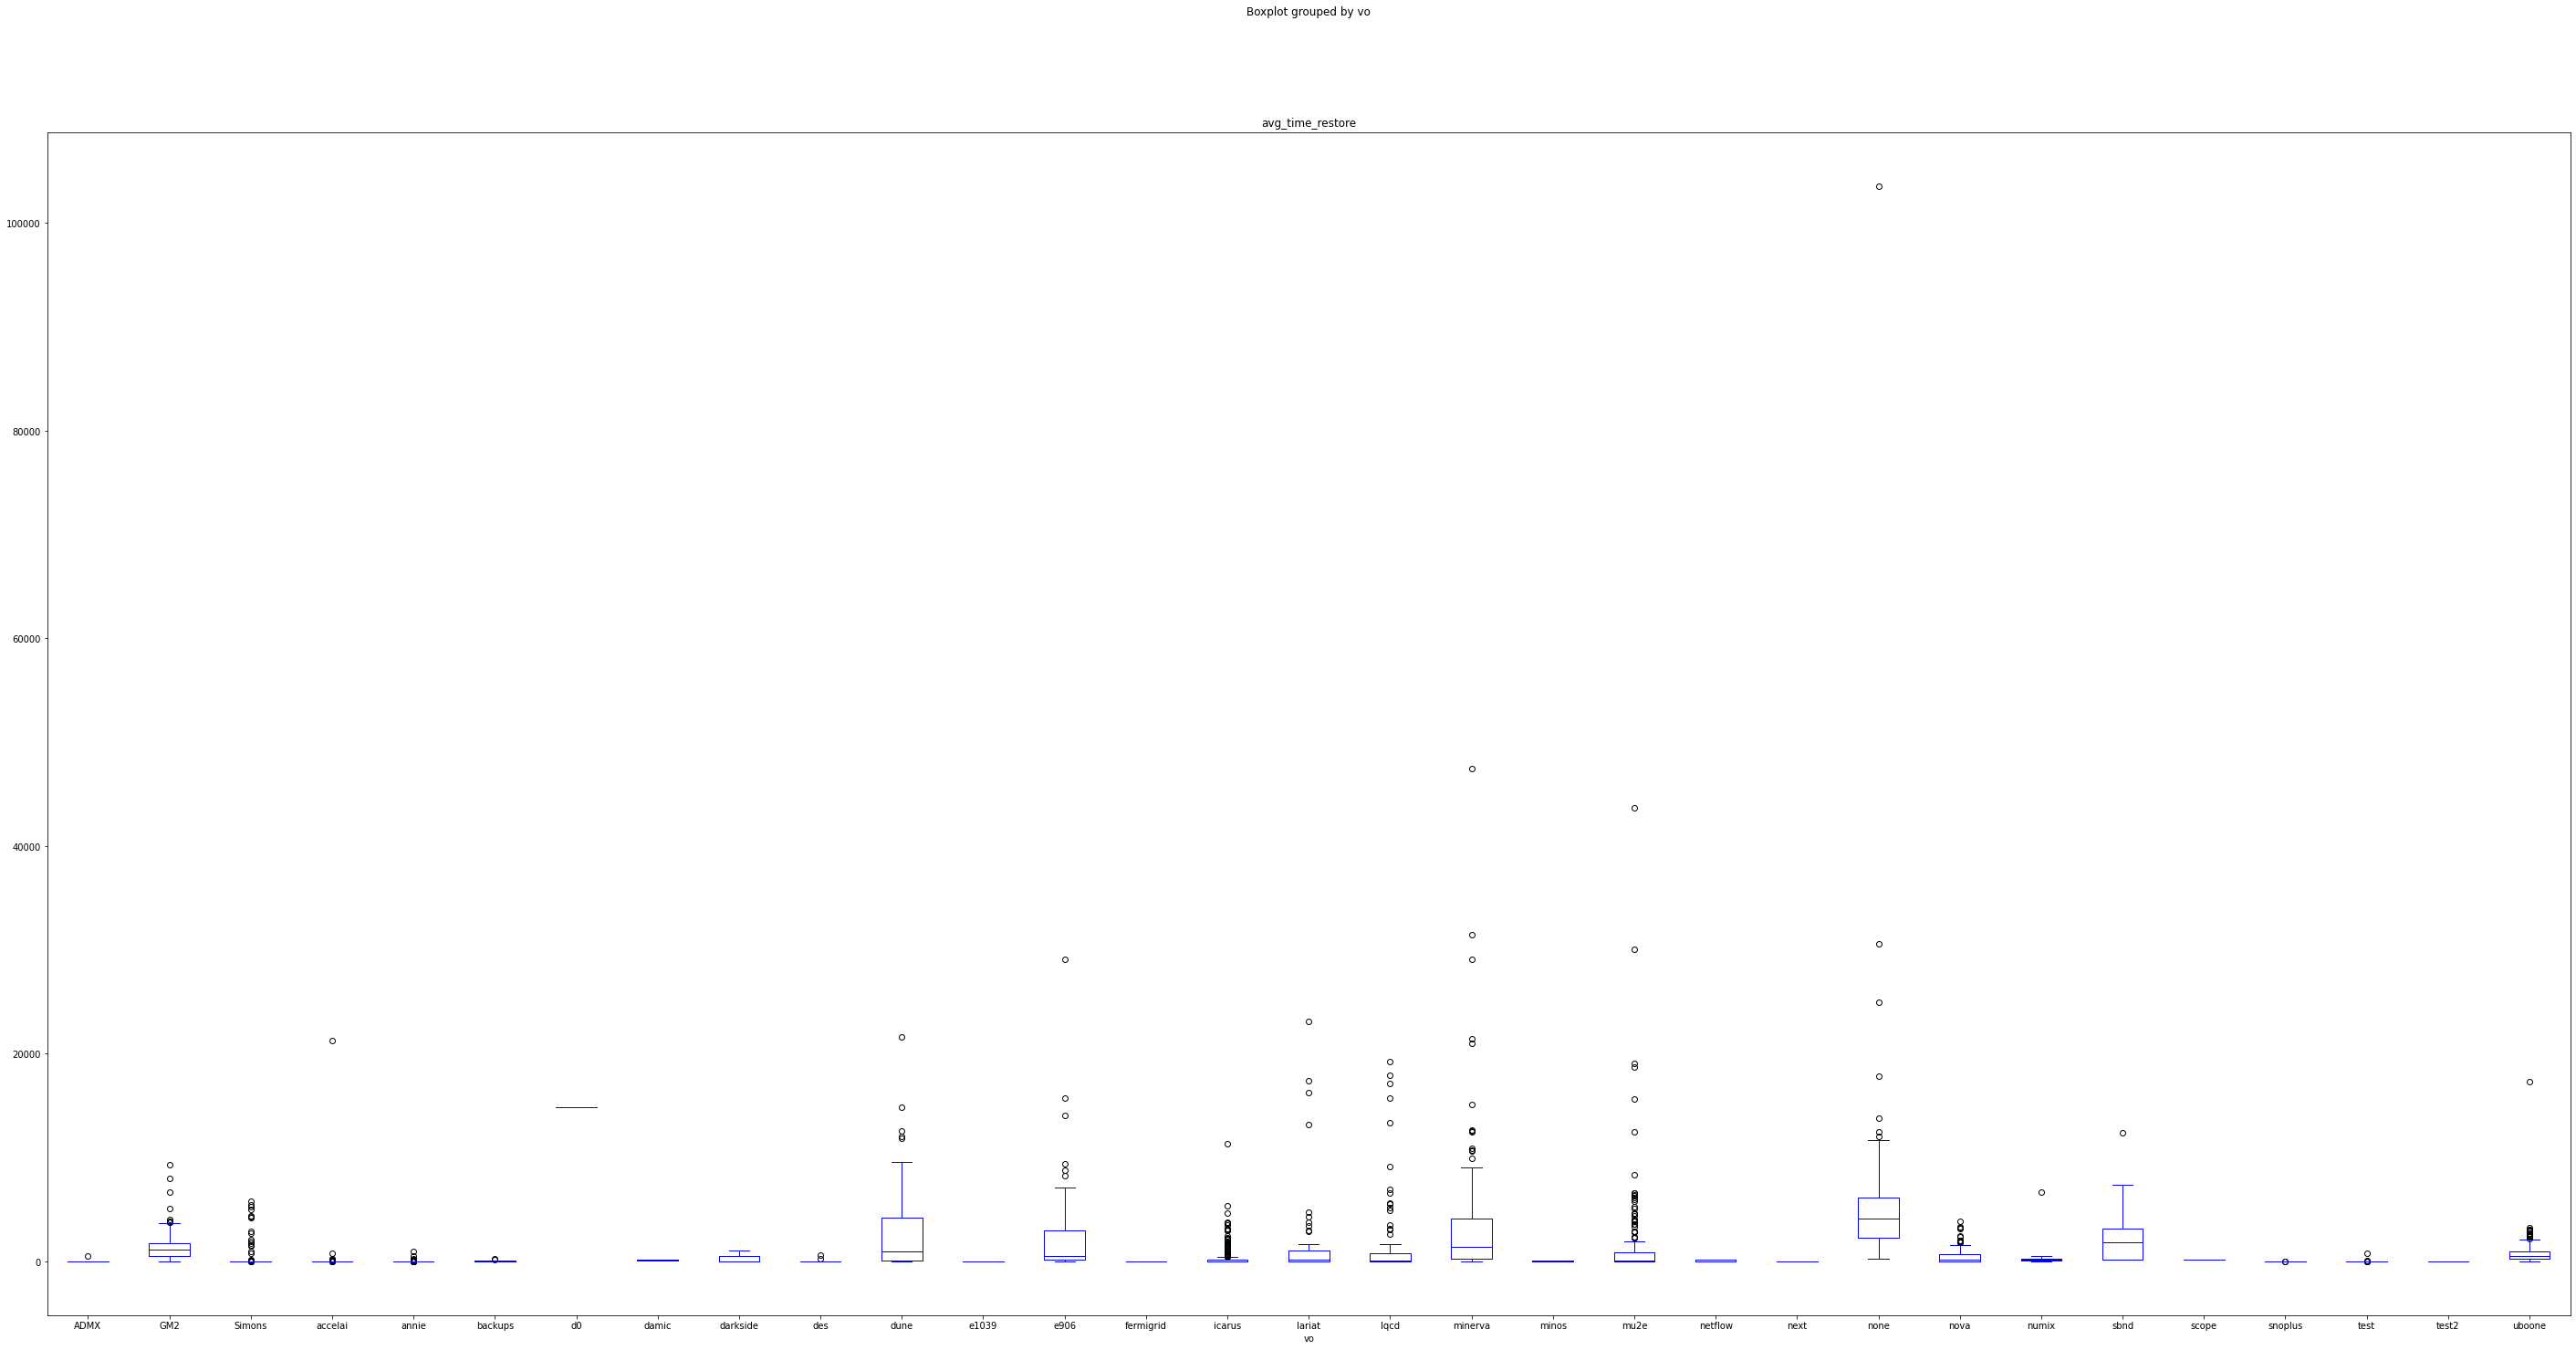

In [13]:
d.boxplot( by='vo',column='avg_time_restore', grid = False, color='blue',figsize=(48,24))
plt.xlabel("vo")
plt.savefig('boxplot_Average_time_restores_6_months.png' ,fontsize=24)

<AxesSubplot:title={'center':'avg_time_restore'}, xlabel='[vo]'>

Text(0.5, 0, 'vo')

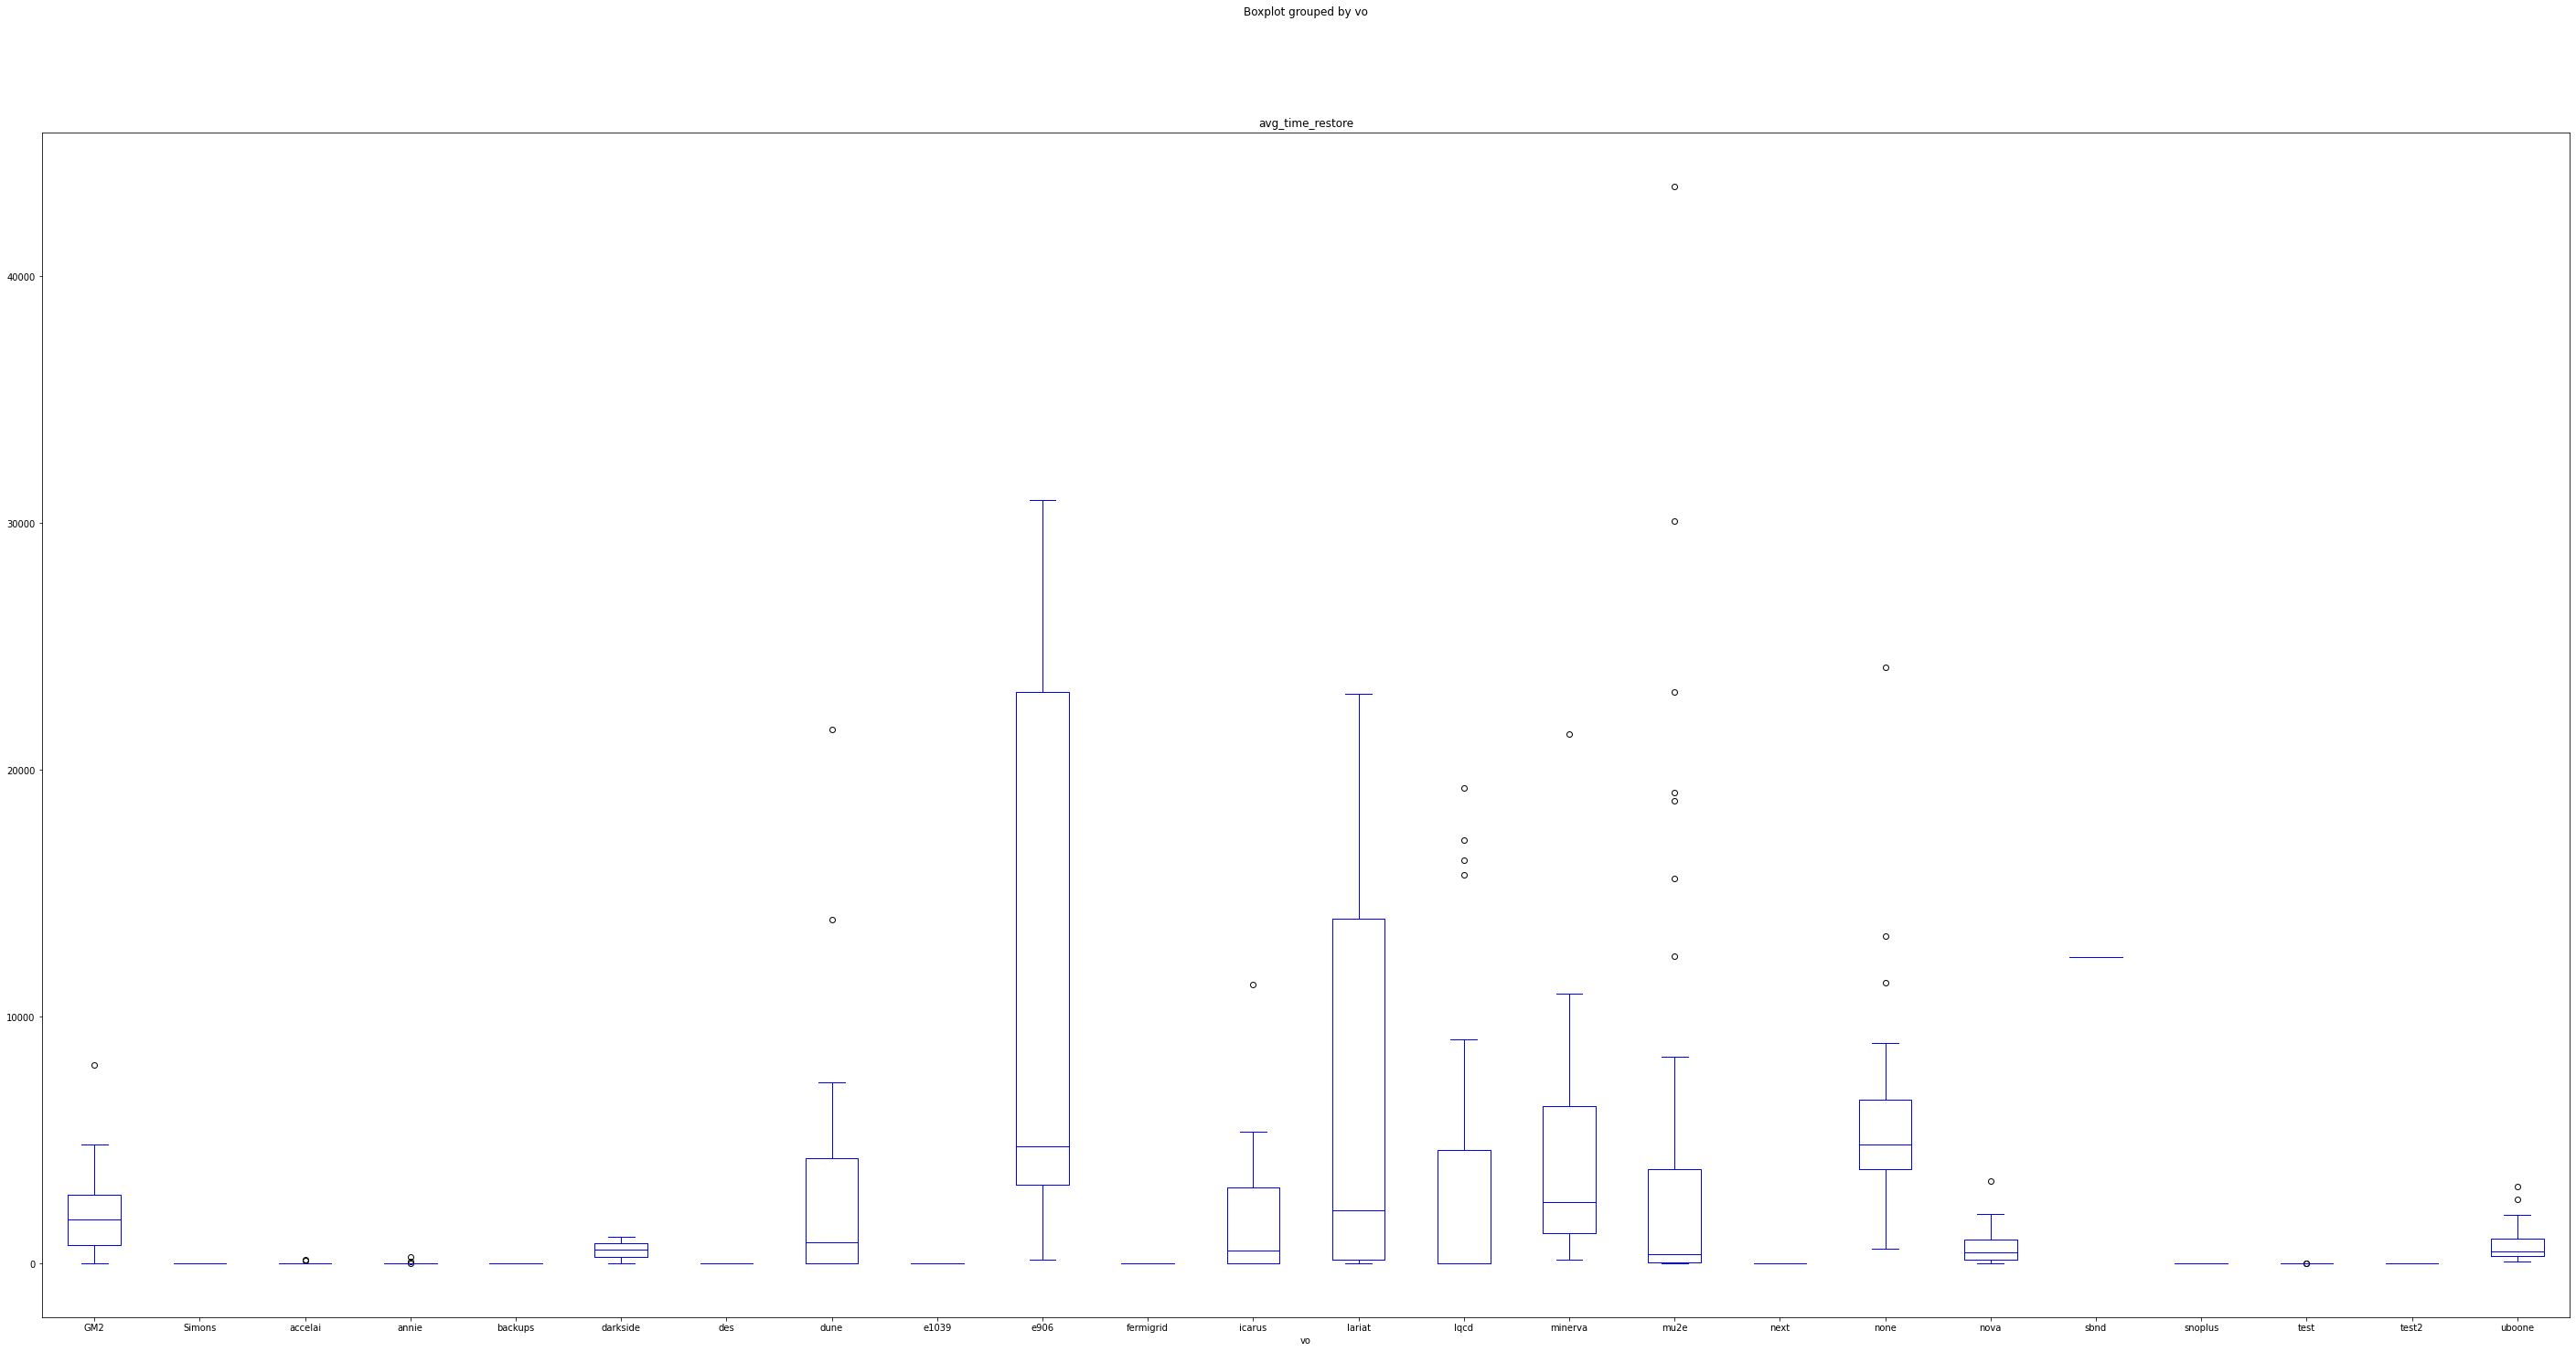

In [54]:
d1.boxplot( by='vo', grid = False, color='blue',figsize=(48,24))
plt.xlabel("vo")

<AxesSubplot:title={'center':'avg_time_restore'}, xlabel='vo'>

Text(0.5, 0, 'vo')

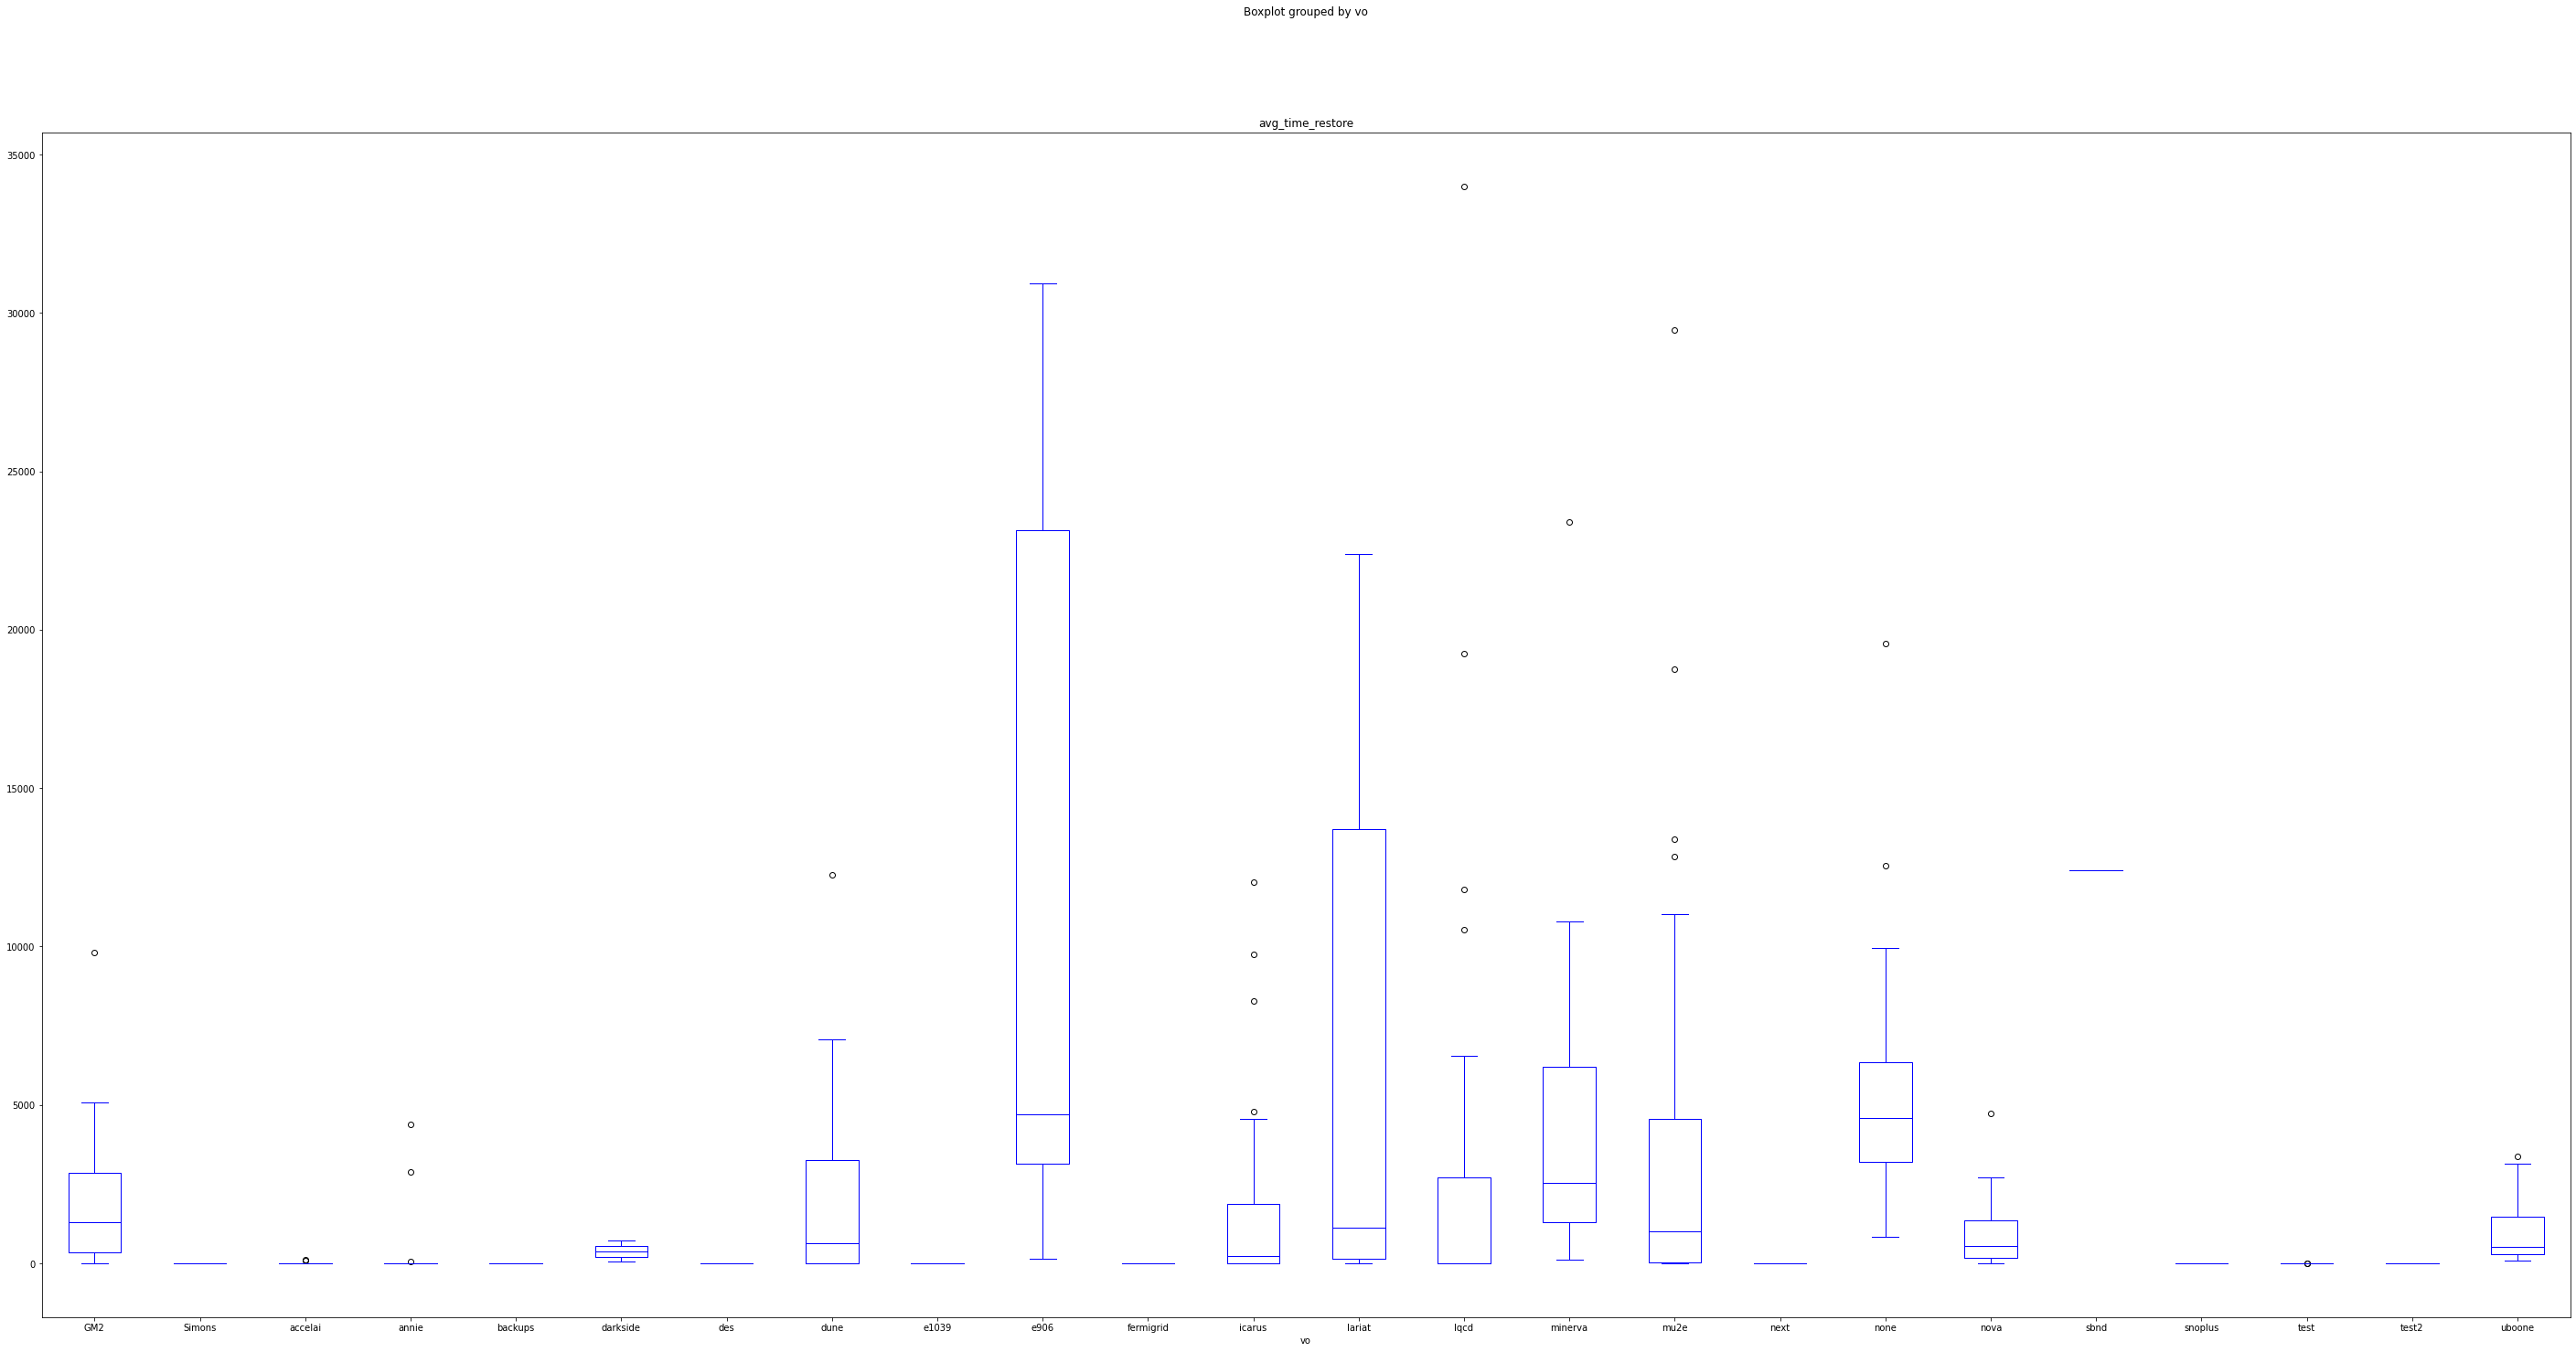

In [77]:
d2.boxplot( by='vo',column='avg_time_restore', grid = False, color='blue',figsize=(48,24))
plt.xlabel("vo")

array([<AxesSubplot:title={'center':'avg_time_restore'}, xlabel='[vo]'>,
       <AxesSubplot:title={'center':'avg_time_store'}, xlabel='[vo]'>],
      dtype=object)

Text(0.5, 0, 'vo')

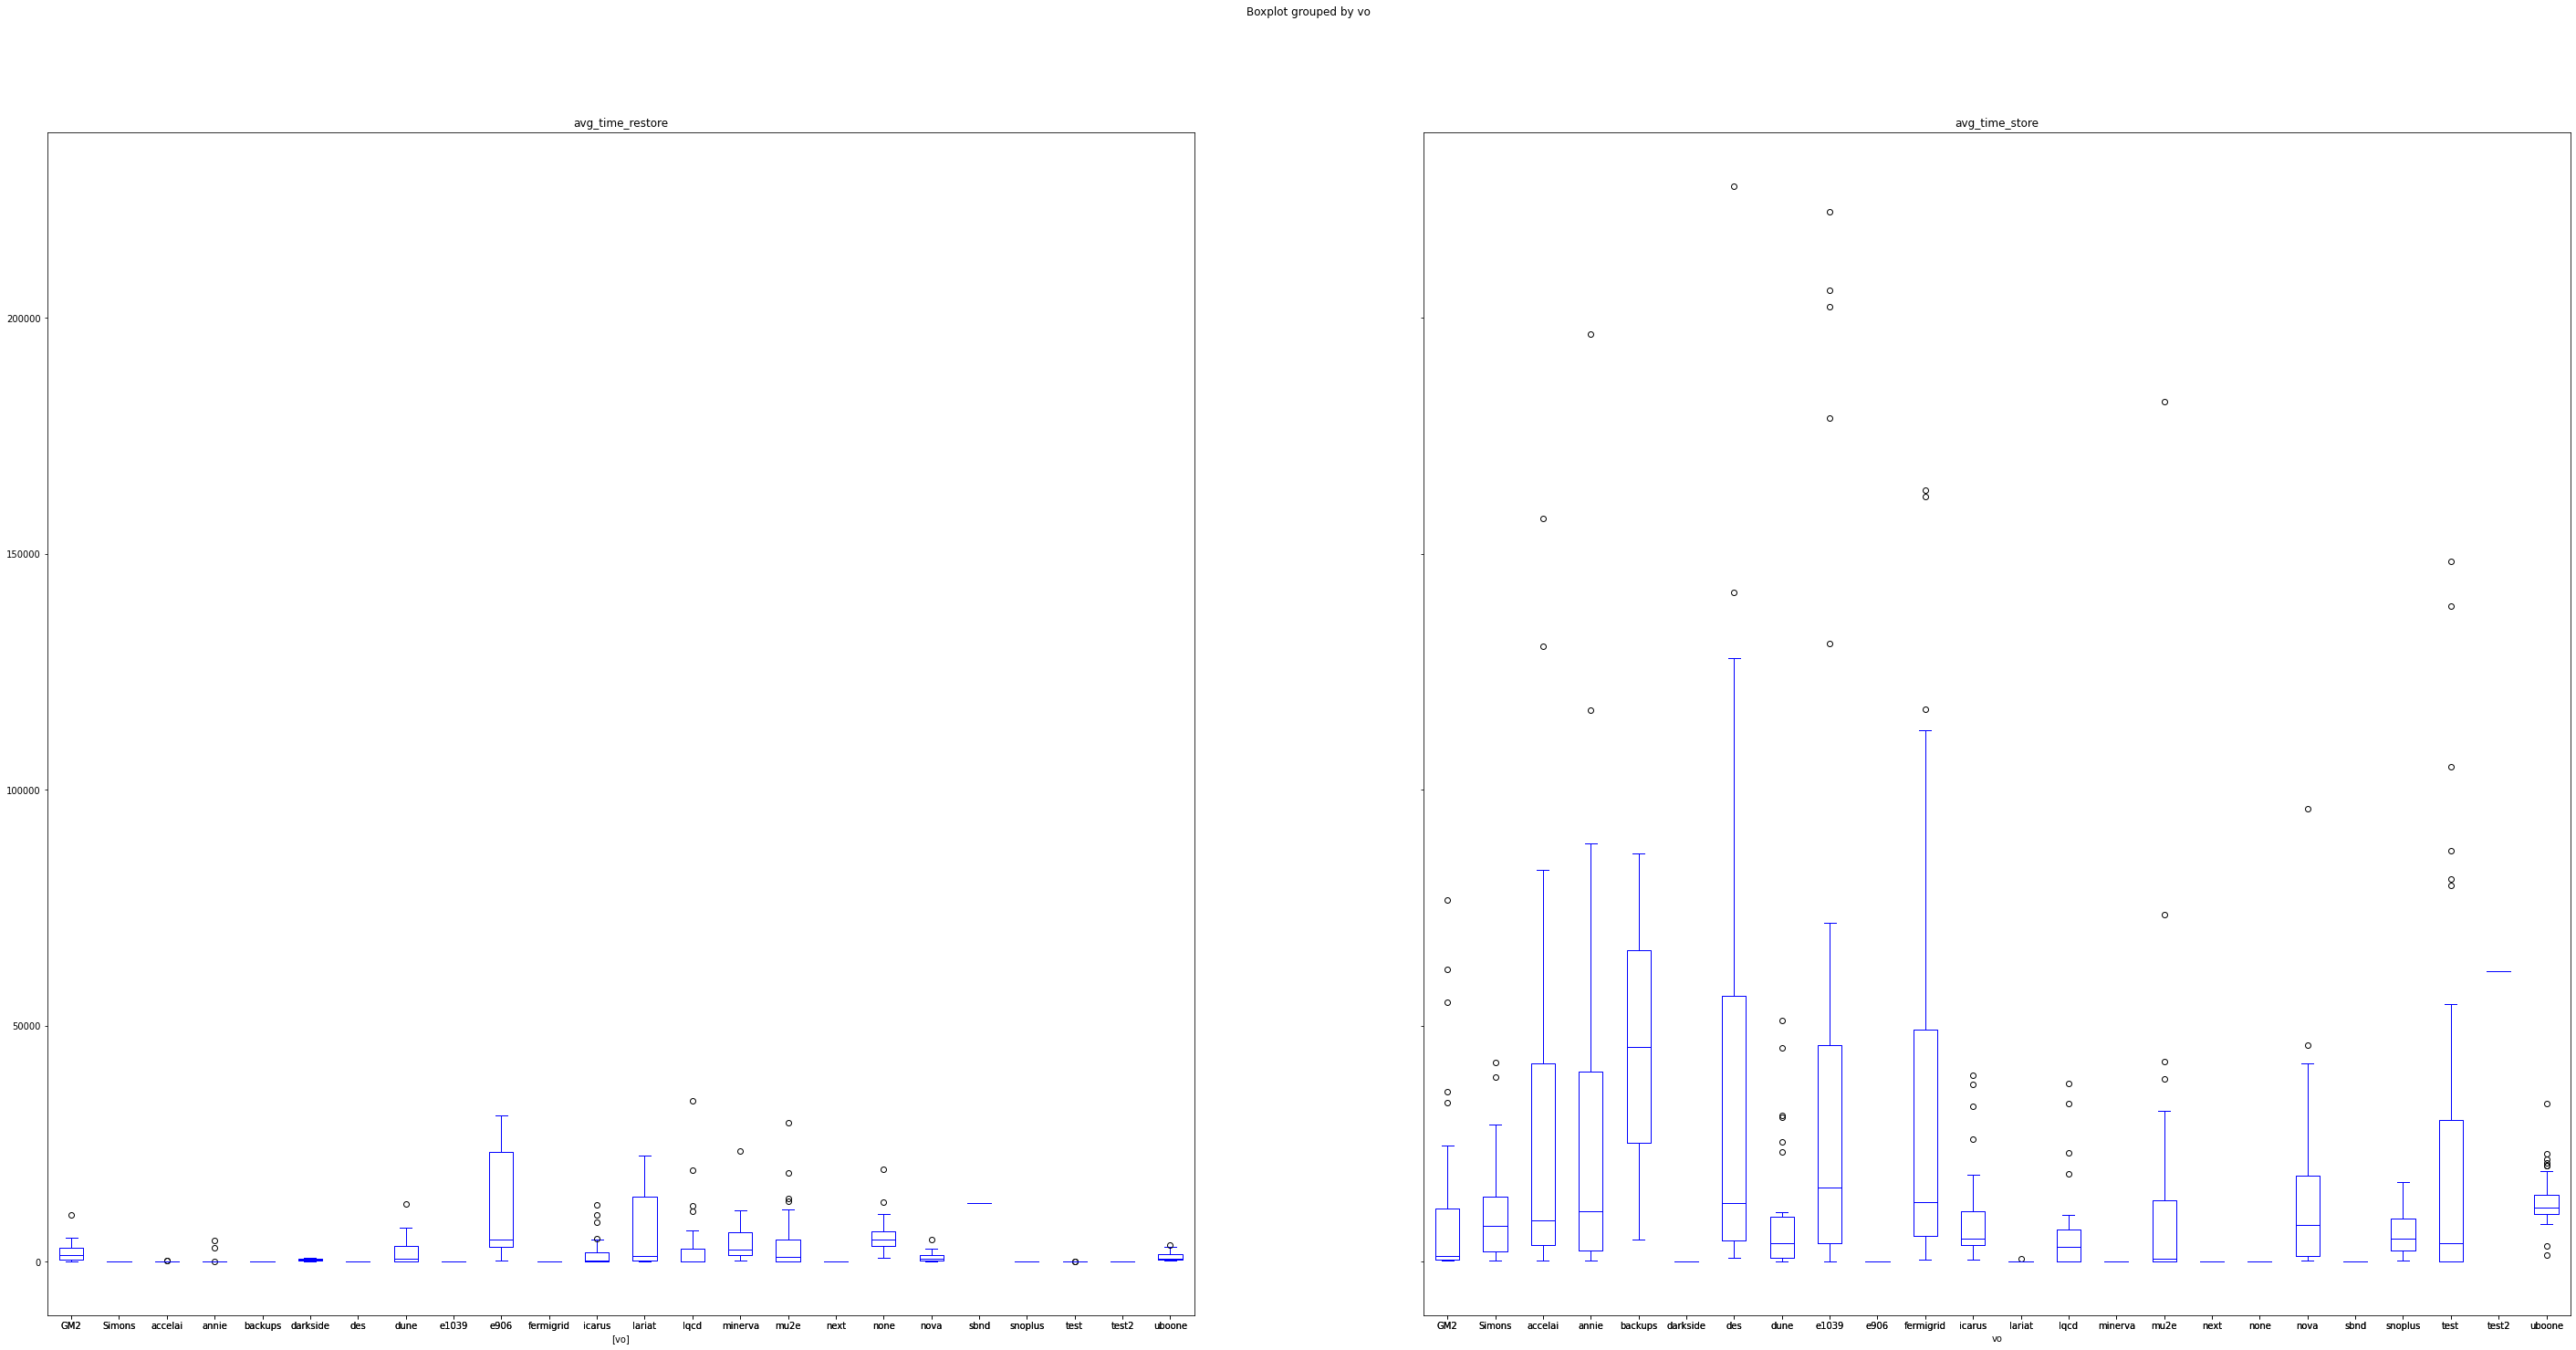

In [79]:
d2.boxplot( by='vo', grid = False, color='blue',figsize=(48,24))
plt.xlabel("vo")

In [34]:
#  df_vo_restore = spark.sql("select date, vo, sum(case when action = 'restore' then 1 else 0 END) as restores, AVG(connectiontime + queuedtime)/1000 as avg_time_restore  FROM billing where action='restore' and errorcode = 0  group by vo, date order by vo, date asc;")
# df_vo_restore.show(1000)
# df_vo_restore.count()
# df_vo_restore.describe()

In [35]:
# df_vo_store = spark.sql("select date, vo, sum(case when action = 'store' then 1 else 0 END)as stores, AVG(connectiontime + queuedtime)/1000 as avg_time_store  FROM billing where action='store' and errorcode = 0  group by vo, date order by date, vo asc;")
# df_vo_store.show(7845)
# df_vo_store.count()

In [17]:
# d3=df_vo_store.select('date','vo','avg_time_store')
# d4=df_vo_restore.select('date','vo','avg_time_restore')

In [18]:
# d3.show()

In [19]:
# d4.show()

In [20]:
# d1=d3.toPandas()
# d2=d4.toPandas()
# print(d1)
# print(d2)

In [45]:
# d3=d1.select('date','vo','avg_time_store')
# d4=d2.select('date','vo','avg_time_restore')

In [21]:
# df_merged = pd.merge(d1, d2, on=[ 'vo'], how='left')
# print(df_merged)

In [22]:
# ax1= d2.groupby('vo').plot(x='date', color='orange')
# ax2= d1.groupby('vo').plot(x= 'date' )
# plt.show()

In [23]:
#df_merged.set_index('date', inplace=True)
# df_merged.groupby('vo').plot(x='date', figsize=(24,12))

In [12]:
#df_vo = spark.sql("select date, sum(case when action = 'restore' then 1 else 0 END) as restores, vo FROM billing where errorcode = 0  group by date ,vo order by vo, date asc;")

In [24]:
# df_vo = spark.sql("SELECT vo ,COUNT(vo) AS number_of_restores , AVG(connectiontime + queuedtime) as time_to_restore FROM billing WHERE action='restore' and errorcode = 0 group by vo order by time_to_restore desc;  ")
# df_vo.show()

In [25]:
# select avg(connectiontime+queuedtime)/1000. from storageinfo where errorcode = 0 and datestamp > '2022-06-01 00:00:00'  and storageclass like 'GM2%' and action = 'restore';

In [26]:
# df_vo.count()

In [27]:
# d1=df_vo.toPandas()
# print(d1)

In [28]:
# d1['time_to_restore']=d1['time_to_restore'].div(1000)

In [29]:
# d1=d1.sort_values(by=['time_to_restore'], ascending=False)
# print(d1)

In [30]:
# d1.plot.bar(x='vo', y='time_to_restore' , color='blue',edgecolor = 'black', alpha=0.5 ,figsize=(24,12),align='center', width=-0.4)
# plt.xlabel("vo")
# plt.ylabel("avg_time_to_restore" ,fontsize=24)
# plt.savefig('avg_time_to_restore_per_vo.png' ,fontsize=24)
# plt.rcParams.update({'font.size': 14})
# plt.xticks(rotation=90)
# plt.show()

In [31]:
# df_vo_store = spark.sql("SELECT vo ,COUNT(vo) AS number_of_stores , AVG(connectiontime + queuedtime) as time_to_store FROM billing WHERE action='store' and errorcode = 0 group by vo order by time_to_store desc;  ")
# df_vo_store.show()

In [32]:
# d2=df_vo_store.toPandas()
# print(d2)

In [33]:
# d2['time_to_store']=d2['time_to_store'].div(1000)
# print(d1)

In [35]:
# select avg(connectiontime+queuedtime)/1000. from storageinfo where errorcode = 0 and datestamp > '2022-06-01 00:00:00'  and storageclass like 'GM2%' and action = 'restore';

In [36]:
# Number of bins  100, X axis - connectiontime / 1000, x_low = 0,
# x_high = max(connectiontime)/1000 for mu2e

# good , I like these plots.

# data frame has to have this functionality (plotting histograms) (edited) 

# for restores only

In [37]:
# df_vo_mu2e = spark.sql("SELECT date, vo , (connectiontime+queuedtime)/1000 as connection_time FROM billing WHERE action='restore' and errorcode = 0 and vo='mu2e' group by date, vo, connection_time order by connection_time desc;  ")
# df_vo_mu2e.show()

In [38]:
# df_vo11 = spark.sql("SELECT date, vo , (connectiontime+queuedtime)/1000 as connection_time FROM billing WHERE action='restore' and errorcode = 0 and vo='mu2e' group by date, vo, connection_time   ")
# df_vo11.show()

In [39]:
# df_vo_mu2e.count()

In [40]:
# d3=df_vo11.toPandas()
# print(d3)

In [41]:
# d4=df_vo_mu2e.toPandas()
# print(d4)

In [42]:
# print(d4['connection_time'].max())

In [43]:
# ax= d3.plot.hist(bins=100, figsize=(20, 16))
# plt.xlabel("time_to_restore")
# plt.savefig('hist_time_to_restore_for_mu2e.png')

In [44]:
# ax= d4.plot.hist(bins=100, figsize=(20, 16))
# #plt.xlim(0, 68398.906)

In [23]:
# dfff = pd.DataFrame({'DateTime': ['2021-01-15 20:02:11',
#                                 '1989-05-24 20:34:11',
#                                 '2020-01-18 14:43:24',
#                                 '2021-01-15 20:02:10',
#                                 '1999-04-04 20:34:11']})
 
# print("Original data")
# print(dfff)
 
# # convert datetime column to just date
# dfff['Date'] = pd.to_datetime(dfff['DateTime']).dt.date
 
# # display
# print("Only date")
# print(dfff)

In [41]:
# df_vo_mu2e = spark.sql("SELECT date, vo , (connectiontime+queuedtime)/1000 as connection_time FROM billing WHERE action='restore' and errorcode = 0 and vo='mu2e' group by date, vo, connection_time order by connection_time desc;  ")
# df_vo_mu2e.show()

In [42]:
#df_vo_mu2e.count()

In [43]:
# d4=df_vo_mu2e.toPandas()
# print(d4)

In [44]:
# ax= d4.plot.hist(bins=100, figsize=(20, 16))
# plt.xlabel("time_to_restore")
# #plt.savefig('hist_time_to_restore_for_mu2e.png')